## loading libraries, dataset and defining target variable

In [ ]:
# Basic Imports (add more as needed within each step)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score, make_scorer
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks
from collections import Counter

In [ ]:
import pandas as pd
import json
from google.colab import drive
drive.mount('/content/drive')

file_path="/content/drive/MyDrive/attiki odos/augmented_accidents_data_final.csv"



try:
    df = pd.read_csv(file_path, encoding='utf-8')
except FileNotFoundError:
    print("Error: file_path not found.")
    df = None
except pd.errors.ParserError:
    print("Error: Unable to parse the CSV file.")
    df = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df = None

if df is not None:
    display(df.head())
    print(df.shape)

Mounted at /content/drive


α/α   ΗΜ/ΝΙΑ_ΚΑΤΑΧΩΡΗΣΗΣ          ΑΝΑΦΟΡΑ       ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ  \
0    1  2014-01-01 00:00:00         Δ.Π.Λ.Υ.  2014-01-01 16:50:00   
1    2  2014-01-11 00:00:00         Δ.Π.Λ.Υ.  2014-01-11 05:41:00   
2    3  2014-01-14 00:00:00  ΕΛ.ΕΣ.Σ. ΔΥΤΙΚΑ  2014-01-14 14:30:00   
3    4  2014-01-19 00:00:00         Δ.Π.Λ.Υ.  2014-01-19 14:34:00   
4    5  2014-01-28 00:00:00  ΕΛ.ΕΣ.Σ. ΔΥΤΙΚΑ  2014-01-28 16:41:00   

              ΗΜ.ΛΗΞΗΣ ΑΥΤ/ΔΡΟΜΟΣ  ΚΟΜΒΟΣ ΣΤΑΘΜ.ΔΙΟΔΙΩΝ ΚΛΑΔΟΣ  ΧΙΛ.ΘΕΣΗ  ...  \
0  2014-01-01 17:33:00          K     2.0           NaN      1       0.0  ...   
1  2014-01-11 07:27:00          P     NaN           NaN    NaN       6.1  ...   
2  2014-01-14 15:36:00          E     1.0           NaN    A-1       0.0  ...   
3  2014-01-19 14:54:00          K     NaN           NaN    NaN       3.8  ...   
4  2014-01-28 17:46:00          A     NaN           NaN    NaN      22.8  ...   

  next_curve_direction next_curve_category next_curve_lat  next_curve_lng  \
0                  NaN                 NaN            NaN             NaN   
1                 left    Very Sharp Curve      38.001362       23.845701   
2                right    Very Sharp Curve      38.057494       23.512682   
3                 left    Very Sharp Curve      37.993188       23.820712   
4                 left    Very Sharp Curve      38.059926       23.756841   

   profile_total_curves profile_left_turns profile_right_turns  \
0                    58                 43                  15   
1                    38                 22                  16   
2                   443                295                 148   
3                    58                 43                  15   
4                   416                245                 171   

  profile_avg_angle nearby_junctions_count_500m nearby_roads_count_100m  
0          7.703853                           0                       0  
1         11.052188                           0                       0  
2          8.630010                           0                       0  
3          7.703853                           0                       0  
4          7.394187                           0                       0  

[5 rows x 215 columns]

(523, 215)


In [ ]:
df_original = df.copy()

if df_original is not None:
    # Option 1: If 'accident_type' is already 'injury'/'death'
    if 'accident_type' in df_original.columns and \
       set(df_original['accident_type'].unique()).issuperset({'injury', 'death'}):
        print("\nUsing 'accident_type' as the target.")
        le = LabelEncoder()
        df_original['accident_severity'] = le.fit_transform(df_original['accident_type'])
        # Assuming 'death' gets encoded as 1 and 'injury' as 0. Verify with le.classes_
        print(f"LabelEncoder classes: {le.classes_} (death should ideally be 1)")
        if le.classes_[1] != 'death': # If 'death' is not 1, swap labels
             print("Swapping labels to ensure 'death' is 1.")
             df_original['accident_severity'] = df_original['accident_severity'].apply(lambda x: 1-x)

    # Option 2: If deriving from 'ΝΕΚΡΟΙ' (as previously planned)
    else:
        print("\n'accident_type' not suitable or not found. Deriving target from 'ΝΕΚΡΟΙ'.")
        df_original['accident_severity'] = np.where(df_original['ΝΕΚΡΟΙ'] > 0, 1, 0)

    print("\nTarget Variable Distribution ('accident_severity'):")
    print(df_original['accident_severity'].value_counts(normalize=True))



Using 'accident_type' as the target.
LabelEncoder classes: ['death' 'injury'] (death should ideally be 1)
Swapping labels to ensure 'death' is 1.

Target Variable Distribution ('accident_severity'):
accident_severity
0    0.90631
1    0.09369
Name: proportion, dtype: float64


In [ ]:
# if 'df_original' in locals() and df_original is not None:
#     initial_rows = df_original.shape[0]
#     print(f"Initial number of rows: {initial_rows}")

#     # Convert 'ΧΙΛ.ΘΕΣΗ' to numeric, coercing errors to NaN, then check for 0
#     # This handles both numeric 0 and string '0', '0.0', etc.
#     df_original['ΧΙΛ.ΘΕΣΗ_numeric'] = pd.to_numeric(df_original['ΧΙΛ.ΘΕΣΗ'], errors='coerce').fillna(-1) # Fill NaN with a value outside range of 0

#     # Define the conditions to drop
#     condition_A_0km = (df_original['ΑΥΤ/ΔΡΟΜΟΣ'] == 'A') & (df_original['ΧΙΛ.ΘΕΣΗ_numeric'] == 0)
#     condition_K_0km = (df_original['ΑΥΤ/ΔΡΟΜΟΣ'] == 'K') & (df_original['ΧΙΛ.ΘΕΣΗ_numeric'] == 0)

#     # Combine the conditions using | (OR)
#     rows_to_drop = condition_A_0km | condition_K_0km

#     # Drop the rows that satisfy the combined condition
#     df_original = df_original[~rows_to_drop].copy() # Use '~' for negation

#     # Drop the temporary numeric column
#     df_original = df_original.drop(columns=['ΧΙΛ.ΘΕΣΗ_numeric'])

#     rows_after_dropping = df_original.shape[0]
#     dropped_count = initial_rows - rows_after_dropping
#     print(f"Number of rows after dropping: {rows_after_dropping}")
#     print(f"Number of rows dropped: {dropped_count}")

#     # Optional: Display the head of the modified DataFrame
#     # display(df_original.head())
# else:
#     print("df_original is not available. Skipping row dropping.")

# Iteration 1: Small feature set

## selecting initial features

In [ ]:
if df_original is not None:
    columns_iter1 = [
        'ΑΥΤ/ΔΡΟΜΟΣ', 'ΧΙΛ.ΘΕΣΗ', 'ΣΗΡΑΓΓΑ',
        'ΥΠΟΚΑΤΗΓΟΡΙΑ', 'ΘΕΣΗ_ΕΡΓΟΥ', 'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.',
        'ΚΑΤ._ΟΔ.','ΤΕΧΝ._ΦΩΤ.', #'accident_type', # This is now our target or related to it
        'lat', 'lng', 'num_involved_vehicles', 'has_ΙΧΕ',
        'has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ', 'has_ΔΙΚΥΚΛΟ', 'has_ΦΟΡΤΗΓΟ', 'has_ΤΑΞΙ',
        'has_ΛΕΩΦΟΡΕΙΟ', 'has_Μ.Ε.',
        'accident_severity', # Keep the target variable
        'effective_lighting_condition',# replacing ΤΕΧΝ._ΦΩΤ. with effective_lighting_condition
    ]
    # Ensure all selected columns exist in df_original
    columns_iter1 = [col for col in columns_iter1 if col in df_original.columns]
    if 'accident_severity' not in columns_iter1 and 'accident_severity' in df_original.columns:
         columns_iter1.append('accident_severity')


    df_iter1 = df_original[columns_iter1].copy()
    print(f"\n--- Iteration 1: Working with {len(df_iter1.columns)-1} features ---")
    # display(df_iter1.head())



--- Iteration 1: Working with 20 features ---


## data splitting (train, validation, test)

In [ ]:
if 'df_iter1' in locals() and df_iter1 is not None:
    X = df_iter1.drop('accident_severity', axis=1)
    y = df_iter1['accident_severity']

    # Split into Train (60%) and Temp (40% for Val+Test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )

    # Split Temp into Validation (50% of Temp -> 20% of total) and Test (50% of Temp -> 20% of total)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"Training set: {X_train.shape}, {y_train.shape}, Minority class: {Counter(y_train)[1]}")
    print(f"Validation set: {X_val.shape}, {y_val.shape}, Minority class: {Counter(y_val)[1]}")
    print(f"Test set: {X_test.shape}, {y_test.shape}, Minority class: {Counter(y_test)[1]}")


Training set: (313, 20), (313,), Minority class: 29
Validation set: (105, 20), (105,), Minority class: 10
Test set: (105, 20), (105,), Minority class: 10


## data exploration

Numerical Features: ['ΧΙΛ.ΘΕΣΗ', 'lat', 'lng', 'num_involved_vehicles']
Categorical Features: ['ΑΥΤ/ΔΡΟΜΟΣ', 'ΣΗΡΑΓΓΑ', 'ΥΠΟΚΑΤΗΓΟΡΙΑ', 'ΘΕΣΗ_ΕΡΓΟΥ', 'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'ΚΑΤ._ΟΔ.', 'ΤΕΧΝ._ΦΩΤ.', 'effective_lighting_condition']


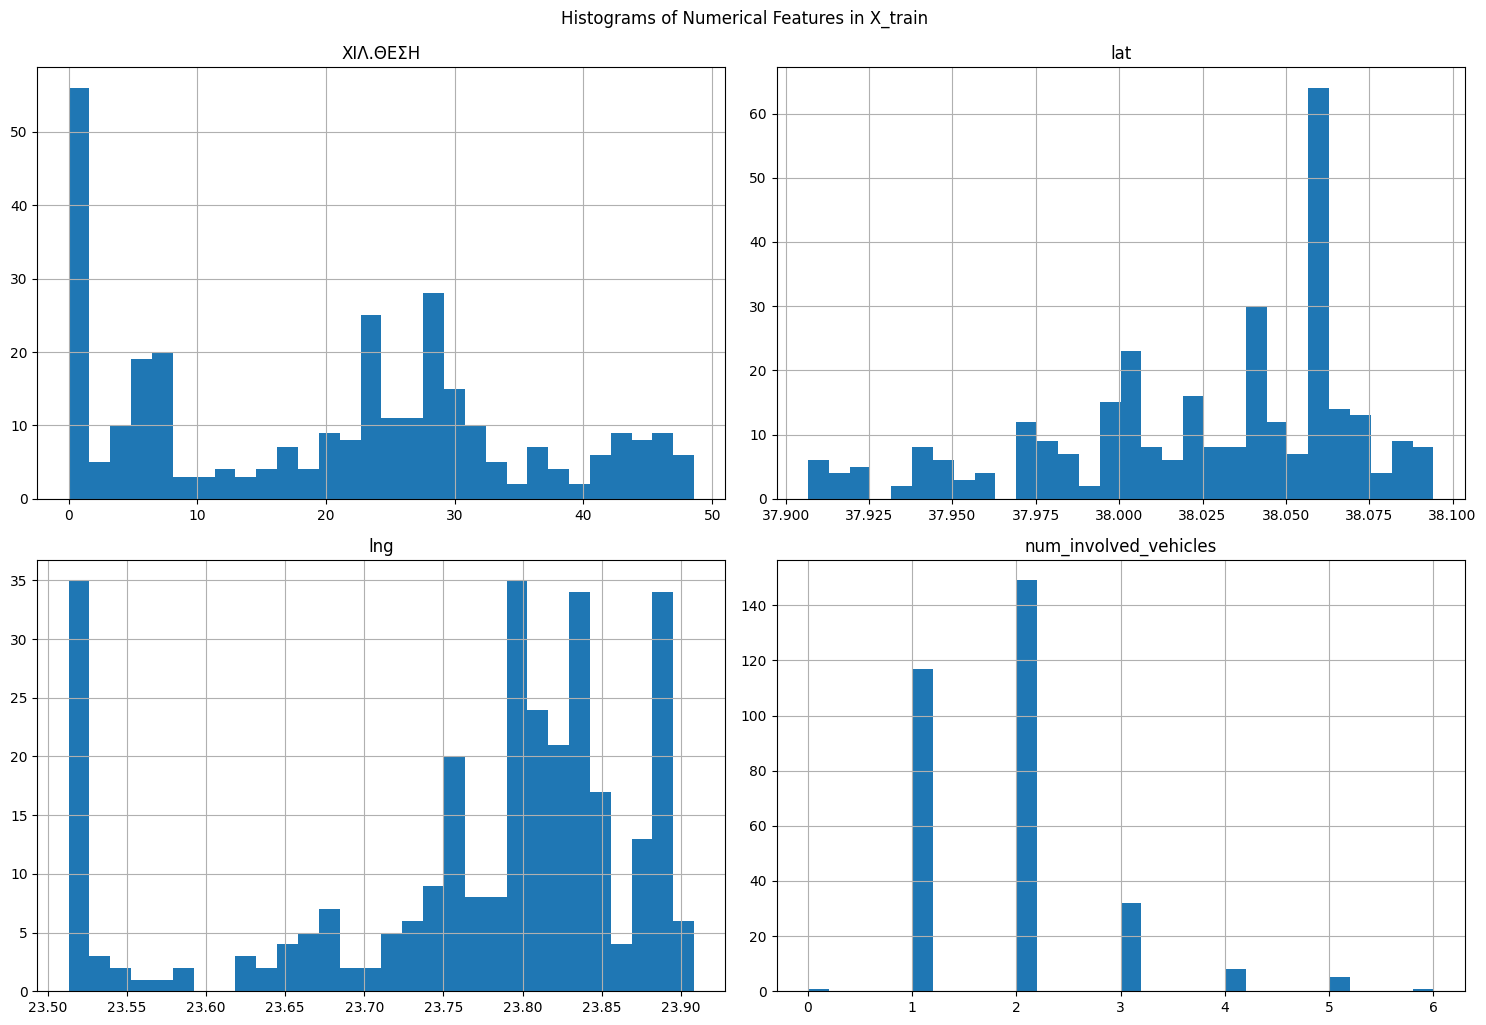

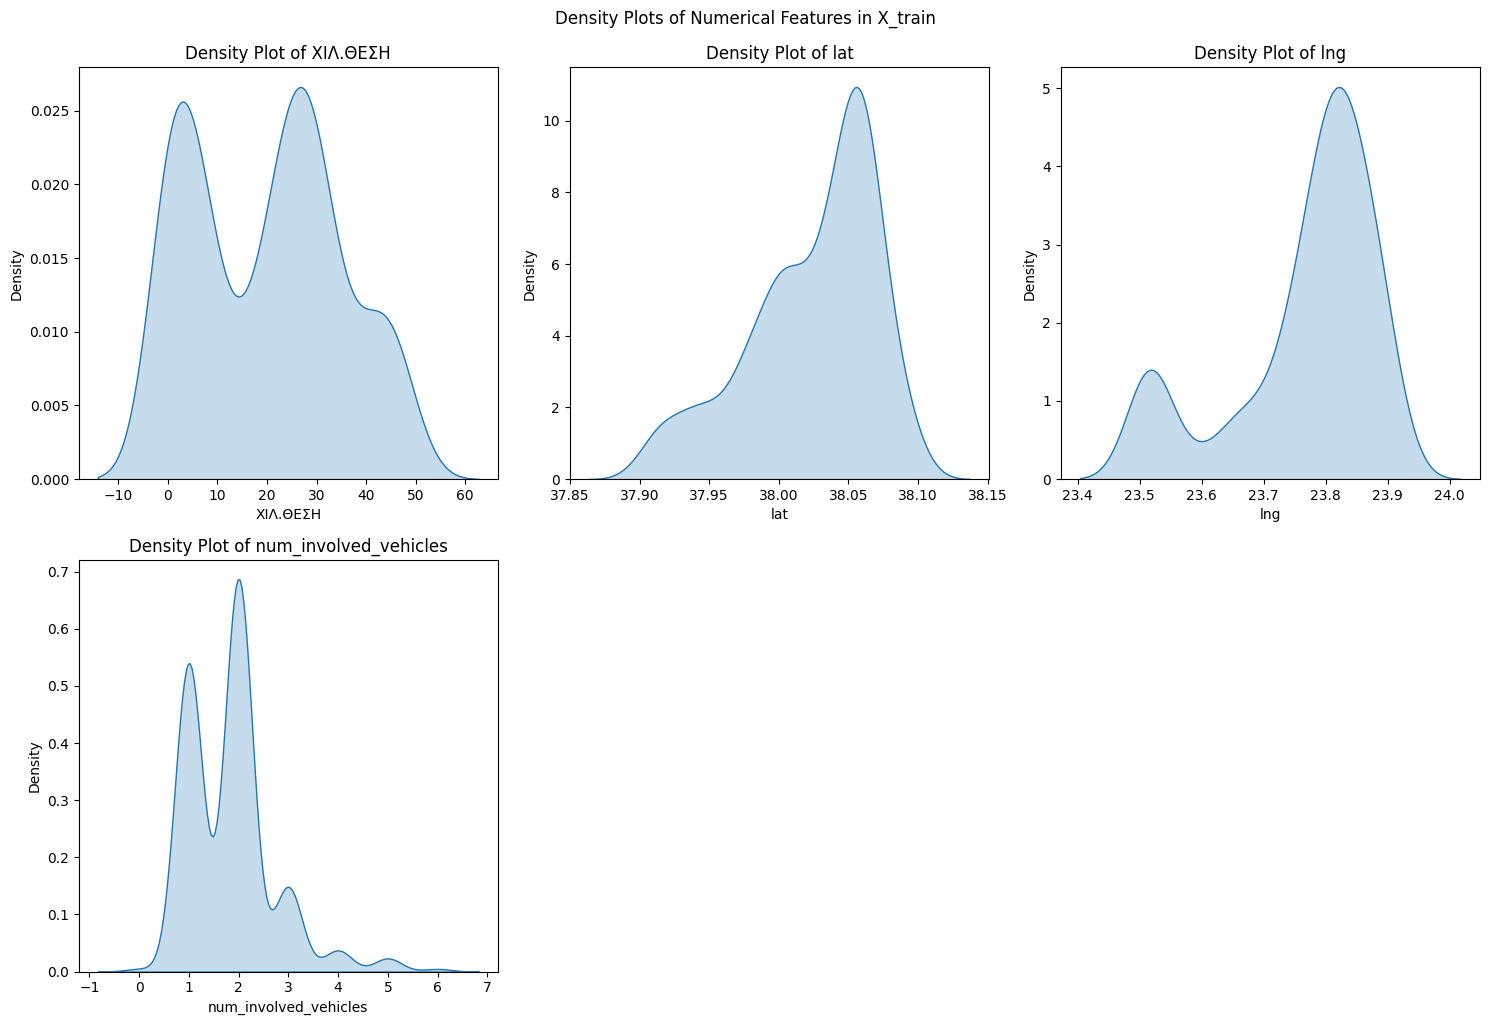

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Separate numerical and categorical features
numerical_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(include='object').columns

print("Numerical Features:", list(numerical_features))
print("Categorical Features:", list(categorical_features))

# Analyze distribution of numerical features
if len(numerical_features) > 0:
    X_train[numerical_features].hist(bins=30, figsize=(15, 10))
    plt.tight_layout()
    plt.suptitle('Histograms of Numerical Features in X_train', y=1.02)
    plt.show()

    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_features):
        plt.subplot(len(numerical_features) // 3 + 1, 3, i + 1)
        sns.kdeplot(X_train[col], fill=True)
        plt.title(f'Density Plot of {col}')
    plt.tight_layout()
    plt.suptitle('Density Plots of Numerical Features in X_train', y=1.02)
    plt.show()
else:
    print("No numerical features to plot.")

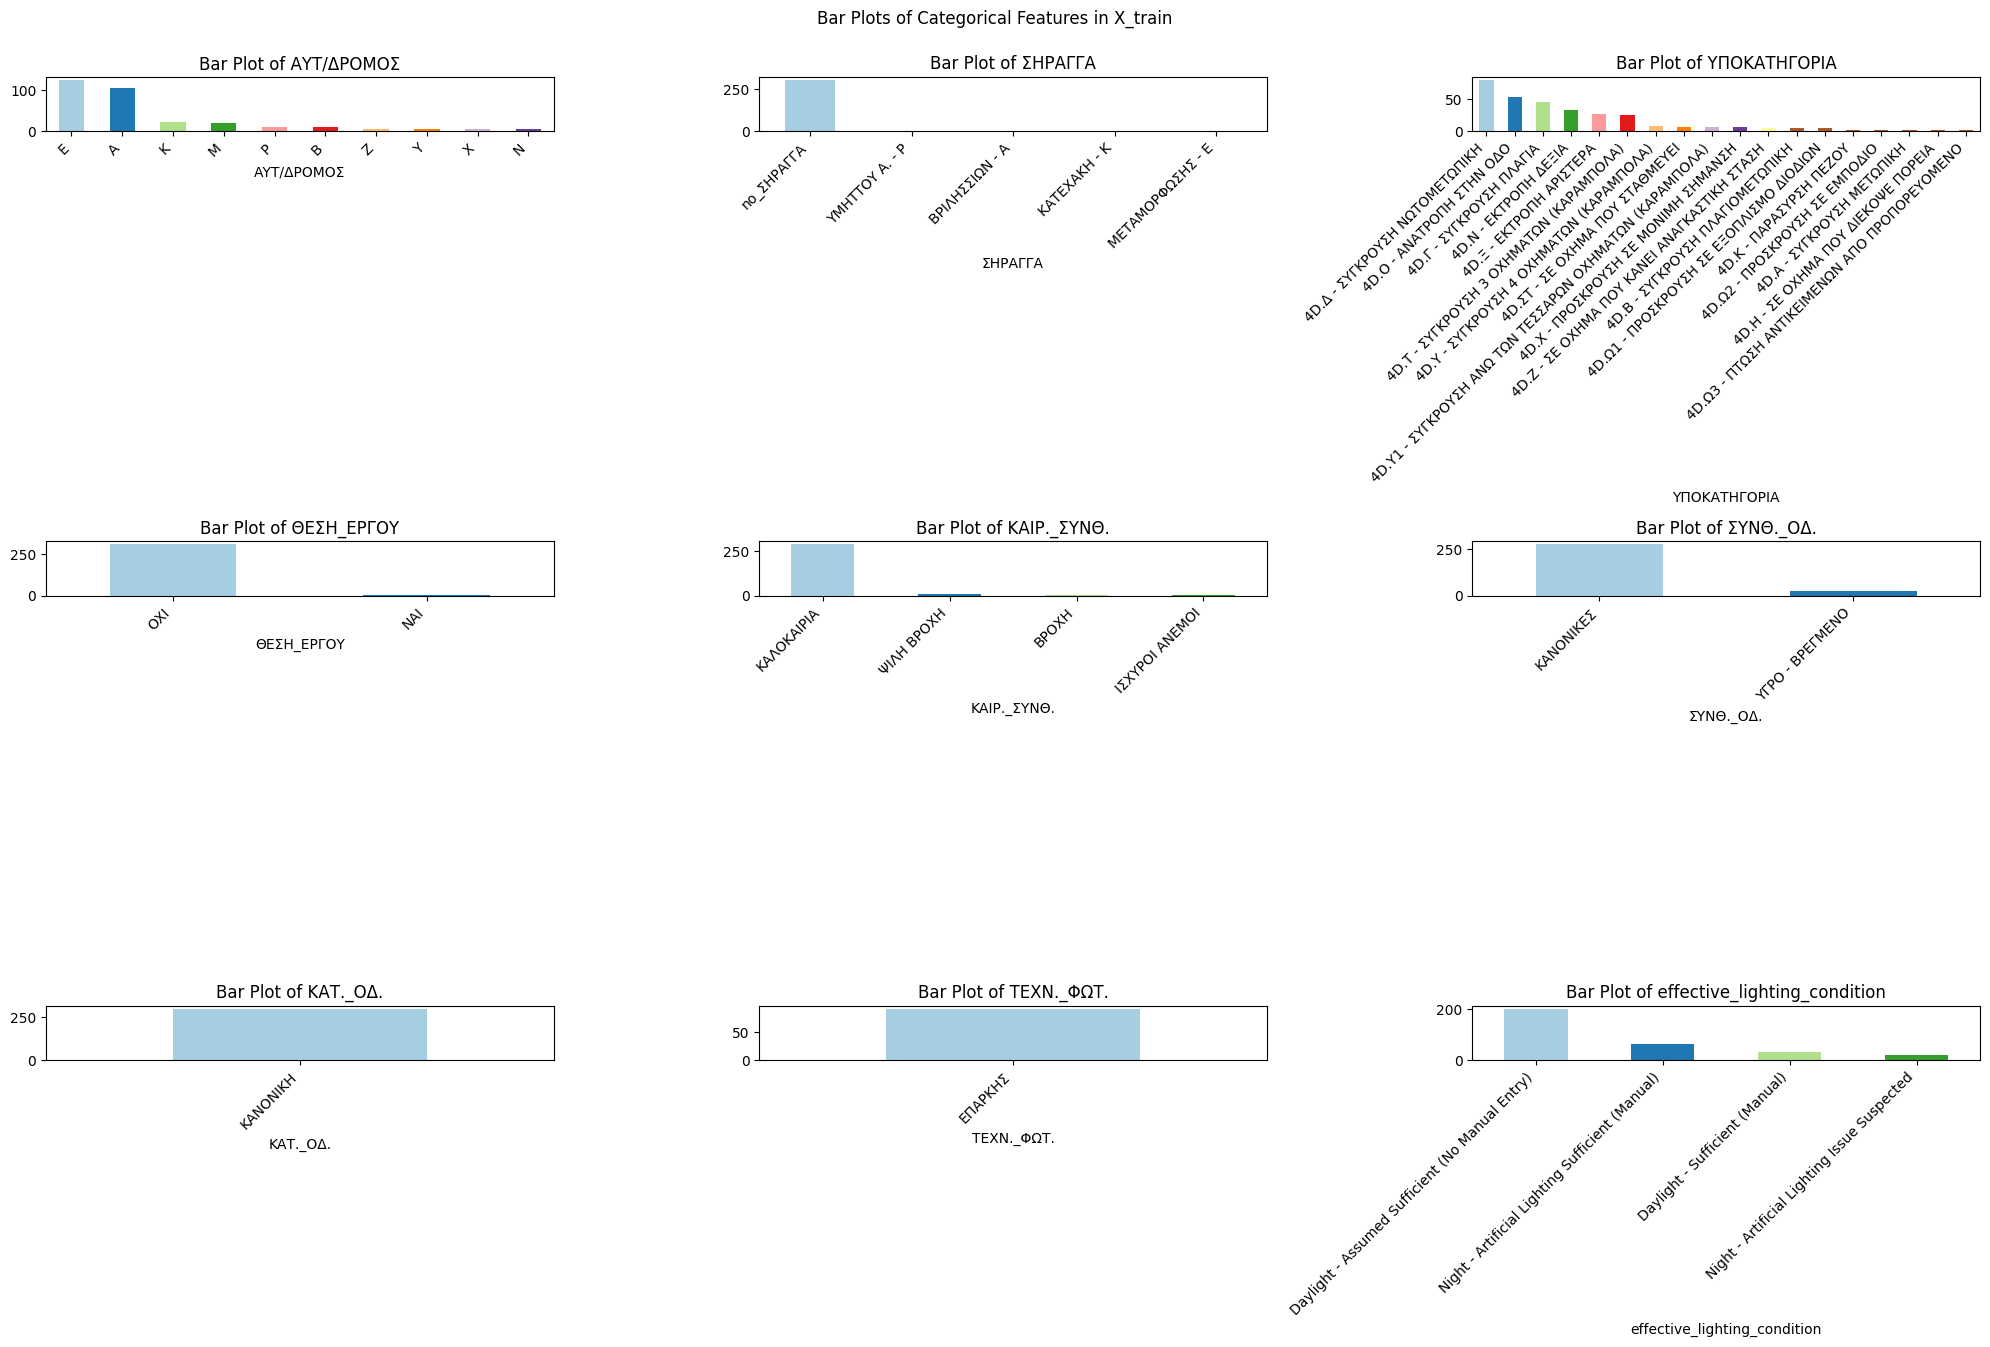

In [ ]:
# Analyze distribution of categorical features
if len(categorical_features) > 0:
    plt.figure(figsize=(20, 15))
    for i, col in enumerate(categorical_features):
        plt.subplot(len(categorical_features) // 3 + 1, 3, i + 1)
        X_train[col].value_counts().plot(kind='bar', color=plt.cm.Paired(np.arange(len(X_train[col].value_counts()))))
        plt.title(f'Bar Plot of {col}')
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.suptitle('Bar Plots of Categorical Features in X_train', y=1.02)
    plt.show()
else:
    print("No categorical features to plot.")

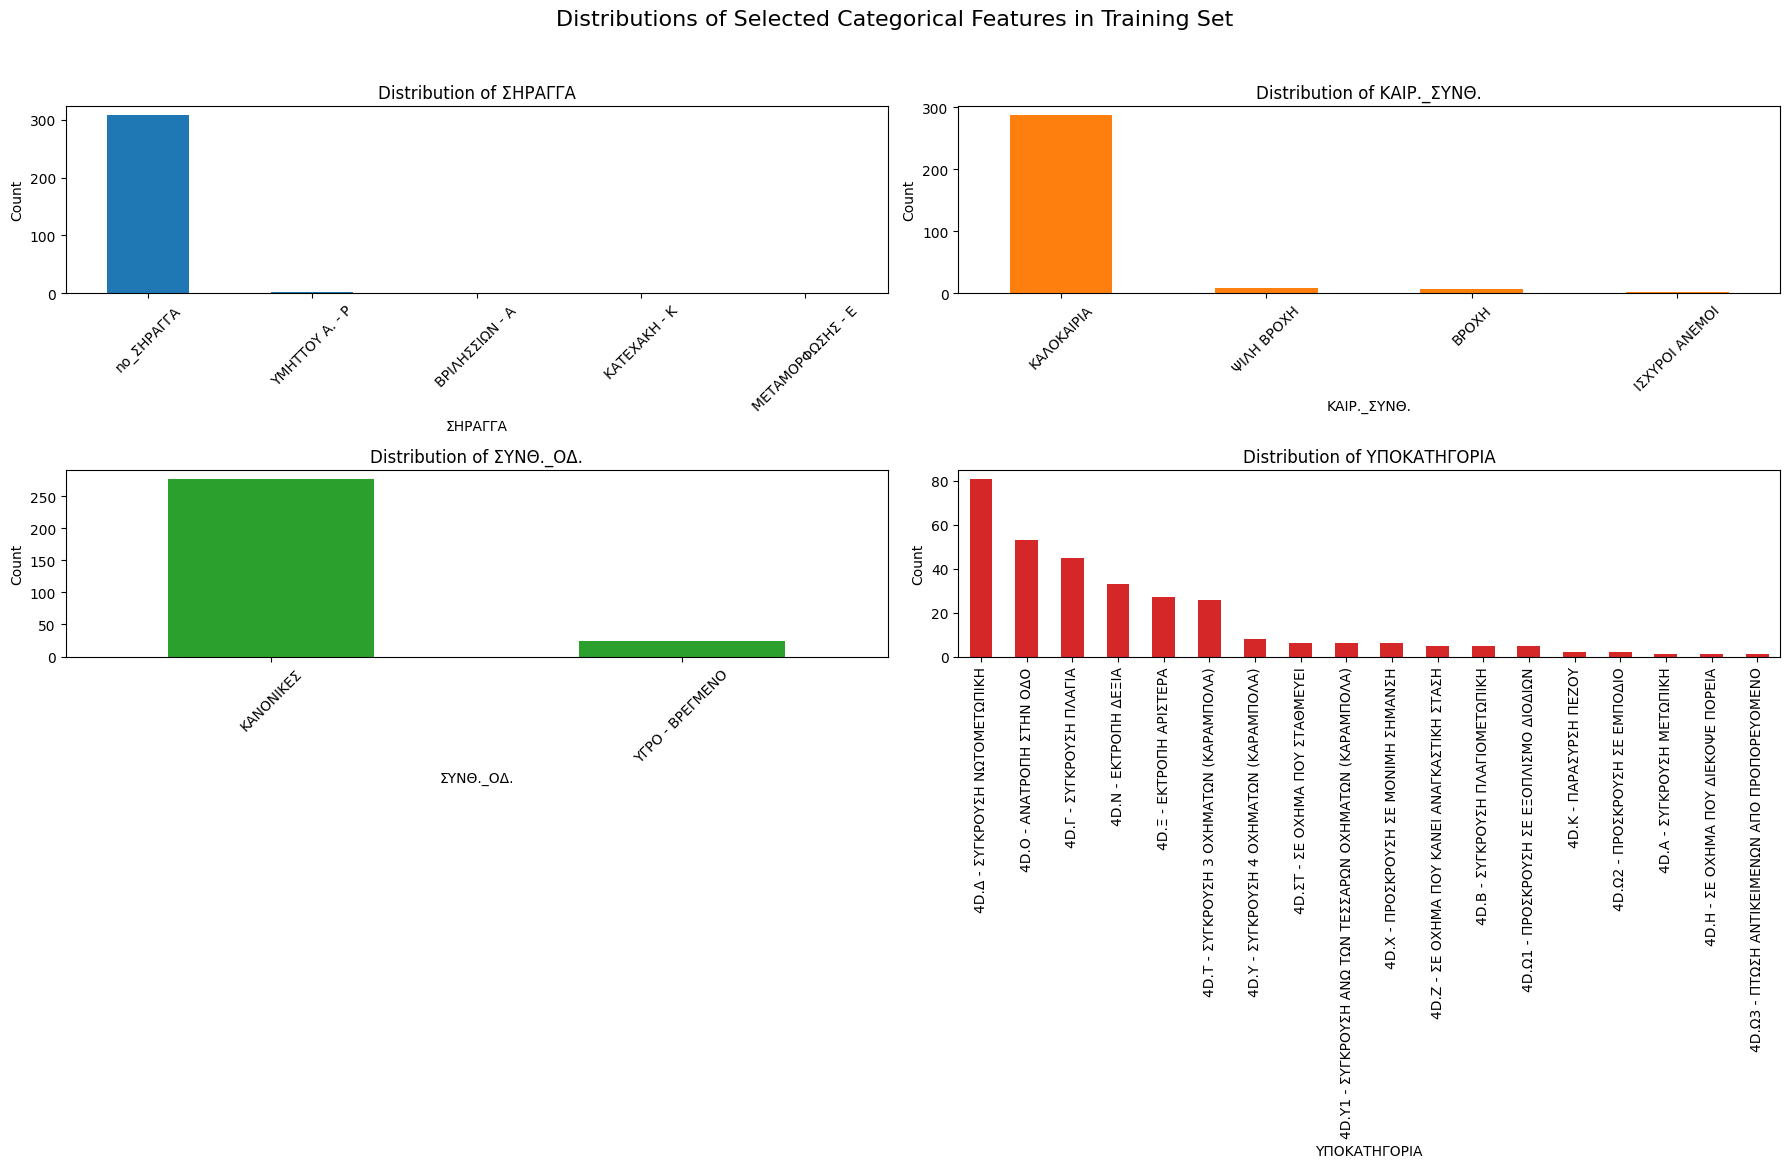

In [ ]:
# Single Canvas with Four Categorical Plots
features_to_plot_together = ['ΣΗΡΑΓΓΑ', 'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'ΥΠΟΚΑΤΗΓΟΡΙΑ']
valid_features_to_plot = [f for f in features_to_plot_together if f in X_train.columns]

if valid_features_to_plot:
    n_features = len(valid_features_to_plot)
    # Determine grid size (e.g., 2x2 for 4 plots)
    n_cols = 2
    n_rows = (n_features + n_cols - 1) // n_cols

    # Increased figure width to accommodate potential longer labels
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6)) # Adjusted figsize: increased width

    # Flatten the axes array if it's 2D, for easy iteration
    axes = axes.flatten() if n_rows > 1 else [axes]

    for i, feature in enumerate(valid_features_to_plot):
        ax = axes[i]
        X_train[feature].value_counts().plot(kind='bar', ax=ax, color=plt.cm.tab10(i)) # Use different colormap for each plot
        ax.set_title(f'Distribution of {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')

        # Adjust rotation specifically for the 'ΥΠΟΚΑΤΗΓΟΡΙΑ' plot if needed
        rotation_angle = 45 # Default rotation
        if feature == 'ΥΠΟΚΑΤΗΓΟΡΙΑ':
            rotation_angle = 90 # More vertical rotation for long labels

        ax.tick_params(axis='x', rotation=rotation_angle) # Apply the chosen rotation

    # Hide any unused subplots if n_features is less than n_rows * n_cols
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    fig.suptitle('Distributions of Selected Categorical Features in Training Set', fontsize=16, y=1.0)
    plt.show()
else:
    print("None of the specified categorical features were found in X_train.")

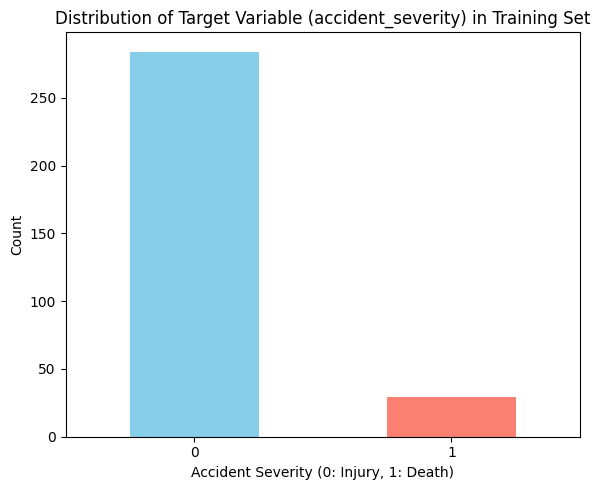

In [ ]:
# Bar Chart for Target Variable (accident_severity) Distribution
if 'y_train' in locals():
    plt.figure(figsize=(6, 5))
    y_train.value_counts().sort_index().plot(kind='bar', color=['skyblue', 'salmon']) # Assuming 0 and 1 as labels
    plt.title('Distribution of Target Variable (accident_severity) in Training Set')
    plt.xlabel('Accident Severity (0: Injury, 1: Death)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Target variable y_train not available.")

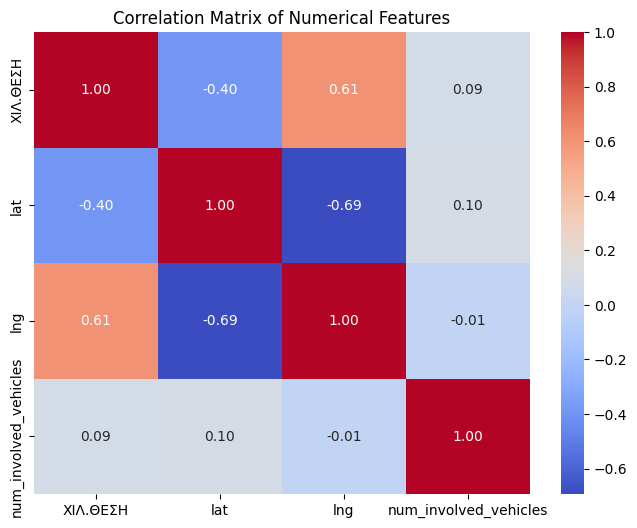

In [ ]:
# Analyze correlation between numerical features
if len(numerical_features) > 1:
    correlation_matrix = X_train[numerical_features].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()
else:
    print("Not enough numerical features to compute correlation matrix.")

## spatial engineering

In [ ]:
!pip install pygeohash -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.8 MB/s eta 0:00:00


In [ ]:
# You might need to install pygeohash:
# !pip install pygeohash sklearn

import pandas as pd
import numpy as np
import pygeohash # For geohashing
from sklearn.neighbors import KernelDensity # For KDE

# --- 1. Coordinate Binning Function ---
# (This function remains unchanged from your version)
def create_coordinate_bins(df, lat_col='lat', lng_col='lng', n_bins=10, fit_df=None):
    """
    Creates bins for latitude and longitude.
    fit_df: DataFrame to use for fitting bin edges (e.g., X_train).
            If None, df itself is used.
    """
    df_out = df.copy()
    fit_data = fit_df if fit_df is not None else df_out

    # Fit bins on training data (fit_df)
    # Ensure lat_col and lng_col are present and not all NaN in fit_data
    if fit_data[lat_col].isnull().all() or fit_data[lng_col].isnull().all():
        print(f"Warning: All values in {lat_col} or {lng_col} are NaN in fit_df. Binning may fail or be meaningless.")
        # Create dummy columns to prevent errors downstream, or handle as appropriate
        df_out[f'{lat_col}_bin_{n_bins}'] = -1
        df_out[f'{lng_col}_bin_{n_bins}'] = -1
        df_out[f'grid_cell_{n_bins}x{n_bins}'] = 'unknown_cell'
        return df_out

    _, lat_bin_edges = pd.cut(fit_data[lat_col].dropna(), bins=n_bins, labels=False, retbins=True, include_lowest=True, duplicates='drop')
    _, lng_bin_edges = pd.cut(fit_data[lng_col].dropna(), bins=n_bins, labels=False, retbins=True, include_lowest=True, duplicates='drop')

    df_out[f'{lat_col}_bin_{n_bins}'] = pd.cut(df_out[lat_col], bins=lat_bin_edges, labels=False, include_lowest=True)
    df_out[f'{lng_col}_bin_{n_bins}'] = pd.cut(df_out[lng_col], bins=lng_bin_edges, labels=False, include_lowest=True)

    # Combine into a single grid cell ID
    df_out[f'grid_cell_{n_bins}x{n_bins}'] = (
        df_out[f'{lat_col}_bin_{n_bins}'].astype(str) + "_" + df_out[f'{lng_col}_bin_{n_bins}'].astype(str)
    )
    # Handle potential NaNs from out-of-bounds or original NaNs
    df_out.fillna({f'{lat_col}_bin_{n_bins}':-1},inplace=True)
    df_out.fillna({f'{lng_col}_bin_{n_bins}':-1},inplace=True)

    # Robustly replace NaN combinations in the combined cell ID
    # Combinations like 'nan_-1.0', '-1.0_nan', 'nan_nan' can occur if original lat/lng were NaN
    # or if pd.cut resulted in NaN for some reason (e.g. value outside explicitly defined bin edges from training)
    df_out[f'grid_cell_{n_bins}x{n_bins}'] = df_out[f'grid_cell_{n_bins}x{n_bins}'].str.replace(r'.*_nan.*|nan_.*', 'unknown_cell', regex=True)
    df_out.fillna({f'grid_cell_{n_bins}x{n_bins}':'unknown_cell'},inplace=True)

    return df_out

# --- 2. Geohashing Function ---
# (This function remains unchanged from your version)
def apply_geohash(df, lat_col='lat', lng_col='lng', precision=7):
    df_out = df.copy()
    # Handle potential NaNs in lat/lng before applying geohash
    valid_coords_idx = df_out[[lat_col, lng_col]].dropna().index
    df_out.loc[valid_coords_idx, f'geohash_p{precision}'] = df_out.loc[valid_coords_idx].apply(
        lambda row: pygeohash.encode(row[lat_col], row[lng_col], precision=precision), axis=1
    )
    df_out.fillna({f'geohash_p{precision}':'unknown_geohash'},inplace=True)
    return df_out

# --- 3. KDE Score Function ---
# (This function remains unchanged from your version)
def apply_kde_score(df_to_score, df_fit_on, lat_col='lat', lng_col='lng', bandwidth=0.01):
    df_out = df_to_score.copy()
    # Ensure no NaNs in fitting data
    coords_fit = df_fit_on[[lat_col, lng_col]].dropna().values

    if coords_fit.shape[0] == 0:
        df_out['kde_score'] = 0.0 # Ensure float
        return df_out

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(coords_fit)

    # Ensure no NaNs in scoring data, score only valid coords
    valid_score_idx = df_out[[lat_col, lng_col]].dropna().index
    coords_score = df_out.loc[valid_score_idx, [lat_col, lng_col]].values

    df_out['kde_score'] = 0.0 # Initialize column
    if coords_score.shape[0] > 0:
        log_density_scores = kde.score_samples(coords_score)
        df_out.loc[valid_score_idx, 'kde_score'] = np.exp(log_density_scores)

    # df_out['kde_score'].fillna(0.0, inplace=True) # Fill if original lat/lng were NaN or for rows not scored
    df_out.fillna({'kde_score':0.0},inplace=True)
    return df_out

# --- 4. MODIFIED Combined Road-Kilometer Feature ---
def create_road_segment_feature_adjusted(df, road_col='ΑΥΤ/ΔΡΟΜΟΣ', km_col='ΧΙΛ.ΘΕΣΗ', prefix='segment'):
    df_out = df.copy()

    # Fill NaNs before converting to string, to ensure consistent string representation
    df_out[road_col] = df_out[road_col].fillna('UnknownRoad')
    # For km_col, fill NaNs, then convert to float (to handle "0", "0.0", "0.00" consistently) then to string for comparison
    # This handles cases where km_col might be object but contain numbers, or already float/int
    try:
        # Attempt to convert to numeric, coerce errors to NaN, then fill and convert to string
        km_numeric = pd.to_numeric(df_out[km_col], errors='coerce')
        # Check for 0.0. Be careful with float comparisons.
        # It's safer to convert to a string format that you can reliably check, AFTER numeric conversion.
        # For example, format to one decimal place string for comparison.
        # However, if the original data is '0.0' as a string, direct string comparison after fillna is simpler
        # Let's assume after .astype(str) later, '0.0' is the consistent representation.
        df_out[km_col] = df_out[km_col].fillna('UnknownKM').astype(str) # Original approach for string consistency
    except Exception: # Fallback if complex conversion fails
         df_out[km_col] = df_out[km_col].fillna('UnknownKM').astype(str)


    df_out[road_col] = df_out[road_col].astype(str) # Ensure road_col is also string

    # Default segment_id
    df_out[f'{prefix}_id'] = df_out[road_col] + "_" + df_out[km_col]

    # --- Specific adjustments for "A_0.0" and "E_0.0" ---
    # Create boolean masks for the conditions
    # Robust check for "0.0" (or "0", "0.00" etc. depending on your data's string format)
    # Assuming km_col after astype(str) will be '0.0' for these cases.
    # If it could be '0', you might need: (df_out[km_col] == '0.0') | (df_out[km_col] == '0')
    condition_A0 = (df_out[road_col] == 'A') & (df_out[km_col] == '0.0')
    condition_E0 = (df_out[road_col] == 'E') & (df_out[km_col] == '0.0')

    # Apply the new category
    df_out.loc[condition_A0, f'{prefix}_id'] = 'A_EntryZone_Or_UnknownKM'
    df_out.loc[condition_E0, f'{prefix}_id'] = 'E_EntryZone_Or_UnknownKM'

    return df_out

print("Spatial feature engineering functions defined (road segment function is adjusted).")

Spatial feature engineering functions defined (road segment function is adjusted).


In [ ]:
# Ensure X_train, X_val, X_test from the train_test_split of df_iter2 are available.
# Ensure all your spatial feature engineering functions are defined from the first code block.
# Make sure Counter from collections is imported for the downsampling part if you want to check counts.
from collections import Counter # If not already imported

if 'X_train' in locals() and 'lat' in X_train.columns and 'lng' in X_train.columns:
    N_BINS = 8
    GEOHASH_PRECISION = 7
    KDE_BANDWIDTH = 0.05 # You set this, and it will be passed to apply_kde_score

    print(f"\n--- Iteration X: Spatial Feature Engineering (with KDE Downsampling) ---")
    print(f"Original X_train shape before spatial eng: {X_train.shape}")


    # --- 1. Create Road Segment ID using the adjusted function ---
    # This function should be called first as 'segment_id' is used for downsampling KDE data.
    if 'ΑΥΤ/ΔΡΟΜΟΣ' in X_train.columns and 'ΧΙΛ.ΘΕΣΗ' in X_train.columns:
        X_train = create_road_segment_feature_adjusted(X_train)
        X_val = create_road_segment_feature_adjusted(X_val)
        X_test = create_road_segment_feature_adjusted(X_test)
        print("Adjusted road segment ID feature created.")
    else:
        print("Skipping road segment ID creation: Required columns not found.")
        # If segment_id cannot be created, KDE downsampling based on it cannot proceed as planned.
        # Add dummy 'segment_id' if it's critical for subsequent steps to not fail,
        # or ensure code handles its absence. For now, we assume it's created.
        if 'segment_id' not in X_train.columns: X_train['segment_id'] = 'unknown_segment'
        if 'segment_id' not in X_val.columns: X_val['segment_id'] = 'unknown_segment'
        if 'segment_id' not in X_test.columns: X_test['segment_id'] = 'unknown_segment'


    # --- Downsampling logic for KDE fitting data (from X_train) ---
    # This X_train now has 'segment_id', 'lat', 'lng'
    print("\nPreparing data for KDE model fitting with downsampling of high-frequency segments...")

    # Create a copy of X_train specifically for preparing the KDE fitting data
    # This copy should have 'segment_id', 'lat', 'lng'
    X_train_for_kde_fitting_preparation = X_train.copy()

    segments_to_downsample = [
        "A_EntryZone_Or_UnknownKM",
        "E_EntryZone_Or_UnknownKM",
        # Add other re-categorized "0.0" segments like M_0.0, K_0.0 if they become e.g.,
        # "M_EntryZone_Or_UnknownKM", "K_EntryZone_Or_UnknownKM" or whatever their segment_id is
    ]
    # To be more robust, you might identify these high-frequency segments dynamically
    # For example, any segment with more than X occurrences if you don't want to hardcode.
    # For now, using the hardcoded list based on prior observation.

    N_SAMPLES_PER_SEGMENT_FOR_KDE = 3 # Max samples from each high-frequency segment for KDE fit

    downsampled_dfs_for_kde = []
    other_dfs_for_kde = []

    # Ensure 'segment_id' exists before trying to use it for downsampling
    if 'segment_id' in X_train_for_kde_fitting_preparation.columns:
        # Check actual unique segment_id values to correctly identify M_0.0 and K_0.0 if they were not re-categorized
        # The create_road_segment_feature_adjusted re-categorizes A_0.0 and E_0.0.
        # If M_0.0 and K_0.0 become "M_0.0" and "K_0.0" as segment_id, add them to segments_to_downsample list.
        # Example: segments_to_downsample.extend(["M_0.0", "K_0.0"])

        print(f"Segments identified for potential downsampling in KDE: {segments_to_downsample}")
        print(f"Target samples per downsampled segment for KDE: {N_SAMPLES_PER_SEGMENT_FOR_KDE}")

        for segment_name in X_train_for_kde_fitting_preparation['segment_id'].unique():
            segment_df = X_train_for_kde_fitting_preparation[X_train_for_kde_fitting_preparation['segment_id'] == segment_name]
            if segment_name in segments_to_downsample:
                if len(segment_df) > N_SAMPLES_PER_SEGMENT_FOR_KDE:
                    downsampled_dfs_for_kde.append(segment_df.sample(N_SAMPLES_PER_SEGMENT_FOR_KDE, random_state=42))
                    print(f"Downsampled segment '{segment_name}' from {len(segment_df)} to {N_SAMPLES_PER_SEGMENT_FOR_KDE} for KDE fitting.")
                else:
                    downsampled_dfs_for_kde.append(segment_df) # Keep all if less than N
                    print(f"Segment '{segment_name}' has {len(segment_df)} samples (<=N), keeping all for KDE fitting.")
            else:
                other_dfs_for_kde.append(segment_df)

        temp_concat_list = downsampled_dfs_for_kde + other_dfs_for_kde
        if temp_concat_list: # Ensure list is not empty before concat
            X_train_data_for_kde_fit = pd.concat(temp_concat_list)
            print(f"Shape of data used to FIT KDE model after downsampling: {X_train_data_for_kde_fit.shape}")
        else:
            print("Warning: No data selected for KDE fitting after downsampling attempt. Using original X_train for KDE fitting.")
            X_train_data_for_kde_fit = X_train_for_kde_fitting_preparation # Fallback
    else:
        print("Warning: 'segment_id' column not found in X_train. Skipping downsampling for KDE. Using original X_train for KDE fitting.")
        X_train_data_for_kde_fit = X_train_for_kde_fitting_preparation # Fallback

    # Now, X_train_coords_for_kde should be derived from this potentially downsampled DataFrame
    if 'lat' in X_train_data_for_kde_fit.columns and 'lng' in X_train_data_for_kde_fit.columns:
        X_train_coords_for_kde_fitting = X_train_data_for_kde_fit[['lat', 'lng']].dropna()
    else:
        print("Warning: lat/lng not in X_train_data_for_kde_fit. KDE might fail or be inaccurate.")
        X_train_coords_for_kde_fitting = pd.DataFrame(columns=['lat','lng']) # Empty DF to prevent error


    # --- Apply Coordinate Binning ---
    # Uses X_train (original training split for this iter, now with segment_id) for fit_df
    if 'lat' in X_train.columns and 'lng' in X_train.columns:
        X_train = create_coordinate_bins(X_train, n_bins=N_BINS, fit_df=X_train.copy())
        X_val = create_coordinate_bins(X_val, n_bins=N_BINS, fit_df=X_train.copy())
        X_test = create_coordinate_bins(X_test, n_bins=N_BINS, fit_df=X_train.copy())
        print(f"Coordinate bins ({N_BINS}x{N_BINS}) created.")
    else:
        print("Skipping coordinate binning: lat/lng columns not found in X_train (after segment_id creation).")

    # --- Apply Geohashing ---
    if 'lat' in X_train.columns and 'lng' in X_train.columns:
        X_train = apply_geohash(X_train, precision=GEOHASH_PRECISION)
        X_val = apply_geohash(X_val, precision=GEOHASH_PRECISION)
        X_test = apply_geohash(X_test, precision=GEOHASH_PRECISION)
        print(f"Geohash (precision {GEOHASH_PRECISION}) features created.")
    else:
        print("Skipping geohashing: lat/lng columns not found.")


    # --- Apply KDE Score ---
    # The KDE model is FIT using X_train_coords_for_kde_fitting (from downsampled data)
    # Then, this fitted KDE model is used to SCORE the original X_train, X_val, X_test (which still have all their rows)
    if not X_train_coords_for_kde_fitting.empty and \
       all(col in X_train.columns for col in ['lat','lng']) and \
       all(col in X_val.columns for col in ['lat','lng']) and \
       all(col in X_test.columns for col in ['lat','lng']):

        print(f"Fitting KDE model using data of shape: {X_train_coords_for_kde_fitting.shape}")
        X_train = apply_kde_score(X_train, X_train_coords_for_kde_fitting, bandwidth=KDE_BANDWIDTH)
        X_val = apply_kde_score(X_val, X_train_coords_for_kde_fitting, bandwidth=KDE_BANDWIDTH)
        X_test = apply_kde_score(X_test, X_train_coords_for_kde_fitting, bandwidth=KDE_BANDWIDTH)
        # fillna for kde_score is now inside apply_kde_score function
        print("KDE scores created (KDE model fit on potentially downsampled training data).")
    else:
        print("Skipping KDE score creation: Not enough valid coordinates for fitting KDE or lat/lng missing in X_train/X_val/X_test.")
        X_train['kde_score'] = 0.0
        X_val['kde_score'] = 0.0
        X_test['kde_score'] = 0.0

    # Display some of the new features
    new_spatial_cols = []
    if f'grid_cell_{N_BINS}x{N_BINS}' in X_train.columns: new_spatial_cols.append(f'grid_cell_{N_BINS}x{N_BINS}')
    if f'geohash_p{GEOHASH_PRECISION}' in X_train.columns: new_spatial_cols.append(f'geohash_p{GEOHASH_PRECISION}')
    if 'kde_score' in X_train.columns: new_spatial_cols.append('kde_score')
    if 'segment_id' in X_train.columns: new_spatial_cols.append('segment_id')

    new_spatial_cols = [col for col in new_spatial_cols if col in X_train.columns] # Should not be necessary if checks above are fine
    if new_spatial_cols:
        print("\nSample of new spatial features in X_train (post all spatial engineering):")
        try:
            display(X_train[new_spatial_cols].head())
        except NameError:
            print(X_train[new_spatial_cols].head())
    else:
        print("\nNo new spatial features were available to display.")
else:
    print("Skipping spatial feature engineering: Initial X_train or lat/lng columns not found.")


--- Iteration X: Spatial Feature Engineering (with KDE Downsampling) ---
Original X_train shape before spatial eng: (313, 20)
Adjusted road segment ID feature created.

Preparing data for KDE model fitting with downsampling of high-frequency segments...
Segments identified for potential downsampling in KDE: ['A_EntryZone_Or_UnknownKM', 'E_EntryZone_Or_UnknownKM']
Target samples per downsampled segment for KDE: 3
Downsampled segment 'A_EntryZone_Or_UnknownKM' from 15 to 3 for KDE fitting.
Downsampled segment 'E_EntryZone_Or_UnknownKM' from 17 to 3 for KDE fitting.
Shape of data used to FIT KDE model after downsampling: (287, 21)
Coordinate bins (8x8) created.
Geohash (precision 7) features created.
Fitting KDE model using data of shape: (287, 2)
KDE scores created (KDE model fit on potentially downsampled training data).

Sample of new spatial features in X_train (post all spatial engineering):


grid_cell_8x8 geohash_p7  kde_score                segment_id
262           6_4    swbbef4  15.335487                    A_20.6
177           5_6    swbbmuw  30.473386                    A_29.6
419           6_0    swb8x1r   3.507809                     E_1.0
256           6_0    swb8x04   3.269787  A_EntryZone_Or_UnknownKM
483           0_7    sw8zxwp  10.152196                    A_46.7

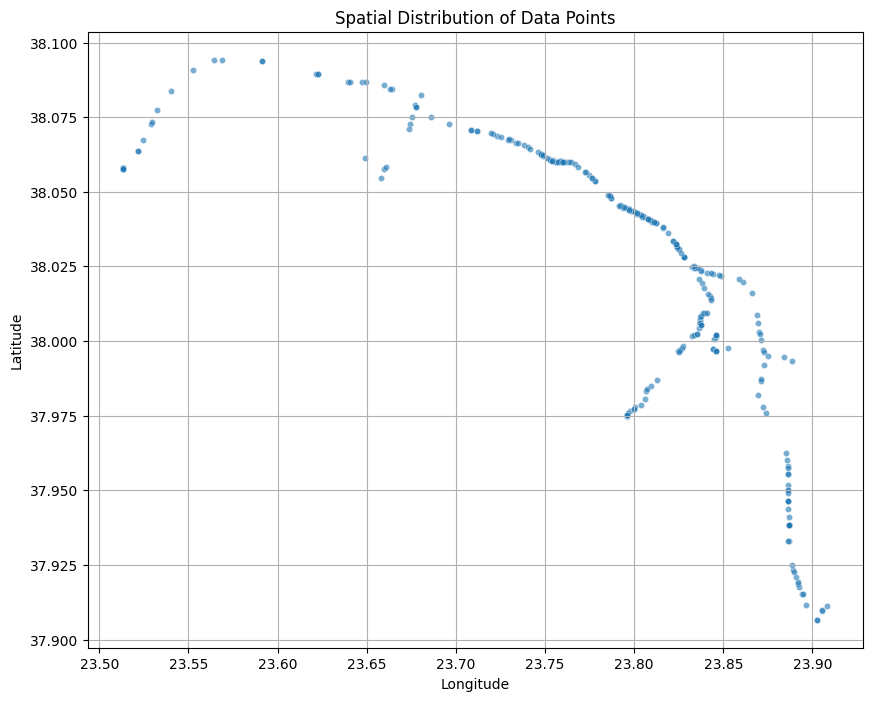

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train has the required columns
# Use a small sample if the dataset is very large for faster plotting
sample_df = X_train.sample(n=500, random_state=42) if X_train.shape[0] > 500 else X_train.copy()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=sample_df, x='lng', y='lat', s=20, alpha=0.6, legend=False)
plt.title('Spatial Distribution of Data Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

Highlighting points for common geohashes: ['swb8x01', 'swb8x04', 'swbbj3p', 'swbbnqv', 'sw8zzd3']


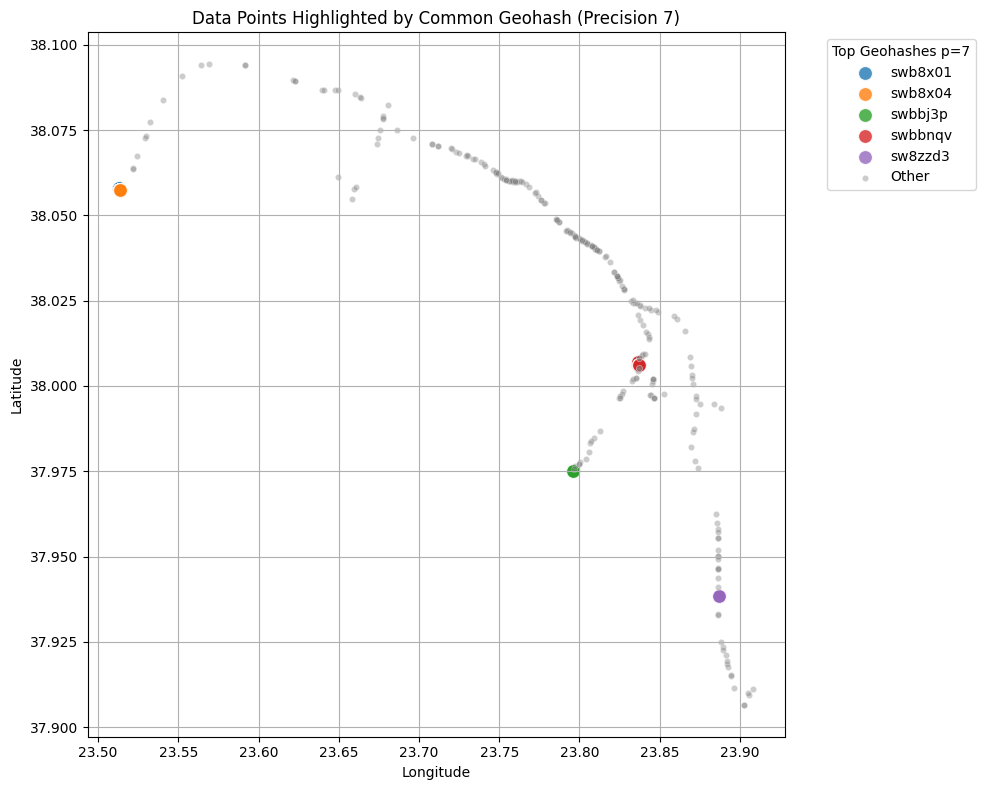

In [ ]:
# Assuming GEOHASH_PRECISION is defined (e.g., GEOHASH_PRECISION = 7)
if f'geohash_p{GEOHASH_PRECISION}' in sample_df.columns:
    plt.figure(figsize=(10, 8))

    # Option 1: Scatter plot colored by Geohash (can be cluttered)
    # sns.scatterplot(data=sample_df, x='lng', y='lat', hue=f'geohash_p{GEOHASH_PRECISION}',
    #                 s=50, alpha=0.7, palette='viridis', legend=False)

    # Option 2: Highlight points for a few common Geohashes
    # Find some common geohashes
    common_geohashes = sample_df[f'geohash_p{GEOHASH_PRECISION}'].value_counts().nlargest(5).index.tolist()
    print(f"Highlighting points for common geohashes: {common_geohashes}")

    for i, gh in enumerate(common_geohashes):
        subset_df = sample_df[sample_df[f'geohash_p{GEOHASH_PRECISION}'] == gh]
        sns.scatterplot(data=subset_df, x='lng', y='lat', s=100, alpha=0.8, label=gh,
                        color=plt.cm.tab10(i % 10)) # Use different colors

    # Plot other points as a background
    other_points_df = sample_df[~sample_df[f'geohash_p{GEOHASH_PRECISION}'].isin(common_geohashes)]
    sns.scatterplot(data=other_points_df, x='lng', y='lat', s=20, alpha=0.4, color='gray', label='Other')

    plt.title(f'Data Points Highlighted by Common Geohash (Precision {GEOHASH_PRECISION})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title=f'Top Geohashes p={GEOHASH_PRECISION}', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout() # Adjust layout to make space for legend
    plt.show()

Highlighting points for common segments: ['K_0.0', 'M_0.0', 'E_44.0', 'M_5.3', 'E_30.5']


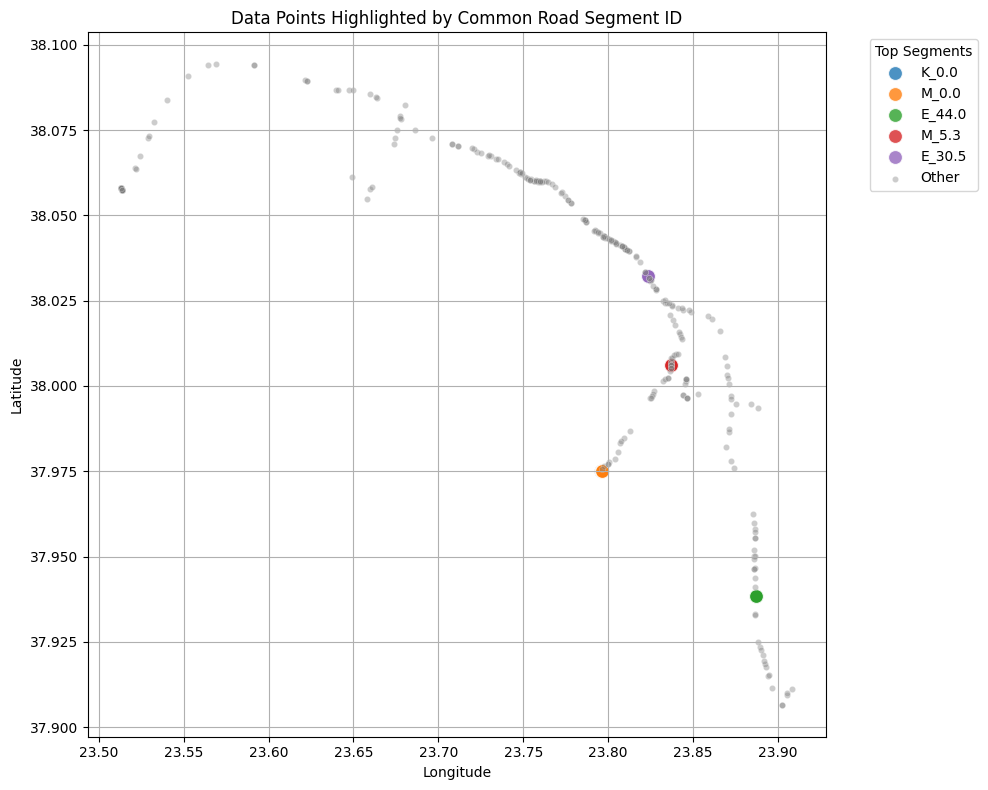

In [ ]:
# Assuming 'segment_id' is the column name created
if 'segment_id' in sample_df.columns:
    plt.figure(figsize=(10, 8))

    # Find some common segment IDs (excluding 'UnknownRoad_UnknownKM' if applicable)
    segment_counts = sample_df['segment_id'].value_counts()
    # Exclude 'UnknownRoad_UnknownKM' and take the next top N
    common_segments = segment_counts[~segment_counts.index.str.contains('Unknown')].nlargest(5).index.tolist()
    print(f"Highlighting points for common segments: {common_segments}")


    for i, segment in enumerate(common_segments):
        subset_df = sample_df[sample_df['segment_id'] == segment]
        sns.scatterplot(data=subset_df, x='lng', y='lat', s=100, alpha=0.8, label=segment,
                        color=plt.cm.tab10(i % 10)) # Use different colors

    # Plot other points as a background
    other_points_df = sample_df[~sample_df['segment_id'].isin(common_segments)]
    sns.scatterplot(data=other_points_df, x='lng', y='lat', s=20, alpha=0.4, color='gray', label='Other')


    plt.title('Data Points Highlighted by Common Road Segment ID')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title='Top Segments', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

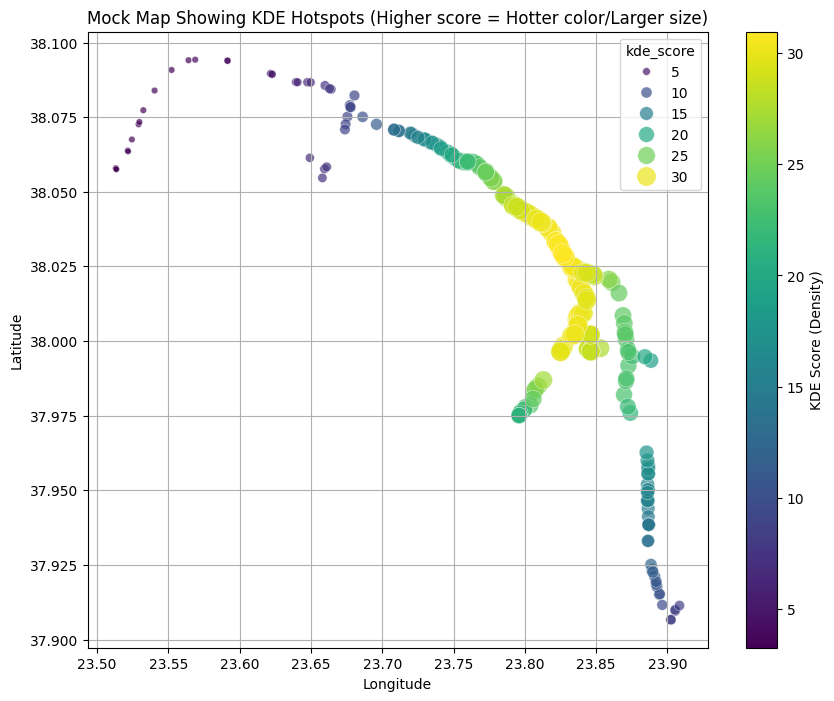

In [ ]:
# Assuming 'kde_score' is available in X_train
if 'kde_score' in X_train.columns:
    plt.figure(figsize=(10, 8))

    # Use a sample again for performance
    sample_df_kde = X_train.sample(n=500, random_state=42).copy() if X_train.shape[0] > 500 else X_train.copy()

    # Plotting with color representing KDE score
    # Use a colormap that shows intensity
    # Get the current axes
    ax = plt.gca()
    scatter = sns.scatterplot(data=sample_df_kde, x='lng', y='lat', hue='kde_score',
                              palette='viridis', # Changed colormap
                              size='kde_score', sizes=(20, 200), # Optional: vary size as well
                              alpha=0.7, legend='brief', ax=ax) # Ensure scatterplot uses the current axes

    plt.title('Mock Map Showing KDE Hotspots (Higher score = Hotter color/Larger size)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

    # Add a colorbar to explain the KDE score mapping
    norm = plt.Normalize(sample_df_kde['kde_score'].min(), sample_df_kde['kde_score'].max())
    # Make sure the colormap here matches the scatterplot palette
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([]) # Dummy array for the colorbar
    # Pass the axes object (ax) to the colorbar function
    plt.colorbar(sm, label='KDE Score (Density)', ax=ax)

    plt.show()

In [ ]:
# Assuming 'segment_id' was created in the previous spatial engineering step
if 'segment_id' in X_train.columns:
    # Calculate the value counts for the 'segment_id' column
    segment_counts = X_train['segment_id'].value_counts()

    # Convert the result to a DataFrame for better display and potential further use
    segment_counts_df = segment_counts.reset_index()

    # Rename the columns for clarity
    segment_counts_df.columns = ['segment_id', 'occurrence_count']

    print("\nOccurrence count for each road segment in X_train:")
    # Display the resulting DataFrame
    display(segment_counts_df)
else:
    print("The 'segment_id' column was not found in X_train. Skipping segment count analysis.")


Occurrence count for each road segment in X_train:


segment_id  occurrence_count
0    E_EntryZone_Or_UnknownKM                17
1    A_EntryZone_Or_UnknownKM                15
2                       K_0.0                 6
3                       M_0.0                 6
4                      E_44.0                 6
..                        ...               ...
217                    A_42.8                 1
218                    E_27.5                 1
219                    E_32.6                 1
220                    A_41.3                 1
221                    N_16.5                 1

[222 rows x 2 columns]

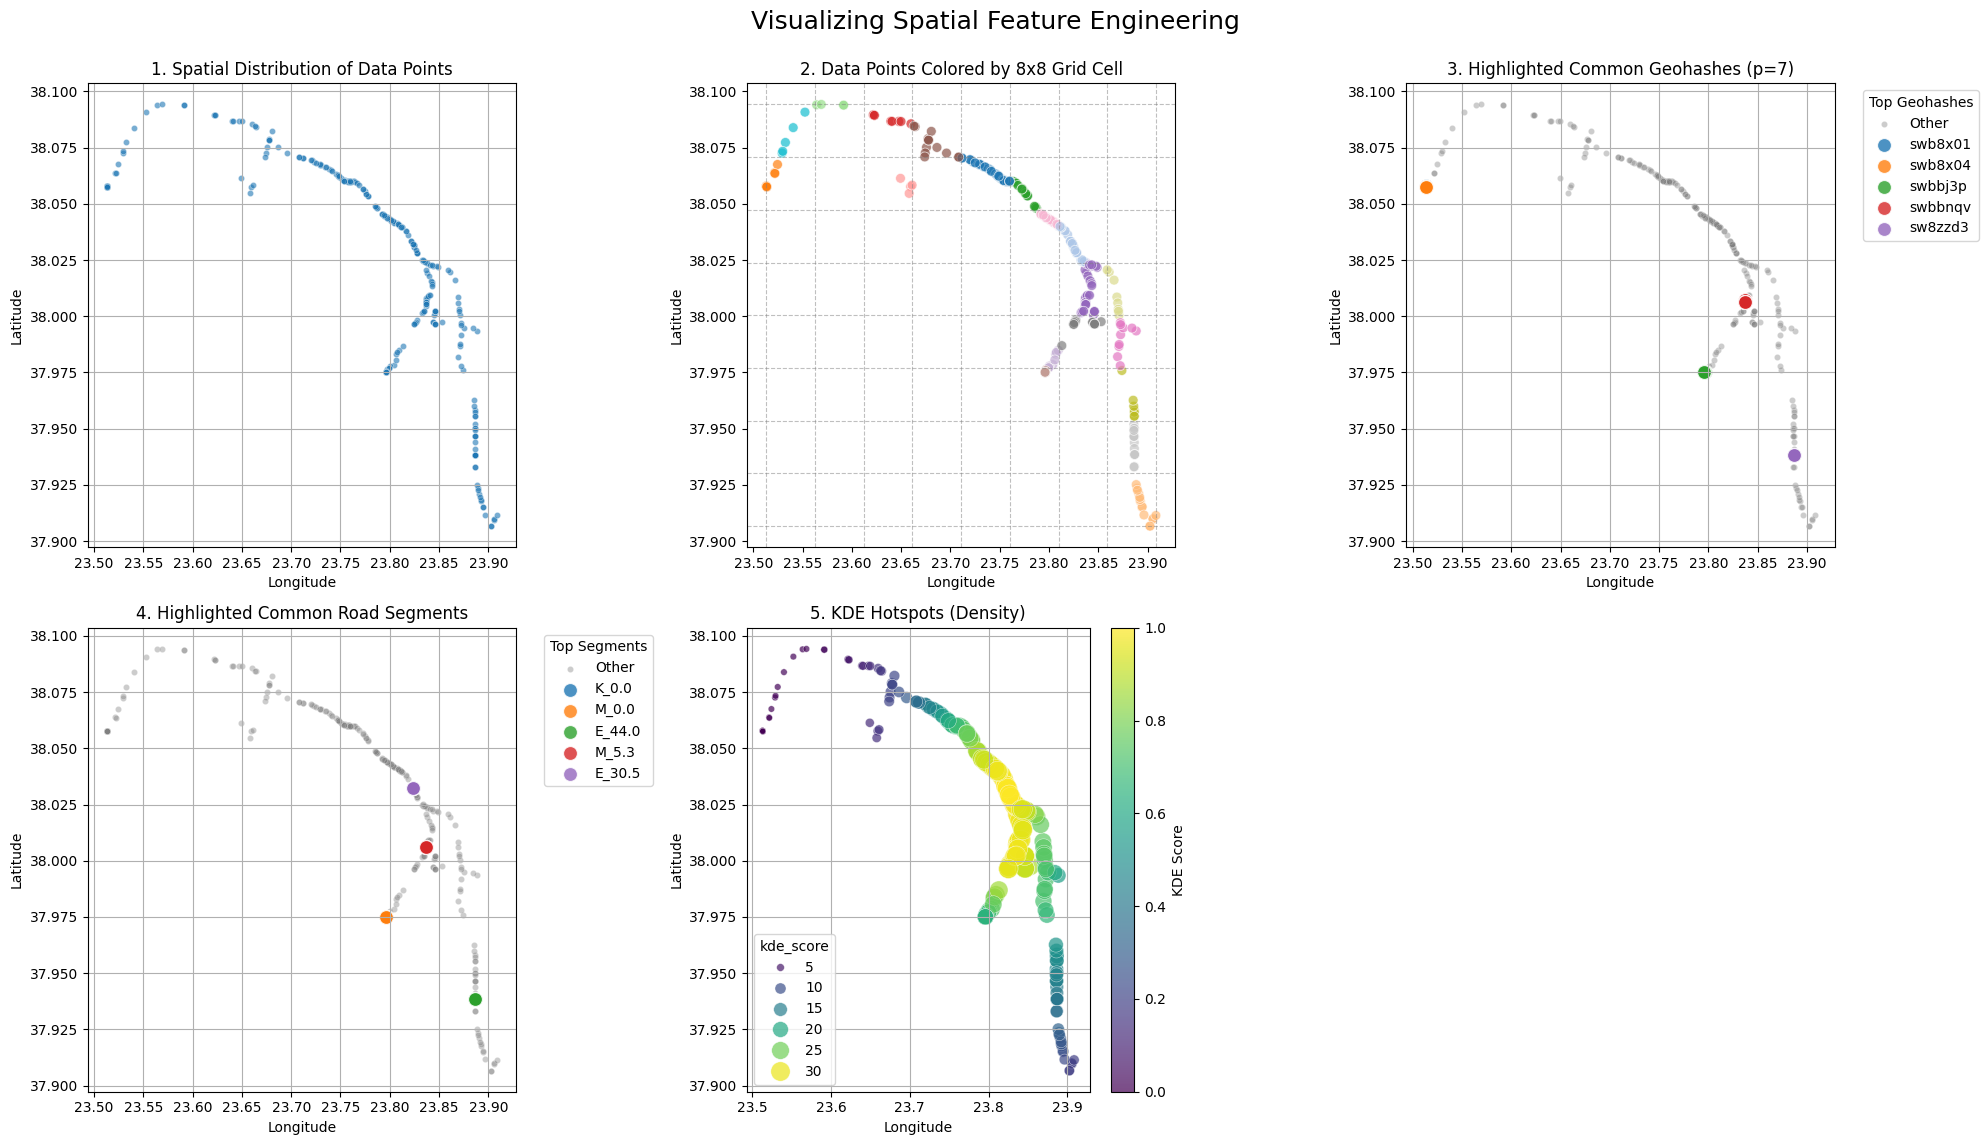

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming X_train has the required columns and spatial features are created
# Use a small sample if the dataset is very large for faster plotting
sample_df = X_train.sample(n=500, random_state=42).copy() if X_train.shape[0] > 500 else X_train.copy()

# Define the layout: 2 rows, 3 columns
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12)) # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Counter for subplots
plot_index = 0

# --- 1. Base Spatial Distribution ---
ax = axes[plot_index]
sns.scatterplot(data=sample_df, x='lng', y='lat', s=20, alpha=0.6, legend=False, ax=ax)
ax.set_title('1. Spatial Distribution of Data Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True)
plot_index += 1

# --- 2. Grid Cell Discretization ---
# Assuming N_BINS is defined (e.g., N_BINS = 8)
if f'grid_cell_{N_BINS}x{N_BINS}' in sample_df.columns:
    ax = axes[plot_index]
    sns.scatterplot(data=sample_df, x='lng', y='lat', hue=f'grid_cell_{N_BINS}x{N_BINS}',
                    s=50, alpha=0.7, palette='tab20', legend=False, ax=ax)

    # Optional: Overlay grid lines (approximate based on data range)
    min_lat, max_lat = sample_df['lat'].min(), sample_df['lat'].max()
    min_lng, max_lng = sample_df['lng'].min(), sample_df['lng'].max()
    lat_bins = np.linspace(min_lat, max_lat, N_BINS + 1)
    lng_bins = np.linspace(min_lng, max_lng, N_BINS + 1)

    for l in lat_bins:
        ax.axhline(y=l, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    for l in lng_bins:
        ax.axvline(x=l, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

    ax.set_title(f'2. Data Points Colored by {N_BINS}x{N_BINS} Grid Cell')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(False)
    plot_index += 1
else:
    print("Skipping Grid Cell plot: Feature not found.")

# --- 3. Geohash Discretization (Highlighting Common) ---
# Assuming GEOHASH_PRECISION is defined (e.g., GEOHASH_PRECISION = 7)
if f'geohash_p{GEOHASH_PRECISION}' in sample_df.columns:
    ax = axes[plot_index]

    # Find some common geohashes
    common_geohashes = sample_df[f'geohash_p{GEOHASH_PRECISION}'].value_counts().nlargest(5).index.tolist()

    # Plot other points as a background
    other_points_df = sample_df[~sample_df[f'geohash_p{GEOHASH_PRECISION}'].isin(common_geohashes)]
    sns.scatterplot(data=other_points_df, x='lng', y='lat', s=20, alpha=0.4, color='gray', label='Other', ax=ax)

    for i, gh in enumerate(common_geohashes):
        subset_df = sample_df[sample_df[f'geohash_p{GEOHASH_PRECISION}'] == gh]
        sns.scatterplot(data=subset_df, x='lng', y='lat', s=100, alpha=0.8, label=gh,
                        color=plt.cm.tab10(i % 10), ax=ax) # Use different colors

    ax.set_title(f'3. Highlighted Common Geohashes (p={GEOHASH_PRECISION})')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # Place legend outside the plot for better readability
    ax.legend(title=f'Top Geohashes', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)
    plot_index += 1
else:
    print("Skipping Geohash plot: Feature not found.")


# --- 4. Road Segment Discretization (Highlighting Common) ---
# Assuming 'segment_id' is the column name created
if 'segment_id' in sample_df.columns:
    ax = axes[plot_index]

    # Find some common segment IDs (excluding 'UnknownRoad_UnknownKM' if applicable)
    segment_counts = sample_df['segment_id'].value_counts()
    common_segments = segment_counts[~segment_counts.index.str.contains('Unknown')].nlargest(5).index.tolist()

    # Plot other points as a background
    other_points_df = sample_df[~sample_df['segment_id'].isin(common_segments)]
    sns.scatterplot(data=other_points_df, x='lng', y='lat', s=20, alpha=0.4, color='gray', label='Other', ax=ax)

    for i, segment in enumerate(common_segments):
        subset_df = sample_df[sample_df['segment_id'] == segment]
        sns.scatterplot(data=subset_df, x='lng', y='lat', s=100, alpha=0.8, label=segment,
                        color=plt.cm.tab10(i % 10), ax=ax) # Use different colors

    ax.set_title('4. Highlighted Common Road Segments')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # Place legend outside the plot
    ax.legend(title='Top Segments', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)
    plot_index += 1
else:
    print("Skipping Road Segment plot: Feature not found.")

# --- 5. KDE Hotspots (Mock Map) ---
# Assuming 'kde_score' is available
if 'kde_score' in sample_df.columns:
    ax = axes[plot_index]

    scatter = sns.scatterplot(data=sample_df, x='lng', y='lat', hue='kde_score',
                              palette='viridis', # Example colormap
                              size='kde_score', sizes=(20, 200),
                              alpha=0.7, legend='brief', ax=ax) # Plot on the current axes

    ax.set_title('5. KDE Hotspots (Density)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)

    # Add a colorbar to this specific subplot's axes
    norm = plt.Normalize(sample_df['kde_score'].min(), sample_df['kde_score'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    # Specify the axes for the colorbar using the 'ax' argument of scatterplot
    # Or more directly using the mappable as before, but linked to the subplot ax
    fig.colorbar(scatter.collections[0], ax=ax, label='KDE Score') # Use fig.colorbar and link to ax

    plot_index += 1
else:
    print("Skipping KDE plot: Feature not found.")

# --- Remove any unused subplots ---
for j in range(plot_index, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent titles/labels overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle
fig.suptitle('Visualizing Spatial Feature Engineering', fontsize=18, y=0.98) # Add a main title

plt.show()

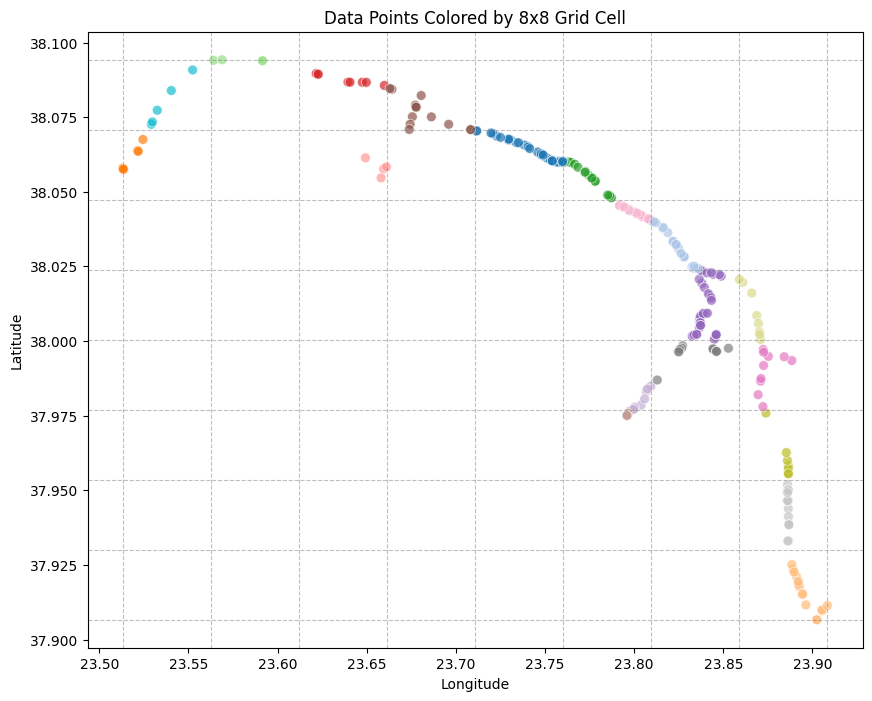

In [ ]:
# Assuming N_BINS is defined (e.g., N_BINS = 8)
if f'grid_cell_{N_BINS}x{N_BINS}' in sample_df.columns:
    plt.figure(figsize=(10, 8))
    # Color-coding points by grid cell
    sns.scatterplot(data=sample_df, x='lng', y='lat', hue=f'grid_cell_{N_BINS}x{N_BINS}',
                    s=50, alpha=0.7, palette='tab20', legend=False) # Use a suitable palette

    # Optional: Overlay grid lines (approximate based on data range)
    min_lat, max_lat = sample_df['lat'].min(), sample_df['lat'].max()
    min_lng, max_lng = sample_df['lng'].min(), sample_df['lng'].max()
    lat_bins = np.linspace(min_lat, max_lat, N_BINS + 1)
    lng_bins = np.linspace(min_lng, max_lng, N_BINS + 1)

    for l in lat_bins:
        plt.axhline(y=l, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    for l in lng_bins:
        plt.axvline(x=l, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

    plt.title(f'Data Points Colored by {N_BINS}x{N_BINS} Grid Cell')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(False) # Turn off default grid to avoid clutter
    plt.show()

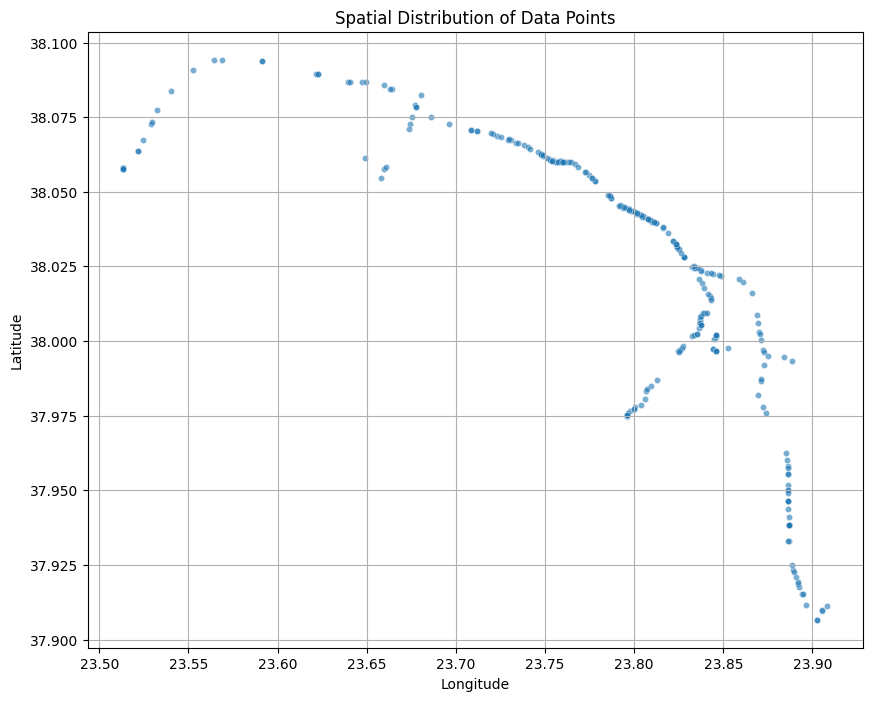

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train has the required columns
# Use a small sample if the dataset is very large for faster plotting
sample_df = X_train.sample(n=500, random_state=42) if X_train.shape[0] > 500 else X_train.copy()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=sample_df, x='lng', y='lat', s=20, alpha=0.6, legend=False)
plt.title('Spatial Distribution of Data Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [ ]:
# X_train, X_val, X_test are your dataframes after spatial features are engineered
columns_to_drop_after_spatial_eng = ['lat', 'lng'] # Add any other raw source columns if needed

X_train = X_train.drop(columns=columns_to_drop_after_spatial_eng, errors='ignore')
X_val = X_val.drop(columns=columns_to_drop_after_spatial_eng, errors='ignore')
X_test = X_test.drop(columns=columns_to_drop_after_spatial_eng, errors='ignore')

print(f"Dropped raw spatial columns: {columns_to_drop_after_spatial_eng}")

Dropped raw spatial columns: ['lat', 'lng']


## pre-processing

In [ ]:
if 'X_train' in locals():
    # Identify feature types AFTER new spatial features are created
    # New categorical features from spatial engineering:
    new_cat_spatial_features = []
    if f'grid_cell_{N_BINS}x{N_BINS}' in X_train.columns: new_cat_spatial_features.append(f'grid_cell_{N_BINS}x{N_BINS}')
    if f'geohash_p{GEOHASH_PRECISION}' in X_train.columns: new_cat_spatial_features.append(f'geohash_p{GEOHASH_PRECISION}')
    if 'segment_id' in X_train.columns: new_cat_spatial_features.append('segment_id')
    # Add more if you create other categorical spatial features e.g. lat_bin_N, lng_bin_N as separate features

    # New numerical features from spatial engineering:
    new_num_spatial_features = []
    if 'kde_score' in X_train.columns: new_num_spatial_features.append('kde_score')


    all_categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    # Ensure our new spatial categoricals are included if not automatically detected as object/category
    for f in new_cat_spatial_features:
        if f not in all_categorical_features and f in X_train.columns:
            all_categorical_features.append(f)
            X_train[f] = X_train[f].astype('category') # Ensure correct dtype
            X_val[f] = X_val[f].astype('category')
            X_test[f] = X_test[f].astype('category')


    # Features for 'unknown' imputation (original list)
    categorical_features_unknown_impute = [
        'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'ΚΑΤ._ΟΔ.', 'ΤΕΧΝ._ΦΩΤ.'# , 'effective_lighting_condition'
    ]
    categorical_features_unknown_impute = [col for col in categorical_features_unknown_impute if col in X_train.columns and col in all_categorical_features]


    # Other categorical features (if any) for 'most_frequent' imputation
    # This will now include new_cat_spatial_features if they are not in the unknown_impute list
    categorical_features_mode_impute = [
        col for col in all_categorical_features if col not in categorical_features_unknown_impute
    ]

    boolean_features = X_train.select_dtypes(include=['bool']).columns.tolist()
    for bf in boolean_features:
        X_train[bf] = X_train[bf].astype(int)
        X_val[bf] = X_val[bf].astype(int)
        X_test[bf] = X_test[bf].astype(int)

    numerical_features = X_train.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
    # Ensure our new numerical spatial features are included
    for f in new_num_spatial_features:
        if f not in numerical_features and f in X_train.columns:
            numerical_features.append(f)


    print(f"Final Numerical features for preprocessor: {numerical_features}")
    print(f"Final Categorical features for 'unknown' imputation: {categorical_features_unknown_impute}")
    print(f"Final Categorical features for 'most_frequent' imputation: {categorical_features_mode_impute}")


    # --- The rest of your ColumnTransformer and preprocessing code follows ---
    # Create preprocessing pipelines (as you had before)
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline_unknown = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    categorical_pipeline_mode = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')), # New spatial categoricals (grid_cell, geohash) usually don't have NaNs if created properly
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    transformers_list = []
    if numerical_features: # Add only if list is not empty
         transformers_list.append(('num', numerical_pipeline, numerical_features))
    if categorical_features_unknown_impute:
        transformers_list.append(('cat_unknown', categorical_pipeline_unknown, categorical_features_unknown_impute))
    if categorical_features_mode_impute:
        transformers_list.append(('cat_mode', categorical_pipeline_mode, categorical_features_mode_impute))

    preprocessor = ColumnTransformer(
        transformers=transformers_list,
        remainder='passthrough'
    )

    # Fit and transform (as you had before)
    # ... your existing code for fitting preprocessor and creating X_train_processed_df ...
    # (No changes needed to that part if the feature lists fed into ColumnTransformer are correct)
    # Fit preprocessor on X_train and transform all sets
    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)

    # Get feature names after one-hot encoding for RFE and interpretation
    try:
        feature_names_out = preprocessor.get_feature_names_out()
        X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_out, index=X_train.index)
        X_val_processed_df = pd.DataFrame(X_val_processed, columns=feature_names_out, index=X_val.index)
        X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_out, index=X_test.index)
        print(f"Processed training data shape: {X_train_processed_df.shape}")
    except Exception as e:
        print(f"Could not get feature names from preprocessor automatically: {e}")
        X_train_processed_df = pd.DataFrame(X_train_processed, index=X_train.index)
        X_val_processed_df = pd.DataFrame(X_val_processed, index=X_val.index)
        X_test_processed_df = pd.DataFrame(X_test_processed, index=X_test.index)
        feature_names_out = X_train_processed_df.columns.astype(str)
        print(f"Processed training data shape (generic column names): {X_train_processed_df.shape}")

Final Numerical features for preprocessor: ['num_involved_vehicles', 'has_ΙΧΕ', 'has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ', 'has_ΔΙΚΥΚΛΟ', 'has_ΦΟΡΤΗΓΟ', 'has_ΤΑΞΙ', 'has_ΛΕΩΦΟΡΕΙΟ', 'has_Μ.Ε.', 'lat_bin_8', 'lng_bin_8', 'kde_score']
Final Categorical features for 'unknown' imputation: ['ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'ΚΑΤ._ΟΔ.', 'ΤΕΧΝ._ΦΩΤ.']
Final Categorical features for 'most_frequent' imputation: ['ΑΥΤ/ΔΡΟΜΟΣ', 'ΧΙΛ.ΘΕΣΗ', 'ΣΗΡΑΓΓΑ', 'ΥΠΟΚΑΤΗΓΟΡΙΑ', 'ΘΕΣΗ_ΕΡΓΟΥ', 'effective_lighting_condition', 'segment_id', 'grid_cell_8x8', 'geohash_p7']
Processed training data shape: (313, 670)


## feature realtionship analysis

### we will use filter methods:
- numerical vs target: ANOVA f-statistic, mutual information
- categorical vs target: x^2, mutual information

## and check for colinearity using the correlation matrix and VIF for post ohe


Mutual Information Scores (Top 15):
cat_mode__geohash_p7_swbbpnm                                                      0.056503
cat_mode__geohash_p7_swbbkzy                                                      0.055580
cat_mode__segment_id_E_46.7                                                       0.043612
cat_mode__geohash_p7_swbbedd                                                      0.042987
cat_mode__ΧΙΛ.ΘΕΣΗ_41.6                                                           0.042540
cat_mode__segment_id_A_19.3                                                       0.041859
cat_mode__geohash_p7_swbbnrq                                                      0.041680
cat_mode__geohash_p7_swbbmv0                                                      0.041413
cat_mode__segment_id_E_26.7                                                       0.039463
num__has_ΔΙΚΥΚΛΟ                                                                  0.038887
cat_mode__ΧΙΛ.ΘΕΣΗ_5.8                               

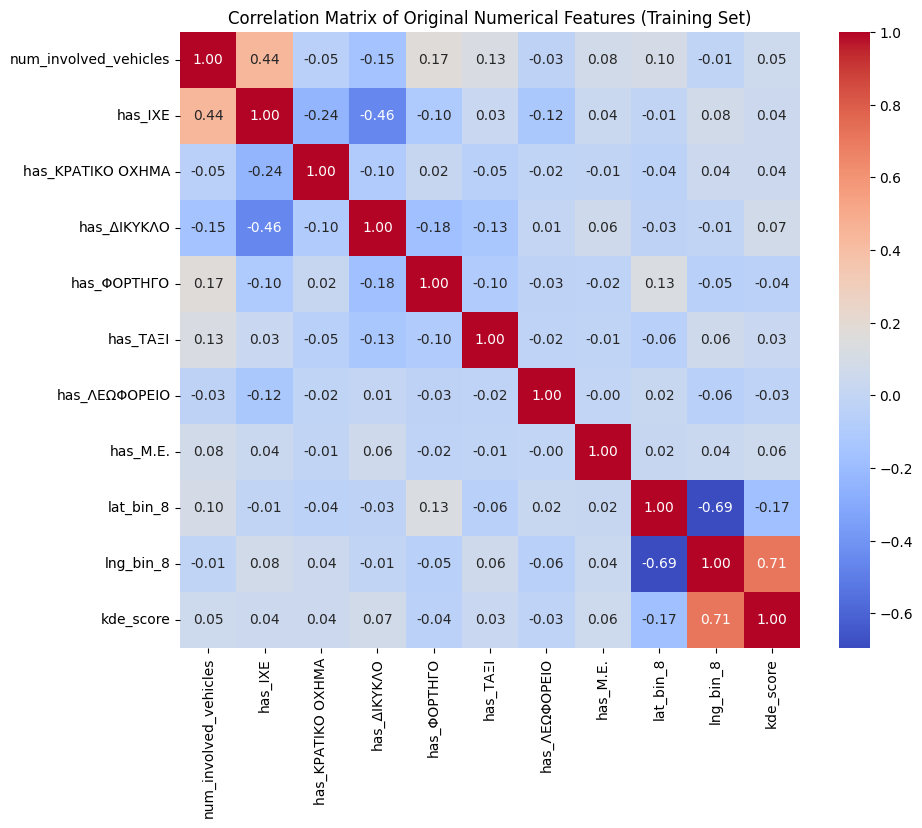

In [ ]:
if 'X_train_processed_df' in locals():
    # Note: For filter methods, it's often better to use them on data *before* extensive transformations
    # if the transformations obscure original relationships (e.g. scaling for chi2).
    # However, for simplicity here, we use the processed data.
    # Ensure all data is non-negative for chi2 if applicable
    # For mutual_info_classif and f_classif, current processed data is fine.

    # Mutual Information (works for both num and cat (post-OHE))
    mi_scores = mutual_info_classif(X_train_processed_df, y_train, random_state=42)
    mi_series = pd.Series(mi_scores, index=feature_names_out).sort_values(ascending=False)
    print("\nMutual Information Scores (Top 15):")
    print(mi_series.head(15))

    # Correlation (for numerical features in X_train_processed_df - identify them again)
    # This is more complex with OHE. For now, let's skip detailed VIF on OHE.
    # A simple correlation heatmap on the original numerical features can be insightful:
    if len(numerical_features) > 1:
        plt.figure(figsize=(10, 8))
        sns.heatmap(X_train[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Matrix of Original Numerical Features (Training Set)")
        plt.show()


## recursive feature elimination

In [ ]:
if 'X_train_processed_df' in locals():
    estimator_rfe = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42, max_iter=1000)
    # Decide on number of features to select, e.g., half or a fixed number
    num_features_to_select = max(5, X_train_processed_df.shape[1] // 2) # Example: select half, but at least 5

    rfe = RFE(estimator=estimator_rfe, n_features_to_select=num_features_to_select, step=1)
    rfe.fit(X_train_processed_df, y_train)

    selected_features_rfe_mask = rfe.support_
    selected_features_rfe = X_train_processed_df.columns[selected_features_rfe_mask]
    print(f"\nSelected features from RFE ({len(selected_features_rfe)}):")
    print(selected_features_rfe.tolist())

    # Update X_train_processed_df and X_val_processed_df for this iteration
    X_train_iter_final = X_train_processed_df[selected_features_rfe]
    X_val_iter_final = X_val_processed_df[selected_features_rfe]
    X_test_iter_final = X_test_processed_df[selected_features_rfe] # Also transform test set
else:
    print("Skipping RFE as processed data is not available.")
    # Fallback if RFE was skipped
    if 'X_train_processed_df' in locals():
        X_train_iter_final = X_train_processed_df.copy()
        X_val_iter_final = X_val_processed_df.copy()
        X_test_iter_final = X_test_processed_df.copy()


Selected features from RFE (335):
['num__num_involved_vehicles', 'num__has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ', 'num__has_ΔΙΚΥΚΛΟ', 'num__has_ΦΟΡΤΗΓΟ', 'num__has_ΤΑΞΙ', 'num__has_ΛΕΩΦΟΡΕΙΟ', 'num__has_Μ.Ε.', 'num__lng_bin_8', 'num__kde_score', 'cat_unknown__ΚΑΙΡ._ΣΥΝΘ._ΒΡΟΧΗ', 'cat_unknown__ΚΑΙΡ._ΣΥΝΘ._ΙΣΧΥΡΟΙ ΑΝΕΜΟΙ', 'cat_unknown__ΚΑΙΡ._ΣΥΝΘ._ΚΑΛΟΚΑΙΡΙΑ', 'cat_unknown__ΚΑΙΡ._ΣΥΝΘ._ΨΙΛΗ ΒΡΟΧΗ', 'cat_unknown__ΣΥΝΘ._ΟΔ._ΚΑΝΟΝΙΚΕΣ', 'cat_unknown__ΣΥΝΘ._ΟΔ._ΥΓΡΟ - ΒΡΕΓΜΕΝΟ', 'cat_unknown__ΚΑΤ._ΟΔ._Unknown', 'cat_unknown__ΚΑΤ._ΟΔ._ΚΑΝΟΝΙΚΗ', 'cat_unknown__ΤΕΧΝ._ΦΩΤ._Unknown', 'cat_mode__ΑΥΤ/ΔΡΟΜΟΣ_A', 'cat_mode__ΑΥΤ/ΔΡΟΜΟΣ_B', 'cat_mode__ΑΥΤ/ΔΡΟΜΟΣ_E', 'cat_mode__ΑΥΤ/ΔΡΟΜΟΣ_K', 'cat_mode__ΑΥΤ/ΔΡΟΜΟΣ_N', 'cat_mode__ΑΥΤ/ΔΡΟΜΟΣ_P', 'cat_mode__ΑΥΤ/ΔΡΟΜΟΣ_X', 'cat_mode__ΑΥΤ/ΔΡΟΜΟΣ_Y', 'cat_mode__ΑΥΤ/ΔΡΟΜΟΣ_Z', 'cat_mode__ΧΙΛ.ΘΕΣΗ_0.0', 'cat_mode__ΧΙΛ.ΘΕΣΗ_0.2', 'cat_mode__ΧΙΛ.ΘΕΣΗ_0.4', 'cat_mode__ΧΙΛ.ΘΕΣΗ_1.0', 'cat_mode__ΧΙΛ.ΘΕΣΗ_1.5', 'cat_mode__ΧΙΛ.ΘΕΣΗ_10.3', 'cat_mode__ΧΙΛ.ΘΕΣΗ_11.3', 'cat_mode__ΧΙΛ.ΘΕΣΗ_11.

## balancing techniuqes

- only applying them to the training set
- experimenting with vairous balancing techniques

In [ ]:
# Previous code: X_train_iter_final, y_train, X_val_iter_final, y_val are defined

resampled_datasets = {} # To store (X_resampled, y_resampled) for each technique

if 'X_train_iter_final' in locals() and X_train_iter_final is not None and y_train is not None:
    print(f"\nOriginal training set shape: {X_train_iter_final.shape}, Original class distribution: {Counter(y_train)}")
    minority_class_count = Counter(y_train).get(1, 0) # Assuming 1 is the minority class

    # Store the original (non-resampled) training data as a baseline
    resampled_datasets['Original'] = (X_train_iter_final.copy(), y_train.copy())

    # Define samplers
    samplers = {
        "RandomOverSampler": RandomOverSampler(random_state=42),
        "SMOTE": None, # Will initialize carefully due to k_neighbors
        "ADASYN": None, # Will initialize carefully due to n_neighbors
        "TomekLinks": TomekLinks(sampling_strategy='auto', n_jobs=-1), # Undersampling, removes Tomek links
        "SMOTETomek": None, # Will initialize carefully
        "SMOTEENN": None # Will initialize carefully
    }

    # SMOTE and ADASYN require k_neighbors (or n_neighbors for ADASYN) < minority_class_count
    if minority_class_count > 1:
        k_val = min(4, minority_class_count - 1) # A common heuristic for k, ensuring it's less than minority samples

        if k_val > 0 : # Ensure k_val is positive
            samplers["SMOTE"] = SMOTE(random_state=42, k_neighbors=k_val)
            samplers["ADASYN"] = ADASYN(random_state=42, n_neighbors=k_val) # ADASYN uses n_neighbors
            samplers["SMOTETomek"] = SMOTETomek(random_state=42, smote=SMOTE(random_state=42, k_neighbors=k_val), tomek=TomekLinks(sampling_strategy='auto'), n_jobs=-1)
            samplers["SMOTEENN"] = SMOTEENN(random_state=42, smote=SMOTE(random_state=42, k_neighbors=k_val), enn=None, n_jobs=-1) # enn default is good
        else:
            print(f"Skipping SMOTE-based samplers as k_val ({k_val}) would be too small or zero based on minority count ({minority_class_count}).")
            # Remove them if they can't be initialized
            for key in ["SMOTE", "ADASYN", "SMOTETomek", "SMOTEENN"]:
                if key in samplers: samplers.pop(key)

    else:
        print(f"Skipping SMOTE-based samplers as minority count ({minority_class_count}) is <= 1.")
        for key in ["SMOTE", "ADASYN", "SMOTETomek", "SMOTEENN"]:
            if key in samplers: samplers.pop(key)


    # Apply each sampler
    for name, sampler in samplers.items():
        if sampler is None: # Sampler was not initialized
            continue
        print(f"\nApplying {name}...")
        try:
            X_res, y_res = sampler.fit_resample(X_train_iter_final, y_train)
            resampled_datasets[name] = (X_res, y_res)
            print(f"Resampled with {name}: X_shape={X_res.shape}, y_dist={Counter(y_res)}")
        except Exception as e:
            print(f"Could not apply {name}. Error: {e}")
            # Optionally store original if sampler fails, or skip
            # resampled_datasets[name] = (X_train_iter_final.copy(), y_train.copy())


    if not resampled_datasets: # If all samplers failed or were skipped
        print("No resampling techniques were successfully applied or initialized. Using original data only.")
        if 'Original' not in resampled_datasets: # Should already be there
             resampled_datasets['Original'] = (X_train_iter_final.copy(), y_train.copy())


else:
    print("Skipping balancing as X_train_iter_final or y_train is not available.")
    # Ensure there's at least 'Original' if X_train_iter_final was available
    if 'X_train_iter_final' in locals() and X_train_iter_final is not None and y_train is not None:
        resampled_datasets['Original'] = (X_train_iter_final.copy(), y_train.copy())


Original training set shape: (313, 335), Original class distribution: Counter({0: 284, 1: 29})

Applying RandomOverSampler...
Resampled with RandomOverSampler: X_shape=(568, 335), y_dist=Counter({0: 284, 1: 284})

Applying SMOTE...
Resampled with SMOTE: X_shape=(568, 335), y_dist=Counter({0: 284, 1: 284})

Applying ADASYN...
Resampled with ADASYN: X_shape=(566, 335), y_dist=Counter({0: 284, 1: 282})

Applying TomekLinks...
Resampled with TomekLinks: X_shape=(306, 335), y_dist=Counter({0: 277, 1: 29})

Applying SMOTETomek...
Resampled with SMOTETomek: X_shape=(568, 335), y_dist=Counter({0: 284, 1: 284})

Applying SMOTEENN...
Resampled with SMOTEENN: X_shape=(449, 335), y_dist=Counter({1: 271, 0: 178})


## model training

### we will be training random forest with class_weight balanced, logistic regression, logistic regression with L1 regularization, and xgboost

In [ ]:
trained_models = {} # To store trained models: key will be "ModelName_SamplerName"

if 'resampled_datasets' in locals() and resampled_datasets:
    minority_class_label = 1 # Assuming 'death' is 1
    f1_minority_scorer = make_scorer(f1_score, pos_label=minority_class_label, average='binary') # For CV if you add it later

    for sampler_name, (X_train_curr_resampled, y_train_curr_resampled) in resampled_datasets.items():
        print(f"\n--- Training models on data from: {sampler_name} ---")
        print(f"Training data shape: {X_train_curr_resampled.shape}, Distribution: {Counter(y_train_curr_resampled)}")

        # Define your models here or ensure they are defined from a previous cell
        # Re-initialize models for each dataset to ensure they are fresh

        # Calculate scale_pos_weight for XGBoost based on the current resampled data
        counts_curr = Counter(y_train_curr_resampled)
        scale_pos_weight_curr = counts_curr[0] / counts_curr[1] if counts_curr[1] > 0 else 1

        current_models_definitions = {
            'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000),
            'LogisticRegression_L1': LogisticRegression(solver='liblinear', penalty='l1', random_state=42, class_weight='balanced', max_iter=1000),
            'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced_subsample', n_estimators=100),
            'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',
                                         scale_pos_weight=scale_pos_weight_curr)
        }
        # Note on class_weight='balanced':
        # For 'Original' data (imbalanced), it's useful.
        # For data resampled to be perfectly balanced (e.g., SMOTE to 50/50), class_weight='balanced' might have less effect
        # or could be omitted, but it generally doesn't hurt and can help if balance isn't perfect.

        for model_name, model_instance in current_models_definitions.items():
            full_model_name = f"{model_name}_{sampler_name}"
            print(f"Training {full_model_name}...")
            try:
                model_instance.fit(X_train_curr_resampled, y_train_curr_resampled)
                trained_models[full_model_name] = model_instance
                print(f"{full_model_name} trained.")
            except Exception as e:
                print(f"Could not train {full_model_name}. Error: {e}")
                trained_models[full_model_name] = None # Store None if training failed

else:
    print("Skipping model training as no resampled datasets are available.")


--- Training models on data from: Original ---
Training data shape: (313, 335), Distribution: Counter({0: 284, 1: 29})
Training LogisticRegression_Original...
LogisticRegression_Original trained.
Training LogisticRegression_L1_Original...
LogisticRegression_L1_Original trained.
Training RandomForest_Original...
RandomForest_Original trained.
Training XGBoost_Original...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:16:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_Original trained.

--- Training models on data from: RandomOverSampler ---
Training data shape: (568, 335), Distribution: Counter({0: 284, 1: 284})
Training LogisticRegression_RandomOverSampler...
LogisticRegression_RandomOverSampler trained.
Training LogisticRegression_L1_RandomOverSampler...
LogisticRegression_L1_RandomOverSampler trained.
Training RandomForest_RandomOverSampler...
RandomForest_RandomOverSampler trained.
Training XGBoost_RandomOverSampler...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:16:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_RandomOverSampler trained.

--- Training models on data from: SMOTE ---
Training data shape: (568, 335), Distribution: Counter({0: 284, 1: 284})
Training LogisticRegression_SMOTE...
LogisticRegression_SMOTE trained.
Training LogisticRegression_L1_SMOTE...
LogisticRegression_L1_SMOTE trained.
Training RandomForest_SMOTE...
RandomForest_SMOTE trained.
Training XGBoost_SMOTE...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:16:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_SMOTE trained.

--- Training models on data from: ADASYN ---
Training data shape: (566, 335), Distribution: Counter({0: 284, 1: 282})
Training LogisticRegression_ADASYN...
LogisticRegression_ADASYN trained.
Training LogisticRegression_L1_ADASYN...
LogisticRegression_L1_ADASYN trained.
Training RandomForest_ADASYN...
RandomForest_ADASYN trained.
Training XGBoost_ADASYN...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:17:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_ADASYN trained.

--- Training models on data from: TomekLinks ---
Training data shape: (306, 335), Distribution: Counter({0: 277, 1: 29})
Training LogisticRegression_TomekLinks...
LogisticRegression_TomekLinks trained.
Training LogisticRegression_L1_TomekLinks...
LogisticRegression_L1_TomekLinks trained.
Training RandomForest_TomekLinks...
RandomForest_TomekLinks trained.
Training XGBoost_TomekLinks...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:17:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_TomekLinks trained.

--- Training models on data from: SMOTETomek ---
Training data shape: (568, 335), Distribution: Counter({0: 284, 1: 284})
Training LogisticRegression_SMOTETomek...
LogisticRegression_SMOTETomek trained.
Training LogisticRegression_L1_SMOTETomek...
LogisticRegression_L1_SMOTETomek trained.
Training RandomForest_SMOTETomek...
RandomForest_SMOTETomek trained.
Training XGBoost_SMOTETomek...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:17:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_SMOTETomek trained.

--- Training models on data from: SMOTEENN ---
Training data shape: (449, 335), Distribution: Counter({1: 271, 0: 178})
Training LogisticRegression_SMOTEENN...
LogisticRegression_SMOTEENN trained.
Training LogisticRegression_L1_SMOTEENN...
LogisticRegression_L1_SMOTEENN trained.
Training RandomForest_SMOTEENN...
RandomForest_SMOTEENN trained.
Training XGBoost_SMOTEENN...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:17:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_SMOTEENN trained.


## model assessment

In [ ]:
if 'trained_models' in locals() and trained_models and \
   'X_val_iter_final' in locals() and X_val_iter_final is not None and y_val is not None:

    print("\n--- Model Assessment on Validation Set ---")

    # Store results for later comparison if needed
    validation_results = {}

    for full_model_name, model in trained_models.items():
        if model is not None: # Check if model was trained
            print(f"\n--- Assessing: {full_model_name} ---")
            try:
                y_pred_val = model.predict(X_val_iter_final)
                y_proba_val = model.predict_proba(X_val_iter_final)[:, 1] # Probability of positive class

                report = classification_report(y_val, y_pred_val, target_names=['Injury (0)', 'Death (1)'], output_dict=True)
                roc_auc = roc_auc_score(y_val, y_proba_val)
                precision_pr, recall_pr, _ = precision_recall_curve(y_val, y_proba_val)
                pr_auc = auc(recall_pr, precision_pr)
                conf_matrix = confusion_matrix(y_val, y_pred_val)

                print(classification_report(y_val, y_pred_val, target_names=['Injury (0)', 'Death (1)']))
                print(f"Confusion Matrix:\n{conf_matrix}")
                print(f"ROC AUC: {roc_auc:.4f}")
                print(f"PR AUC: {pr_auc:.4f}")

                # Store results
                validation_results[full_model_name] = {
                    'classification_report': report,
                    'confusion_matrix': conf_matrix.tolist(), # convert numpy array to list for easier storage/JSON
                    'roc_auc': roc_auc,
                    'pr_auc': pr_auc,
                    'f1_death': report.get('Death (1)', {}).get('f1-score', 0), # F1 for minority class
                    'recall_death': report.get('Death (1)', {}).get('recall', 0) # Recall for minority class
                }
            except Exception as e:
                print(f"Could not assess {full_model_name}. Error: {e}")
                validation_results[full_model_name] = {'error': str(e)}
        else:
            print(f"Model {full_model_name} was not trained, skipping assessment.")
            validation_results[full_model_name] = {'error': 'Model not trained'}

    # Optional: Print a summary table of key metrics from validation_results
    if validation_results:
        print("\n--- Validation Results Summary (F1 and Recall for Death class, PR AUC) ---")
        summary_df = pd.DataFrame([
            {'Model_Sampler': name,
             'F1_Death': data.get('f1_death', 'N/A'),
             'Recall_Death': data.get('recall_death', 'N/A'),
             'PR_AUC': data.get('pr_auc', 'N/A'),
             'ROC_AUC': data.get('roc_auc', 'N/A')}
            for name, data in validation_results.items() if 'error' not in data
        ])
        if not summary_df.empty:
            summary_df = summary_df.sort_values(by='F1_Death', ascending=False) # Sort by F1 for death class
            try:
                display(summary_df) # Works well in Colab
            except NameError:
                print(summary_df)
        else:
            print("No valid results to summarize.")


else:
    print("Skipping model assessment: Trained models or validation data are not available.")


--- Model Assessment on Validation Set ---

--- Assessing: LogisticRegression_Original ---
              precision    recall  f1-score   support

  Injury (0)       0.90      0.82      0.86        95
   Death (1)       0.06      0.10      0.07        10

    accuracy                           0.75       105
   macro avg       0.48      0.46      0.46       105
weighted avg       0.82      0.75      0.78       105

Confusion Matrix:
[[78 17]
 [ 9  1]]
ROC AUC: 0.4895
PR AUC: 0.0863

--- Assessing: LogisticRegression_L1_Original ---
              precision    recall  f1-score   support

  Injury (0)       0.90      0.81      0.85        95
   Death (1)       0.05      0.10      0.07        10

    accuracy                           0.74       105
   macro avg       0.47      0.46      0.46       105
weighted avg       0.82      0.74      0.78       105

Confusion Matrix:
[[77 18]
 [ 9  1]]
ROC AUC: 0.4516
PR AUC: 0.0792

--- Assessing: RandomForest_Original ---
              precision  

Model_Sampler  F1_Death  Recall_Death    PR_AUC  \
24              LogisticRegression_SMOTEENN  0.210526           0.4  0.099833   
27                         XGBoost_SMOTEENN  0.173913           0.2  0.095312   
8                  LogisticRegression_SMOTE  0.142857           0.2  0.088250   
11                            XGBoost_SMOTE  0.142857           0.1  0.128048   
20            LogisticRegression_SMOTETomek  0.142857           0.2  0.088250   
23                       XGBoost_SMOTETomek  0.142857           0.1  0.128048   
12                LogisticRegression_ADASYN  0.137931           0.2  0.087751   
15                           XGBoost_ADASYN  0.133333           0.1  0.119158   
7                 XGBoost_RandomOverSampler  0.111111           0.1  0.102253   
6            RandomForest_RandomOverSampler  0.105263           0.1  0.083748   
3                          XGBoost_Original  0.100000           0.1  0.109320   
19                       XGBoost_TomekLinks  0.086957           0.1  0.088486   
13             LogisticRegression_L1_ADASYN  0.080000           0.1  0.078284   
21         LogisticRegression_L1_SMOTETomek  0.076923           0.1  0.078332   
9               LogisticRegression_L1_SMOTE  0.076923           0.1  0.078332   
16            LogisticRegression_TomekLinks  0.076923           0.1  0.086674   
5   LogisticRegression_L1_RandomOverSampler  0.076923           0.1  0.078149   
0               LogisticRegression_Original  0.071429           0.1  0.086333   
4      LogisticRegression_RandomOverSampler  0.071429           0.1  0.083502   
1            LogisticRegression_L1_Original  0.068966           0.1  0.079218   
17         LogisticRegression_L1_TomekLinks  0.064516           0.1  0.078769   
25           LogisticRegression_L1_SMOTEENN  0.058824           0.1  0.086824   
10                       RandomForest_SMOTE  0.000000           0.0  0.090816   
2                     RandomForest_Original  0.000000           0.0  0.091813   
18                  RandomForest_TomekLinks  0.000000           0.0  0.089372   
14                      RandomForest_ADASYN  0.000000           0.0  0.087916   
22                  RandomForest_SMOTETomek  0.000000           0.0  0.090816   
26                    RandomForest_SMOTEENN  0.000000           0.0  0.097438   

     ROC_AUC  
24  0.551579  
27  0.497895  
8   0.492632  
11  0.527368  
20  0.492632  
23  0.527368  
12  0.488421  
15  0.515789  
7   0.522105  
6   0.466316  
3   0.512632  
19  0.474737  
13  0.436842  
21  0.435789  
9   0.435789  
16  0.491579  
5   0.431579  
0   0.489474  
4   0.472632  
1   0.451579  
17  0.448421  
25  0.493684  
10  0.498947  
2   0.514211  
18  0.506316  
14  0.503684  
22  0.498947  
26  0.553684

## error analysis on validation set misclassification

In [ ]:
import pandas as pd # Ensure pandas is imported

# --- Helper Function for Error Analysis ---
def perform_detailed_error_analysis(model_name, model,
                                    X_val_processed_features, y_true_labels,
                                    X_val_original_features,
                                    target_class_name='Death', positive_label=1, negative_label=0):
    """
    Performs detailed error analysis for a given model.

    Args:
        model_name (str): Name of the model (e.g., "XGBoost_SMOTE").
        model (estimator): The trained model object.
        X_val_processed_features (pd.DataFrame or np.array): Processed features for prediction.
        y_true_labels (pd.Series): True labels.
        X_val_original_features (pd.DataFrame): Original, interpretable features for analysis.
                                               Must have the same index as y_true_labels.
        target_class_name (str): Name of the positive class for reporting.
        positive_label (int): Label for the positive class.
        negative_label (int): Label for the negative class.
    """
    print(f"\n--- Detailed Error Analysis for: {model_name} ---")

    if model is None:
        print("Model is None, skipping analysis.")
        return

    # Make predictions
    y_pred = model.predict(X_val_processed_features)

    # Ensure indices match for proper alignment
    if not X_val_original_features.index.equals(y_true_labels.index):
        print("Error: Indices of X_val_original_features and y_true_labels do not match!")
        # Attempt to reindex X_val_original_features based on y_true_labels's index if shapes match
        if len(X_val_original_features) == len(y_true_labels):
            print("Attempting to reindex X_val_original_features...")
            X_val_original_features = X_val_original_features.reindex(y_true_labels.index)
            if not X_val_original_features.index.equals(y_true_labels.index):
                 print("Reindexing failed. Please ensure indices are aligned before calling this function.")
                 return
        else:
            print("Cannot reindex due to different lengths. Please ensure indices are aligned.")
            return


    # Create a DataFrame with true labels, predicted labels, and original features
    # It's crucial that X_val_original_features has an index that aligns with y_true_labels
    analysis_df = X_val_original_features.copy()
    analysis_df['actual_severity'] = y_true_labels
    analysis_df['predicted_severity'] = y_pred

    # Identify TP, FP, TN, FN for the positive class (Death)
    # True Positives (TP): Correctly predicted Death
    tp_data = analysis_df[(analysis_df['actual_severity'] == positive_label) & (analysis_df['predicted_severity'] == positive_label)]
    # False Positives (FP): Predicted Death, but was Injury (Type I error for Death class)
    fp_data = analysis_df[(analysis_df['actual_severity'] == negative_label) & (analysis_df['predicted_severity'] == positive_label)]
    # False Negatives (FN): Predicted Injury, but was Death (Type II error for Death class - CRITICAL)
    fn_data = analysis_df[(analysis_df['actual_severity'] == positive_label) & (analysis_df['predicted_severity'] == negative_label)]
    # True Negatives (TN): Correctly predicted Injury
    tn_data = analysis_df[(analysis_df['actual_severity'] == negative_label) & (analysis_df['predicted_severity'] == negative_label)]

    print(f"\nTotal cases in validation: {len(analysis_df)}")
    print(f"Actual {target_class_name}s ({positive_label}): {sum(y_true_labels == positive_label)}")
    print(f"Predicted {target_class_name}s ({positive_label}): {sum(y_pred == positive_label)}")

    print(f"\n--- {target_class_name} Class ---")
    print(f"True Positives (TP - Correctly predicted {target_class_name}): {len(tp_data)}")
    if not tp_data.empty:
        print(f"Characteristics of TPs for {target_class_name}:")
        try:
            display(tp_data.describe(include='all').transpose())
            # Value counts for key categoricals (adjust column names as needed)
            for col in ['ΥΠΟΚΑΤΗΓΟΡΙΑ', 'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'segment_id', 'geohash_p7', 'grid_cell_8x8']: # Example columns
                if col in tp_data.columns:
                    print(f"\nValue counts for '{col}' in TPs:")
                    display(tp_data[col].value_counts(normalize=True).head())
        except Exception as e:
            print(f"Could not display describe/value_counts for TPs: {e}")


    print(f"\nFalse Negatives (FN - Missed {target_class_name}s - Predicted Injury): {len(fn_data)}")
    if not fn_data.empty:
        print(f"Characteristics of FNs for {target_class_name} (Actual {target_class_name}, Predicted Injury):")
        try:
            display(fn_data.describe(include='all').transpose())
            for col in ['ΥΠΟΚΑΤΗΓΟΡΙΑ', 'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'segment_id', 'geohash_p7', 'grid_cell_8x8', 'hour_group', 'is_weekend', 'num_involved_vehicles']: # Example columns
                if col in fn_data.columns:
                    print(f"\nValue counts for '{col}' in FNs:")
                    display(fn_data[col].value_counts(normalize=True).head())
        except Exception as e:
            print(f"Could not display describe/value_counts for FNs: {e}")


    print(f"\nFalse Positives (FP - Incorrectly predicted {target_class_name} - Was Injury): {len(fp_data)}")
    if not fp_data.empty:
        print(f"Characteristics of FPs for {target_class_name} (Actual Injury, Predicted {target_class_name}):")
        try:
            display(fp_data.describe(include='all').transpose())
            for col in ['ΥΠΟΚΑΤΗΓΟΡΙΑ', 'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'segment_id', 'geohash_p7', 'grid_cell_8x8', 'hour_group', 'is_weekend', 'num_involved_vehicles']: # Example columns
                if col in fp_data.columns:
                    print(f"\nValue counts for '{col}' in FPs:")
                    display(fp_data[col].value_counts(normalize=True).head())
        except Exception as e:
            print(f"Could not display describe/value_counts for FPs: {e}")

    # You can also print a few full examples of FN and FP cases
    if not fn_data.empty:
        print("\nSample False Negatives (Actual Death, Predicted Injury):")
        try:
            display(fn_data.head(min(5, len(fn_data)))) # Display up to 5 FNs
        except Exception as e:
            print(f"Could not display sample FNs: {e}")

    if not fp_data.empty:
        print("\nSample False Positives (Actual Injury, Predicted Death):")
        try:
            display(fp_data.head(min(5, len(fp_data)))) # Display up to 5 FPs
        except Exception as e:
            print(f"Could not display sample FPs: {e}")

# --- Specify Models for Analysis ---
models_for_analysis = [
    'XGBoost_SMOTE',
    'XGBoost_SMOTEENN'
]

# --- Run Analysis ---
# Ensure X_val (before processing) is available and has the original feature values for this iteration.
# This X_val should have an index that aligns with y_val.
# If X_val doesn't contain all original features you want to see,
# you might need to use df_original.loc[X_val.index] or df_iterX.loc[X_val.index]
# For this example, let's assume X_val (the DataFrame that was input to the preprocessor for the validation split)
# contains the necessary interpretable features for this iteration.

if 'X_val' in locals() and 'y_val' in locals() and 'X_val_iter_final' in locals() and 'trained_models' in locals():
    # Make sure X_val has the same index as y_val if it's being used directly
    # If X_val was created from X (which was from df_iterX), its index should be fine.

    # We need to ensure the 'X_val_original_features' (which is `X_val` here)
    # has the correct index that matches `y_val`.
    # `X_val` is the data that was split off for validation *before* `ColumnTransformer` processing.
    # Its index should align with `y_val`.

    df_for_error_analysis = X_val.copy() # Use the X_val from the train/val/test split
                                         # This contains the features of the current iteration in their original form.
                                         # Ensure it has all the columns you listed in the 'cols' variable in the function.

    for model_key in models_for_analysis:
        if model_key in trained_models:
            model_object = trained_models[model_key]
            perform_detailed_error_analysis(model_key, model_object,
                                            X_val_iter_final, y_val,
                                            df_for_error_analysis) # Pass the non-processed X_val
        else:
            print(f"Model {model_key} not found in trained_models.")
else:
    print("Required data for error analysis (X_val, y_val, X_val_iter_final, trained_models) not found.")


--- Detailed Error Analysis for: XGBoost_SMOTE ---

Total cases in validation: 105
Actual Deaths (1): 10
Predicted Deaths (1): 4

--- Death Class ---
True Positives (TP - Correctly predicted Death): 1
Characteristics of TPs for Death:


count unique  \
ΑΥΤ/ΔΡΟΜΟΣ                       1      1   
ΧΙΛ.ΘΕΣΗ                         1      1   
ΣΗΡΑΓΓΑ                          1      1   
ΥΠΟΚΑΤΗΓΟΡΙΑ                     1      1   
ΘΕΣΗ_ΕΡΓΟΥ                       1      1   
ΚΑΙΡ._ΣΥΝΘ.                      1      1   
ΣΥΝΘ._ΟΔ.                        1      1   
ΚΑΤ._ΟΔ.                         1      1   
ΤΕΧΝ._ΦΩΤ.                       0      0   
num_involved_vehicles          1.0    NaN   
has_ΙΧΕ                        1.0    NaN   
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ              1.0    NaN   
has_ΔΙΚΥΚΛΟ                    1.0    NaN   
has_ΦΟΡΤΗΓΟ                    1.0    NaN   
has_ΤΑΞΙ                       1.0    NaN   
has_ΛΕΩΦΟΡΕΙΟ                  1.0    NaN   
has_Μ.Ε.                       1.0    NaN   
effective_lighting_condition     1      1   
segment_id                       1      1   
lat_bin_8                      1.0    NaN   
lng_bin_8                      1.0    NaN   
grid_cell_8x8                    1      1   
geohash_p7                       1      1   
kde_score                      1.0    NaN   
actual_severity                1.0    NaN   
predicted_severity             1.0    NaN   

                                                                          top  \
ΑΥΤ/ΔΡΟΜΟΣ                                                                  E   
ΧΙΛ.ΘΕΣΗ                                                                 22.8   
ΣΗΡΑΓΓΑ                                                            no_ΣΗΡΑΓΓΑ   
ΥΠΟΚΑΤΗΓΟΡΙΑ                                             4D.Ν - ΕΚΤΡΟΠΗ ΔΕΞΙΑ   
ΘΕΣΗ_ΕΡΓΟΥ                                                                ΟΧΙ   
ΚΑΙΡ._ΣΥΝΘ.                                                        ΚΑΛΟΚΑΙΡΙΑ   
ΣΥΝΘ._ΟΔ.                                                           ΚΑΝΟΝΙΚΕΣ   
ΚΑΤ._ΟΔ.                                                             ΚΑΝΟΝΙΚΗ   
ΤΕΧΝ._ΦΩΤ.                                                                NaN   
num_involved_vehicles                                                     NaN   
has_ΙΧΕ                                                                   NaN   
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                                                         NaN   
has_ΔΙΚΥΚΛΟ                                                               NaN   
has_ΦΟΡΤΗΓΟ                                                               NaN   
has_ΤΑΞΙ                                                                  NaN   
has_ΛΕΩΦΟΡΕΙΟ                                                             NaN   
has_Μ.Ε.                                                                  NaN   
effective_lighting_condition  Daylight - Assumed Sufficient (No Manual Entry)   
segment_id                                                             E_22.8   
lat_bin_8                                                                 NaN   
lng_bin_8                                                                 NaN   
grid_cell_8x8                                                         6.0_4.0   
geohash_p7                                                            swbbs35   
kde_score                                                                 NaN   
actual_severity                                                           NaN   
predicted_severity                                                        NaN   

                             freq       mean  std        min        25%  \
ΑΥΤ/ΔΡΟΜΟΣ                      1        NaN  NaN        NaN        NaN   
ΧΙΛ.ΘΕΣΗ                        1        NaN  NaN        NaN        NaN   
ΣΗΡΑΓΓΑ                         1        NaN  NaN        NaN        NaN   
ΥΠΟΚΑΤΗΓΟΡΙΑ                    1        NaN  NaN        NaN        NaN   
ΘΕΣΗ_ΕΡΓΟΥ                      1        NaN  NaN        NaN        NaN   
ΚΑΙΡ._ΣΥΝΘ.                     1        NaN  NaN        NaN        NaN   
ΣΥΝΘ._ΟΔ.                       1        NaN  NaN        NaN        NaN   
ΚΑΤ._ΟΔ.                 


Value counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ' in TPs:


ΥΠΟΚΑΤΗΓΟΡΙΑ
4D.Ν - ΕΚΤΡΟΠΗ ΔΕΞΙΑ    1.0
Name: proportion, dtype: float64


Value counts for 'ΚΑΙΡ._ΣΥΝΘ.' in TPs:


ΚΑΙΡ._ΣΥΝΘ.
ΚΑΛΟΚΑΙΡΙΑ    1.0
Name: proportion, dtype: float64


Value counts for 'ΣΥΝΘ._ΟΔ.' in TPs:


ΣΥΝΘ._ΟΔ.
ΚΑΝΟΝΙΚΕΣ    1.0
Name: proportion, dtype: float64


Value counts for 'segment_id' in TPs:


segment_id
E_22.8    1.0
Name: proportion, dtype: float64


Value counts for 'geohash_p7' in TPs:


geohash_p7
swbbs35    1.0
Name: proportion, dtype: float64


Value counts for 'grid_cell_8x8' in TPs:


grid_cell_8x8
6.0_4.0    1.0
Name: proportion, dtype: float64


False Negatives (FN - Missed Deaths - Predicted Injury): 9
Characteristics of FNs for Death (Actual Death, Predicted Injury):


count unique  \
ΑΥΤ/ΔΡΟΜΟΣ                       9      3   
ΧΙΛ.ΘΕΣΗ                         9      9   
ΣΗΡΑΓΓΑ                          9      1   
ΥΠΟΚΑΤΗΓΟΡΙΑ                     9      8   
ΘΕΣΗ_ΕΡΓΟΥ                       9      1   
ΚΑΙΡ._ΣΥΝΘ.                      9      1   
ΣΥΝΘ._ΟΔ.                        9      2   
ΚΑΤ._ΟΔ.                         9      1   
ΤΕΧΝ._ΦΩΤ.                       3      1   
num_involved_vehicles          9.0    NaN   
has_ΙΧΕ                        9.0    NaN   
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ              9.0    NaN   
has_ΔΙΚΥΚΛΟ                    9.0    NaN   
has_ΦΟΡΤΗΓΟ                    9.0    NaN   
has_ΤΑΞΙ                       9.0    NaN   
has_ΛΕΩΦΟΡΕΙΟ                  9.0    NaN   
has_Μ.Ε.                       9.0    NaN   
effective_lighting_condition     9      4   
segment_id                       9      9   
lat_bin_8                      9.0    NaN   
lng_bin_8                      9.0    NaN   
grid_cell_8x8                    9      7   
geohash_p7                       9      9   
kde_score                      9.0    NaN   
actual_severity                9.0    NaN   
predicted_severity             9.0    NaN   

                                                                          top  \
ΑΥΤ/ΔΡΟΜΟΣ                                                                  A   
ΧΙΛ.ΘΕΣΗ                                                                 27.8   
ΣΗΡΑΓΓΑ                                                            no_ΣΗΡΑΓΓΑ   
ΥΠΟΚΑΤΗΓΟΡΙΑ                          4D.Τ - ΣΥΓΚΡΟΥΣΗ 3 ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)   
ΘΕΣΗ_ΕΡΓΟΥ                                                                ΟΧΙ   
ΚΑΙΡ._ΣΥΝΘ.                                                        ΚΑΛΟΚΑΙΡΙΑ   
ΣΥΝΘ._ΟΔ.                                                           ΚΑΝΟΝΙΚΕΣ   
ΚΑΤ._ΟΔ.                                                             ΚΑΝΟΝΙΚΗ   
ΤΕΧΝ._ΦΩΤ.                                                            ΕΠΑΡΚΗΣ   
num_involved_vehicles                                                     NaN   
has_ΙΧΕ                                                                   NaN   
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                                                         NaN   
has_ΔΙΚΥΚΛΟ                                                               NaN   
has_ΦΟΡΤΗΓΟ                                                               NaN   
has_ΤΑΞΙ                                                                  NaN   
has_ΛΕΩΦΟΡΕΙΟ                                                             NaN   
has_Μ.Ε.                                                                  NaN   
effective_lighting_condition  Daylight - Assumed Sufficient (No Manual Entry)   
segment_id                                                             A_27.8   
lat_bin_8                                                                 NaN   
lng_bin_8                                                                 NaN   
grid_cell_8x8                                                         6.0_5.0   
geohash_p7                                                            swbbmt8   
kde_score                                                                 NaN   
actual_severity                                                           NaN   
predicted_severity                                                        NaN   

                             freq       mean        std       min        25%  \
ΑΥΤ/ΔΡΟΜΟΣ                      4        NaN        NaN       NaN        NaN   
ΧΙΛ.ΘΕΣΗ                        1        NaN        NaN       NaN        NaN   
ΣΗΡΑΓΓΑ                         9        NaN        NaN       NaN        NaN   
ΥΠΟΚΑΤΗΓΟΡΙΑ                    2        NaN        NaN       NaN        NaN   
ΘΕΣΗ_ΕΡΓΟΥ                      9        NaN        NaN       NaN        NaN   
ΚΑΙΡ._ΣΥΝΘ.                     9        NaN        NaN       NaN        NaN   
ΣΥΝΘ._ΟΔ.                       8        NaN        NaN       NaN


Value counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ' in FNs:


ΥΠΟΚΑΤΗΓΟΡΙΑ
4D.Τ - ΣΥΓΚΡΟΥΣΗ 3 ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)        0.222222
4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ                       0.111111
4D.Ξ - ΕΚΤΡΟΠΗ ΑΡΙΣΤΕΡΑ                        0.111111
4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ                  0.111111
4D.Ζ - ΣΕ ΟΧΗΜΑ ΠΟΥ ΚΑΝΕΙ ΑΝΑΓΚΑΣΤΙΚΗ ΣΤΑΣΗ    0.111111
Name: proportion, dtype: float64


Value counts for 'ΚΑΙΡ._ΣΥΝΘ.' in FNs:


ΚΑΙΡ._ΣΥΝΘ.
ΚΑΛΟΚΑΙΡΙΑ    1.0
Name: proportion, dtype: float64


Value counts for 'ΣΥΝΘ._ΟΔ.' in FNs:


ΣΥΝΘ._ΟΔ.
ΚΑΝΟΝΙΚΕΣ          0.888889
ΥΓΡΟ - ΒΡΕΓΜΕΝΟ    0.111111
Name: proportion, dtype: float64


Value counts for 'segment_id' in FNs:


segment_id
A_27.8    0.111111
E_46.3    0.111111
E_26.9    0.111111
A_3.9     0.111111
A_19.8    0.111111
Name: proportion, dtype: float64


Value counts for 'geohash_p7' in FNs:


geohash_p7
swbbmt8    0.111111
sw8zxwy    0.111111
swbbmq3    0.111111
swb8xtn    0.111111
swbbed7    0.111111
Name: proportion, dtype: float64


Value counts for 'grid_cell_8x8' in FNs:


grid_cell_8x8
6.0_5.0    0.222222
6.0_4.0    0.222222
5.0_5.0    0.111111
0.0_7.0    0.111111
7.0_0.0    0.111111
Name: proportion, dtype: float64


Value counts for 'num_involved_vehicles' in FNs:


num_involved_vehicles
1    0.444444
2    0.333333
3    0.222222
Name: proportion, dtype: float64


False Positives (FP - Incorrectly predicted Death - Was Injury): 3
Characteristics of FPs for Death (Actual Injury, Predicted Death):


count unique  \
ΑΥΤ/ΔΡΟΜΟΣ                       3      2   
ΧΙΛ.ΘΕΣΗ                         3      2   
ΣΗΡΑΓΓΑ                          3      1   
ΥΠΟΚΑΤΗΓΟΡΙΑ                     3      3   
ΘΕΣΗ_ΕΡΓΟΥ                       3      1   
ΚΑΙΡ._ΣΥΝΘ.                      3      1   
ΣΥΝΘ._ΟΔ.                        3      1   
ΚΑΤ._ΟΔ.                         3      1   
ΤΕΧΝ._ΦΩΤ.                       3      1   
num_involved_vehicles          3.0    NaN   
has_ΙΧΕ                        3.0    NaN   
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ              3.0    NaN   
has_ΔΙΚΥΚΛΟ                    3.0    NaN   
has_ΦΟΡΤΗΓΟ                    3.0    NaN   
has_ΤΑΞΙ                       3.0    NaN   
has_ΛΕΩΦΟΡΕΙΟ                  3.0    NaN   
has_Μ.Ε.                       3.0    NaN   
effective_lighting_condition     3      1   
segment_id                       3      2   
lat_bin_8                      3.0    NaN   
lng_bin_8                      3.0    NaN   
grid_cell_8x8                    3      2   
geohash_p7                       3      2   
kde_score                      3.0    NaN   
actual_severity                3.0    NaN   
predicted_severity             3.0    NaN   

                                                                          top  \
ΑΥΤ/ΔΡΟΜΟΣ                                                                  A   
ΧΙΛ.ΘΕΣΗ                                                                  0.0   
ΣΗΡΑΓΓΑ                                                            no_ΣΗΡΑΓΓΑ   
ΥΠΟΚΑΤΗΓΟΡΙΑ                                           4D.Κ - ΠΑΡΑΣΥΡΣΗ ΠΕΖΟΥ   
ΘΕΣΗ_ΕΡΓΟΥ                                                                ΟΧΙ   
ΚΑΙΡ._ΣΥΝΘ.                                                        ΚΑΛΟΚΑΙΡΙΑ   
ΣΥΝΘ._ΟΔ.                                                           ΚΑΝΟΝΙΚΕΣ   
ΚΑΤ._ΟΔ.                                                             ΚΑΝΟΝΙΚΗ   
ΤΕΧΝ._ΦΩΤ.                                                            ΕΠΑΡΚΗΣ   
num_involved_vehicles                                                     NaN   
has_ΙΧΕ                                                                   NaN   
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                                                         NaN   
has_ΔΙΚΥΚΛΟ                                                               NaN   
has_ΦΟΡΤΗΓΟ                                                               NaN   
has_ΤΑΞΙ                                                                  NaN   
has_ΛΕΩΦΟΡΕΙΟ                                                             NaN   
has_Μ.Ε.                                                                  NaN   
effective_lighting_condition  Night - Artificial Lighting Sufficient (Manual)   
segment_id                                           A_EntryZone_Or_UnknownKM   
lat_bin_8                                                                 NaN   
lng_bin_8                                                                 NaN   
grid_cell_8x8                                                         6.0_0.0   
geohash_p7                                                            swb8x04   
kde_score                                                                 NaN   
actual_severity                                                           NaN   
predicted_severity                                                        NaN   

                             freq       mean       std       min       25%  \
ΑΥΤ/ΔΡΟΜΟΣ                      2        NaN       NaN       NaN       NaN   
ΧΙΛ.ΘΕΣΗ                        2        NaN       NaN       NaN       NaN   
ΣΗΡΑΓΓΑ                         3        NaN       NaN       NaN       NaN   
ΥΠΟΚΑΤΗΓΟΡΙΑ                    1        NaN       NaN       NaN       NaN   
ΘΕΣΗ_ΕΡΓΟΥ                      3        NaN       NaN       NaN       NaN   
ΚΑΙΡ._ΣΥΝΘ.                     3        NaN       NaN       NaN       NaN   
ΣΥΝΘ._ΟΔ.                       3        NaN       NaN       NaN       NaN   
Κ


Value counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ' in FPs:


ΥΠΟΚΑΤΗΓΟΡΙΑ
4D.Κ - ΠΑΡΑΣΥΡΣΗ ΠΕΖΟΥ      0.333333
4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ    0.333333
4D.Ν - ΕΚΤΡΟΠΗ ΔΕΞΙΑ        0.333333
Name: proportion, dtype: float64


Value counts for 'ΚΑΙΡ._ΣΥΝΘ.' in FPs:


ΚΑΙΡ._ΣΥΝΘ.
ΚΑΛΟΚΑΙΡΙΑ    1.0
Name: proportion, dtype: float64


Value counts for 'ΣΥΝΘ._ΟΔ.' in FPs:


ΣΥΝΘ._ΟΔ.
ΚΑΝΟΝΙΚΕΣ    1.0
Name: proportion, dtype: float64


Value counts for 'segment_id' in FPs:


segment_id
A_EntryZone_Or_UnknownKM    0.666667
E_33.4                      0.333333
Name: proportion, dtype: float64


Value counts for 'geohash_p7' in FPs:


geohash_p7
swb8x04    0.666667
swbbqc8    0.333333
Name: proportion, dtype: float64


Value counts for 'grid_cell_8x8' in FPs:


grid_cell_8x8
6.0_0.0    0.666667
4.0_6.0    0.333333
Name: proportion, dtype: float64


Value counts for 'num_involved_vehicles' in FPs:


num_involved_vehicles
1    1.0
Name: proportion, dtype: float64


Sample False Negatives (Actual Death, Predicted Injury):


ΑΥΤ/ΔΡΟΜΟΣ ΧΙΛ.ΘΕΣΗ     ΣΗΡΑΓΓΑ  \
254          A     27.8  no_ΣΗΡΑΓΓΑ   
331          E     46.3  no_ΣΗΡΑΓΓΑ   
242          E     26.9  no_ΣΗΡΑΓΓΑ   
269          A      3.9  no_ΣΗΡΑΓΓΑ   
9            A     19.8  no_ΣΗΡΑΓΓΑ   

                                    ΥΠΟΚΑΤΗΓΟΡΙΑ ΘΕΣΗ_ΕΡΓΟΥ ΚΑΙΡ._ΣΥΝΘ.  \
254                     4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ        ΟΧΙ  ΚΑΛΟΚΑΙΡΙΑ   
331                4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ        ΟΧΙ  ΚΑΛΟΚΑΙΡΙΑ   
242                      4D.Ξ - ΕΚΤΡΟΠΗ ΑΡΙΣΤΕΡΑ        ΟΧΙ  ΚΑΛΟΚΑΙΡΙΑ   
269  4D.Ζ - ΣΕ ΟΧΗΜΑ ΠΟΥ ΚΑΝΕΙ ΑΝΑΓΚΑΣΤΙΚΗ ΣΤΑΣΗ        ΟΧΙ  ΚΑΛΟΚΑΙΡΙΑ   
9                         4D.Κ - ΠΑΡΑΣΥΡΣΗ ΠΕΖΟΥ        ΟΧΙ  ΚΑΛΟΚΑΙΡΙΑ   

           ΣΥΝΘ._ΟΔ.  ΚΑΤ._ΟΔ. ΤΕΧΝ._ΦΩΤ.  num_involved_vehicles  ...  \
254        ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ        NaN                      1  ...   
331        ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ        NaN                      2  ...   
242  ΥΓΡΟ - ΒΡΕΓΜΕΝΟ  ΚΑΝΟΝΙΚΗ    ΕΠΑΡΚΗΣ                      1  ...   
269        ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ        NaN                      2  ...   
9          ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ    ΕΠΑΡΚΗΣ                      1  ...   

     has_Μ.Ε.                     effective_lighting_condition  segment_id  \
254         0  Daylight - Assumed Sufficient (No Manual Entry)      A_27.8   
331         0      Night - Artificial Lighting Issue Suspected      E_46.3   
242         0  Night - Artificial Lighting Sufficient (Manual)      E_26.9   
269         0  Daylight - Assumed Sufficient (No Manual Entry)       A_3.9   
9           0  Night - Artificial Lighting Sufficient (Manual)      A_19.8   

     lat_bin_8  lng_bin_8  grid_cell_8x8  geohash_p7  kde_score  \
254        5.0        5.0        5.0_5.0     swbbmt8  29.192338   
331        0.0        7.0        0.0_7.0     sw8zxwy  10.770171   
242        6.0        5.0        6.0_5.0     swbbmq3  27.872762   
269        7.0        0.0        7.0_0.0     swb8xtn   3.710695   
9          6.0        4.0        6.0_4.0     swbbed7  13.897301   

    actual_severity  predicted_severity  
254               1                   0  
331               1                   0  
242               1                   0  
269               1                   0  
9                 1                   0  

[5 rows x 26 columns]


Sample False Positives (Actual Injury, Predicted Death):


ΑΥΤ/ΔΡΟΜΟΣ ΧΙΛ.ΘΕΣΗ     ΣΗΡΑΓΓΑ              ΥΠΟΚΑΤΗΓΟΡΙΑ ΘΕΣΗ_ΕΡΓΟΥ  \
247          A      0.0  no_ΣΗΡΑΓΓΑ    4D.Κ - ΠΑΡΑΣΥΡΣΗ ΠΕΖΟΥ        ΟΧΙ   
322          E     33.4  no_ΣΗΡΑΓΓΑ  4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ        ΟΧΙ   
313          A      0.0  no_ΣΗΡΑΓΓΑ      4D.Ν - ΕΚΤΡΟΠΗ ΔΕΞΙΑ        ΟΧΙ   

    ΚΑΙΡ._ΣΥΝΘ.  ΣΥΝΘ._ΟΔ.  ΚΑΤ._ΟΔ. ΤΕΧΝ._ΦΩΤ.  num_involved_vehicles  ...  \
247  ΚΑΛΟΚΑΙΡΙΑ  ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ    ΕΠΑΡΚΗΣ                      1  ...   
322  ΚΑΛΟΚΑΙΡΙΑ  ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ    ΕΠΑΡΚΗΣ                      1  ...   
313  ΚΑΛΟΚΑΙΡΙΑ  ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ    ΕΠΑΡΚΗΣ                      1  ...   

     has_Μ.Ε.                     effective_lighting_condition  \
247         0  Night - Artificial Lighting Sufficient (Manual)   
322         0  Night - Artificial Lighting Sufficient (Manual)   
313         0  Night - Artificial Lighting Sufficient (Manual)   

                   segment_id  lat_bin_8  lng_bin_8  grid_cell_8x8  \
247  A_EntryZone_Or_UnknownKM        6.0        0.0        6.0_0.0   
322                    E_33.4        4.0        6.0        4.0_6.0   
313  A_EntryZone_Or_UnknownKM        6.0        0.0        6.0_0.0   

     geohash_p7  kde_score actual_severity  predicted_severity  
247     swb8x04   3.269787               0                   1  
322     swbbqc8  27.502857               0                   1  
313     swb8x04   3.269787               0                   1  

[3 rows x 26 columns]


--- Detailed Error Analysis for: XGBoost_SMOTEENN ---

Total cases in validation: 105
Actual Deaths (1): 10
Predicted Deaths (1): 13

--- Death Class ---
True Positives (TP - Correctly predicted Death): 2
Characteristics of TPs for Death:


count unique  \
ΑΥΤ/ΔΡΟΜΟΣ                       2      2   
ΧΙΛ.ΘΕΣΗ                         2      2   
ΣΗΡΑΓΓΑ                          2      1   
ΥΠΟΚΑΤΗΓΟΡΙΑ                     2      2   
ΘΕΣΗ_ΕΡΓΟΥ                       2      1   
ΚΑΙΡ._ΣΥΝΘ.                      2      1   
ΣΥΝΘ._ΟΔ.                        2      2   
ΚΑΤ._ΟΔ.                         2      1   
ΤΕΧΝ._ΦΩΤ.                       2      1   
num_involved_vehicles          2.0    NaN   
has_ΙΧΕ                        2.0    NaN   
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ              2.0    NaN   
has_ΔΙΚΥΚΛΟ                    2.0    NaN   
has_ΦΟΡΤΗΓΟ                    2.0    NaN   
has_ΤΑΞΙ                       2.0    NaN   
has_ΛΕΩΦΟΡΕΙΟ                  2.0    NaN   
has_Μ.Ε.                       2.0    NaN   
effective_lighting_condition     2      2   
segment_id                       2      2   
lat_bin_8                      2.0    NaN   
lng_bin_8                      2.0    NaN   
grid_cell_8x8                    2      2   
geohash_p7                       2      2   
kde_score                      2.0    NaN   
actual_severity                2.0    NaN   
predicted_severity             2.0    NaN   

                                                                          top  \
ΑΥΤ/ΔΡΟΜΟΣ                                                                  E   
ΧΙΛ.ΘΕΣΗ                                                                 26.9   
ΣΗΡΑΓΓΑ                                                            no_ΣΗΡΑΓΓΑ   
ΥΠΟΚΑΤΗΓΟΡΙΑ                                          4D.Ξ - ΕΚΤΡΟΠΗ ΑΡΙΣΤΕΡΑ   
ΘΕΣΗ_ΕΡΓΟΥ                                                                ΟΧΙ   
ΚΑΙΡ._ΣΥΝΘ.                                                        ΚΑΛΟΚΑΙΡΙΑ   
ΣΥΝΘ._ΟΔ.                                                     ΥΓΡΟ - ΒΡΕΓΜΕΝΟ   
ΚΑΤ._ΟΔ.                                                             ΚΑΝΟΝΙΚΗ   
ΤΕΧΝ._ΦΩΤ.                                                            ΕΠΑΡΚΗΣ   
num_involved_vehicles                                                     NaN   
has_ΙΧΕ                                                                   NaN   
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                                                         NaN   
has_ΔΙΚΥΚΛΟ                                                               NaN   
has_ΦΟΡΤΗΓΟ                                                               NaN   
has_ΤΑΞΙ                                                                  NaN   
has_ΛΕΩΦΟΡΕΙΟ                                                             NaN   
has_Μ.Ε.                                                                  NaN   
effective_lighting_condition  Night - Artificial Lighting Sufficient (Manual)   
segment_id                                                             E_26.9   
lat_bin_8                                                                 NaN   
lng_bin_8                                                                 NaN   
grid_cell_8x8                                                         6.0_5.0   
geohash_p7                                                            swbbmq3   
kde_score                                                                 NaN   
actual_severity                                                           NaN   
predicted_severity                                                        NaN   

                             freq       mean        std       min      25%  \
ΑΥΤ/ΔΡΟΜΟΣ                      1        NaN        NaN       NaN      NaN   
ΧΙΛ.ΘΕΣΗ                        1        NaN        NaN       NaN      NaN   
ΣΗΡΑΓΓΑ                         2        NaN        NaN       NaN      NaN   
ΥΠΟΚΑΤΗΓΟΡΙΑ                    1        NaN        NaN       NaN      NaN   
ΘΕΣΗ_ΕΡΓΟΥ                      2        NaN        NaN       NaN      NaN   
ΚΑΙΡ._ΣΥΝΘ.                     2        NaN        NaN       NaN      NaN   
ΣΥΝΘ._ΟΔ.                       1        NaN        NaN       NaN      NaN   
Κ


Value counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ' in TPs:


ΥΠΟΚΑΤΗΓΟΡΙΑ
4D.Ξ - ΕΚΤΡΟΠΗ ΑΡΙΣΤΕΡΑ               0.5
4D.Ι - ΣΕ ΚΤΙΣΜΑ/ΣΤΑΘ. ΑΝΤΙΚΕΙΜΕΝΟ    0.5
Name: proportion, dtype: float64


Value counts for 'ΚΑΙΡ._ΣΥΝΘ.' in TPs:


ΚΑΙΡ._ΣΥΝΘ.
ΚΑΛΟΚΑΙΡΙΑ    1.0
Name: proportion, dtype: float64


Value counts for 'ΣΥΝΘ._ΟΔ.' in TPs:


ΣΥΝΘ._ΟΔ.
ΥΓΡΟ - ΒΡΕΓΜΕΝΟ    0.5
ΚΑΝΟΝΙΚΕΣ          0.5
Name: proportion, dtype: float64


Value counts for 'segment_id' in TPs:


segment_id
E_26.9                      0.5
A_EntryZone_Or_UnknownKM    0.5
Name: proportion, dtype: float64


Value counts for 'geohash_p7' in TPs:


geohash_p7
swbbmq3    0.5
swb8x04    0.5
Name: proportion, dtype: float64


Value counts for 'grid_cell_8x8' in TPs:


grid_cell_8x8
6.0_5.0    0.5
6.0_0.0    0.5
Name: proportion, dtype: float64


False Negatives (FN - Missed Deaths - Predicted Injury): 8
Characteristics of FNs for Death (Actual Death, Predicted Injury):


count unique  \
ΑΥΤ/ΔΡΟΜΟΣ                       8      3   
ΧΙΛ.ΘΕΣΗ                         8      8   
ΣΗΡΑΓΓΑ                          8      1   
ΥΠΟΚΑΤΗΓΟΡΙΑ                     8      7   
ΘΕΣΗ_ΕΡΓΟΥ                       8      1   
ΚΑΙΡ._ΣΥΝΘ.                      8      1   
ΣΥΝΘ._ΟΔ.                        8      1   
ΚΑΤ._ΟΔ.                         8      1   
ΤΕΧΝ._ΦΩΤ.                       1      1   
num_involved_vehicles          8.0    NaN   
has_ΙΧΕ                        8.0    NaN   
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ              8.0    NaN   
has_ΔΙΚΥΚΛΟ                    8.0    NaN   
has_ΦΟΡΤΗΓΟ                    8.0    NaN   
has_ΤΑΞΙ                       8.0    NaN   
has_ΛΕΩΦΟΡΕΙΟ                  8.0    NaN   
has_Μ.Ε.                       8.0    NaN   
effective_lighting_condition     8      3   
segment_id                       8      8   
lat_bin_8                      8.0    NaN   
lng_bin_8                      8.0    NaN   
grid_cell_8x8                    8      6   
geohash_p7                       8      8   
kde_score                      8.0    NaN   
actual_severity                8.0    NaN   
predicted_severity             8.0    NaN   

                                                                          top  \
ΑΥΤ/ΔΡΟΜΟΣ                                                                  E   
ΧΙΛ.ΘΕΣΗ                                                                 27.8   
ΣΗΡΑΓΓΑ                                                            no_ΣΗΡΑΓΓΑ   
ΥΠΟΚΑΤΗΓΟΡΙΑ                          4D.Τ - ΣΥΓΚΡΟΥΣΗ 3 ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)   
ΘΕΣΗ_ΕΡΓΟΥ                                                                ΟΧΙ   
ΚΑΙΡ._ΣΥΝΘ.                                                        ΚΑΛΟΚΑΙΡΙΑ   
ΣΥΝΘ._ΟΔ.                                                           ΚΑΝΟΝΙΚΕΣ   
ΚΑΤ._ΟΔ.                                                             ΚΑΝΟΝΙΚΗ   
ΤΕΧΝ._ΦΩΤ.                                                            ΕΠΑΡΚΗΣ   
num_involved_vehicles                                                     NaN   
has_ΙΧΕ                                                                   NaN   
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                                                         NaN   
has_ΔΙΚΥΚΛΟ                                                               NaN   
has_ΦΟΡΤΗΓΟ                                                               NaN   
has_ΤΑΞΙ                                                                  NaN   
has_ΛΕΩΦΟΡΕΙΟ                                                             NaN   
has_Μ.Ε.                                                                  NaN   
effective_lighting_condition  Daylight - Assumed Sufficient (No Manual Entry)   
segment_id                                                             A_27.8   
lat_bin_8                                                                 NaN   
lng_bin_8                                                                 NaN   
grid_cell_8x8                                                         6.0_4.0   
geohash_p7                                                            swbbmt8   
kde_score                                                                 NaN   
actual_severity                                                           NaN   
predicted_severity                                                        NaN   

                             freq       mean       std       min        25%  \
ΑΥΤ/ΔΡΟΜΟΣ                      4        NaN       NaN       NaN        NaN   
ΧΙΛ.ΘΕΣΗ                        1        NaN       NaN       NaN        NaN   
ΣΗΡΑΓΓΑ                         8        NaN       NaN       NaN        NaN   
ΥΠΟΚΑΤΗΓΟΡΙΑ                    2        NaN       NaN       NaN        NaN   
ΘΕΣΗ_ΕΡΓΟΥ                      8        NaN       NaN       NaN        NaN   
ΚΑΙΡ._ΣΥΝΘ.                     8        NaN       NaN       NaN        NaN   
ΣΥΝΘ._ΟΔ.                       8        NaN       NaN       NaN        


Value counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ' in FNs:


ΥΠΟΚΑΤΗΓΟΡΙΑ
4D.Τ - ΣΥΓΚΡΟΥΣΗ 3 ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)        0.250
4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ                  0.125
4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ                       0.125
4D.Ζ - ΣΕ ΟΧΗΜΑ ΠΟΥ ΚΑΝΕΙ ΑΝΑΓΚΑΣΤΙΚΗ ΣΤΑΣΗ    0.125
4D.Κ - ΠΑΡΑΣΥΡΣΗ ΠΕΖΟΥ                         0.125
Name: proportion, dtype: float64


Value counts for 'ΚΑΙΡ._ΣΥΝΘ.' in FNs:


ΚΑΙΡ._ΣΥΝΘ.
ΚΑΛΟΚΑΙΡΙΑ    1.0
Name: proportion, dtype: float64


Value counts for 'ΣΥΝΘ._ΟΔ.' in FNs:


ΣΥΝΘ._ΟΔ.
ΚΑΝΟΝΙΚΕΣ    1.0
Name: proportion, dtype: float64


Value counts for 'segment_id' in FNs:


segment_id
A_27.8    0.125
E_46.3    0.125
A_3.9     0.125
A_19.8    0.125
E_24.0    0.125
Name: proportion, dtype: float64


Value counts for 'geohash_p7' in FNs:


geohash_p7
swbbmt8    0.125
sw8zxwy    0.125
swb8xtn    0.125
swbbed7    0.125
swbbs8t    0.125
Name: proportion, dtype: float64


Value counts for 'grid_cell_8x8' in FNs:


grid_cell_8x8
6.0_4.0    0.375
5.0_5.0    0.125
0.0_7.0    0.125
7.0_0.0    0.125
6.0_5.0    0.125
Name: proportion, dtype: float64


Value counts for 'num_involved_vehicles' in FNs:


num_involved_vehicles
1    0.375
2    0.375
3    0.250
Name: proportion, dtype: float64


False Positives (FP - Incorrectly predicted Death - Was Injury): 11
Characteristics of FPs for Death (Actual Injury, Predicted Death):


count unique  \
ΑΥΤ/ΔΡΟΜΟΣ                      11      3   
ΧΙΛ.ΘΕΣΗ                        11      5   
ΣΗΡΑΓΓΑ                         11      1   
ΥΠΟΚΑΤΗΓΟΡΙΑ                    11      7   
ΘΕΣΗ_ΕΡΓΟΥ                      11      1   
ΚΑΙΡ._ΣΥΝΘ.                     11      1   
ΣΥΝΘ._ΟΔ.                       11      1   
ΚΑΤ._ΟΔ.                        11      1   
ΤΕΧΝ._ΦΩΤ.                       6      1   
num_involved_vehicles         11.0    NaN   
has_ΙΧΕ                       11.0    NaN   
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ             11.0    NaN   
has_ΔΙΚΥΚΛΟ                   11.0    NaN   
has_ΦΟΡΤΗΓΟ                   11.0    NaN   
has_ΤΑΞΙ                      11.0    NaN   
has_ΛΕΩΦΟΡΕΙΟ                 11.0    NaN   
has_Μ.Ε.                      11.0    NaN   
effective_lighting_condition    11      3   
segment_id                      11      6   
lat_bin_8                     11.0    NaN   
lng_bin_8                     11.0    NaN   
grid_cell_8x8                   11      3   
geohash_p7                      11      6   
kde_score                     11.0    NaN   
actual_severity               11.0    NaN   
predicted_severity            11.0    NaN   

                                                                          top  \
ΑΥΤ/ΔΡΟΜΟΣ                                                                  E   
ΧΙΛ.ΘΕΣΗ                                                                  0.0   
ΣΗΡΑΓΓΑ                                                            no_ΣΗΡΑΓΓΑ   
ΥΠΟΚΑΤΗΓΟΡΙΑ                                         4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ   
ΘΕΣΗ_ΕΡΓΟΥ                                                                ΟΧΙ   
ΚΑΙΡ._ΣΥΝΘ.                                                        ΚΑΛΟΚΑΙΡΙΑ   
ΣΥΝΘ._ΟΔ.                                                           ΚΑΝΟΝΙΚΕΣ   
ΚΑΤ._ΟΔ.                                                             ΚΑΝΟΝΙΚΗ   
ΤΕΧΝ._ΦΩΤ.                                                            ΕΠΑΡΚΗΣ   
num_involved_vehicles                                                     NaN   
has_ΙΧΕ                                                                   NaN   
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                                                         NaN   
has_ΔΙΚΥΚΛΟ                                                               NaN   
has_ΦΟΡΤΗΓΟ                                                               NaN   
has_ΤΑΞΙ                                                                  NaN   
has_ΛΕΩΦΟΡΕΙΟ                                                             NaN   
has_Μ.Ε.                                                                  NaN   
effective_lighting_condition  Night - Artificial Lighting Sufficient (Manual)   
segment_id                                           E_EntryZone_Or_UnknownKM   
lat_bin_8                                                                 NaN   
lng_bin_8                                                                 NaN   
grid_cell_8x8                                                         6.0_0.0   
geohash_p7                                                            swb8x01   
kde_score                                                                 NaN   
actual_severity                                                           NaN   
predicted_severity                                                        NaN   

                             freq       mean        std       min       25%  \
ΑΥΤ/ΔΡΟΜΟΣ                      5        NaN        NaN       NaN       NaN   
ΧΙΛ.ΘΕΣΗ                        7        NaN        NaN       NaN       NaN   
ΣΗΡΑΓΓΑ                        11        NaN        NaN       NaN       NaN   
ΥΠΟΚΑΤΗΓΟΡΙΑ                    3        NaN        NaN       NaN       NaN   
ΘΕΣΗ_ΕΡΓΟΥ                     11        NaN        NaN       NaN       NaN   
ΚΑΙΡ._ΣΥΝΘ.                    11        NaN        NaN       NaN       NaN   
ΣΥΝΘ._ΟΔ.                      11        NaN        NaN       NaN       


Value counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ' in FPs:


ΥΠΟΚΑΤΗΓΟΡΙΑ
4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ         0.272727
4D.Ξ - ΕΚΤΡΟΠΗ ΑΡΙΣΤΕΡΑ          0.272727
4D.Κ - ΠΑΡΑΣΥΡΣΗ ΠΕΖΟΥ           0.090909
4D.Γ - ΣΥΓΚΡΟΥΣΗ ΠΛΑΓΙΑ          0.090909
4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ    0.090909
Name: proportion, dtype: float64


Value counts for 'ΚΑΙΡ._ΣΥΝΘ.' in FPs:


ΚΑΙΡ._ΣΥΝΘ.
ΚΑΛΟΚΑΙΡΙΑ    1.0
Name: proportion, dtype: float64


Value counts for 'ΣΥΝΘ._ΟΔ.' in FPs:


ΣΥΝΘ._ΟΔ.
ΚΑΝΟΝΙΚΕΣ    1.0
Name: proportion, dtype: float64


Value counts for 'segment_id' in FPs:


segment_id
E_EntryZone_Or_UnknownKM    0.363636
A_EntryZone_Or_UnknownKM    0.272727
E_1.6                       0.090909
P_7.6                       0.090909
P_6.0                       0.090909
Name: proportion, dtype: float64


Value counts for 'geohash_p7' in FPs:


geohash_p7
swb8x01    0.363636
swb8x04    0.272727
swb8x64    0.090909
swbbnt5    0.090909
swbbnx3    0.090909
Name: proportion, dtype: float64


Value counts for 'grid_cell_8x8' in FPs:


grid_cell_8x8
6.0_0.0    0.727273
4.0_6.0    0.181818
3.0_6.0    0.090909
Name: proportion, dtype: float64


Value counts for 'num_involved_vehicles' in FPs:


num_involved_vehicles
1    0.818182
2    0.181818
Name: proportion, dtype: float64


Sample False Negatives (Actual Death, Predicted Injury):


ΑΥΤ/ΔΡΟΜΟΣ ΧΙΛ.ΘΕΣΗ     ΣΗΡΑΓΓΑ  \
254          A     27.8  no_ΣΗΡΑΓΓΑ   
331          E     46.3  no_ΣΗΡΑΓΓΑ   
269          A      3.9  no_ΣΗΡΑΓΓΑ   
9            A     19.8  no_ΣΗΡΑΓΓΑ   
396          E     24.0  no_ΣΗΡΑΓΓΑ   

                                    ΥΠΟΚΑΤΗΓΟΡΙΑ ΘΕΣΗ_ΕΡΓΟΥ ΚΑΙΡ._ΣΥΝΘ.  \
254                     4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ        ΟΧΙ  ΚΑΛΟΚΑΙΡΙΑ   
331                4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ        ΟΧΙ  ΚΑΛΟΚΑΙΡΙΑ   
269  4D.Ζ - ΣΕ ΟΧΗΜΑ ΠΟΥ ΚΑΝΕΙ ΑΝΑΓΚΑΣΤΙΚΗ ΣΤΑΣΗ        ΟΧΙ  ΚΑΛΟΚΑΙΡΙΑ   
9                         4D.Κ - ΠΑΡΑΣΥΡΣΗ ΠΕΖΟΥ        ΟΧΙ  ΚΑΛΟΚΑΙΡΙΑ   
396      4D.Τ - ΣΥΓΚΡΟΥΣΗ 3 ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)        ΟΧΙ  ΚΑΛΟΚΑΙΡΙΑ   

     ΣΥΝΘ._ΟΔ.  ΚΑΤ._ΟΔ. ΤΕΧΝ._ΦΩΤ.  num_involved_vehicles  ...  has_Μ.Ε.  \
254  ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ        NaN                      1  ...         0   
331  ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ        NaN                      2  ...         0   
269  ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ        NaN                      2  ...         0   
9    ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ    ΕΠΑΡΚΗΣ                      1  ...         0   
396  ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ        NaN                      3  ...         0   

                        effective_lighting_condition  segment_id  lat_bin_8  \
254  Daylight - Assumed Sufficient (No Manual Entry)      A_27.8        5.0   
331      Night - Artificial Lighting Issue Suspected      E_46.3        0.0   
269  Daylight - Assumed Sufficient (No Manual Entry)       A_3.9        7.0   
9    Night - Artificial Lighting Sufficient (Manual)      A_19.8        6.0   
396      Night - Artificial Lighting Issue Suspected      E_24.0        6.0   

     lng_bin_8  grid_cell_8x8  geohash_p7  kde_score actual_severity  \
254        5.0        5.0_5.0     swbbmt8  29.192338               1   
331        7.0        0.0_7.0     sw8zxwy  10.770171               1   
269        0.0        7.0_0.0     swb8xtn   3.710695               1   
9          4.0        6.0_4.0     swbbed7  13.897301               1   
396        4.0        6.0_4.0     swbbs8t  22.268032               1   

     predicted_severity  
254                   0  
331                   0  
269                   0  
9                     0  
396                   0  

[5 rows x 26 columns]


Sample False Positives (Actual Injury, Predicted Death):


ΑΥΤ/ΔΡΟΜΟΣ ΧΙΛ.ΘΕΣΗ     ΣΗΡΑΓΓΑ                   ΥΠΟΚΑΤΗΓΟΡΙΑ ΘΕΣΗ_ΕΡΓΟΥ  \
247          A      0.0  no_ΣΗΡΑΓΓΑ         4D.Κ - ΠΑΡΑΣΥΡΣΗ ΠΕΖΟΥ        ΟΧΙ   
213          E      1.6  no_ΣΗΡΑΓΓΑ       4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ        ΟΧΙ   
44           E      0.0  no_ΣΗΡΑΓΓΑ        4D.Γ - ΣΥΓΚΡΟΥΣΗ ΠΛΑΓΙΑ        ΟΧΙ   
178          E      0.0  no_ΣΗΡΑΓΓΑ       4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ        ΟΧΙ   
366          E      0.0  no_ΣΗΡΑΓΓΑ  4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ        ΟΧΙ   

    ΚΑΙΡ._ΣΥΝΘ.  ΣΥΝΘ._ΟΔ.  ΚΑΤ._ΟΔ. ΤΕΧΝ._ΦΩΤ.  num_involved_vehicles  ...  \
247  ΚΑΛΟΚΑΙΡΙΑ  ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ    ΕΠΑΡΚΗΣ                      1  ...   
213  ΚΑΛΟΚΑΙΡΙΑ  ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ    ΕΠΑΡΚΗΣ                      1  ...   
44   ΚΑΛΟΚΑΙΡΙΑ  ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ        NaN                      2  ...   
178  ΚΑΛΟΚΑΙΡΙΑ  ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ        NaN                      1  ...   
366  ΚΑΛΟΚΑΙΡΙΑ  ΚΑΝΟΝΙΚΕΣ  ΚΑΝΟΝΙΚΗ    ΕΠΑΡΚΗΣ                      2  ...   

     has_Μ.Ε.                     effective_lighting_condition  \
247         0  Night - Artificial Lighting Sufficient (Manual)   
213         0  Night - Artificial Lighting Sufficient (Manual)   
44          0  Daylight - Assumed Sufficient (No Manual Entry)   
178         0      Night - Artificial Lighting Issue Suspected   
366         0  Night - Artificial Lighting Sufficient (Manual)   

                   segment_id  lat_bin_8  lng_bin_8  grid_cell_8x8  \
247  A_EntryZone_Or_UnknownKM        6.0        0.0        6.0_0.0   
213                     E_1.6        6.0        0.0        6.0_0.0   
44   E_EntryZone_Or_UnknownKM        6.0        0.0        6.0_0.0   
178  E_EntryZone_Or_UnknownKM        6.0        0.0        6.0_0.0   
366  E_EntryZone_Or_UnknownKM        6.0        0.0        6.0_0.0   

     geohash_p7 kde_score actual_severity  predicted_severity  
247     swb8x04  3.269787               0                   1  
213     swb8x64  3.594393               0                   1  
44      swb8x01  3.267412               0                   1  
178     swb8x01  3.267412               0                   1  
366     swb8x01  3.267412               0                   1  

[5 rows x 26 columns]

# Iteration 2

##  definition of columns

In [ ]:
if df_original is not None:
    columns_iter2 = [
        'ΑΥΤ/ΔΡΟΜΟΣ', 'ΧΙΛ.ΘΕΣΗ', 'ΣΗΡΑΓΓΑ',
        'ΥΠΟΚΑΤΗΓΟΡΙΑ', 'ΘΕΣΗ_ΕΡΓΟΥ', 'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.',
        'ΚΑΤ._ΟΔ.','ΤΕΧΝ._ΦΩΤ.', #'accident_type', # This is now our target or related to it
        'lat', 'lng', 'num_involved_vehicles', 'has_ΙΧΕ',
        'has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ', 'has_ΔΙΚΥΚΛΟ', 'has_ΦΟΡΤΗΓΟ', 'has_ΤΑΞΙ',
        'has_ΛΕΩΦΟΡΕΙΟ', 'has_Μ.Ε.',
        'accident_severity', # Keep the target variable
        'effective_lighting_condition',# replacing ΤΕΧΝ._ΦΩΤ. with effective_lighting_condition
        # 'temperature_2m',
        'temperature_category',
        'relative_humidity_2m',
        'wind_gusts_10m',
        "precipitation",
        # "precipitation_intensity",
        # "year",
        "day_of_week_sin",
        "day_of_week_cos",
        "month_sin",
        "month_cos",
        "day_of_month_sin",
        "day_of_month_cos",
        "closest_toll_euclidean_km",
        "closest_intersection_euclidean_km",
        # 0.6 recall, 0.25 f1 class 1

        "involves_heavy_vehicle",
        "is_rapid_temp_change",
        "time_since_previous_accident_hours",
        # 0.28 f1, 0.7 recall

        "accidents_past_3h",
        # "accidents_past_6h",
        # "accidents_past_12h",
        # "accidents_past_24h"
        # same

        # "years_since_min",
        # "is_rush_hour_enhanced"
        # reduction

        "road_lanes",
        "road_maxspeed",
        "road_surface",
        "road_smoothness",
        "road_bridge",

        "road_context",
        "curve_category",
        "curve_direction",
        "direction_name"
        # "next_curve_dist_m",
        # "next_curve_category",


    ]
    # Ensure all selected columns exist in df_original
    columns_iter2 = [col for col in columns_iter2 if col in df_original.columns]
    if 'accident_severity' not in columns_iter2 and 'accident_severity' in df_original.columns:
         columns_iter2.append('accident_severity')


    df_iter2 = df_original[columns_iter2].copy()
    print(f"\n--- Iteration 2: Working with {len(df_iter1.columns)-1} features ---")
    # display(df_iter1.head())



--- Iteration 2: Working with 20 features ---


## stratified data splitting

In [ ]:
if 'df_iter2' in locals() and df_iter2 is not None:
    X = df_iter2.drop('accident_severity', axis=1)
    y = df_iter2['accident_severity']

    # Split into Train (60%) and Temp (40% for Val+Test)
    X_train_iter_2, X_temp_iter_2, y_train_iter_2, y_temp_iter_2 = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )

    # Split Temp into Validation (50% of Temp -> 20% of total) and Test (50% of Temp -> 20% of total)
    X_val_iter_2, X_test_iter_2, y_val_iter_2, y_test_iter_2 = train_test_split(
        X_temp_iter_2, y_temp_iter_2, test_size=0.5, random_state=42, stratify=y_temp_iter_2
    )

    print(f"Training set: {X_train_iter_2.shape}, {y_train_iter_2.shape}, Minority class: {Counter(y_train_iter_2)[1]}")
    print(f"Validation set: {X_val_iter_2.shape}, {y_val_iter_2.shape}, Minority class: {Counter(y_val_iter_2)[1]}")
    print(f"Test set: {X_test_iter_2.shape}, {y_test_iter_2.shape}, Minority class: {Counter(y_test_iter_2)[1]}")


Training set: (313, 45), (313,), Minority class: 29
Validation set: (105, 45), (105,), Minority class: 10
Test set: (105, 45), (105,), Minority class: 10


In [ ]:
X_train_iter_2_for_fitting = X_train_iter_2.copy()
X_test_iter_2_original_from_split = X_test_iter_2.copy() # You likely already do this or similar

print("Saved a pristine copy of X_train_iter_2 (for fitting spatial transforms on val/test) and X_test_iter_2.")


Saved a pristine copy of X_train_iter_2 (for fitting spatial transforms on val/test) and X_test_iter_2.


## data exploration

Numerical Features: ['ΧΙΛ.ΘΕΣΗ', 'lat', 'lng', 'num_involved_vehicles', 'relative_humidity_2m', 'wind_gusts_10m', 'precipitation', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_month_sin', 'day_of_month_cos', 'closest_toll_euclidean_km', 'closest_intersection_euclidean_km', 'involves_heavy_vehicle', 'is_rapid_temp_change', 'time_since_previous_accident_hours', 'accidents_past_3h', 'road_lanes', 'road_maxspeed']
Categorical Features: ['ΑΥΤ/ΔΡΟΜΟΣ', 'ΣΗΡΑΓΓΑ', 'ΥΠΟΚΑΤΗΓΟΡΙΑ', 'ΘΕΣΗ_ΕΡΓΟΥ', 'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'ΚΑΤ._ΟΔ.', 'ΤΕΧΝ._ΦΩΤ.', 'effective_lighting_condition', 'temperature_category', 'road_surface', 'road_smoothness', 'road_bridge', 'road_context', 'curve_category', 'curve_direction', 'direction_name']


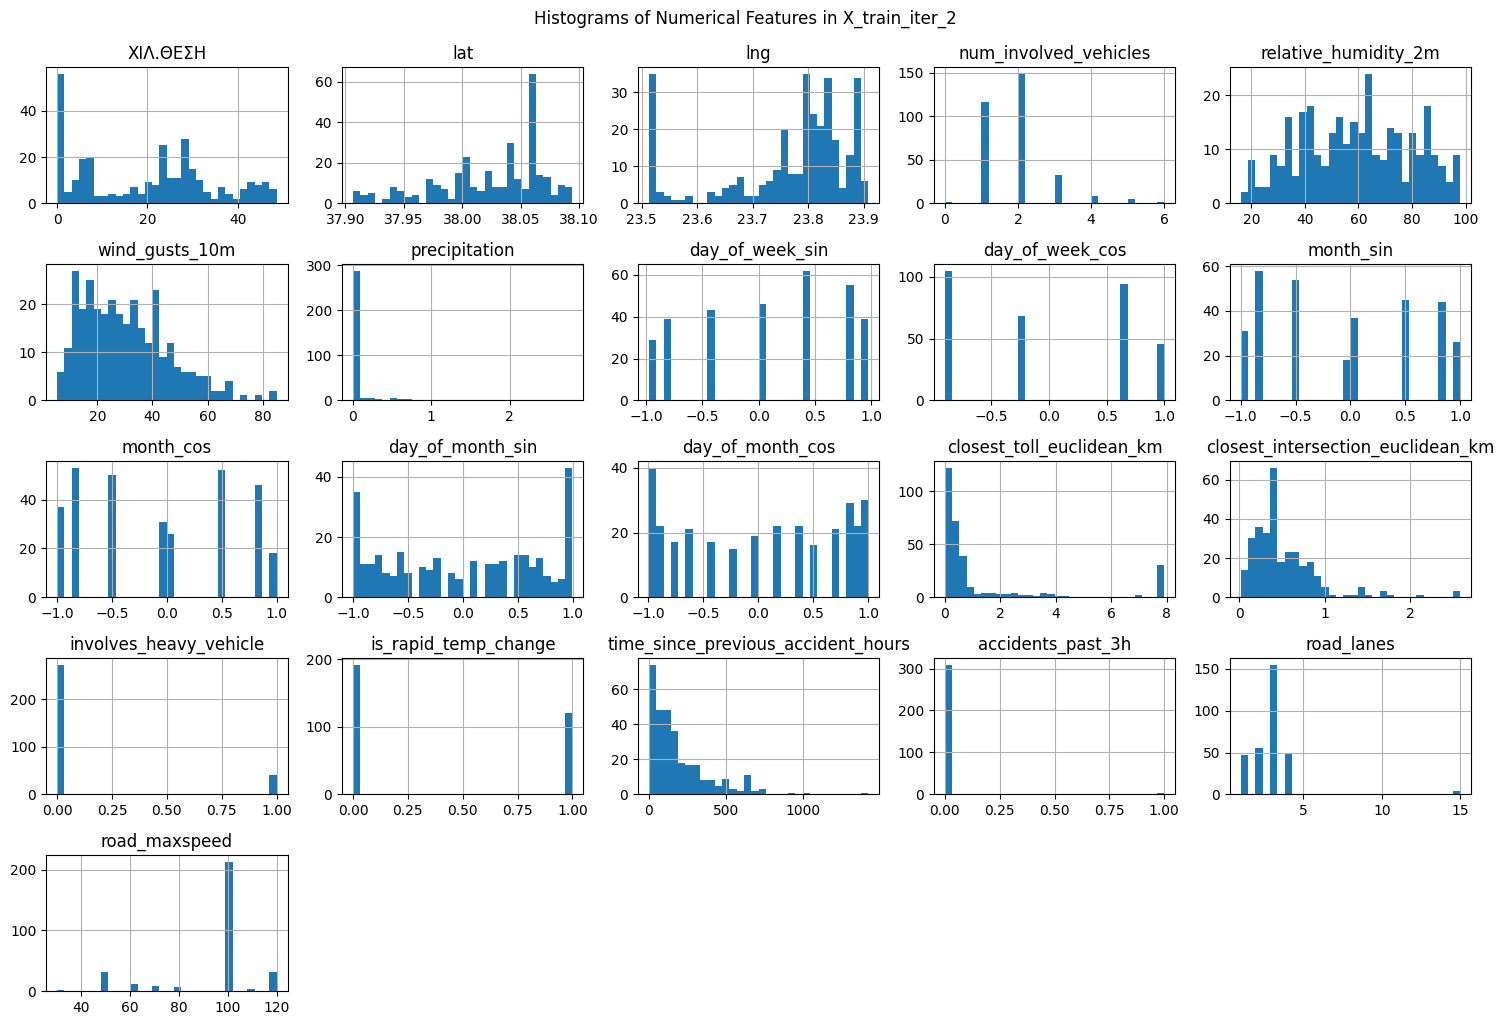

<Figure size 1500x1000 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Separate numerical and categorical features
numerical_features = X_train_iter_2.select_dtypes(include=np.number).columns
categorical_features = X_train_iter_2.select_dtypes(include='object').columns

print("Numerical Features:", list(numerical_features))
print("Categorical Features:", list(categorical_features))

# Analyze distribution of numerical features
if len(numerical_features) > 0:
    X_train_iter_2[numerical_features].hist(bins=30, figsize=(15, 10))
    plt.tight_layout()
    plt.suptitle('Histograms of Numerical Features in X_train_iter_2', y=1.02)
    plt.show()

    plt.figure(figsize=(15, 10))
else:
    print("No numerical features to plot.")


Plotting distribution for standard categorical features...


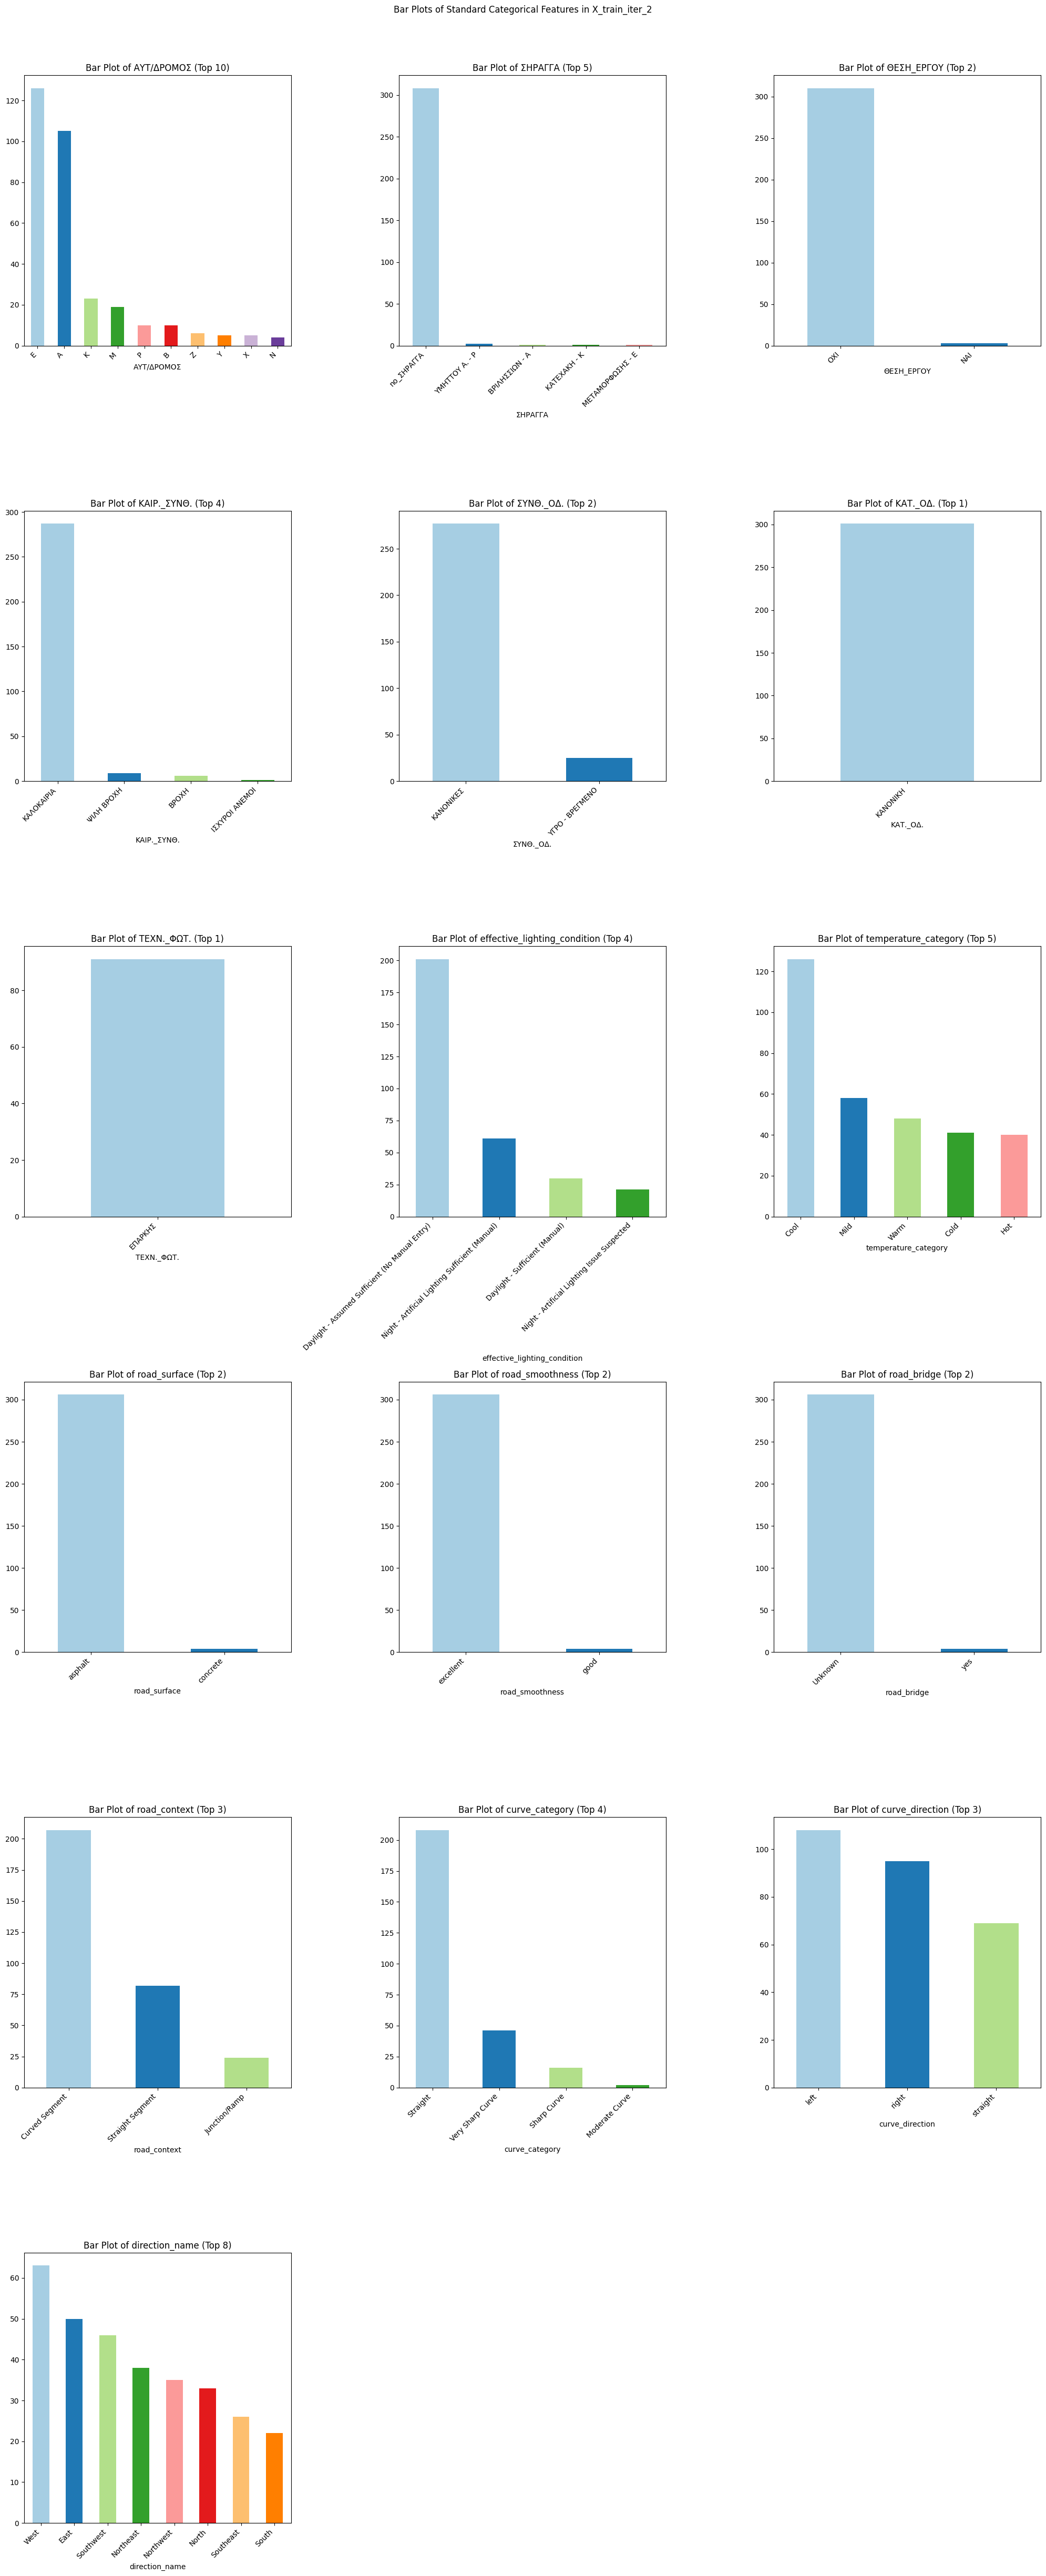


Plotting distribution for feature with long names: 'ΥΠΟΚΑΤΗΓΟΡΙΑ'


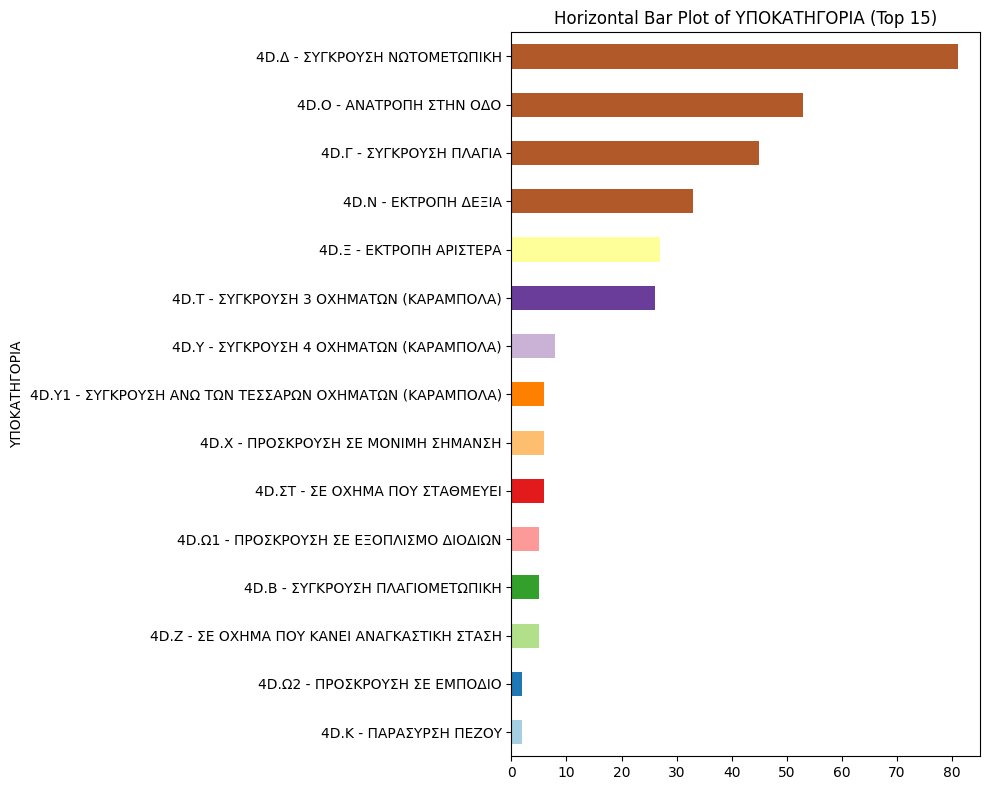


Top 10 values and counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ':
ΥΠΟΚΑΤΗΓΟΡΙΑ
4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ                              81
4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ                                   53
4D.Γ - ΣΥΓΚΡΟΥΣΗ ΠΛΑΓΙΑ                                    45
4D.Ν - ΕΚΤΡΟΠΗ ΔΕΞΙΑ                                       33
4D.Ξ - ΕΚΤΡΟΠΗ ΑΡΙΣΤΕΡΑ                                    27
4D.Τ - ΣΥΓΚΡΟΥΣΗ 3 ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)                    26
4D.Υ - ΣΥΓΚΡΟΥΣΗ 4 ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)                     8
4D.ΣΤ - ΣΕ ΟΧΗΜΑ ΠΟΥ ΣΤΑΘΜΕΥΕΙ                              6
4D.Υ1 - ΣΥΓΚΡΟΥΣΗ ΑΝΩ ΤΩΝ ΤΕΣΣΑΡΩΝ ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)     6
4D.Χ - ΠΡΟΣΚΡΟΥΣΗ ΣΕ ΜΟΝΙΜΗ ΣΗΜΑΝΣΗ                         6
Name: count, dtype: int64


In [ ]:
# Analyze distribution of categorical features
if len(categorical_features) > 0:

    # Identify features that are high cardinality or have very long names
    # Add any other categorical features that cause plotting issues here
    high_cardinality_features = ['segment_id', 'geohash_p7']
    problematic_name_features = ['ΥΠΟΚΑΤΗΓΟΡΙΑ'] # Features known to have long names

    # Features to plot in the standard bar plots
    features_to_plot = [
        col for col in categorical_features
        if col not in high_cardinality_features and col not in problematic_name_features
    ]

    if len(features_to_plot) > 0:
        print("\nPlotting distribution for standard categorical features...")
        plt.figure(figsize=(20, max(15, len(features_to_plot) * 3))) # Adjust figure height dynamically
        num_cols = 3
        num_rows = (len(features_to_plot) + num_cols - 1) // num_cols # Ceiling division

        for i, col in enumerate(features_to_plot):
            plt.subplot(num_rows, num_cols, i + 1)
            # Consider showing only top N categories if still crowded
            top_n = X_train_iter_2[col].value_counts().nlargest(10) # Show top 10 categories
            top_n.plot(kind='bar', color=plt.cm.Paired(np.arange(len(top_n))))
            plt.title(f'Bar Plot of {col} (Top {len(top_n)})')
            plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.suptitle('Bar Plots of Standard Categorical Features in X_train_iter_2', y=1.02)
        plt.show()
    else:
        print("No standard categorical features suitable for bar plots.")


    # --- Optional: Handle problematic features separately ---

    # For high cardinality features, maybe just print top values
    for col in high_cardinality_features:
        if col in categorical_features:
            print(f"\nTop 10 values and counts for high cardinality feature '{col}':")
            # Ensure value_counts handles potential NaNs appropriately
            print(X_train_iter_2[col].value_counts(dropna=False).head(10))


    # For features with long names, you might try horizontal bars or printing
    for col in problematic_name_features:
         if col in categorical_features:
            print(f"\nPlotting distribution for feature with long names: '{col}'")
            plt.figure(figsize=(10, 8))
            # Use horizontal bar plot (barh)
            # Show top N categories if still too many
            top_n = X_train_iter_2[col].value_counts().nlargest(15) # Show top 15 categories
            top_n.sort_values().plot(kind='barh', color=plt.cm.Paired(np.arange(len(top_n))))
            plt.title(f'Horizontal Bar Plot of {col} (Top {len(top_n)})')
            plt.tight_layout()
            plt.show()
            # Also print top values
            print(f"\nTop 10 values and counts for '{col}':")
            print(X_train_iter_2[col].value_counts(dropna=False).head(10))


else:
    print("No categorical features to plot or analyze.")

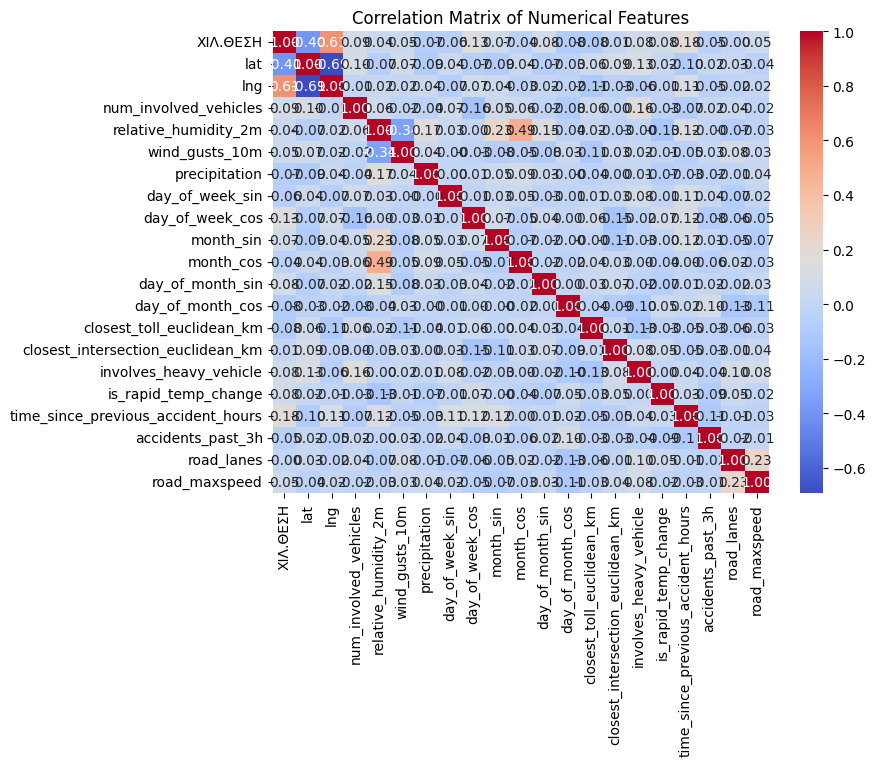

In [ ]:
# Analyze correlation between numerical features
if len(numerical_features) > 1:
    correlation_matrix = X_train_iter_2[numerical_features].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()
else:
    print("Not enough numerical features to compute correlation matrix.")

## spatial feature engineering

In [ ]:
if 'X_train_iter_2' in locals() and 'lat' in X_train_iter_2.columns and 'lng' in X_train_iter_2.columns: # Check if data and columns exist
    N_BINS = 8 # Example number of bins for gridding
    GEOHASH_PRECISION = 7 # Example geohash precision
    KDE_BANDWIDTH = 0.05 # Example KDE bandwidth - VERY SENSITIVE, needs tuning/domain knowledge

    # --- Create Road Segment ID using the adjusted function ---
    if 'ΑΥΤ/ΔΡΟΜΟΣ' in X_train_iter_2.columns and 'ΧΙΛ.ΘΕΣΗ' in X_train_iter_2.columns:
        # Call the adjusted function
        X_train_iter_2 = create_road_segment_feature_adjusted(X_train_iter_2)
        X_val_iter_2 = create_road_segment_feature_adjusted(X_val_iter_2)
        X_test_iter_2 = create_road_segment_feature_adjusted(X_test_iter_2)
        print("Adjusted road segment ID feature created.")
        # You can check the counts of the new categories:
        # print("Value counts for adjusted segment_id in X_train_iter_2:")
        # print(X_train_iter_2['segment_id'].value_counts().head(10))
    else:
        print("Skipping road segment ID creation: Required columns not found.")


    # --- Apply Coordinate Binning ---
    # (No changes needed here, ensure 'lat'/'lng' are present if you run this)
    if 'lat' in X_train_iter_2.columns and 'lng' in X_train_iter_2.columns:
        X_train_iter_2 = create_coordinate_bins(X_train_iter_2, n_bins=N_BINS, fit_df=X_train_iter_2.copy())
        X_val_iter_2 = create_coordinate_bins(X_val_iter_2, n_bins=N_BINS, fit_df=X_train_iter_2.copy())
        X_test_iter_2 = create_coordinate_bins(X_test_iter_2, n_bins=N_BINS, fit_df=X_train_iter_2.copy())
        print(f"Coordinate bins ({N_BINS}x{N_BINS}) created.")
    else:
        print("Skipping coordinate binning: lat/lng columns not found.")


    # --- Apply Geohashing ---
    # (No changes needed here, ensure 'lat'/'lng' are present)
    if 'lat' in X_train_iter_2.columns and 'lng' in X_train_iter_2.columns:
        X_train_iter_2 = apply_geohash(X_train_iter_2, precision=GEOHASH_PRECISION)
        X_val_iter_2 = apply_geohash(X_val_iter_2, precision=GEOHASH_PRECISION)
        X_test_iter_2 = apply_geohash(X_test_iter_2, precision=GEOHASH_PRECISION)
        print(f"Geohash (precision {GEOHASH_PRECISION}) features created.")
    else:
        print("Skipping geohashing: lat/lng columns not found.")


    # --- Apply KDE Score ---
    # (No changes needed here, ensure 'lat'/'lng' are present)
    if 'lat' in X_train_iter_2.columns and 'lng' in X_train_iter_2.columns:
        X_train_iter_2_coords_for_kde = X_train_iter_2[['lat', 'lng']].dropna()
        if not X_train_iter_2_coords_for_kde.empty:
            X_train_iter_2 = apply_kde_score(X_train_iter_2.dropna(subset=['lat', 'lng']), X_train_iter_2_coords_for_kde, bandwidth=KDE_BANDWIDTH)
            X_val_iter_2 = apply_kde_score(X_val_iter_2.dropna(subset=['lat', 'lng']), X_train_iter_2_coords_for_kde, bandwidth=KDE_BANDWIDTH)
            X_test_iter_2 = apply_kde_score(X_test_iter_2.dropna(subset=['lat', 'lng']), X_train_iter_2_coords_for_kde, bandwidth=KDE_BANDWIDTH)

            # X_train_iter_2['kde_score'].fillna(0.0, inplace=True)
            X_train_iter_2.fillna({'kde_score':0.0},inplace=True)
            # X_val_iter_2['kde_score'].fillna(0.0, inplace=True)
            X_val_iter_2.fillna({'kde_score':0.0},inplace=True)
            # X_test_iter_2['kde_score'].fillna(0.0, inplace=True)
            X_test_iter_2.fillna({'kde_score':0.0},inplace=True)

            print("KDE scores created.")
        else:
            print("Skipping KDE: No valid coordinates in X_train_iter_2 to fit KDE.")
            X_train_iter_2['kde_score'] = 0.0
            X_val_iter_2['kde_score'] = 0.0
            X_test_iter_2['kde_score'] = 0.0
    else:
        print("Skipping KDE score: lat/lng columns not found.")


    # Display some of the new features
    # (Ensure the column name for segment_id matches what's created, e.g. 'segment_id')
    new_spatial_cols = []
    if f'grid_cell_{N_BINS}x{N_BINS}' in X_train_iter_2.columns: new_spatial_cols.append(f'grid_cell_{N_BINS}x{N_BINS}')
    if f'geohash_p{GEOHASH_PRECISION}' in X_train_iter_2.columns: new_spatial_cols.append(f'geohash_p{GEOHASH_PRECISION}')
    if 'kde_score' in X_train_iter_2.columns: new_spatial_cols.append('kde_score')
    # Check for the actual segment_id column name, assuming it's 'segment_id' from prefix='segment'
    if 'segment_id' in X_train_iter_2.columns: new_spatial_cols.append('segment_id')

    new_spatial_cols = [col for col in new_spatial_cols if col in X_train_iter_2.columns]
    if new_spatial_cols:
        print("\nSample of new spatial features in X_train_iter_2:")
        # In Colab, display() is better for DataFrames
        try:
            display(X_train_iter_2[new_spatial_cols].head())
        except NameError: # If display() is not available (e.g. standard Python script)
            print(X_train_iter_2[new_spatial_cols].head())

    else:
        print("\nNo new spatial features were added or found to display.")

else:
    print("Skipping spatial feature engineering: X_train_iter_2 or key columns not available.")
# Ensure X_train, X_val, X_test from the train_test_split of df_iter2 are available.
# Ensure all your spatial feature engineering functions are defined from the first code block.
# Make sure Counter from collections is imported for the downsampling part if you want to check counts.
# from collections import Counter # If not already imported

# if 'X_train_iter_2' in locals() and 'lat' in X_train_iter_2.columns and 'lng' in X_train_iter_2.columns:
#     N_BINS = 8
#     GEOHASH_PRECISION = 7
#     KDE_BANDWIDTH = 0.05 # You set this, and it will be passed to apply_kde_score

#     print(f"\n--- Iteration X: Spatial Feature Engineering (with KDE Downsampling) ---")
#     print(f"Original X_train_iter_2 shape before spatial eng: {X_train_iter_2.shape}")


#     # --- 1. Create Road Segment ID using the adjusted function ---
#     # This function should be called first as 'segment_id' is used for downsampling KDE data.
#     if 'ΑΥΤ/ΔΡΟΜΟΣ' in X_train_iter_2.columns and 'ΧΙΛ.ΘΕΣΗ' in X_train_iter_2.columns:
#         X_train_iter_2 = create_road_segment_feature_adjusted(X_train_iter_2)
#         X_val_iter_2 = create_road_segment_feature_adjusted(X_val_iter_2)
#         X_test_iter_2 = create_road_segment_feature_adjusted(X_test_iter_2)
#         print("Adjusted road segment ID feature created.")
#     else:
#         print("Skipping road segment ID creation: Required columns not found.")
#         # If segment_id cannot be created, KDE downsampling based on it cannot proceed as planned.
#         # Add dummy 'segment_id' if it's critical for subsequent steps to not fail,
#         # or ensure code handles its absence. For now, we assume it's created.
#         if 'segment_id' not in X_train_iter_2.columns: X_train_iter_2['segment_id'] = 'unknown_segment'
#         if 'segment_id' not in X_val_iter_2.columns: X_val_iter_2['segment_id'] = 'unknown_segment'
#         if 'segment_id' not in X_test_iter_2.columns: X_test_iter_2['segment_id'] = 'unknown_segment'


#     # --- Downsampling logic for KDE fitting data (from X_train_iter_2) ---
#     # This X_train_iter_2 now has 'segment_id', 'lat', 'lng'
#     print("\nPreparing data for KDE model fitting with downsampling of high-frequency segments...")

#     # Create a copy of X_train_iter_2 specifically for preparing the KDE fitting data
#     # This copy should have 'segment_id', 'lat', 'lng'
#     X_train_iter_2_for_kde_fitting_preparation = X_train_iter_2.copy()

#     segments_to_downsample = [
#         "A_EntryZone_Or_UnknownKM",
#         "E_EntryZone_Or_UnknownKM",
#         # Add other re-categorized "0.0" segments like M_0.0, K_0.0 if they become e.g.,
#         # "M_EntryZone_Or_UnknownKM", "K_EntryZone_Or_UnknownKM" or whatever their segment_id is
#     ]
#     # To be more robust, you might identify these high-frequency segments dynamically
#     # For example, any segment with more than X occurrences if you don't want to hardcode.
#     # For now, using the hardcoded list based on prior observation.

#     N_SAMPLES_PER_SEGMENT_FOR_KDE = 3 # Max samples from each high-frequency segment for KDE fit

#     downsampled_dfs_for_kde = []
#     other_dfs_for_kde = []

#     # Ensure 'segment_id' exists before trying to use it for downsampling
#     if 'segment_id' in X_train_iter_2_for_kde_fitting_preparation.columns:
#         # Check actual unique segment_id values to correctly identify M_0.0 and K_0.0 if they were not re-categorized
#         # The create_road_segment_feature_adjusted re-categorizes A_0.0 and E_0.0.
#         # If M_0.0 and K_0.0 become "M_0.0" and "K_0.0" as segment_id, add them to segments_to_downsample list.
#         # Example: segments_to_downsample.extend(["M_0.0", "K_0.0"])

#         print(f"Segments identified for potential downsampling in KDE: {segments_to_downsample}")
#         print(f"Target samples per downsampled segment for KDE: {N_SAMPLES_PER_SEGMENT_FOR_KDE}")

#         for segment_name in X_train_iter_2_for_kde_fitting_preparation['segment_id'].unique():
#             segment_df = X_train_iter_2_for_kde_fitting_preparation[X_train_iter_2_for_kde_fitting_preparation['segment_id'] == segment_name]
#             if segment_name in segments_to_downsample:
#                 if len(segment_df) > N_SAMPLES_PER_SEGMENT_FOR_KDE:
#                     downsampled_dfs_for_kde.append(segment_df.sample(N_SAMPLES_PER_SEGMENT_FOR_KDE, random_state=42))
#                     print(f"Downsampled segment '{segment_name}' from {len(segment_df)} to {N_SAMPLES_PER_SEGMENT_FOR_KDE} for KDE fitting.")
#                 else:
#                     downsampled_dfs_for_kde.append(segment_df) # Keep all if less than N
#                     print(f"Segment '{segment_name}' has {len(segment_df)} samples (<=N), keeping all for KDE fitting.")
#             else:
#                 other_dfs_for_kde.append(segment_df)

#         temp_concat_list = downsampled_dfs_for_kde + other_dfs_for_kde
#         if temp_concat_list: # Ensure list is not empty before concat
#             X_train_iter_2_data_for_kde_fit = pd.concat(temp_concat_list)
#             print(f"Shape of data used to FIT KDE model after downsampling: {X_train_iter_2_data_for_kde_fit.shape}")
#         else:
#             print("Warning: No data selected for KDE fitting after downsampling attempt. Using original X_train_iter_2 for KDE fitting.")
#             X_train_iter_2_data_for_kde_fit = X_train_iter_2_for_kde_fitting_preparation # Fallback
#     else:
#         print("Warning: 'segment_id' column not found in X_train_iter_2. Skipping downsampling for KDE. Using original X_train_iter_2 for KDE fitting.")
#         X_train_iter_2_data_for_kde_fit = X_train_iter_2_for_kde_fitting_preparation # Fallback

#     # Now, X_train_iter_2_coords_for_kde should be derived from this potentially downsampled DataFrame
#     if 'lat' in X_train_iter_2_data_for_kde_fit.columns and 'lng' in X_train_iter_2_data_for_kde_fit.columns:
#         X_train_iter_2_coords_for_kde_fitting = X_train_iter_2_data_for_kde_fit[['lat', 'lng']].dropna()
#     else:
#         print("Warning: lat/lng not in X_train_iter_2_data_for_kde_fit. KDE might fail or be inaccurate.")
#         X_train_iter_2_coords_for_kde_fitting = pd.DataFrame(columns=['lat','lng']) # Empty DF to prevent error


#     # --- Apply Coordinate Binning ---
#     # Uses X_train_iter_2 (original training split for this iter, now with segment_id) for fit_df
#     if 'lat' in X_train_iter_2.columns and 'lng' in X_train_iter_2.columns:
#         X_train_iter_2 = create_coordinate_bins(X_train_iter_2, n_bins=N_BINS, fit_df=X_train_iter_2.copy())
#         X_val_iter_2 = create_coordinate_bins(X_val_iter_2, n_bins=N_BINS, fit_df=X_train_iter_2.copy())
#         X_test_iter_2 = create_coordinate_bins(X_test_iter_2, n_bins=N_BINS, fit_df=X_train_iter_2.copy())
#         print(f"Coordinate bins ({N_BINS}x{N_BINS}) created.")
#     else:
#         print("Skipping coordinate binning: lat/lng columns not found in X_train_iter_2 (after segment_id creation).")

#     # --- Apply Geohashing ---
#     if 'lat' in X_train_iter_2.columns and 'lng' in X_train_iter_2.columns:
#         X_train_iter_2 = apply_geohash(X_train_iter_2, precision=GEOHASH_PRECISION)
#         X_val_iter_2 = apply_geohash(X_val_iter_2, precision=GEOHASH_PRECISION)
#         X_test_iter_2 = apply_geohash(X_test_iter_2, precision=GEOHASH_PRECISION)
#         print(f"Geohash (precision {GEOHASH_PRECISION}) features created.")
#     else:
#         print("Skipping geohashing: lat/lng columns not found.")


#     # --- Apply KDE Score ---
#     # The KDE model is FIT using X_train_iter_2_coords_for_kde_fitting (from downsampled data)
#     # Then, this fitted KDE model is used to SCORE the original X_train_iter_2, X_val_iter_2, X_test_iter_2 (which still have all their rows)
#     if not X_train_iter_2_coords_for_kde_fitting.empty and \
#        all(col in X_train_iter_2.columns for col in ['lat','lng']) and \
#        all(col in X_val_iter_2.columns for col in ['lat','lng']) and \
#        all(col in X_test_iter_2.columns for col in ['lat','lng']):

#         print(f"Fitting KDE model using data of shape: {X_train_iter_2_coords_for_kde_fitting.shape}")
#         X_train_iter_2 = apply_kde_score(X_train_iter_2, X_train_iter_2_coords_for_kde_fitting, bandwidth=KDE_BANDWIDTH)
#         X_val_iter_2 = apply_kde_score(X_val_iter_2, X_train_iter_2_coords_for_kde_fitting, bandwidth=KDE_BANDWIDTH)
#         X_test_iter_2 = apply_kde_score(X_test_iter_2, X_train_iter_2_coords_for_kde_fitting, bandwidth=KDE_BANDWIDTH)
#         # fillna for kde_score is now inside apply_kde_score function
#         print("KDE scores created (KDE model fit on potentially downsampled training data).")
#     else:
#         print("Skipping KDE score creation: Not enough valid coordinates for fitting KDE or lat/lng missing in X_train_iter_2/X_val_iter_2/X_test_iter_2.")
#         X_train_iter_2['kde_score'] = 0.0
#         X_val['kde_score'] = 0.0
#         X_test_iter_2['kde_score'] = 0.0

#     # Display some of the new features
#     new_spatial_cols = []
#     if f'grid_cell_{N_BINS}x{N_BINS}' in X_train_iter_2.columns: new_spatial_cols.append(f'grid_cell_{N_BINS}x{N_BINS}')
#     if f'geohash_p{GEOHASH_PRECISION}' in X_train_iter_2.columns: new_spatial_cols.append(f'geohash_p{GEOHASH_PRECISION}')
#     if 'kde_score' in X_train_iter_2.columns: new_spatial_cols.append('kde_score')
#     if 'segment_id' in X_train_iter_2.columns: new_spatial_cols.append('segment_id')

#     new_spatial_cols = [col for col in new_spatial_cols if col in X_train_iter_2.columns] # Should not be necessary if checks above are fine
#     if new_spatial_cols:
#         print("\nSample of new spatial features in X_train_iter_2 (post all spatial engineering):")
#         try:
#             display(X_train_iter_2[new_spatial_cols].head())
#         except NameError:
#             print(X_train_iter_2[new_spatial_cols].head())
#     else:
#         print("\nNo new spatial features were available to display.")
# else:
#     print("Skipping spatial feature engineering: Initial X_train or lat/lng columns not found.")

Adjusted road segment ID feature created.
Coordinate bins (8x8) created.
Geohash (precision 7) features created.
KDE scores created.

Sample of new spatial features in X_train_iter_2:


grid_cell_8x8 geohash_p7  kde_score                segment_id
262           6_4    swbbef4  14.062409                    A_20.6
177           5_6    swbbmuw  27.942050                    A_29.6
419           6_0    swb8x1r   8.395720                     E_1.0
256           6_0    swb8x04   8.286283  A_EntryZone_Or_UnknownKM
483           0_7    sw8zxwp   9.308883                    A_46.7

In [ ]:
X_test_iter_2.columns

Index(['ΑΥΤ/ΔΡΟΜΟΣ', 'ΧΙΛ.ΘΕΣΗ', 'ΣΗΡΑΓΓΑ', 'ΥΠΟΚΑΤΗΓΟΡΙΑ', 'ΘΕΣΗ_ΕΡΓΟΥ',
       'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'ΚΑΤ._ΟΔ.', 'ΤΕΧΝ._ΦΩΤ.', 'lat', 'lng',
       'num_involved_vehicles', 'has_ΙΧΕ', 'has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ', 'has_ΔΙΚΥΚΛΟ',
       'has_ΦΟΡΤΗΓΟ', 'has_ΤΑΞΙ', 'has_ΛΕΩΦΟΡΕΙΟ', 'has_Μ.Ε.',
       'effective_lighting_condition', 'temperature_category',
       'relative_humidity_2m', 'wind_gusts_10m', 'precipitation',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_of_month_sin', 'day_of_month_cos', 'closest_toll_euclidean_km',
       'closest_intersection_euclidean_km', 'involves_heavy_vehicle',
       'is_rapid_temp_change', 'time_since_previous_accident_hours',
       'accidents_past_3h', 'road_lanes', 'road_maxspeed', 'road_surface',
       'road_smoothness', 'road_bridge', 'road_context', 'curve_category',
       'curve_direction', 'direction_name', 'segment_id', 'lat_bin_8',
       'lng_bin_8', 'grid_cell_8x8', 'geohash_p7', 'kde_score'],
      dt

In [ ]:
# X_train_iter_2, X_val_iter_2, X_test_iter_2 are your dataframes after spatial features are engineered
columns_to_drop_after_spatial_eng = ['lat', 'lng'] # Add any other raw source columns if needed

X_train_iter_2 = X_train_iter_2.drop(columns=columns_to_drop_after_spatial_eng, errors='ignore')
X_val_iter_2 = X_val_iter_2.drop(columns=columns_to_drop_after_spatial_eng, errors='ignore')
X_test_iter_2 = X_test_iter_2.drop(columns=columns_to_drop_after_spatial_eng, errors='ignore')

print(f"Dropped raw spatial columns: {columns_to_drop_after_spatial_eng}")

Dropped raw spatial columns: ['lat', 'lng']


In [ ]:
X_test_iter_2.columns

Index(['ΑΥΤ/ΔΡΟΜΟΣ', 'ΧΙΛ.ΘΕΣΗ', 'ΣΗΡΑΓΓΑ', 'ΥΠΟΚΑΤΗΓΟΡΙΑ', 'ΘΕΣΗ_ΕΡΓΟΥ',
       'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'ΚΑΤ._ΟΔ.', 'ΤΕΧΝ._ΦΩΤ.',
       'num_involved_vehicles', 'has_ΙΧΕ', 'has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ', 'has_ΔΙΚΥΚΛΟ',
       'has_ΦΟΡΤΗΓΟ', 'has_ΤΑΞΙ', 'has_ΛΕΩΦΟΡΕΙΟ', 'has_Μ.Ε.',
       'effective_lighting_condition', 'temperature_category',
       'relative_humidity_2m', 'wind_gusts_10m', 'precipitation',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_of_month_sin', 'day_of_month_cos', 'closest_toll_euclidean_km',
       'closest_intersection_euclidean_km', 'involves_heavy_vehicle',
       'is_rapid_temp_change', 'time_since_previous_accident_hours',
       'accidents_past_3h', 'road_lanes', 'road_maxspeed', 'road_surface',
       'road_smoothness', 'road_bridge', 'road_context', 'curve_category',
       'curve_direction', 'direction_name', 'segment_id', 'lat_bin_8',
       'lng_bin_8', 'grid_cell_8x8', 'geohash_p7', 'kde_score'],
      dtype='object')

## pre-processing

In [ ]:
if 'X_train_iter_2' in locals():
    # Identify feature types AFTER new spatial features are created
    # New categorical features from spatial engineering:
    new_cat_spatial_features = []
    if f'grid_cell_{N_BINS}x{N_BINS}' in X_train_iter_2.columns: new_cat_spatial_features.append(f'grid_cell_{N_BINS}x{N_BINS}')
    if f'geohash_p{GEOHASH_PRECISION}' in X_train_iter_2.columns: new_cat_spatial_features.append(f'geohash_p{GEOHASH_PRECISION}')
    if 'segment_id' in X_train_iter_2.columns: new_cat_spatial_features.append('segment_id')
    # Add more if you create other categorical spatial features e.g. lat_bin_N, lng_bin_N as separate features

    # New numerical features from spatial engineering:
    new_num_spatial_features = []
    if 'kde_score' in X_train_iter_2.columns: new_num_spatial_features.append('kde_score')


    all_categorical_features = X_train_iter_2.select_dtypes(include=['object', 'category']).columns.tolist()
    # Ensure our new spatial categoricals are included if not automatically detected as object/category
    for f in new_cat_spatial_features:
        if f not in all_categorical_features and f in X_train_iter_2.columns:
            all_categorical_features.append(f)
            X_train_iter_2[f] = X_train_iter_2[f].astype('category') # Ensure correct dtype
            X_val_iter_2[f] = X_val_iter_2[f].astype('category')
            X_test_iter_2[f] = X_test_iter_2[f].astype('category')


    # Features for 'unknown' imputation (original list)
    categorical_features_unknown_impute = [
        'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'ΚΑΤ._ΟΔ.', 'ΤΕΧΝ._ΦΩΤ.', "weather_description", 'effective_lighting_condition'
    ]
    categorical_features_unknown_impute = [col for col in categorical_features_unknown_impute if col in X_train_iter_2.columns and col in all_categorical_features]


    # Other categorical features (if any) for 'most_frequent' imputation
    # This will now include new_cat_spatial_features if they are not in the unknown_impute list
    categorical_features_mode_impute = [
        col for col in all_categorical_features if col not in categorical_features_unknown_impute
    ]

    boolean_features = X_train_iter_2.select_dtypes(include=['bool']).columns.tolist()
    for bf in boolean_features:
        X_train_iter_2[bf] = X_train_iter_2[bf].astype(int)
        X_val_iter_2[bf] = X_val_iter_2[bf].astype(int)
        X_test_iter_2[bf] = X_test_iter_2[bf].astype(int)

    numerical_features = X_train_iter_2.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
    # Ensure our new numerical spatial features are included
    for f in new_num_spatial_features:
        if f not in numerical_features and f in X_train_iter_2.columns:
            numerical_features.append(f)


    print(f"Final Numerical features for preprocessor: {numerical_features}")
    print(f"Final Categorical features for 'unknown' imputation: {categorical_features_unknown_impute}")
    print(f"Final Categorical features for 'most_frequent' imputation: {categorical_features_mode_impute}")


    # --- The rest of your ColumnTransformer and preprocessing code follows ---
    # Create preprocessing pipelines (as you had before)
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline_unknown = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    categorical_pipeline_mode = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')), # New spatial categoricals (grid_cell, geohash) usually don't have NaNs if created properly
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    transformers_list = []
    if numerical_features: # Add only if list is not empty
         transformers_list.append(('num', numerical_pipeline, numerical_features))
    if categorical_features_unknown_impute:
        transformers_list.append(('cat_unknown', categorical_pipeline_unknown, categorical_features_unknown_impute))
    if categorical_features_mode_impute:
        transformers_list.append(('cat_mode', categorical_pipeline_mode, categorical_features_mode_impute))

    preprocessor = ColumnTransformer(
        transformers=transformers_list,
        remainder='passthrough'
    )

    # Fit and transform (as you had before)
    # ... your existing code for fitting preprocessor and creating X_train_iter_2_processed_df ...
    # (No changes needed to that part if the feature lists fed into ColumnTransformer are correct)
    # Fit preprocessor on X_train_iter_2 and transform all sets
    X_train_iter_2_processed = preprocessor.fit_transform(X_train_iter_2)
    X_val_iter_2_processed = preprocessor.transform(X_val_iter_2)
    X_test_iter_2_processed = preprocessor.transform(X_test_iter_2)

    # Get feature names after one-hot encoding for RFE and interpretation
    try:
        feature_names_out = preprocessor.get_feature_names_out()
        X_train_iter_2_processed_df = pd.DataFrame(X_train_iter_2_processed, columns=feature_names_out, index=X_train_iter_2.index)
        X_val_iter_2_processed_df = pd.DataFrame(X_val_iter_2_processed, columns=feature_names_out, index=X_val_iter_2.index)
        X_test_iter_2_processed_df = pd.DataFrame(X_test_iter_2_processed, columns=feature_names_out, index=X_test_iter_2.index)
        print(f"Processed training data shape: {X_train_iter_2_processed_df.shape}")
    except Exception as e:
        print(f"Could not get feature names from preprocessor automatically: {e}")
        X_train_iter_2_processed_df = pd.DataFrame(X_train_iter_2_processed, index=X_train_iter_2.index)
        X_val_iter_2_processed_df = pd.DataFrame(X_val_iter_2_processed, index=X_val_iter_2.index)
        X_test_iter_2_processed_df = pd.DataFrame(X_test_iter_2_processed, index=X_test_iter_2.index)
        feature_names_out = X_train_iter_2_processed_df.columns.astype(str)
        print(f"Processed training data shape (generic column names): {X_train_iter_2_processed_df.shape}")

Final Numerical features for preprocessor: ['num_involved_vehicles', 'has_ΙΧΕ', 'has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ', 'has_ΔΙΚΥΚΛΟ', 'has_ΦΟΡΤΗΓΟ', 'has_ΤΑΞΙ', 'has_ΛΕΩΦΟΡΕΙΟ', 'has_Μ.Ε.', 'relative_humidity_2m', 'wind_gusts_10m', 'precipitation', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_month_sin', 'day_of_month_cos', 'closest_toll_euclidean_km', 'closest_intersection_euclidean_km', 'involves_heavy_vehicle', 'is_rapid_temp_change', 'time_since_previous_accident_hours', 'accidents_past_3h', 'road_lanes', 'road_maxspeed', 'lat_bin_8', 'lng_bin_8', 'kde_score']
Final Categorical features for 'unknown' imputation: ['ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'ΚΑΤ._ΟΔ.', 'ΤΕΧΝ._ΦΩΤ.', 'effective_lighting_condition']
Final Categorical features for 'most_frequent' imputation: ['ΑΥΤ/ΔΡΟΜΟΣ', 'ΧΙΛ.ΘΕΣΗ', 'ΣΗΡΑΓΓΑ', 'ΥΠΟΚΑΤΗΓΟΡΙΑ', 'ΘΕΣΗ_ΕΡΓΟΥ', 'temperature_category', 'road_surface', 'road_smoothness', 'road_bridge', 'road_context', 'curve_category', 'curve_direction', 'direction_name', 'segment

## colinerity


Mutual Information Scores (Top 15):
cat_mode__segment_id_E_48.3                                           0.052353
cat_mode__ΥΠΟΚΑΤΗΓΟΡΙΑ_4D.Ζ - ΣΕ ΟΧΗΜΑ ΠΟΥ ΚΑΝΕΙ ΑΝΑΓΚΑΣΤΙΚΗ ΣΤΑΣΗ    0.051152
cat_mode__ΧΙΛ.ΘΕΣΗ_5.1                                                0.048147
cat_mode__ΧΙΛ.ΘΕΣΗ_23.0                                               0.047790
cat_mode__geohash_p7_swbbefp                                          0.044118
num__precipitation                                                    0.041945
cat_mode__segment_id_E_25.8                                           0.040101
cat_mode__segment_id_A_23.8                                           0.040040
num__closest_intersection_euclidean_km                                0.039997
cat_mode__geohash_p7_swbbjdn                                          0.039333
cat_mode__geohash_p7_swbbqh2                                          0.037431
num__day_of_month_sin                                                 0.037287
num__closest_to

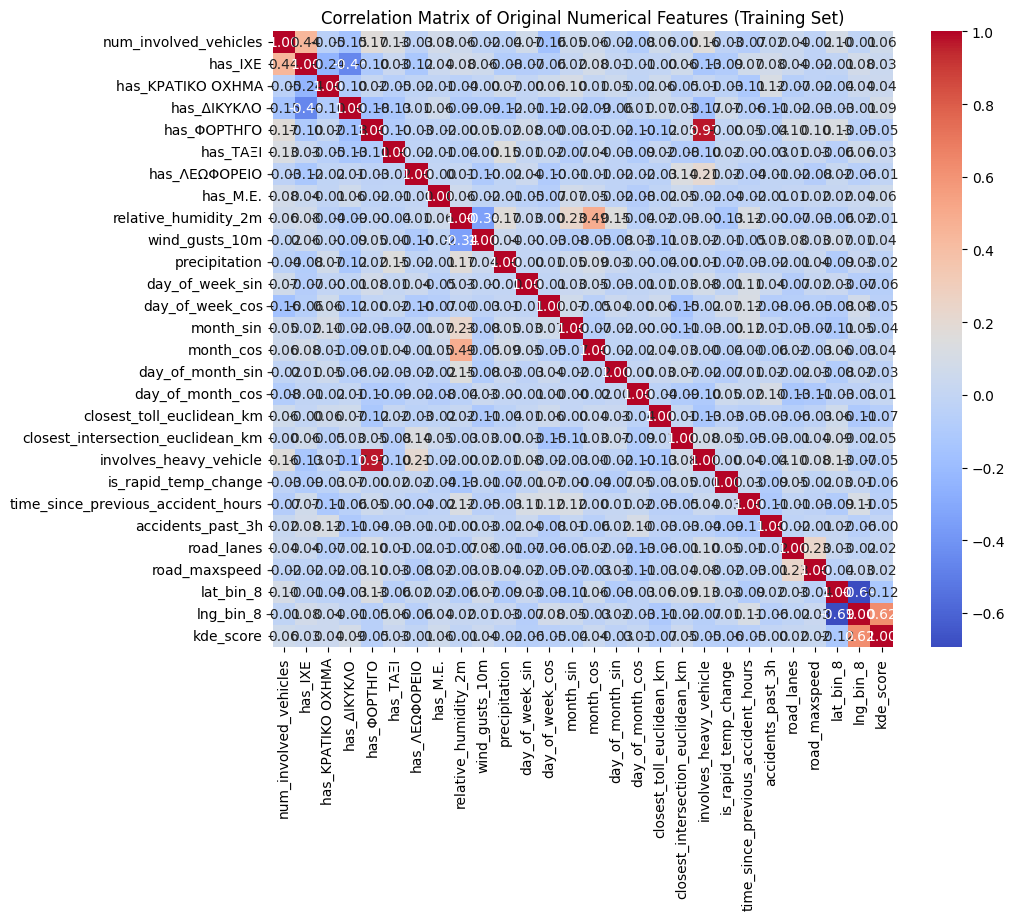

In [ ]:
if 'X_train_iter_2_processed_df' in locals():
    # Note: For filter methods, it's often better to use them on data *before* extensive transformations
    # if the transformations obscure original relationships (e.g. scaling for chi2).
    # However, for simplicity here, we use the processed data.
    # Ensure all data is non-negative for chi2 if applicable
    # For mutual_info_classif and f_classif, current processed data is fine.

    # Mutual Information (works for both num and cat (post-OHE))
    mi_scores = mutual_info_classif(X_train_iter_2_processed_df, y_train, random_state=42)
    mi_series = pd.Series(mi_scores, index=feature_names_out).sort_values(ascending=False)
    print("\nMutual Information Scores (Top 15):")
    print(mi_series.head(15))

    # Correlation (for numerical features in X_train_iter_2_processed_df - identify them again)
    # This is more complex with OHE. For now, let's skip detailed VIF on OHE.
    # A simple correlation heatmap on the original numerical features can be insightful:
    if len(numerical_features) > 1:
        plt.figure(figsize=(10, 8))
        sns.heatmap(X_train_iter_2[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Matrix of Original Numerical Features (Training Set)")
        plt.show()


## recursive feature elimination

In [ ]:
# if 'X_train_iter_2_processed_df' in locals():
#     estimator_rfe = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42, max_iter=1000)
#     # Decide on number of features to select, e.g., half or a fixed number
#     num_features_to_select = max(5, X_train_iter_2_processed_df.shape[1] // 2) # Example: select half, but at least 5

#     rfe = RFE(estimator=estimator_rfe, n_features_to_select=num_features_to_select, step=1)
#     rfe.fit(X_train_iter_2_processed_df, y_train_iter_2)

#     selected_features_rfe_mask = rfe.support_
#     selected_features_rfe = X_train_iter_2_processed_df.columns[selected_features_rfe_mask]
#     print(f"\nSelected features from RFE ({len(selected_features_rfe)}):")
#     print(selected_features_rfe.tolist())

#     # Update X_train_iter_2_processed_df and X_val_iter_2_processed_df for this iteration
#     X_train_iter_2_iter_final = X_train_iter_2_processed_df[selected_features_rfe]
#     X_val_iter_2_iter_final = X_val_iter_2_processed_df[selected_features_rfe]
#     X_test_iter_2_iter_final = X_test_iter_2_processed_df[selected_features_rfe] # Also transform test set
# else:
#     print("Skipping RFE as processed data is not available.")
#     # Fallback if RFE was skipped
#     if 'X_train_iter_2_processed_df' in locals():
#         X_train_iter_2_iter_final = X_train_iter_2_processed_df.copy()
#         X_val_iter_2_iter_final = X_val_iter_2_processed_df.copy()
#         X_test_iter_2_iter_final = X_test_iter_2_processed_df.copy()

## recursive feature analysis with cross validation


--- Iteration 2: Recursive Feature Elimination with Cross-Validation (RFECV) ---
RFECV will use the estimator: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')
Cross-validation strategy: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
Scoring metric for feature selection: 'roc_auc'
Fitting RFECV... (This might take some time)
Optimal number of features found by RFECV: 532

Selected features from RFECV (532):
Shape of X_train after RFECV: (313, 532)


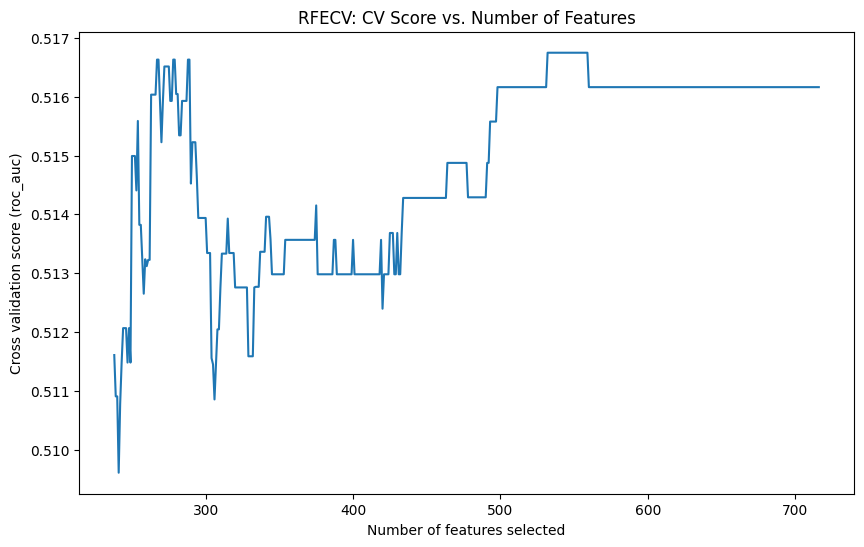

In [ ]:
# Ensure necessary imports
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression # Your chosen estimator
from sklearn.metrics import make_scorer, f1_score # For scoring if needed


if 'X_train_iter_2_processed_df' in locals() and X_train_iter_2_processed_df is not None and \
   'y_train_iter_2' in locals() and y_train_iter_2 is not None:

    print("\n--- Iteration 2: Recursive Feature Elimination with Cross-Validation (RFECV) ---")

    estimator_rfecv = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42, max_iter=1000)

    # Define the cross-validation strategy
    # StratifiedKFold is good for classification, especially with imbalanced classes
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Using 5 splits as an example

    # Define the scoring metric for RFECV to optimize
    # For imbalanced classes, 'f1', 'roc_auc', or 'average_precision' (PR AUC) are often better than 'accuracy'.
    # Let's use 'f1' for the positive class (assuming positive_label=1)
    # If your positive class is not 1, adjust pos_label
    # You can also use 'roc_auc', 'average_precision', etc.
    scorer_for_rfecv = make_scorer(f1_score, pos_label=1, average='binary', zero_division=0)
    # Alternatively, just use a string like 'f1_macro', 'roc_auc'.
    # For binary classification and focusing on the positive class, 'f1' (which defaults to f1 of positive class if pos_label=1) or 'roc_auc' are good.
    # Let's use 'roc_auc' as it's a common general-purpose metric for RFECV selection
    # and less prone to issues if a fold has no positive predictions for some feature subsets.

    print(f"RFECV will use the estimator: {estimator_rfecv}")
    print(f"Cross-validation strategy: {cv_strategy}")
    print(f"Scoring metric for feature selection: 'roc_auc'") # Or your chosen scorer

    rfecv = RFECV(
        estimator=estimator_rfecv,
        step=1,  # Remove 1 feature at each step
        cv=cv_strategy,
        scoring='roc_auc',  # Metric to optimize for feature selection
        min_features_to_select=max(5, X_train_iter_2_processed_df.shape[1] // 3), # Example: select at least 5 features, or 10%
        n_jobs=-1 # Use all available cores
    )

    print("Fitting RFECV... (This might take some time)")
    try:
        rfecv.fit(X_train_iter_2_processed_df, y_train_iter_2)

        print(f"Optimal number of features found by RFECV: {rfecv.n_features_}")

        # Get the mask of selected features
        selected_features_rfecv_mask = rfecv.support_

        # Get the names of the selected features
        # Ensure that X_train_iter_2_processed_df has columns attribute (it should if it's a DataFrame)
        selected_features_rfecv = X_train_iter_2_processed_df.columns[selected_features_rfecv_mask]

        print(f"\nSelected features from RFECV ({len(selected_features_rfecv)}):")
        # Printing all feature names can be very long, consider printing only a few or just the count
        # print(selected_features_rfecv.tolist())

        # Update DataFrames to keep only RFECV selected features
        X_train_iter_2_iter_final = X_train_iter_2_processed_df[selected_features_rfecv]
        X_val_iter_2_iter_final = X_val_iter_2_processed_df[selected_features_rfecv]
        X_test_iter_2_iter_final = X_test_iter_2_processed_df[selected_features_rfecv]

        print(f"Shape of X_train after RFECV: {X_train_iter_2_iter_final.shape}")

        # You can also plot the number of features vs. cross-validation scores
        if hasattr(rfecv, "cv_results_"):
            try:
                import matplotlib.pyplot as plt
                n_scores = len(rfecv.cv_results_["mean_test_score"]) # Number of features evaluated
                plt.figure(figsize=(10,6))
                plt.xlabel("Number of features selected")
                plt.ylabel(f"Cross validation score ({rfecv.scoring})")
                plt.plot(
                    range(rfecv.min_features_to_select, n_scores + rfecv.min_features_to_select), # X-axis: number of features
                    rfecv.cv_results_["mean_test_score"],
                )
                plt.title("RFECV: CV Score vs. Number of Features")
                plt.show()
            except Exception as plot_e:
                print(f"Could not plot RFECV scores: {plot_e}")

    except ValueError as ve:
        print(f"ValueError during RFECV fitting: {ve}")
        print("This might occur if input data is problematic or no features could be selected.")
        # Fallback: use all features from preprocessing if RFECV fails
        X_train_iter_2_iter_final = X_train_iter_2_processed_df.copy()
        X_val_iter_2_iter_final = X_val_iter_2_processed_df.copy()
        X_test_iter_2_iter_final = X_test_iter_2_processed_df.copy()
        print("Using all preprocessed features as RFECV failed.")
    except Exception as e:
        print(f"An unexpected error occurred during RFECV: {e}")
        X_train_iter_2_iter_final = X_train_iter_2_processed_df.copy() # Fallback
        X_val_iter_2_iter_final = X_val_iter_2_processed_df.copy()
        X_test_iter_2_iter_final = X_test_iter_2_processed_df.copy()
        print("Using all preprocessed features as RFECV encountered an error.")


else:
    print("Skipping RFECV as processed data (X_train_iter_2_processed_df or y_train_iter_2) is not available.")
    # Define fallback if previous steps failed
    if 'X_train_iter_2_processed_df' in locals() and X_train_iter_2_processed_df is not None:
        X_train_iter_2_iter_final = X_train_iter_2_processed_df.copy()
        X_val_iter_2_iter_final = X_val_iter_2_processed_df.copy() if 'X_val_iter_2_processed_df' in locals() and X_val_iter_2_processed_df is not None else None
        X_test_iter_2_iter_final = X_test_iter_2_processed_df.copy() if 'X_test_iter_2_processed_df' in locals() and X_test_iter_2_processed_df is not None else None
    else:
        X_train_iter_2_iter_final, X_val_iter_2_iter_final, X_test_iter_2_iter_final = None, None, None

In [ ]:
X_train_iter_2_iter_final.shape

(313, 532)

## balancing techniuqes

In [ ]:
# Previous code: X_train_iter_2_iter_final, y_train_iter_2, X_val_iter_final, y_val are defined

resampled_datasets_iter_2 = {} # To store (X_resampled, y_resampled) for each technique

if 'X_train_iter_2_iter_final' in locals() and X_train_iter_2_iter_final is not None and y_train_iter_2 is not None:
    print(f"\nOriginal training set shape: {X_train_iter_2_iter_final.shape}, Original class distribution: {Counter(y_train_iter_2)}")
    minority_class_count = Counter(y_train_iter_2).get(1, 0) # Assuming 1 is the minority class

    # Store the original (non-resampled) training data as a baseline
    resampled_datasets_iter_2['Original'] = (X_train_iter_2_iter_final.copy(), y_train_iter_2.copy())

    # Define samplers
    samplers = {
        "RandomOverSampler": RandomOverSampler(random_state=42),
        "SMOTE": None, # Will initialize carefully due to k_neighbors
        "ADASYN": None, # Will initialize carefully due to n_neighbors
        "TomekLinks": TomekLinks(sampling_strategy='auto', n_jobs=-1), # Undersampling, removes Tomek links
        "SMOTETomek": None, # Will initialize carefully
        "SMOTEENN": None # Will initialize carefully
    }

    # SMOTE and ADASYN require k_neighbors (or n_neighbors for ADASYN) < minority_class_count
    if minority_class_count > 1:
        k_val = min(4, minority_class_count - 1) # A common heuristic for k, ensuring it's less than minority samples

        if k_val > 0 : # Ensure k_val is positive
            samplers["SMOTE"] = SMOTE(random_state=42, k_neighbors=k_val)
            samplers["ADASYN"] = ADASYN(random_state=42, n_neighbors=k_val) # ADASYN uses n_neighbors
            samplers["SMOTETomek"] = SMOTETomek(random_state=42, smote=SMOTE(random_state=42, k_neighbors=k_val), tomek=TomekLinks(sampling_strategy='auto'), n_jobs=-1)
            samplers["SMOTEENN"] = SMOTEENN(random_state=42, smote=SMOTE(random_state=42, k_neighbors=k_val), enn=None, n_jobs=-1) # enn default is good
        else:
            print(f"Skipping SMOTE-based samplers as k_val ({k_val}) would be too small or zero based on minority count ({minority_class_count}).")
            # Remove them if they can't be initialized
            for key in ["SMOTE", "ADASYN", "SMOTETomek", "SMOTEENN"]:
                if key in samplers: samplers.pop(key)

    else:
        print(f"Skipping SMOTE-based samplers as minority count ({minority_class_count}) is <= 1.")
        for key in ["SMOTE", "ADASYN", "SMOTETomek", "SMOTEENN"]:
            if key in samplers: samplers.pop(key)


    # Apply each sampler
    for name, sampler in samplers.items():
        if sampler is None: # Sampler was not initialized
            continue
        print(f"\nApplying {name}...")
        try:
            X_res, y_res = sampler.fit_resample(X_train_iter_2_iter_final, y_train_iter_2)
            resampled_datasets_iter_2[name] = (X_res, y_res)
            print(f"Resampled with {name}: X_shape={X_res.shape}, y_dist={Counter(y_res)}")
        except Exception as e:
            print(f"Could not apply {name}. Error: {e}")
            # Optionally store original if sampler fails, or skip
            # resampled_datasets_iter_2[name] = (X_train_iter_2_iter_final.copy(), y_train_iter_2.copy())


    if not resampled_datasets_iter_2: # If all samplers failed or were skipped
        print("No resampling techniques were successfully applied or initialized. Using original data only.")
        if 'Original' not in resampled_datasets_iter_2: # Should already be there
             resampled_datasets_iter_2['Original'] = (X_train_iter_2_iter_final.copy(), y_train_iter_2.copy())


else:
    print("Skipping balancing as X_train_iter_2_iter_final or y_train_iter_2 is not available.")
    # Ensure there's at least 'Original' if X_train_iter_2_iter_final was available
    if 'X_train_iter_2_iter_final' in locals() and X_train_iter_2_iter_final is not None and y_train_iter_2 is not None:
        resampled_datasets_iter_2['Original'] = (X_train_iter_2_iter_final.copy(), y_train_iter_2.copy())


Original training set shape: (313, 532), Original class distribution: Counter({0: 284, 1: 29})

Applying RandomOverSampler...
Resampled with RandomOverSampler: X_shape=(568, 532), y_dist=Counter({0: 284, 1: 284})

Applying SMOTE...
Resampled with SMOTE: X_shape=(568, 532), y_dist=Counter({0: 284, 1: 284})

Applying ADASYN...
Resampled with ADASYN: X_shape=(558, 532), y_dist=Counter({0: 284, 1: 274})

Applying TomekLinks...
Resampled with TomekLinks: X_shape=(297, 532), y_dist=Counter({0: 268, 1: 29})

Applying SMOTETomek...
Resampled with SMOTETomek: X_shape=(568, 532), y_dist=Counter({0: 284, 1: 284})

Applying SMOTEENN...
Resampled with SMOTEENN: X_shape=(377, 532), y_dist=Counter({1: 284, 0: 93})


## model training

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier # Ensure this import is present


trained_models_iter_2 = {} # To store trained models: key will be "ModelName_SamplerName"

if 'resampled_datasets_iter_2' in locals() and resampled_datasets_iter_2:
    minority_class_label = 1 # Assuming 'death' is 1
    f1_minority_scorer = make_scorer(f1_score, pos_label=minority_class_label, average='binary') # For CV if you add it later

    for sampler_name, (X_train_curr_resampled, y_train_curr_resampled) in resampled_datasets_iter_2.items():
        print(f"\n--- Training models on data from: {sampler_name} ---")
        print(f"Training data shape: {X_train_curr_resampled.shape}, Distribution: {Counter(y_train_curr_resampled)}")

        # Define your models here or ensure they are defined from a previous cell
        # Re-initialize models for each dataset to ensure they are fresh

        # Calculate scale_pos_weight for XGBoost based on the current resampled data
        counts_curr = Counter(y_train_curr_resampled)
        scale_pos_weight_curr = counts_curr[0] / counts_curr[1] if counts_curr[1] > 0 else 1

        # calculate the ratio of the target variable in the training set in order to
        # get the weights for the custom ratio logistic regression
        counts_curr = Counter(y_train_curr_resampled)
        n_majority = counts_curr.get(0, 0) # Count of class 0 (assuming majority)
        n_minority = counts_curr.get(1, 0) # Count of class 1 (assuming minority)

        if n_minority > 0 and n_majority > 0:
          # A simple inverse frequency ratio: weight_minority = N_majority / N_minority
          # Or, to make the majority weight 1, weight_minority = N_majority / N_minority
          # Or inversely proportional to frequency: weight_i = 1 / freq_i
          # For 1:9 ratio, N_majority / N_minority is approx 9 / 1 = 9
          # Let's use a ratio where the minority class weight is 9 times the majority class weight.
          # We can arbitrarily set the majority weight to 1 and the minority weight to 9.
          # custom_class_weights = {0: 1.0, 1: 9.0} # Using floats is standard
          weight_minority = n_majority / n_minority
          custom_class_weights = {0: 1.0, 1: weight_minority}


        current_models_definitions = {
            'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000),
            'LogisticRegression_custom_ratio':LogisticRegression(solver='liblinear',random_state=42,class_weight=custom_class_weights,max_iter=1000),
            'LogisticRegression_L1': LogisticRegression(solver='liblinear', penalty='l1', random_state=42, class_weight='balanced', max_iter=1000),
            'LogisticRegression_L2':LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000, penalty='l2'),
            'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced_subsample', n_estimators=100),
            'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss',
                             scale_pos_weight=scale_pos_weight_curr),
            'BalancedRandomForest': BalancedRandomForestClassifier(random_state=42, n_estimators=100, sampling_strategy='auto', replacement=True, n_jobs=-1),
            'RUSBoost': RUSBoostClassifier(random_state=42, n_estimators=50, sampling_strategy='auto') # n_estimators often lower for boosting
        }
        # Note on class_weight='balanced':
        # For 'Original' data (imbalanced), it's useful.
        # For data resampled to be perfectly balanced (e.g., SMOTE to 50/50), class_weight='balanced' might have less effect
        # or could be omitted, but it generally doesn't hurt and can help if balance isn't perfect.

        for model_name, model_instance in current_models_definitions.items():
            full_model_name = f"{model_name}_{sampler_name}"
            print(f"Training {full_model_name}...")
            try:
                model_instance.fit(X_train_curr_resampled, y_train_curr_resampled)
                trained_models_iter_2[full_model_name] = model_instance
                print(f"{full_model_name} trained.")
            except Exception as e:
                print(f"Could not train {full_model_name}. Error: {e}")
                trained_models_iter_2[full_model_name] = None # Store None if training failed

else:
    print("Skipping model training as no resampled datasets are available.")


--- Training models on data from: Original ---
Training data shape: (313, 532), Distribution: Counter({0: 284, 1: 29})
Training LogisticRegression_Original...
LogisticRegression_Original trained.
Training LogisticRegression_custom_ratio_Original...
LogisticRegression_custom_ratio_Original trained.
Training LogisticRegression_L1_Original...
LogisticRegression_L1_Original trained.
Training LogisticRegression_L2_Original...
LogisticRegression_L2_Original trained.
Training RandomForest_Original...
RandomForest_Original trained.
Training XGBoost_Original...
XGBoost_Original trained.
Training BalancedRandomForest_Original...
BalancedRandomForest_Original trained.
Training RUSBoost_Original...
RUSBoost_Original trained.

--- Training models on data from: RandomOverSampler ---
Training data shape: (568, 532), Distribution: Counter({0: 284, 1: 284})
Training LogisticRegression_RandomOverSampler...
LogisticRegression_RandomOverSampler trained.
Training LogisticRegression_custom_ratio_RandomOver

## model evaluation

In [ ]:
if 'trained_models_iter_2' in locals() and trained_models_iter_2 and \
   'X_val_iter_2_iter_final' in locals() and X_val_iter_2_iter_final is not None and y_val_iter_2 is not None:

    print("\n--- Model Assessment on Validation Set ---")

    # Store results for later comparison if needed
    validation_results_iter_2 = {}

    for full_model_name, model in trained_models_iter_2.items():
        if model is not None: # Check if model was trained
            print(f"\n--- Assessing: {full_model_name} ---")
            try:
                y_pred_val_iter_2 = model.predict(X_val_iter_2_iter_final)
                y_proba_val_iter_2 = model.predict_proba(X_val_iter_2_iter_final)[:, 1] # Probability of positive class

                report = classification_report(y_val_iter_2, y_pred_val_iter_2, target_names=['Injury (0)', 'Death (1)'], output_dict=True)
                roc_auc = roc_auc_score(y_val_iter_2, y_proba_val_iter_2)
                precision_pr, recall_pr, _ = precision_recall_curve(y_val_iter_2, y_proba_val_iter_2)
                pr_auc = auc(recall_pr, precision_pr)
                conf_matrix = confusion_matrix(y_val_iter_2, y_pred_val_iter_2)

                print(classification_report(y_val_iter_2, y_pred_val_iter_2, target_names=['Injury (0)', 'Death (1)']))
                print(f"Confusion Matrix:\n{conf_matrix}")
                print(f"ROC AUC: {roc_auc:.4f}")
                print(f"PR AUC: {pr_auc:.4f}")

                # Store results
                validation_results_iter_2[full_model_name] = {
                    'classification_report': report,
                    'confusion_matrix': conf_matrix.tolist(), # convert numpy array to list for easier storage/JSON
                    'roc_auc': roc_auc,
                    'pr_auc': pr_auc,
                    'f1_death': report.get('Death (1)', {}).get('f1-score', 0), # F1 for minority class
                    'recall_death': report.get('Death (1)', {}).get('recall', 0) # Recall for minority class
                }
            except Exception as e:
                print(f"Could not assess {full_model_name}. Error: {e}")
                validation_results_iter_2[full_model_name] = {'error': str(e)}
        else:
            print(f"Model {full_model_name} was not trained, skipping assessment.")
            validation_results_iter_2[full_model_name] = {'error': 'Model not trained'}

    # Optional: Print a summary table of key metrics from validation_results_iter_2
    if validation_results_iter_2:
        print("\n--- Validation Results Summary (F1 and Recall for Death class, PR AUC) ---")
        summary_df = pd.DataFrame([
            {'Model_Sampler': name,
             'F1_Death': data.get('f1_death', 'N/A'),
             'Recall_Death': data.get('recall_death', 'N/A'),
             'PR_AUC': data.get('pr_auc', 'N/A'),
             'ROC_AUC': data.get('roc_auc', 'N/A')}
            for name, data in validation_results_iter_2.items() if 'error' not in data
        ])
        if not summary_df.empty:
            summary_df = summary_df.sort_values(by='F1_Death', ascending=False) # Sort by F1 for death class
            try:
                display(summary_df) # Works well in Colab
            except NameError:
                print(summary_df)
        else:
            print("No valid results to summarize.")


else:
    print("Skipping model assessment: Trained models or validation data are not available.")


--- Model Assessment on Validation Set ---

--- Assessing: LogisticRegression_Original ---
              precision    recall  f1-score   support

  Injury (0)       0.89      0.78      0.83        95
   Death (1)       0.05      0.10      0.06        10

    accuracy                           0.71       105
   macro avg       0.47      0.44      0.45       105
weighted avg       0.81      0.71      0.76       105

Confusion Matrix:
[[74 21]
 [ 9  1]]
ROC AUC: 0.4526
PR AUC: 0.0787

--- Assessing: LogisticRegression_custom_ratio_Original ---
              precision    recall  f1-score   support

  Injury (0)       0.88      0.79      0.83        95
   Death (1)       0.00      0.00      0.00        10

    accuracy                           0.71       105
   macro avg       0.44      0.39      0.42       105
weighted avg       0.80      0.71      0.75       105

Confusion Matrix:
[[75 20]
 [10  0]]
ROC AUC: 0.4505
PR AUC: 0.0783

--- Assessing: LogisticRegression_L1_Original ---
      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

              precision    recall  f1-score   support

  Injury (0)       0.90      0.94      0.92        95
   Death (1)       0.00      0.00      0.00        10

    accuracy                           0.85       105
   macro avg       0.45      0.47      0.46       105
weighted avg       0.81      0.85      0.83       105

Confusion Matrix:
[[89  6]
 [10  0]]
ROC AUC: 0.5021
PR AUC: 0.0940

--- Assessing: BalancedRandomForest_Original ---
              precision    recall  f1-score   support

  Injury (0)       0.88      0.39      0.54        95
   Death (1)       0.08      0.50      0.14        10

    accuracy                           0.40       105
   macro avg       0.48      0.44      0.34       105
weighted avg       0.80      0.40      0.50       105

Confusion Matrix:
[[37 58]
 [ 5  5]]
ROC AUC: 0.4295
PR AUC: 0.0784

--- Assessing: RUSBoost_Original ---
              precision    recall  f1-score   support

  Injury (0)       0.88      0.53      0.66        95
   Death (1) 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

              precision    recall  f1-score   support

  Injury (0)       0.90      0.95      0.92        95
   Death (1)       0.00      0.00      0.00        10

    accuracy                           0.86       105
   macro avg       0.45      0.47      0.46       105
weighted avg       0.81      0.86      0.84       105

Confusion Matrix:
[[90  5]
 [10  0]]
ROC AUC: 0.5211
PR AUC: 0.0950

--- Assessing: BalancedRandomForest_RandomOverSampler ---
              precision    recall  f1-score   support

  Injury (0)       0.90      1.00      0.95        95
   Death (1)       0.00      0.00      0.00        10

    accuracy                           0.90       105
   macro avg       0.45      0.50      0.47       105
weighted avg       0.82      0.90      0.86       105

Confusion Matrix:
[[95  0]
 [10  0]]
ROC AUC: 0.4221
PR AUC: 0.0769

--- Assessing: RUSBoost_RandomOverSampler ---
              precision    recall  f1-score   support

  Injury (0)       0.90      0.73      0.80      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

              precision    recall  f1-score   support

  Injury (0)       0.89      0.87      0.88        95
   Death (1)       0.00      0.00      0.00        10

    accuracy                           0.79       105
   macro avg       0.45      0.44      0.44       105
weighted avg       0.81      0.79      0.80       105

Confusion Matrix:
[[83 12]
 [10  0]]
ROC AUC: 0.4137
PR AUC: 0.0738

--- Assessing: LogisticRegression_L2_SMOTE ---
              precision    recall  f1-score   support

  Injury (0)       0.89      0.81      0.85        95
   Death (1)       0.00      0.00      0.00        10

    accuracy                           0.73       105
   macro avg       0.44      0.41      0.42       105
weighted avg       0.80      0.73      0.77       105

Confusion Matrix:
[[77 18]
 [10  0]]
ROC AUC: 0.4305
PR AUC: 0.0760

--- Assessing: RandomForest_SMOTE ---
              precision    recall  f1-score   support

  Injury (0)       0.90      0.99      0.94        95
   Death (1)  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

              precision    recall  f1-score   support

  Injury (0)       0.88      0.77      0.82        95
   Death (1)       0.00      0.00      0.00        10

    accuracy                           0.70       105
   macro avg       0.44      0.38      0.41       105
weighted avg       0.80      0.70      0.74       105

Confusion Matrix:
[[73 22]
 [10  0]]
ROC AUC: 0.4558
PR AUC: 0.0792

--- Assessing: LogisticRegression_L1_ADASYN ---
              precision    recall  f1-score   support

  Injury (0)       0.90      0.86      0.88        95
   Death (1)       0.07      0.10      0.08        10

    accuracy                           0.79       105
   macro avg       0.49      0.48      0.48       105
weighted avg       0.82      0.79      0.81       105

Confusion Matrix:
[[82 13]
 [ 9  1]]
ROC AUC: 0.4421
PR AUC: 0.0788

--- Assessing: LogisticRegression_L2_ADASYN ---
              precision    recall  f1-score   support

  Injury (0)       0.88      0.77      0.82        95
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

              precision    recall  f1-score   support

  Injury (0)       0.91      0.96      0.93        95
   Death (1)       0.20      0.10      0.13        10

    accuracy                           0.88       105
   macro avg       0.56      0.53      0.53       105
weighted avg       0.84      0.88      0.86       105

Confusion Matrix:
[[91  4]
 [ 9  1]]
ROC AUC: 0.4358
PR AUC: 0.0849

--- Assessing: BalancedRandomForest_TomekLinks ---
              precision    recall  f1-score   support

  Injury (0)       0.89      0.35      0.50        95
   Death (1)       0.09      0.60      0.15        10

    accuracy                           0.37       105
   macro avg       0.49      0.47      0.33       105
weighted avg       0.82      0.37      0.47       105

Confusion Matrix:
[[33 62]
 [ 4  6]]
ROC AUC: 0.4889
PR AUC: 0.0868
Model RUSBoost_TomekLinks was not trained, skipping assessment.

--- Assessing: LogisticRegression_SMOTETomek ---
              precision    recall  f1-score 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

              precision    recall  f1-score   support

  Injury (0)       0.90      1.00      0.95        95
   Death (1)       0.00      0.00      0.00        10

    accuracy                           0.90       105
   macro avg       0.45      0.50      0.47       105
weighted avg       0.82      0.90      0.86       105

Confusion Matrix:
[[95  0]
 [10  0]]
ROC AUC: 0.6074
PR AUC: 0.1194

--- Assessing: RUSBoost_SMOTETomek ---
              precision    recall  f1-score   support

  Injury (0)       0.90      0.97      0.93        95
   Death (1)       0.00      0.00      0.00        10

    accuracy                           0.88       105
   macro avg       0.45      0.48      0.47       105
weighted avg       0.82      0.88      0.85       105

Confusion Matrix:
[[92  3]
 [10  0]]
ROC AUC: 0.4289
PR AUC: 0.0759

--- Assessing: LogisticRegression_SMOTEENN ---
              precision    recall  f1-score   support

  Injury (0)       0.94      0.51      0.66        95
   Death (1) 

Model_Sampler  F1_Death  Recall_Death  \
49                     LogisticRegression_L1_SMOTEENN  0.246154           0.8   
53                      BalancedRandomForest_SMOTEENN  0.235294           0.2   
48           LogisticRegression_custom_ratio_SMOTEENN  0.222222           0.7   
47                        LogisticRegression_SMOTEENN  0.218750           0.7   
50                     LogisticRegression_L2_SMOTEENN  0.218750           0.7   
54                                  RUSBoost_SMOTEENN  0.158730           0.5   
21                                      XGBoost_SMOTE  0.153846           0.1   
44                                 XGBoost_SMOTETomek  0.153846           0.1   
38                    BalancedRandomForest_TomekLinks  0.153846           0.6   
29                                     XGBoost_ADASYN  0.142857           0.1   
6                       BalancedRandomForest_Original  0.136986           0.5   
37                                 XGBoost_TomekLinks  0.133333           0.1   
51                              RandomForest_SMOTEENN  0.129032           0.2   
52                                   XGBoost_SMOTEENN  0.111111           0.2   
15                         RUSBoost_RandomOverSampler  0.105263           0.2   
7                                   RUSBoost_Original  0.103448           0.3   
26                       LogisticRegression_L1_ADASYN  0.083333           0.1   
2                      LogisticRegression_L1_Original  0.068966           0.1   
34                   LogisticRegression_L1_TomekLinks  0.062500           0.1   
3                      LogisticRegression_L2_Original  0.062500           0.1   
0                         LogisticRegression_Original  0.062500           0.1   
5                                    XGBoost_Original  0.000000           0.0   
4                               RandomForest_Original  0.000000           0.0   
22                         BalancedRandomForest_SMOTE  0.000000           0.0   
20                                 RandomForest_SMOTE  0.000000           0.0   
19                        LogisticRegression_L2_SMOTE  0.000000           0.0   
18                        LogisticRegression_L1_SMOTE  0.000000           0.0   
16                           LogisticRegression_SMOTE  0.000000           0.0   
17              LogisticRegression_custom_ratio_SMOTE  0.000000           0.0   
13                          XGBoost_RandomOverSampler  0.000000           0.0   
14             BalancedRandomForest_RandomOverSampler  0.000000           0.0   
10            LogisticRegression_L1_RandomOverSampler  0.000000           0.0   
9   LogisticRegression_custom_ratio_RandomOverSampler  0.000000           0.0   
12                     RandomForest_RandomOverSampler  0.000000           0.0   
11            LogisticRegression_L2_RandomOverSampler  0.000000           0.0   
8                LogisticRegression_RandomOverSampler  0.000000           0.0   
1            LogisticRegression_custom_ratio_Original  0.000000           0.0   
24                          LogisticRegression_ADASYN  0.000000           0.0   
25             LogisticRegression_custom_ratio_ADASYN  0.000000           0.0   
35                   LogisticRegression_L2_TomekLinks  0.000000           0.0   
36                            RandomForest_TomekLinks  0.000000           0.0   
32                      LogisticRegression_TomekLinks  0.000000           0.0   
33         LogisticRegression_custom_ratio_TomekLinks  0.000000           0.0   
31                                    RUSBoost_ADASYN  0.000000           0.0   
27                       LogisticRegression_L2_ADASYN  0.000000           0.0   
28                                RandomForest_ADASYN  0.000000           0.0   
30                        BalancedRandomForest_ADASYN  0.000000           0.0   
23                                     RUSBoost_SMOTE  0.000000           0.0   
46                                RUSBoost_SMOTETomek  0.000000        

## error analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # To ensure display works if in Colab/Jupyter

# --- Enhanced Helper Function for Error Analysis ---
def perform_more_comprehensive_error_analysis(
    model_name, model,
    X_val_processed_features, y_true_labels,
    X_val_original_features, # DataFrame with original, interpretable features
    key_categorical_features, # List of key categorical feature names to analyze
    key_numerical_features, # List of key numerical feature names to analyze
    target_class_name='Death', positive_label=1, negative_label=0
):
    print(f"\n--- Comprehensive Error Analysis for: {model_name} ---")

    if model is None:
        print("Model is None, skipping analysis.")
        return None

    # Make predictions and get probabilities
    y_pred = model.predict(X_val_processed_features)
    try:
        y_pred_proba = model.predict_proba(X_val_processed_features)[:, positive_label] # Probability of positive class
    except AttributeError:
        y_pred_proba = None # Model might not have predict_proba (e.g., some SVMs)
        print("Warning: Model does not have predict_proba method.")


    # Ensure indices match for proper alignment
    if not X_val_original_features.index.equals(y_true_labels.index):
        print("Error: Indices of X_val_original_features and y_true_labels do not match!")
        # Attempt to reindex
        if len(X_val_original_features) == len(y_true_labels):
            print("Attempting to reindex X_val_original_features...")
            X_val_original_features = X_val_original_features.reindex(y_true_labels.index)
            if not X_val_original_features.index.equals(y_true_labels.index):
                 print("Reindexing failed. Critical error.")
                 return None
        else:
            print("Cannot reindex due to different lengths. Critical error.")
            return None

    analysis_df = X_val_original_features.copy()
    analysis_df['actual_severity'] = y_true_labels
    analysis_df['predicted_severity'] = y_pred
    if y_pred_proba is not None:
        analysis_df[f'predicted_proba_{target_class_name}'] = y_pred_proba

    # Define groups
    tp_data = analysis_df[(analysis_df['actual_severity'] == positive_label) & (analysis_df['predicted_severity'] == positive_label)]
    fp_data = analysis_df[(analysis_df['actual_severity'] == negative_label) & (analysis_df['predicted_severity'] == positive_label)]
    fn_data = analysis_df[(analysis_df['actual_severity'] == positive_label) & (analysis_df['predicted_severity'] == negative_label)]
    tn_data = analysis_df[(analysis_df['actual_severity'] == negative_label) & (analysis_df['predicted_severity'] == negative_label)]

    print(f"\nOverall Validation Set Performance ({model_name}):")
    print(f"Total cases: {len(analysis_df)}")
    print(f"Actual {target_class_name}s: {len(tp_data) + len(fn_data)}")
    print(f"Predicted {target_class_name}s: {len(tp_data) + len(fp_data)}")
    print(f"TP ({target_class_name}): {len(tp_data)}, FP ({target_class_name}): {len(fp_data)}, FN ({target_class_name}): {len(fn_data)}, TN (Not {target_class_name}): {len(tn_data)}")

    groups = {'TP': tp_data, 'FN': fn_data, 'FP': fp_data, 'TN': tn_data}

    for group_name, group_df in groups.items():
        if group_df.empty:
            print(f"\nNo data for {group_name} group.")
            continue
        print(f"\n--- Characteristics of {group_name} for {target_class_name} (Count: {len(group_df)}) ---")

        # Display full describe for the group
        try:
            print(f"Overall descriptive stats for {group_name}:")
            display(group_df.describe(include='all').transpose().fillna('')) # Fill NaN for cleaner display
        except Exception as e:
            print(f"Could not display describe for {group_name}: {e}")

        # Numerical features comparison
        if key_numerical_features:
            print(f"\nNumerical Feature Summaries for {group_name}:")
            try:
                display(group_df[[col for col in key_numerical_features if col in group_df.columns]].describe().transpose().fillna(''))
            except Exception as e:
                print(f"Could not display numerical summaries for {group_name}: {e}")


        # Categorical features comparison
        if key_categorical_features:
            print(f"\nCategorical Feature Value Counts (Top 5) for {group_name}:")
            for col in key_categorical_features:
                if col in group_df.columns:
                    print(f"\nValue counts for '{col}' in {group_name}:")
                    try:
                        display(group_df[col].value_counts(normalize=True, dropna=False).head().to_frame())
                    except Exception as e:
                        print(f"Could not display value_counts for {col} in {group_name}: {e}")

        # Misclassification probabilities if available
        if y_pred_proba is not None and group_name in ['FP', 'FN']:
             print(f"\nPredicted Probabilities for {group_name}:")
             try:
                display(group_df[[f'predicted_proba_{target_class_name}']].describe().transpose().fillna(''))
             except Exception as e:
                print(f"Could not display probability summaries for {group_name}: {e}")


    # Optional: Side-by-side comparison for a few very critical features
    # This part can be expanded significantly
    if key_numerical_features:
        for feature in key_numerical_features:
            if feature in analysis_df.columns:
                plt.figure(figsize=(10, 4))
                sns.histplot(data=analysis_df, x=feature, hue='actual_severity', kde=True, multiple="stack")
                plt.title(f'Distribution of {feature} by Actual Severity')
                plt.show()

                plt.figure(figsize=(10,4))
                sns.boxplot(data=analysis_df, x='actual_severity', y=feature)
                plt.title(f'Boxplot of {feature} by Actual Severity')
                plt.show()


    print(f"\n--- End of Error Analysis for: {model_name} ---")
    return analysis_df # Return the dataframe with predictions for further manual inspection

In [ ]:
# Example:
key_cats = ['ΥΠΟΚΑΤΗΓΟΡΙΑ', 'segment_id', 'effective_lighting_condition', 'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.']
key_nums = ['num_involved_vehicles', 'kde_score', 'wind_gusts_10m', 'relative_humidity_2m'] # Add your numerical features

# Filter them to ensure they exist in the df_for_error_analysis passed to the function
# This should be done where you define df_for_error_analysis
# key_cats = [col for col in key_cats if col in df_for_error_analysis.columns]
# key_nums = [col for col in key_nums if col in df_for_error_analysis.columns]


--- Comprehensive Error Analysis for: LogisticRegression_L1_SMOTEENN ---

Overall Validation Set Performance (LogisticRegression_L1_SMOTEENN):
Total cases: 105
Actual Deaths: 10
Predicted Deaths: 55
TP (Death): 8, FP (Death): 47, FN (Death): 2, TN (Not Death): 48

--- Characteristics of TP for Death (Count: 8) ---
Overall descriptive stats for TP:


<ipython-input-49-5996070e4ce6>:73: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  display(group_df.describe(include='all').transpose().fillna('')) # Fill NaN for cleaner display


count unique  \
ΑΥΤ/ΔΡΟΜΟΣ                      8.0      2   
ΧΙΛ.ΘΕΣΗ                        8.0      8   
ΣΗΡΑΓΓΑ                         8.0      1   
ΥΠΟΚΑΤΗΓΟΡΙΑ                    8.0      8   
ΘΕΣΗ_ΕΡΓΟΥ                      8.0      1   
ΚΑΙΡ._ΣΥΝΘ.                     8.0      1   
ΣΥΝΘ._ΟΔ.                       8.0      2   
ΚΑΤ._ΟΔ.                        8.0      1   
ΤΕΧΝ._ΦΩΤ.                      2.0      1   
num_involved_vehicles           8.0          
has_ΙΧΕ                         8.0          
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ               8.0          
has_ΔΙΚΥΚΛΟ                     8.0          
has_ΦΟΡΤΗΓΟ                     8.0          
has_ΤΑΞΙ                        8.0          
has_ΛΕΩΦΟΡΕΙΟ                   8.0          
has_Μ.Ε.                        8.0          
effective_lighting_condition    8.0      4   
segment_id                      8.0      8   
lat_bin_8                       8.0          
lng_bin_8                       8.0          
grid_cell_8x8                   8.0      6   
geohash_p7                      8.0      8   
kde_score                       8.0          
actual_severity                 8.0          
predicted_severity              8.0          
predicted_proba_Death           8.0          

                                                                          top  \
ΑΥΤ/ΔΡΟΜΟΣ                                                                  E   
ΧΙΛ.ΘΕΣΗ                                                                 27.8   
ΣΗΡΑΓΓΑ                                                            no_ΣΗΡΑΓΓΑ   
ΥΠΟΚΑΤΗΓΟΡΙΑ                                         4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ   
ΘΕΣΗ_ΕΡΓΟΥ                                                                ΟΧΙ   
ΚΑΙΡ._ΣΥΝΘ.                                                        ΚΑΛΟΚΑΙΡΙΑ   
ΣΥΝΘ._ΟΔ.                                                           ΚΑΝΟΝΙΚΕΣ   
ΚΑΤ._ΟΔ.                                                             ΚΑΝΟΝΙΚΗ   
ΤΕΧΝ._ΦΩΤ.                                                            ΕΠΑΡΚΗΣ   
num_involved_vehicles                                                           
has_ΙΧΕ                                                                         
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                                                               
has_ΔΙΚΥΚΛΟ                                                                     
has_ΦΟΡΤΗΓΟ                                                                     
has_ΤΑΞΙ                                                                        
has_ΛΕΩΦΟΡΕΙΟ                                                                   
has_Μ.Ε.                                                                        
effective_lighting_condition  Daylight - Assumed Sufficient (No Manual Entry)   
segment_id                                                             A_27.8   
lat_bin_8                                                                       
lng_bin_8                                                                       
grid_cell_8x8                                                         6.0_4.0   
geohash_p7                                                            swbbmt8   
kde_score                                                                       
actual_severity                                                                 
predicted_severity                                                              
predicted_proba_Death                                                           

                             freq      mean        std       min       25%  \
ΑΥΤ/ΔΡΟΜΟΣ                      5                                            
ΧΙΛ.ΘΕΣΗ                        1                                            
ΣΗΡΑΓΓΑ                         8                                            
ΥΠΟΚΑΤΗΓΟΡΙΑ                    1                                            
ΘΕΣΗ_ΕΡΓΟΥ                      8                                            
ΚΑΙΡ


Numerical Feature Summaries for TP:


count      mean        std       min       25%  \
num_involved_vehicles    8.0   1.62500   0.744024  1.000000  1.000000   
kde_score                8.0  17.71335  10.445094  3.269787  9.005302   

                             50%        75%        max  
num_involved_vehicles   1.500000   2.000000   3.000000  
kde_score              21.025389  25.598393  29.192338


Categorical Feature Value Counts (Top 5) for TP:

Value counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ' in TP:


proportion
ΥΠΟΚΑΤΗΓΟΡΙΑ                                           
4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ                          0.125
4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ                     0.125
4D.Ξ - ΕΚΤΡΟΠΗ ΑΡΙΣΤΕΡΑ                           0.125
4D.Ζ - ΣΕ ΟΧΗΜΑ ΠΟΥ ΚΑΝΕΙ ΑΝΑΓΚΑΣΤΙΚΗ ΣΤΑΣΗ       0.125
4D.Τ - ΣΥΓΚΡΟΥΣΗ 3 ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)           0.125


Value counts for 'segment_id' in TP:


proportion
segment_id            
A_27.8           0.125
E_46.3           0.125
E_26.9           0.125
A_3.9            0.125
E_24.0           0.125


Value counts for 'effective_lighting_condition' in TP:


proportion
effective_lighting_condition                               
Daylight - Assumed Sufficient (No Manual Entry)       0.500
Night - Artificial Lighting Issue Suspected           0.250
Night - Artificial Lighting Sufficient (Manual)       0.125
Daylight - Sufficient (Manual)                        0.125


Value counts for 'ΚΑΙΡ._ΣΥΝΘ.' in TP:


proportion
ΚΑΙΡ._ΣΥΝΘ.            
ΚΑΛΟΚΑΙΡΙΑ          1.0


Value counts for 'ΣΥΝΘ._ΟΔ.' in TP:


proportion
ΣΥΝΘ._ΟΔ.                  
ΚΑΝΟΝΙΚΕΣ             0.875
ΥΓΡΟ - ΒΡΕΓΜΕΝΟ       0.125

<ipython-input-49-5996070e4ce6>:73: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  display(group_df.describe(include='all').transpose().fillna('')) # Fill NaN for cleaner display



--- Characteristics of FN for Death (Count: 2) ---
Overall descriptive stats for FN:


count unique  \
ΑΥΤ/ΔΡΟΜΟΣ                      2.0      2   
ΧΙΛ.ΘΕΣΗ                        2.0      2   
ΣΗΡΑΓΓΑ                         2.0      1   
ΥΠΟΚΑΤΗΓΟΡΙΑ                    2.0      2   
ΘΕΣΗ_ΕΡΓΟΥ                      2.0      1   
ΚΑΙΡ._ΣΥΝΘ.                     2.0      1   
ΣΥΝΘ._ΟΔ.                       2.0      1   
ΚΑΤ._ΟΔ.                        2.0      1   
ΤΕΧΝ._ΦΩΤ.                      1.0      1   
num_involved_vehicles           2.0          
has_ΙΧΕ                         2.0          
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ               2.0          
has_ΔΙΚΥΚΛΟ                     2.0          
has_ΦΟΡΤΗΓΟ                     2.0          
has_ΤΑΞΙ                        2.0          
has_ΛΕΩΦΟΡΕΙΟ                   2.0          
has_Μ.Ε.                        2.0          
effective_lighting_condition    2.0      2   
segment_id                      2.0      2   
lat_bin_8                       2.0          
lng_bin_8                       2.0          
grid_cell_8x8                   2.0      2   
geohash_p7                      2.0      2   
kde_score                       2.0          
actual_severity                 2.0          
predicted_severity              2.0          
predicted_proba_Death           2.0          

                                                                          top  \
ΑΥΤ/ΔΡΟΜΟΣ                                                                  A   
ΧΙΛ.ΘΕΣΗ                                                                 19.8   
ΣΗΡΑΓΓΑ                                                            no_ΣΗΡΑΓΓΑ   
ΥΠΟΚΑΤΗΓΟΡΙΑ                                           4D.Κ - ΠΑΡΑΣΥΡΣΗ ΠΕΖΟΥ   
ΘΕΣΗ_ΕΡΓΟΥ                                                                ΟΧΙ   
ΚΑΙΡ._ΣΥΝΘ.                                                        ΚΑΛΟΚΑΙΡΙΑ   
ΣΥΝΘ._ΟΔ.                                                           ΚΑΝΟΝΙΚΕΣ   
ΚΑΤ._ΟΔ.                                                             ΚΑΝΟΝΙΚΗ   
ΤΕΧΝ._ΦΩΤ.                                                            ΕΠΑΡΚΗΣ   
num_involved_vehicles                                                           
has_ΙΧΕ                                                                         
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                                                               
has_ΔΙΚΥΚΛΟ                                                                     
has_ΦΟΡΤΗΓΟ                                                                     
has_ΤΑΞΙ                                                                        
has_ΛΕΩΦΟΡΕΙΟ                                                                   
has_Μ.Ε.                                                                        
effective_lighting_condition  Night - Artificial Lighting Sufficient (Manual)   
segment_id                                                             A_19.8   
lat_bin_8                                                                       
lng_bin_8                                                                       
grid_cell_8x8                                                         6.0_4.0   
geohash_p7                                                            swbbed7   
kde_score                                                                       
actual_severity                                                                 
predicted_severity                                                              
predicted_proba_Death                                                           

                             freq       mean        std        min        25%  \
ΑΥΤ/ΔΡΟΜΟΣ                      1                                               
ΧΙΛ.ΘΕΣΗ                        1                                               
ΣΗΡΑΓΓΑ                         2                                               
ΥΠΟΚΑΤΗΓΟΡΙΑ                    1                                               
ΘΕΣΗ_ΕΡΓΟΥ                      2                                  


Numerical Feature Summaries for FN:


count       mean        std        min        25%  \
num_involved_vehicles    2.0   2.000000   1.414214   1.000000   1.500000   
kde_score                2.0  22.159811  11.684953  13.897301  18.028556   

                             50%        75%       max  
num_involved_vehicles   2.000000   2.500000   3.00000  
kde_score              22.159811  26.291065  30.42232


Categorical Feature Value Counts (Top 5) for FN:

Value counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ' in FN:


proportion
ΥΠΟΚΑΤΗΓΟΡΙΑ                                       
4D.Κ - ΠΑΡΑΣΥΡΣΗ ΠΕΖΟΥ                          0.5
4D.Τ - ΣΥΓΚΡΟΥΣΗ 3 ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)         0.5


Value counts for 'segment_id' in FN:


proportion
segment_id            
A_19.8             0.5
B_5.3              0.5


Value counts for 'effective_lighting_condition' in FN:


proportion
effective_lighting_condition                               
Night - Artificial Lighting Sufficient (Manual)         0.5
Daylight - Assumed Sufficient (No Manual Entry)         0.5


Value counts for 'ΚΑΙΡ._ΣΥΝΘ.' in FN:


proportion
ΚΑΙΡ._ΣΥΝΘ.            
ΚΑΛΟΚΑΙΡΙΑ          1.0


Value counts for 'ΣΥΝΘ._ΟΔ.' in FN:


proportion
ΣΥΝΘ._ΟΔ.            
ΚΑΝΟΝΙΚΕΣ         1.0


Predicted Probabilities for FN:


count      mean       std       min       25%  \
predicted_proba_Death    2.0  0.166745  0.233094  0.001922  0.084333   

                            50%       75%       max  
predicted_proba_Death  0.166745  0.249156  0.331567


--- Characteristics of FP for Death (Count: 47) ---
Overall descriptive stats for FP:


<ipython-input-49-5996070e4ce6>:73: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  display(group_df.describe(include='all').transpose().fillna('')) # Fill NaN for cleaner display


count unique  \
ΑΥΤ/ΔΡΟΜΟΣ                     47.0      9   
ΧΙΛ.ΘΕΣΗ                       47.0     36   
ΣΗΡΑΓΓΑ                        47.0      3   
ΥΠΟΚΑΤΗΓΟΡΙΑ                   47.0     10   
ΘΕΣΗ_ΕΡΓΟΥ                     47.0      2   
ΚΑΙΡ._ΣΥΝΘ.                    47.0      1   
ΣΥΝΘ._ΟΔ.                      47.0      2   
ΚΑΤ._ΟΔ.                       47.0      1   
ΤΕΧΝ._ΦΩΤ.                     23.0      1   
num_involved_vehicles          47.0          
has_ΙΧΕ                        47.0          
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ              47.0          
has_ΔΙΚΥΚΛΟ                    47.0          
has_ΦΟΡΤΗΓΟ                    47.0          
has_ΤΑΞΙ                       47.0          
has_ΛΕΩΦΟΡΕΙΟ                  47.0          
has_Μ.Ε.                       47.0          
effective_lighting_condition   47.0      4   
segment_id                     47.0     39   
lat_bin_8                      47.0          
lng_bin_8                      47.0          
grid_cell_8x8                  47.0     17   
geohash_p7                     47.0     37   
kde_score                      47.0          
actual_severity                47.0          
predicted_severity             47.0          
predicted_proba_Death          47.0          

                                                                          top  \
ΑΥΤ/ΔΡΟΜΟΣ                                                                  E   
ΧΙΛ.ΘΕΣΗ                                                                  0.0   
ΣΗΡΑΓΓΑ                                                            no_ΣΗΡΑΓΓΑ   
ΥΠΟΚΑΤΗΓΟΡΙΑ                                         4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ   
ΘΕΣΗ_ΕΡΓΟΥ                                                                ΟΧΙ   
ΚΑΙΡ._ΣΥΝΘ.                                                        ΚΑΛΟΚΑΙΡΙΑ   
ΣΥΝΘ._ΟΔ.                                                           ΚΑΝΟΝΙΚΕΣ   
ΚΑΤ._ΟΔ.                                                             ΚΑΝΟΝΙΚΗ   
ΤΕΧΝ._ΦΩΤ.                                                            ΕΠΑΡΚΗΣ   
num_involved_vehicles                                                           
has_ΙΧΕ                                                                         
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                                                               
has_ΔΙΚΥΚΛΟ                                                                     
has_ΦΟΡΤΗΓΟ                                                                     
has_ΤΑΞΙ                                                                        
has_ΛΕΩΦΟΡΕΙΟ                                                                   
has_Μ.Ε.                                                                        
effective_lighting_condition  Daylight - Assumed Sufficient (No Manual Entry)   
segment_id                                           A_EntryZone_Or_UnknownKM   
lat_bin_8                                                                       
lng_bin_8                                                                       
grid_cell_8x8                                                         4.0_6.0   
geohash_p7                                                            swb8x04   
kde_score                                                                       
actual_severity                                                                 
predicted_severity                                                              
predicted_proba_Death                                                           

                             freq       mean        std       min       25%  \
ΑΥΤ/ΔΡΟΜΟΣ                     19                                             
ΧΙΛ.ΘΕΣΗ                        9                                             
ΣΗΡΑΓΓΑ                        45                                             
ΥΠΟΚΑΤΗΓΟΡΙΑ                   13                                             
ΘΕΣΗ_ΕΡΓΟΥ                     46                                            


Numerical Feature Summaries for FP:


count       mean        std       min       25%  \
num_involved_vehicles   47.0   1.446809   0.544079  1.000000  1.000000   
kde_score               47.0  17.488141  10.662566  3.267412  5.918204   

                             50%        75%        max  
num_involved_vehicles   1.000000   2.000000   3.000000  
kde_score              19.151669  28.628068  30.616658


Categorical Feature Value Counts (Top 5) for FP:

Value counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ' in FP:


proportion
ΥΠΟΚΑΤΗΓΟΡΙΑ                             
4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ         0.276596
4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ    0.255319
4D.Ξ - ΕΚΤΡΟΠΗ ΑΡΙΣΤΕΡΑ          0.148936
4D.Ν - ΕΚΤΡΟΠΗ ΔΕΞΙΑ             0.127660
4D.Γ - ΣΥΓΚΡΟΥΣΗ ΠΛΑΓΙΑ          0.063830


Value counts for 'segment_id' in FP:


proportion
segment_id                          
A_EntryZone_Or_UnknownKM    0.106383
E_EntryZone_Or_UnknownKM    0.063830
B_5.6                       0.042553
E_23.8                      0.042553
A_42.6                      0.021277


Value counts for 'effective_lighting_condition' in FP:


proportion
effective_lighting_condition                               
Daylight - Assumed Sufficient (No Manual Entry)    0.446809
Night - Artificial Lighting Sufficient (Manual)    0.382979
Daylight - Sufficient (Manual)                     0.106383
Night - Artificial Lighting Issue Suspected        0.063830


Value counts for 'ΚΑΙΡ._ΣΥΝΘ.' in FP:


proportion
ΚΑΙΡ._ΣΥΝΘ.            
ΚΑΛΟΚΑΙΡΙΑ          1.0


Value counts for 'ΣΥΝΘ._ΟΔ.' in FP:


proportion
ΣΥΝΘ._ΟΔ.                  
ΚΑΝΟΝΙΚΕΣ          0.978723
ΥΓΡΟ - ΒΡΕΓΜΕΝΟ    0.021277


Predicted Probabilities for FP:


count      mean       std       min       25%      50%  \
predicted_proba_Death   47.0  0.915785  0.116648  0.509308  0.861742  0.97067   

                            75%       max  
predicted_proba_Death  0.994278  0.999839


--- Characteristics of TN for Death (Count: 48) ---
Overall descriptive stats for TN:


<ipython-input-49-5996070e4ce6>:73: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  display(group_df.describe(include='all').transpose().fillna('')) # Fill NaN for cleaner display


count unique  \
ΑΥΤ/ΔΡΟΜΟΣ                     48.0      8   
ΧΙΛ.ΘΕΣΗ                       48.0     38   
ΣΗΡΑΓΓΑ                        48.0      2   
ΥΠΟΚΑΤΗΓΟΡΙΑ                   48.0     11   
ΘΕΣΗ_ΕΡΓΟΥ                     48.0      1   
ΚΑΙΡ._ΣΥΝΘ.                    46.0      2   
ΣΥΝΘ._ΟΔ.                      47.0      2   
ΚΑΤ._ΟΔ.                       47.0      1   
ΤΕΧΝ._ΦΩΤ.                     15.0      1   
num_involved_vehicles          48.0          
has_ΙΧΕ                        48.0          
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ              48.0          
has_ΔΙΚΥΚΛΟ                    48.0          
has_ΦΟΡΤΗΓΟ                    48.0          
has_ΤΑΞΙ                       48.0          
has_ΛΕΩΦΟΡΕΙΟ                  48.0          
has_Μ.Ε.                       48.0          
effective_lighting_condition   48.0      4   
segment_id                     48.0     42   
lat_bin_8                      48.0          
lng_bin_8                      48.0          
grid_cell_8x8                  48.0     14   
geohash_p7                     48.0     39   
kde_score                      48.0          
actual_severity                48.0          
predicted_severity             48.0          
predicted_proba_Death          48.0          

                                                                          top  \
ΑΥΤ/ΔΡΟΜΟΣ                                                                  E   
ΧΙΛ.ΘΕΣΗ                                                                  0.0   
ΣΗΡΑΓΓΑ                                                            no_ΣΗΡΑΓΓΑ   
ΥΠΟΚΑΤΗΓΟΡΙΑ                                    4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ   
ΘΕΣΗ_ΕΡΓΟΥ                                                                ΟΧΙ   
ΚΑΙΡ._ΣΥΝΘ.                                                        ΚΑΛΟΚΑΙΡΙΑ   
ΣΥΝΘ._ΟΔ.                                                           ΚΑΝΟΝΙΚΕΣ   
ΚΑΤ._ΟΔ.                                                             ΚΑΝΟΝΙΚΗ   
ΤΕΧΝ._ΦΩΤ.                                                            ΕΠΑΡΚΗΣ   
num_involved_vehicles                                                           
has_ΙΧΕ                                                                         
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                                                               
has_ΔΙΚΥΚΛΟ                                                                     
has_ΦΟΡΤΗΓΟ                                                                     
has_ΤΑΞΙ                                                                        
has_ΛΕΩΦΟΡΕΙΟ                                                                   
has_Μ.Ε.                                                                        
effective_lighting_condition  Daylight - Assumed Sufficient (No Manual Entry)   
segment_id                                           E_EntryZone_Or_UnknownKM   
lat_bin_8                                                                       
lng_bin_8                                                                       
grid_cell_8x8                                                         4.0_6.0   
geohash_p7                                                            swb8x01   
kde_score                                                                       
actual_severity                                                                 
predicted_severity                                                              
predicted_proba_Death                                                           

                             freq       mean       std       min        25%  \
ΑΥΤ/ΔΡΟΜΟΣ                     16                                             
ΧΙΛ.ΘΕΣΗ                        5                                             
ΣΗΡΑΓΓΑ                        47                                             
ΥΠΟΚΑΤΗΓΟΡΙΑ                   15                                             
ΘΕΣΗ_ΕΡΓΟΥ                     48                                            


Numerical Feature Summaries for TN:


count       mean       std       min        25%  \
num_involved_vehicles   48.0   1.958333  1.090741  1.000000   1.000000   
kde_score               48.0  22.785858  9.098786  3.267412  21.357692   

                             50%        75%        max  
num_involved_vehicles   2.000000   2.000000   7.000000  
kde_score              25.344402  30.148183  30.958128


Categorical Feature Value Counts (Top 5) for TN:

Value counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ' in TN:


proportion
ΥΠΟΚΑΤΗΓΟΡΙΑ                                       
4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ              0.312500
4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ                   0.166667
4D.Γ - ΣΥΓΚΡΟΥΣΗ ΠΛΑΓΙΑ                    0.145833
4D.Τ - ΣΥΓΚΡΟΥΣΗ 3 ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)    0.083333
4D.Ν - ΕΚΤΡΟΠΗ ΔΕΞΙΑ                       0.083333


Value counts for 'segment_id' in TN:


proportion
segment_id                          
E_EntryZone_Or_UnknownKM    0.083333
M_5.3                       0.062500
A_28.6                      0.041667
A_30.5                      0.020833
A_24.4                      0.020833


Value counts for 'effective_lighting_condition' in TN:


proportion
effective_lighting_condition                               
Daylight - Assumed Sufficient (No Manual Entry)    0.645833
Night - Artificial Lighting Sufficient (Manual)    0.270833
Night - Artificial Lighting Issue Suspected        0.041667
Daylight - Sufficient (Manual)                     0.041667


Value counts for 'ΚΑΙΡ._ΣΥΝΘ.' in TN:


proportion
ΚΑΙΡ._ΣΥΝΘ.            
ΚΑΛΟΚΑΙΡΙΑ     0.916667
ΨΙΛΗ ΒΡΟΧΗ     0.041667
NaN            0.041667


Value counts for 'ΣΥΝΘ._ΟΔ.' in TN:


proportion
ΣΥΝΘ._ΟΔ.                  
ΚΑΝΟΝΙΚΕΣ          0.875000
ΥΓΡΟ - ΒΡΕΓΜΕΝΟ    0.104167
NaN                0.020833

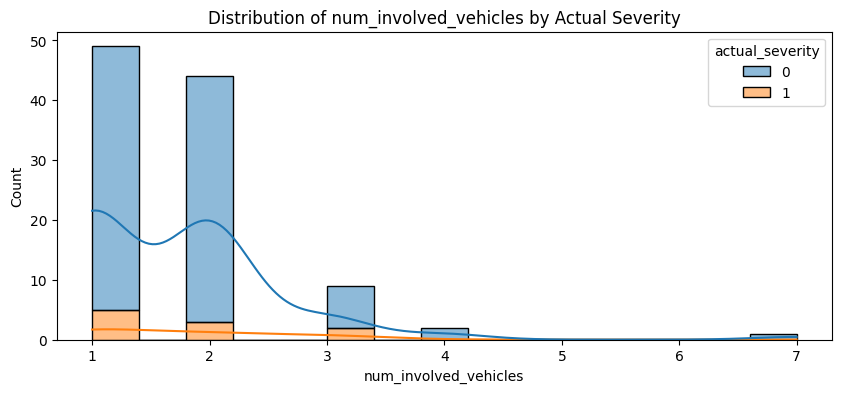

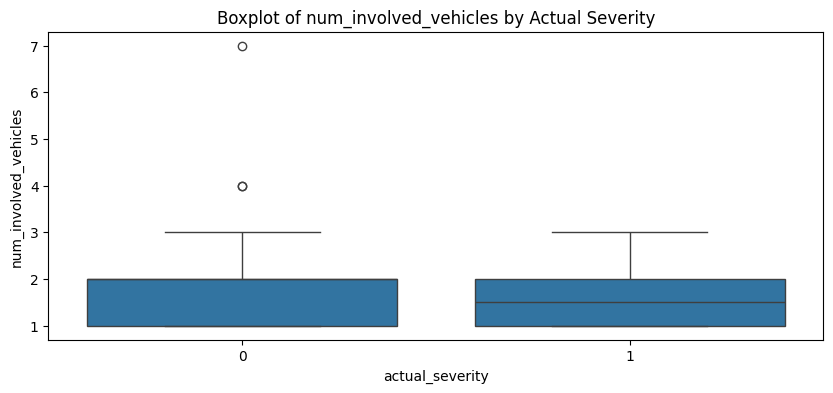

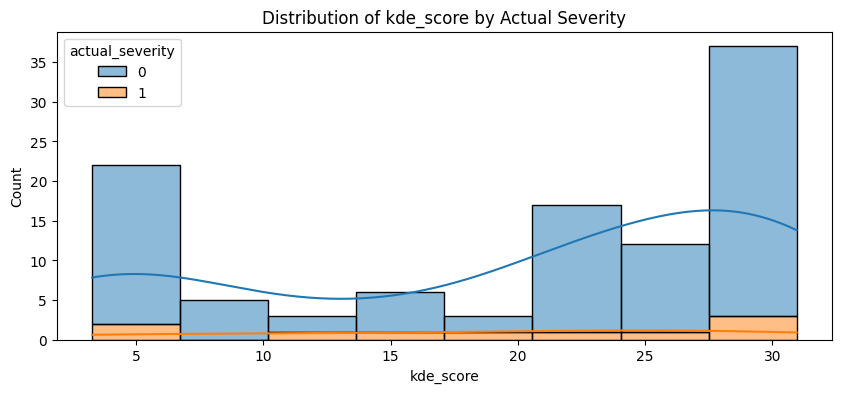

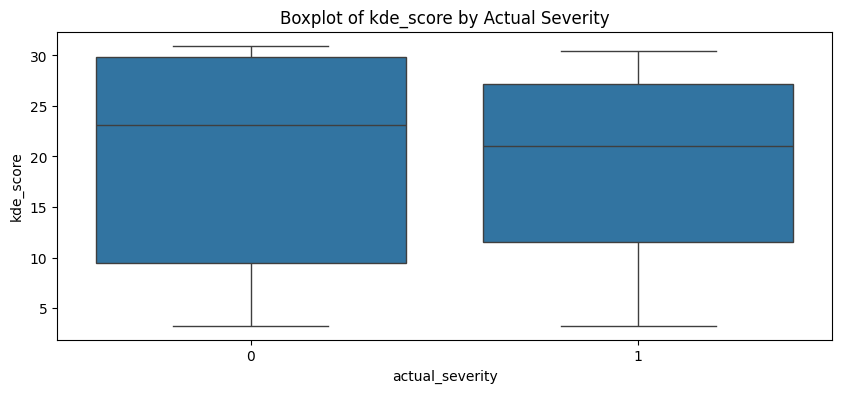


--- End of Error Analysis for: LogisticRegression_L1_SMOTEENN ---


In [ ]:
# Assuming df_for_error_analysis is correctly set up (e.g., X_val_iter_2.copy())
# And relevant key_cats and key_nums lists are defined based on columns in df_for_error_analysis

# Example for one model:
model_key_to_analyze = 'LogisticRegression_L1_SMOTEENN' # Use the full key from your trained_models_iter2
model_object_to_analyze = trained_models_iter_2.get(model_key_to_analyze)

analysis_output_df = perform_more_comprehensive_error_analysis(
    model_key_to_analyze,
    model_object_to_analyze,
    X_val_iter_2_iter_final, # Processed features for prediction
    y_val_iter_2,            # True labels
    df_for_error_analysis,   # Original interpretable features
    key_cats,
    key_nums
)

## precision-recall curve, roc


Generating ROC and PR curves for: LogisticRegression_L1_SMOTEENN


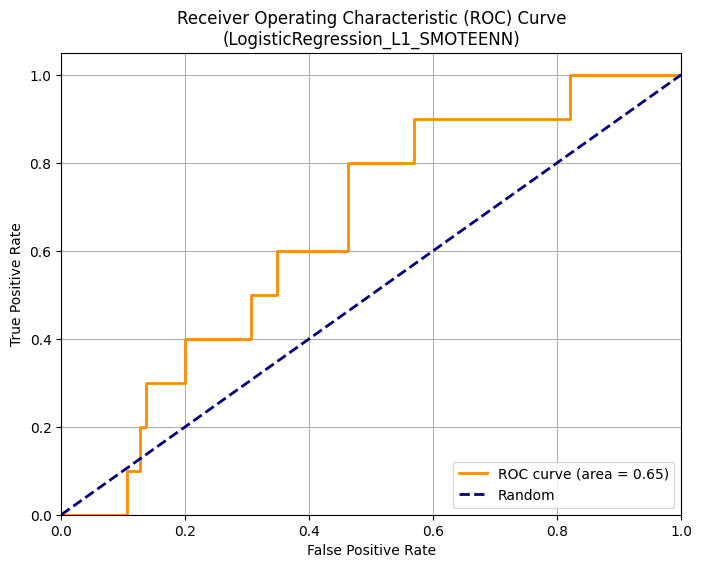

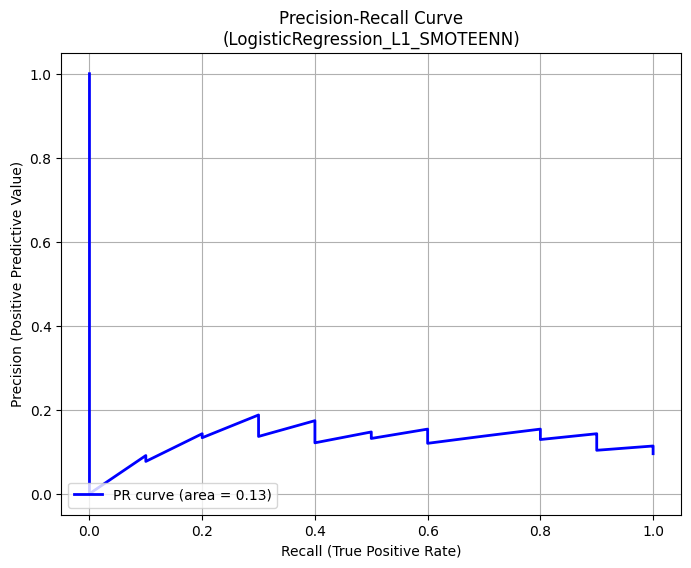

In [ ]:
# Make sure these libraries are imported at the top of your notebook or in an earlier cell
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay

# Assuming the previous code block defining model_key_to_analyze, model_object_to_analyze,
# and performing the error analysis has run.
# We need y_val_iter_2 (true labels) and y_proba_val_iter_2 (predicted probabilities)
# These variables should have been generated in the "model evaluation" cell if that cell ran successfully.

if 'model_object_to_analyze' in locals() and model_object_to_analyze is not None and \
   'X_val_iter_2_iter_final' in locals() and X_val_iter_2_iter_final is not None and \
   'y_val_iter_2' in locals() and y_val_iter_2 is not None:

    print(f"\nGenerating ROC and PR curves for: {model_key_to_analyze}")

    try:
        # Get predicted probabilities for the positive class (assuming it's label 1)
        # This should ideally be the same as y_proba_val_iter_2 generated during assessment
        y_proba = model_object_to_analyze.predict_proba(X_val_iter_2_iter_final)[:, 1]

        # --- Plot ROC Curve ---
        fpr, tpr, thresholds = roc_curve(y_val_iter_2, y_proba)
        roc_auc = auc(fpr, tpr) # Calculate Area Under the Curve

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve\n({model_key_to_analyze})')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

        # --- Plot Precision-Recall Curve ---
        precision, recall, _ = precision_recall_curve(y_val_iter_2, y_proba)
        pr_auc = auc(recall, precision) # Calculate Area Under the Curve for PR Curve

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        plt.xlabel('Recall (True Positive Rate)')
        plt.ylabel('Precision (Positive Predictive Value)')
        plt.title(f'Precision-Recall Curve\n({model_key_to_analyze})')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.show()

        # Alternative way to plot PR curve using PrecisionRecallDisplay (requires scikit-learn >= 0.24)
        # try:
        #     disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc)
        #     plt.figure(figsize=(8, 6))
        #     disp.plot(ax=plt.gca()) # Plot on current axes
        #     plt.title(f'Precision-Recall Curve\n({model_key_to_analyze})')
        #     plt.grid(True)
        #     plt.show()
        # except ImportError:
        #     print("scikit-learn version too old for PrecisionRecallDisplay.")


    except AttributeError:
        print(f"Model {model_key_to_analyze} does not have 'predict_proba' method. Cannot plot curves.")
    except Exception as e:
        print(f"An error occurred while plotting curves for {model_key_to_analyze}: {e}")

else:
    print("Skipping curve plotting: Model object, processed validation features, or true validation labels not available.")


Analyzing Feature Coefficients for: LogisticRegression_L1_SMOTEENN

Top 20 Features by Absolute Coefficient Value:


Coefficient Value
cat_mode__curve_direction_right                    -3.580117
cat_mode__direction_name_Northeast                  2.884922
cat_mode__grid_cell_8x8_3_7                         2.816597
cat_mode__grid_cell_8x8_6_4                        -2.332759
num__num_involved_vehicles                         -2.090171
num__has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                             -2.003569
cat_mode__curve_category_Very Sharp Curve          -1.826950
num__precipitation                                 -1.821184
num__lng_bin_8                                      1.448333
cat_mode__temperature_category_Warm                 1.295386
num__has_ΙΧΕ                                       -1.256855
num__kde_score                                     -1.223703
cat_mode__grid_cell_8x8_6_5                        -1.205534
num__is_rapid_temp_change                           1.160268
cat_mode__curve_direction_straight                  1.082880
cat_mode__ΑΥΤ/ΔΡΟΜΟΣ_E                              0.856468
num__road_maxspeed                                  0.832249
num__closest_toll_euclidean_km                      0.815663
cat_mode__ΑΥΤ/ΔΡΟΜΟΣ_A                             -0.789331
cat_mode__temperature_category_Cold                -0.774275

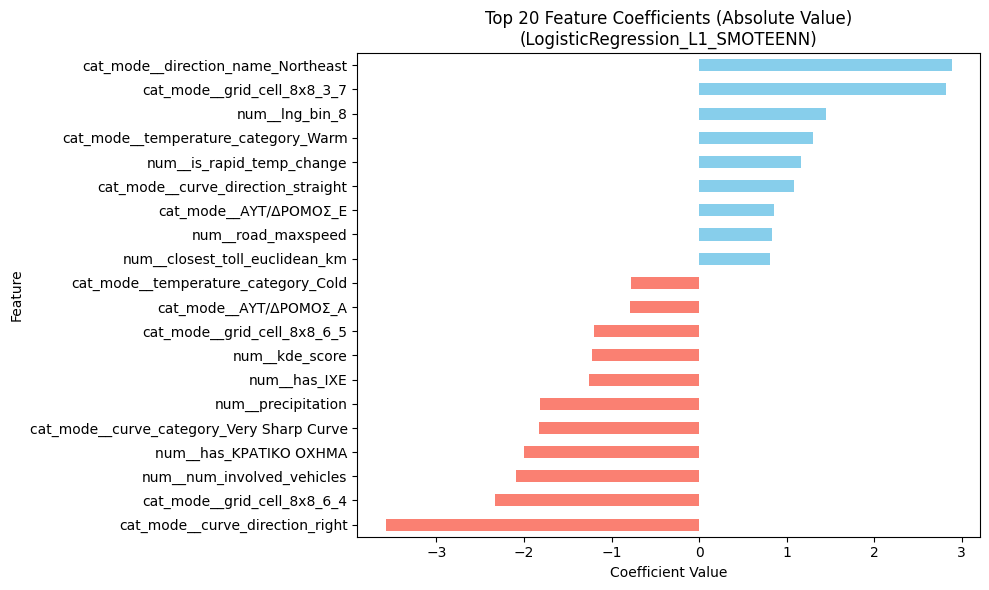

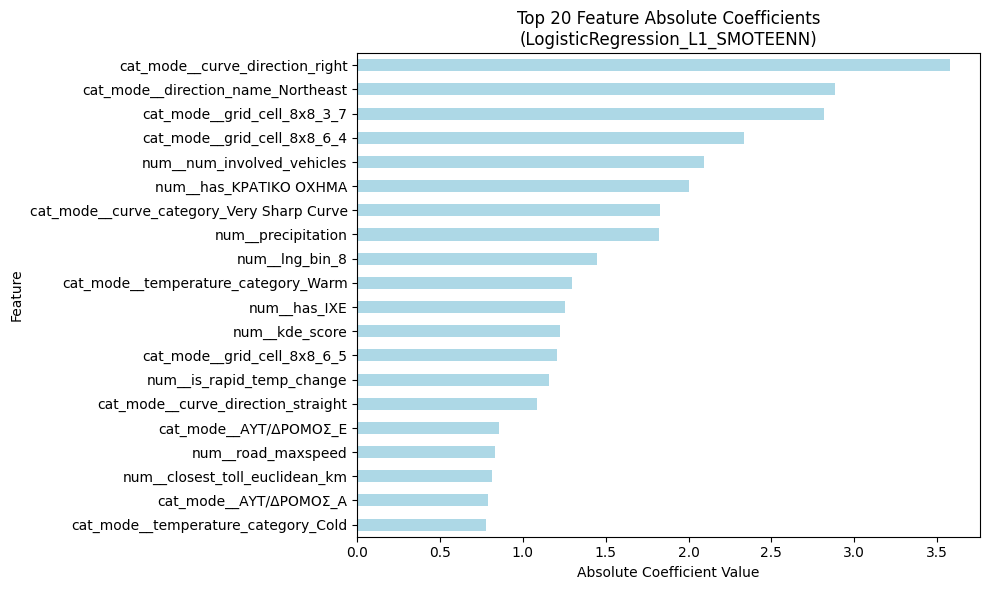

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Often used for better aesthetics

# Assuming the previous code blocks for training, evaluation, and error analysis have run.
# We need the model object: model_object_to_analyze
# We also need the names of the features *after* preprocessing, but *filtered* by RFECV.
# The 'selected_features_rfecv' variable created after the RFECV fitting step should contain these names.


if 'model_object_to_analyze' in locals() and model_object_to_analyze is not None and \
   'selected_features_rfecv' in locals() and selected_features_rfecv is not None: # Check for selected_features_rfecv

    print(f"\nAnalyzing Feature Coefficients for: {model_key_to_analyze}")

    # Check if the selected model is a Logistic Regression model
    if isinstance(model_object_to_analyze, LogisticRegression):
        # Check if the model has coefficients (fitted models will have this attribute)
        if hasattr(model_object_to_analyze, 'coef_'):

            # Logistic Regression has coef_ as a 2D array (n_classes, n_features)
            # For binary classification, it's typically (1, n_features) or (n_features,) depending on liblinear/saga solver
            # We are interested in the coefficients for the positive class (class 1, 'Death')
            # If coef_ is (1, n_features), select the first row [0, :]
            # If coef_ is (n_features,), just use it directly
            coefficients = model_object_to_analyze.coef_

            # Ensure coefficients is a 1D array for binary classification
            if coefficients.ndim > 1:
                if coefficients.shape[0] > 1:
                    print("Warning: Model coefficients shape > 1, assuming binary classification and taking coefficients for class 1.")
                    # Assuming class 1 is the positive class you're interested in
                    coef_positive_class = coefficients[1, :] # Take the row corresponding to class 1
                else: # Shape (1, n_features)
                    coef_positive_class = coefficients[0, :] # Take the first and only row
            else: # Shape (n_features,)
                 coef_positive_class = coefficients # Already 1D

            # Create a pandas Series to easily sort and manage coefficients with feature names
            # *** FIX APPLIED HERE: Use selected_features_rfecv as the index ***
            coef_series = pd.Series(coef_positive_class, index=selected_features_rfecv)

            # Calculate the absolute values of coefficients
            coef_series_abs = coef_series.abs()

            # Sort by absolute value to find the largest (most influential) coefficients
            sorted_coef_abs = coef_series_abs.sort_values(ascending=False)

            # Define the number of top features to display
            N_TOP_FEATURES = 20 # You can adjust this number

            # Get the top N features based on absolute coefficient values
            top_n_coef_abs = sorted_coef_abs.head(N_TOP_FEATURES)

            # Get the actual coefficients for these top features (maintaining the sign)
            top_n_coef = coef_series.loc[top_n_coef_abs.index]

            print(f"\nTop {N_TOP_FEATURES} Features by Absolute Coefficient Value:")
            # Print the top N coefficients and their feature names
            # Display as a DataFrame for better readability in a notebook
            try:
                display(top_n_coef.to_frame(name='Coefficient Value'))
            except NameError:
                 print(top_n_coef.to_frame(name='Coefficient Value'))


            # --- Plotting the coefficients ---
            plt.figure(figsize=(10, max(6, N_TOP_FEATURES * 0.3))) # Adjust figure height dynamically
            # Use a bar plot
            # You can color bars based on the sign if you want (positive/negative influence)
            # Or just plot the absolute values as suggested
            # Let's plot the actual coefficient values to see direction (positive/negative)
            top_n_coef.sort_values().plot(kind='barh', color=top_n_coef.sort_values().apply(lambda x: 'skyblue' if x > 0 else 'salmon'))

            plt.title(f'Top {N_TOP_FEATURES} Feature Coefficients (Absolute Value)\n({model_key_to_analyze})')
            plt.xlabel('Coefficient Value')
            plt.ylabel('Feature')
            plt.tight_layout() # Adjust layout to prevent labels overlapping
            plt.show()

            # Optional: You can plot the absolute values as well
            plt.figure(figsize=(10, max(6, N_TOP_FEATURES * 0.3)))
            top_n_coef_abs.sort_values().plot(kind='barh', color='lightblue') # Plot absolute values

            plt.title(f'Top {N_TOP_FEATURES} Feature Absolute Coefficients\n({model_key_to_analyze})')
            plt.xlabel('Absolute Coefficient Value')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()


        else:
            print(f"Model {model_key_to_analyze} does not have 'coef_' attribute. It might not be a fitted Logistic Regression model.")
    else:
        print(f"Model {model_key_to_analyze} is not a Logistic Regression model. Coefficient analysis is not applicable in this way.")


else:
    print("Skipping coefficient analysis: Model object or selected feature names (from RFECV) are not available.")

## evaluation

In [ ]:
# Example:
best_model_key = 'LogisticRegression_L1_SMOTEENN' # Or whatever your best model_sampler key was
if best_model_key in trained_models_iter_2:
    final_chosen_model = trained_models_iter_2[best_model_key]
else:
    print(f"Error: Best model key '{best_model_key}' not found in trained_models_iter_2.")
    final_chosen_model = None

In [ ]:
# Ensure all necessary functions (spatial engineering) and objects (fitted preprocessor,
# fitted RFECV selector, final_chosen_model) are available in the environment.
# Also, ensure metrics for evaluation are imported.
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import pandas as pd # Ensure pandas is imported

print("\n--- Iteration 2: Preparing Test Set for Final Evaluation ---")

# 0. Make a copy to avoid modifying the original X_test_iter_2 from the split
# if 'X_test_iter_2' not in locals() or X_test_iter_2 is None:
#     print("Error: X_test_iter_2 (from initial split) is not defined.")
#     # Stop or handle error
# else:
#     X_test_for_eval = X_test_iter_2.copy()

#     # 1. Apply Spatial Feature Engineering
#     # Make sure N_BINS, GEOHASH_PRECISION, KDE_BANDWIDTH are the same as used for training
#     # Also, X_train (from iter2 split, before any processing) is needed for fitting KDE and bin edges
#     # If X_train (from the iter2 split, before modifications) is not directly available,
#     # ensure fit_df for create_coordinate_bins and df_fit_on for apply_kde_score
#     # use the X_train data that preprocessor and rfecv were trained on.
#     # For simplicity, we assume X_train (iter2, pre-any-processing) was used to fit these aspects.

#     print("Applying spatial feature engineering to the test set...")
#     if 'ΑΥΤ/ΔΡΟΜΟΣ' in X_test_for_eval.columns and 'ΧΙΛ.ΘΕΣΗ' in X_test_for_eval.columns:
#         X_test_for_eval = create_road_segment_feature_adjusted(X_test_for_eval, road_col='ΑΥΤ/ΔΡΟΜΟΣ', km_col='ΧΙΛ.ΘΕΣΗ')
#         print("Adjusted road segment ID feature created for test set.")
#     else:
#         print("Skipping road segment ID creation for test set: Required columns not found.")

#     if 'lat' in X_test_for_eval.columns and 'lng' in X_test_for_eval.columns:
#         # For create_coordinate_bins and apply_kde_score,
#         # you need the 'fit_df' (for bins) and 'df_fit_on' (for KDE)
#         # which should be the X_train used in iteration 2 *before* it was processed by ColumnTransformer.
#         # Let's assume 'X_train' (the raw training split for iter2) is available for this.
#         if 'X_train' in locals() and X_train is not None:
#             X_test_for_eval = create_coordinate_bins(X_test_for_eval, lat_col='lat', lng_col='lng', n_bins=N_BINS, fit_df=X_train.copy())
#             print(f"Coordinate bins ({N_BINS}x{N_BINS}) created for test set.")

#             X_test_for_eval = apply_geohash(X_test_for_eval, lat_col='lat', lng_col='lng', precision=GEOHASH_PRECISION)
#             print(f"Geohash (precision {GEOHASH_PRECISION}) features created for test set.")

#             X_train_coords_for_kde_fit = X_train[['lat', 'lng']].dropna() # Use original X_train for fitting KDE
#             if not X_train_coords_for_kde_fit.empty:
#                 X_test_for_eval = apply_kde_score(X_test_for_eval, X_train_coords_for_kde_fit, lat_col='lat', lng_col='lng', bandwidth=KDE_BANDWIDTH)
#                 print("KDE scores created for test set.")
#             else:
#                 print("Skipping KDE for test set: No valid coordinates in X_train to fit KDE. Adding 'kde_score' column with 0.")
#                 X_test_for_eval['kde_score'] = 0.0
#         else:
#             print("Skipping coordinate binning and KDE for test set: Original X_train (for fitting) not available.")
#             # Add dummy columns if these steps are skipped to avoid downstream errors, matching training
#             if f'grid_cell_{N_BINS}x{N_BINS}' not in X_test_for_eval.columns: X_test_for_eval[f'grid_cell_{N_BINS}x{N_BINS}'] = 'unknown_cell'
#             if f'geohash_p{GEOHASH_PRECISION}' not in X_test_for_eval.columns: X_test_for_eval[f'geohash_p{GEOHASH_PRECISION}'] = 'unknown_geohash'
#             if 'kde_score' not in X_test_for_eval.columns: X_test_for_eval['kde_score'] = 0.0
#     else:
#         print("Skipping further spatial feature engineering for test set: lat/lng columns not found.")
    # In your "Final Evaluation on Test Set" script:

# Start with the pristine copy that has original lat/lng
if 'X_test_iter_2_original_from_split' in locals() and X_test_iter_2_original_from_split is not None:
    X_test_for_eval = X_test_iter_2_original_from_split.copy()

    # Now, the rest of the script proceeds:
    # 1. Apply Spatial Feature Engineering to X_test_for_eval
    #    (using X_train from iter2 for fitting bins/KDE as before)
    print("Applying spatial feature engineering to the test set for final evaluation...")
    if 'ΑΥΤ/ΔΡΟΜΟΣ' in X_test_for_eval.columns and 'ΧΙΛ.ΘΕΣΗ' in X_test_for_eval.columns:
        X_test_for_eval = create_road_segment_feature_adjusted(X_test_for_eval, road_col='ΑΥΤ/ΔΡΟΜΟΣ', km_col='ΧΙΛ.ΘΕΣΗ' )
        print("Segment ID created for X_test_for_eval.")

    if 'lat' in X_test_for_eval.columns and 'lng' in X_test_for_eval.columns:
        # Use the preserved training set for fitting parameters
        if 'X_train_iter_2_for_fitting' in locals() and X_train_iter_2_for_fitting is not None:
            print("Using X_train_iter_2_for_fitting to derive bin edges and KDE model for test set.")

            X_test_for_eval = create_coordinate_bins(
                X_test_for_eval,
                lat_col='lat', lng_col='lng',
                n_bins=N_BINS,
                fit_df=X_train_iter_2_for_fitting.copy() # <-- Use the preserved copy
            )
            print(f"Coordinate bins ({N_BINS}x{N_BINS}) created for test set.")

            X_test_for_eval = apply_geohash(
                X_test_for_eval,
                lat_col='lat', lng_col='lng',
                precision=GEOHASH_PRECISION
            )
            print(f"Geohash (precision {GEOHASH_PRECISION}) features created for test set.")

            X_train_coords_for_kde_fit = X_train_iter_2_for_fitting[['lat', 'lng']].dropna() # <-- Use the preserved copy
            if not X_train_coords_for_kde_fit.empty:
                X_test_for_eval = apply_kde_score(
                    X_test_for_eval,
                    X_train_coords_for_kde_fit,
                    lat_col='lat', lng_col='lng',
                    bandwidth=KDE_BANDWIDTH
                )
                print("KDE scores created for test set.")
            else:
                print("Skipping KDE for test set: No valid coordinates in X_train_iter_2_for_fitting. Adding 'kde_score' column with 0.")
                X_test_for_eval['kde_score'] = 0.0
        else:
            print("CRITICAL ERROR: X_train_iter_2_for_fitting (original train split with lat/lng) not available for test set processing.")
            # Handle error: test results would be invalid.
            # Add dummy columns if these steps are skipped to avoid downstream errors, matching training
            if f'grid_cell_{N_BINS}x{N_BINS}' not in X_test_for_eval.columns: X_test_for_eval[f'grid_cell_{N_BINS}x{N_BINS}'] = 'unknown_cell'
            if f'geohash_p{GEOHASH_PRECISION}' not in X_test_for_eval.columns: X_test_for_eval[f'geohash_p{GEOHASH_PRECISION}'] = 'unknown_geohash'
            if 'kde_score' not in X_test_for_eval.columns: X_test_for_eval['kde_score'] = 0.0
    else:
        print("CRITICAL: lat/lng not found in X_test_for_eval at start of test processing. Spatial features (bins, geohash, KDE) will be missing or dummied.")
        # Add dummy columns if these features were expected by preprocessor_iter2
        if f'grid_cell_{N_BINS}x{N_BINS}' not in X_test_for_eval.columns: X_test_for_eval[f'grid_cell_{N_BINS}x{N_BINS}'] = 'unknown_cell'
        if f'geohash_p{GEOHASH_PRECISION}' not in X_test_for_eval.columns: X_test_for_eval[f'geohash_p{GEOHASH_PRECISION}'] = 'unknown_geohash'
        if 'kde_score' not in X_test_for_eval.columns: X_test_for_eval['kde_score'] = 0.0

    # 2. Drop raw lat/lng columns (if this was done for training/validation)
    columns_to_drop_after_spatial_eng = ['lat', 'lng']
    if all(col in X_test_for_eval.columns for col in columns_to_drop_after_spatial_eng):
        X_test_for_eval = X_test_for_eval.drop(columns=columns_to_drop_after_spatial_eng, errors='ignore')
        print(f"Dropped raw spatial columns from test set: {columns_to_drop_after_spatial_eng}")
    else:
        print("Skipping lat/lng drop for test set, columns not found or already dropped.")

    # 3. Apply the FITTED ColumnTransformer (preprocessor)
    # DO NOT RE-FIT IT ON THE TEST DATA
    if 'preprocessor' in locals() and preprocessor is not None:
        print("Applying fitted preprocessor to the test set...")
        try:
            X_test_processed = preprocessor.transform(X_test_for_eval)

            # Get feature names from the preprocessor (should match training)
            # Ensure feature_names_out was stored from fitting preprocessor
            if 'feature_names_out' in locals() and feature_names_out is not None:
                 X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_out, index=X_test_for_eval.index)
            else: # Fallback if feature_names_out wasn't captured properly
                print("Warning: feature_names_out not available. Using generic column names for processed test data.")
                X_test_processed_df = pd.DataFrame(X_test_processed, index=X_test_for_eval.index)

            print(f"Test set processed. Shape: {X_test_processed_df.shape}")

        except Exception as e:
            print(f"Error applying preprocessor to test set: {e}")
            X_test_processed_df = None # Ensure it's None if error
    else:
        print("Error: Fitted preprocessor not found.")
        X_test_processed_df = None

    # 4. Apply FITTED RFE/RFECV feature selection
    # Use the support_ mask from the rfecv object that was fit on X_train_iter_2_processed_df
    # DO NOT RE-FIT RFECV ON THE TEST DATA
    X_test_final_features = None
    if X_test_processed_df is not None:
        if 'rfecv' in locals() and rfecv is not None and hasattr(rfecv, 'support_'): # Assuming rfecv is your fitted RFECV object
            print("Applying RFECV feature selection to the processed test set...")
            try:
                selected_features_mask_from_training = rfecv.support_
                # Ensure columns align if X_test_processed_df was created with generic names
                if X_test_processed_df.shape[1] == len(selected_features_mask_from_training):
                    X_test_final_features = X_test_processed_df.loc[:, selected_features_mask_from_training]
                    print(f"Test set features selected by RFECV. Shape: {X_test_final_features.shape}")
                else:
                    print(f"Error: Column mismatch between processed test set ({X_test_processed_df.shape[1]}) and RFECV mask ({len(selected_features_mask_from_training)}). Cannot apply RFE selection.")
                    X_test_final_features = None

            except Exception as e:
                print(f"Error applying RFECV selection to test set: {e}")
                X_test_final_features = None
        elif 'rfe_iter2' in locals() and rfe_iter2 is not None and hasattr(rfe_iter2, 'support_'): # Fallback if you used rfe_iter2 (plain RFE)
            print("Applying RFE feature selection to the processed test set...")
            try:
                selected_features_mask_from_training = rfe_iter2.support_
                if X_test_processed_df.shape[1] == len(selected_features_mask_from_training):
                    X_test_final_features = X_test_processed_df.loc[:, selected_features_mask_from_training]
                    print(f"Test set features selected by RFE. Shape: {X_test_final_features.shape}")
                else:
                    print(f"Error: Column mismatch for RFE. Cannot apply RFE selection.")
                    X_test_final_features = None
            except Exception as e:
                print(f"Error applying RFE selection to test set: {e}")
                X_test_final_features = None
        else:
            print("Error: Fitted RFE/RFECV object not found or doesn't have 'support_'. Assuming all processed features are used.")
            # This would happen if RFE/RFECV was skipped or failed during training.
            # In this case, X_test_final_features would be X_test_processed_df
            X_test_final_features = X_test_processed_df


    # 5. Make Predictions with the Final Chosen Model
    if X_test_final_features is not None and 'final_chosen_model' in locals() and final_chosen_model is not None:
        print(f"\n--- Final Evaluation on Test Set using: {type(final_chosen_model).__name__} (trained with appropriate balancing) ---")

        if 'y_test_iter_2' not in locals() or y_test_iter_2 is None:
            print("Error: y_test_iter_2 (true labels for test set) not found.")
        else:
            try:
                y_pred_test = final_chosen_model.predict(X_test_final_features)

                # Ensure y_test_iter_2 has the same index as X_test_final_features if it's a Series for alignment,
                # though usually for metrics, direct array/Series comparison works if lengths match.
                # For safety, ensure y_test_iter_2 is aligned if X_test_final_features index was preserved.
                y_true_test_aligned = y_test_iter_2.loc[X_test_final_features.index]


                if hasattr(final_chosen_model, "predict_proba"):
                    y_proba_test = final_chosen_model.predict_proba(X_test_final_features)[:, 1]
                    roc_auc_test = roc_auc_score(y_true_test_aligned, y_proba_test)
                    precision_pr_test, recall_pr_test, _ = precision_recall_curve(y_true_test_aligned, y_proba_test)
                    pr_auc_test = auc(recall_pr_test, precision_pr_test)
                    print(f"ROC AUC (Test): {roc_auc_test:.4f}")
                    print(f"PR AUC (Test): {pr_auc_test:.4f}")
                else:
                    print("ROC AUC / PR AUC not available as model doesn't have predict_proba.")

                print("\nClassification Report (Test Set):")
                print(classification_report(y_true_test_aligned, y_pred_test, target_names=['Injury (0)', 'Death (1)'], zero_division=0))

                print("\nConfusion Matrix (Test Set):")
                print(confusion_matrix(y_true_test_aligned, y_pred_test))
            except Exception as e:
                print(f"Error during test set prediction or evaluation: {e}")
    else:
        if 'final_chosen_model' not in locals() or final_chosen_model is None:
            print("Error: final_chosen_model is not defined. Please specify your best model.")
        if X_test_final_features is None:
            print("Error: Final test set features (X_test_final_features) are not available for prediction.")


--- Iteration 2: Preparing Test Set for Final Evaluation ---
Applying spatial feature engineering to the test set for final evaluation...
Segment ID created for X_test_for_eval.
Using X_train_iter_2_for_fitting to derive bin edges and KDE model for test set.
Coordinate bins (8x8) created for test set.
Geohash (precision 7) features created for test set.
KDE scores created for test set.
Dropped raw spatial columns from test set: ['lat', 'lng']
Applying fitted preprocessor to the test set...
Test set processed. Shape: (105, 716)
Applying RFECV feature selection to the processed test set...
Test set features selected by RFECV. Shape: (105, 532)

--- Final Evaluation on Test Set using: LogisticRegression (trained with appropriate balancing) ---
ROC AUC (Test): 0.5032
PR AUC (Test): 0.0876

Classification Report (Test Set):
              precision    recall  f1-score   support

  Injury (0)       0.91      0.54      0.68        95
   Death (1)       0.10      0.50      0.17        10

    

# Iteration 3

## removing the hypothesized default spots (A0,K0)

In [ ]:
# if 'df_original' in locals() and df_original is not None:
#     initial_rows = df_original.shape[0]
#     print(f"Initial number of rows: {initial_rows}")

#     # Convert 'ΧΙΛ.ΘΕΣΗ' to numeric, coercing errors to NaN, then check for 0
#     # This handles both numeric 0 and string '0', '0.0', etc.
#     df_original['ΧΙΛ.ΘΕΣΗ_numeric'] = pd.to_numeric(df_original['ΧΙΛ.ΘΕΣΗ'], errors='coerce').fillna(-1) # Fill NaN with a value outside range of 0

#     # Define the conditions to drop
#     condition_A_0km = (df_original['ΑΥΤ/ΔΡΟΜΟΣ'] == 'A') & (df_original['ΧΙΛ.ΘΕΣΗ_numeric'] == 0)
#     condition_K_0km = (df_original['ΑΥΤ/ΔΡΟΜΟΣ'] == 'K') & (df_original['ΧΙΛ.ΘΕΣΗ_numeric'] == 0)

#     # Combine the conditions using | (OR)
#     rows_to_drop = condition_A_0km | condition_K_0km

#     # Drop the rows that satisfy the combined condition
#     df_original = df_original[~rows_to_drop].copy() # Use '~' for negation

#     # Drop the temporary numeric column
#     df_original = df_original.drop(columns=['ΧΙΛ.ΘΕΣΗ_numeric'])

#     rows_after_dropping = df_original.shape[0]
#     dropped_count = initial_rows - rows_after_dropping
#     print(f"Number of rows after dropping: {rows_after_dropping}")
#     print(f"Number of rows dropped: {dropped_count}")

#     # Optional: Display the head of the modified DataFrame
#     # display(df_original.head())
# else:
#     print("df_original is not available. Skipping row dropping.")

## column definition

In [ ]:
if df_original is not None:
    columns_iter3 = [
        'ΑΥΤ/ΔΡΟΜΟΣ', 'ΧΙΛ.ΘΕΣΗ', 'ΣΗΡΑΓΓΑ',
        'ΥΠΟΚΑΤΗΓΟΡΙΑ', 'ΘΕΣΗ_ΕΡΓΟΥ', 'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.',
        'ΚΑΤ._ΟΔ.','ΤΕΧΝ._ΦΩΤ.', #'accident_type', # This is now our target or related to it
        'lat', 'lng', 'num_involved_vehicles', 'has_ΙΧΕ',
        'has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ', 'has_ΔΙΚΥΚΛΟ', 'has_ΦΟΡΤΗΓΟ', 'has_ΤΑΞΙ',
        'has_ΛΕΩΦΟΡΕΙΟ', 'has_Μ.Ε.',
        'accident_severity', # Keep the target variable
        'effective_lighting_condition',# replacing ΤΕΧΝ._ΦΩΤ. with effective_lighting_condition
        # 'temperature_2m',
        'temperature_category',
        'relative_humidity_2m',
        'wind_gusts_10m',
        "precipitation",
        # "precipitation_intensity",
        # "year",
        "day_of_week_sin",
        "day_of_week_cos",
        "month_sin",
        "month_cos",
        "day_of_month_sin",
        "day_of_month_cos",
        "closest_toll_euclidean_km",
        "closest_intersection_euclidean_km",
        # 0.6 recall, 0.25 f1 class 1

        "involves_heavy_vehicle",
        "is_rapid_temp_change",
        "time_since_previous_accident_hours",
        # 0.28 f1, 0.7 recall

        "accidents_past_3h",
        # "accidents_past_6h",
        # "accidents_past_12h",
        # "accidents_past_24h"
        # same

        # "years_since_min",
        # "is_rush_hour_enhanced"
        # reduction

        "road_lanes",
        "road_maxspeed",

        "road_context",
        "curve_category",
        "curve_direction",
        "direction_name",
        "curvature_radius_m",
        "curve_angle_deg"
        # "next_curve_dist_m",
        # "next_curve_category",

        "profile_total_curves",
        "profile_left_turns",
        "profile_right_turns",
        "profile_avg_angle"


    ]
    # Ensure all selected columns exist in df_original
    columns_iter3 = [col for col in columns_iter3 if col in df_original.columns]
    if 'accident_severity' not in columns_iter3 and 'accident_severity' in df_original.columns:
         columns_iter3.append('accident_severity')


    df_iter3 = df_original[columns_iter3].copy()
    print(f"\n--- Iteration 3: Working with {len(df_iter1.columns)-1} features ---")
    # display(df_iter1.head())



--- Iteration 3: Working with 20 features ---


In [ ]:
# Assuming df_iter3 is your DataFrame for Iteration 3
if 'df_iter3' in locals() and df_iter3 is not None:
    columns_to_process = ['curvature_radius_m', 'curve_angle_deg']

    for column_to_process in columns_to_process:
        if column_to_process in df_iter3.columns:
            print(f"\nHandling 'inf' and NaN values in '{column_to_process}'...")

            # Convert to numeric, coercing errors (like non-numeric strings) to NaN temporarily
            # 'inf' might also become NaN depending on original data type and pandas version
            df_iter3[column_to_process] = pd.to_numeric(df_iter3[column_to_process], errors='coerce')

            # Replace positive infinity with 0
            # Using np.inf handles standard numpy infinity representations
            df_iter3[column_to_process] = df_iter3[column_to_process].replace([np.inf], 0)

            # Fill any remaining NaNs (including those created from 'inf' or original NaNs) with 0
            df_iter3[column_to_process] = df_iter3[column_to_process].fillna(0)

            print(f"Handled 'inf' and NaN values in '{column_to_process}'.")
            # Optional: Check the value counts or descriptive stats to verify
            # print(df_iter3[column_to_process].value_counts(dropna=False).head())
            # print(df_iter3[column_to_process].describe())
        else:
            print(f"Column '{column_to_process}' not found in df_iter3. Skipping handling.")
else:
    print("df_iter3 is not available. Skipping handling of curvature_radius_m and curve_angle_deg.")


Handling 'inf' and NaN values in 'curvature_radius_m'...
Handled 'inf' and NaN values in 'curvature_radius_m'.
Column 'curve_angle_deg' not found in df_iter3. Skipping handling.


## stratified data splitting

In [ ]:
if 'df_iter3' in locals() and df_iter3 is not None:
    X = df_iter3.drop('accident_severity', axis=1)
    y = df_iter3['accident_severity']

    # Split into Train (60%) and Temp (40% for Val+Test)
    X_train_iter_3, X_temp_iter_3, y_train_iter_3, y_temp_iter_3 = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )

    # Split Temp into Validation (50% of Temp -> 20% of total) and Test (50% of Temp -> 20% of total)
    X_val_iter_3, X_test_iter_3, y_val_iter_3, y_test_iter_3 = train_test_split(
        X_temp_iter_3, y_temp_iter_3, test_size=0.5, random_state=42, stratify=y_temp_iter_3
    )

    print(f"Training set: {X_train_iter_3.shape}, {y_train_iter_3.shape}, Minority class: {Counter(y_train_iter_3)[1]}")
    print(f"Validation set: {X_val_iter_3.shape}, {y_val_iter_3.shape}, Minority class: {Counter(y_val_iter_3)[1]}")
    print(f"Test set: {X_test_iter_3.shape}, {y_test_iter_3.shape}, Minority class: {Counter(y_test_iter_3)[1]}")


Training set: (313, 46), (313,), Minority class: 29
Validation set: (105, 46), (105,), Minority class: 10
Test set: (105, 46), (105,), Minority class: 10


In [ ]:
X_train_iter_3_for_fitting = X_train_iter_3.copy()
X_test_iter_3_original_from_split = X_test_iter_3.copy() # You likely already do this or similar

print("Saved a pristine copy of X_train_iter_3 (for fitting spatial transforms on val/test) and X_test_iter_3.")


Saved a pristine copy of X_train_iter_3 (for fitting spatial transforms on val/test) and X_test_iter_3.


## data exploration

Numerical Features: ['ΧΙΛ.ΘΕΣΗ', 'lat', 'lng', 'num_involved_vehicles', 'relative_humidity_2m', 'wind_gusts_10m', 'precipitation', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_month_sin', 'day_of_month_cos', 'closest_toll_euclidean_km', 'closest_intersection_euclidean_km', 'involves_heavy_vehicle', 'is_rapid_temp_change', 'time_since_previous_accident_hours', 'accidents_past_3h', 'road_lanes', 'road_maxspeed', 'curvature_radius_m', 'profile_left_turns', 'profile_right_turns', 'profile_avg_angle']
Categorical Features: ['ΑΥΤ/ΔΡΟΜΟΣ', 'ΣΗΡΑΓΓΑ', 'ΥΠΟΚΑΤΗΓΟΡΙΑ', 'ΘΕΣΗ_ΕΡΓΟΥ', 'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'ΚΑΤ._ΟΔ.', 'ΤΕΧΝ._ΦΩΤ.', 'effective_lighting_condition', 'temperature_category', 'road_context', 'curve_category', 'curve_direction', 'direction_name']


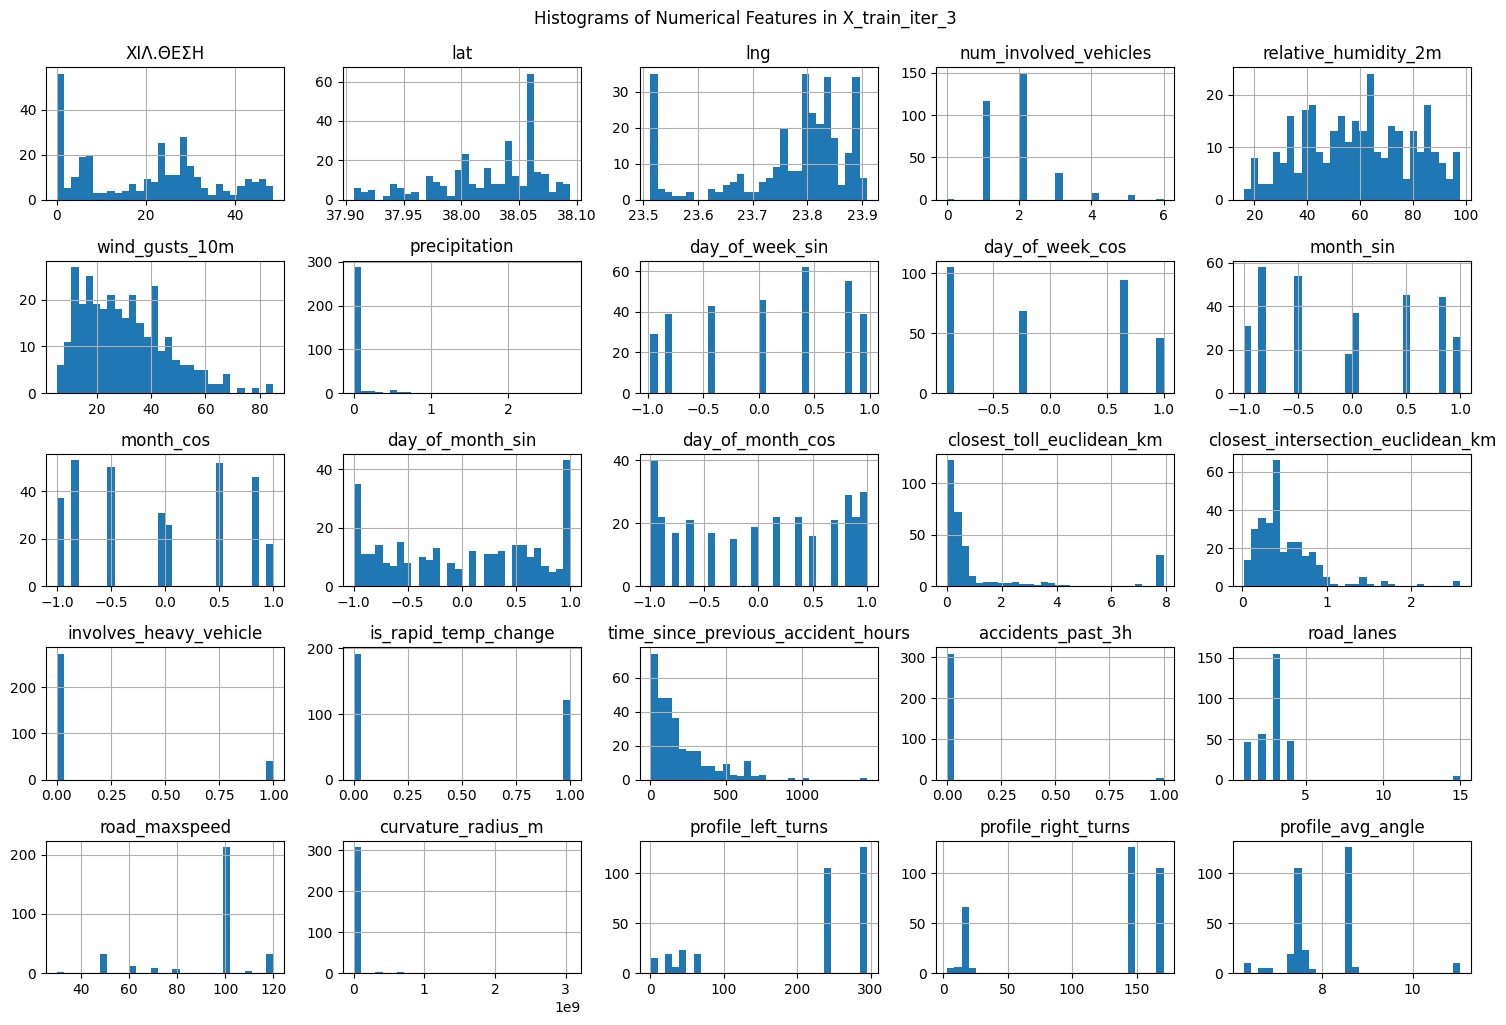

<Figure size 1500x1000 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Separate numerical and categorical features
numerical_features = X_train_iter_3.select_dtypes(include=np.number).columns
categorical_features = X_train_iter_3.select_dtypes(include='object').columns

print("Numerical Features:", list(numerical_features))
print("Categorical Features:", list(categorical_features))

# Analyze distribution of numerical features
if len(numerical_features) > 0:
    X_train_iter_3[numerical_features].hist(bins=30, figsize=(15, 10))
    plt.tight_layout()
    plt.suptitle('Histograms of Numerical Features in X_train_iter_3', y=1.02)
    plt.show()

    plt.figure(figsize=(15, 10))
else:
    print("No numerical features to plot.")


Plotting distribution for standard categorical features...


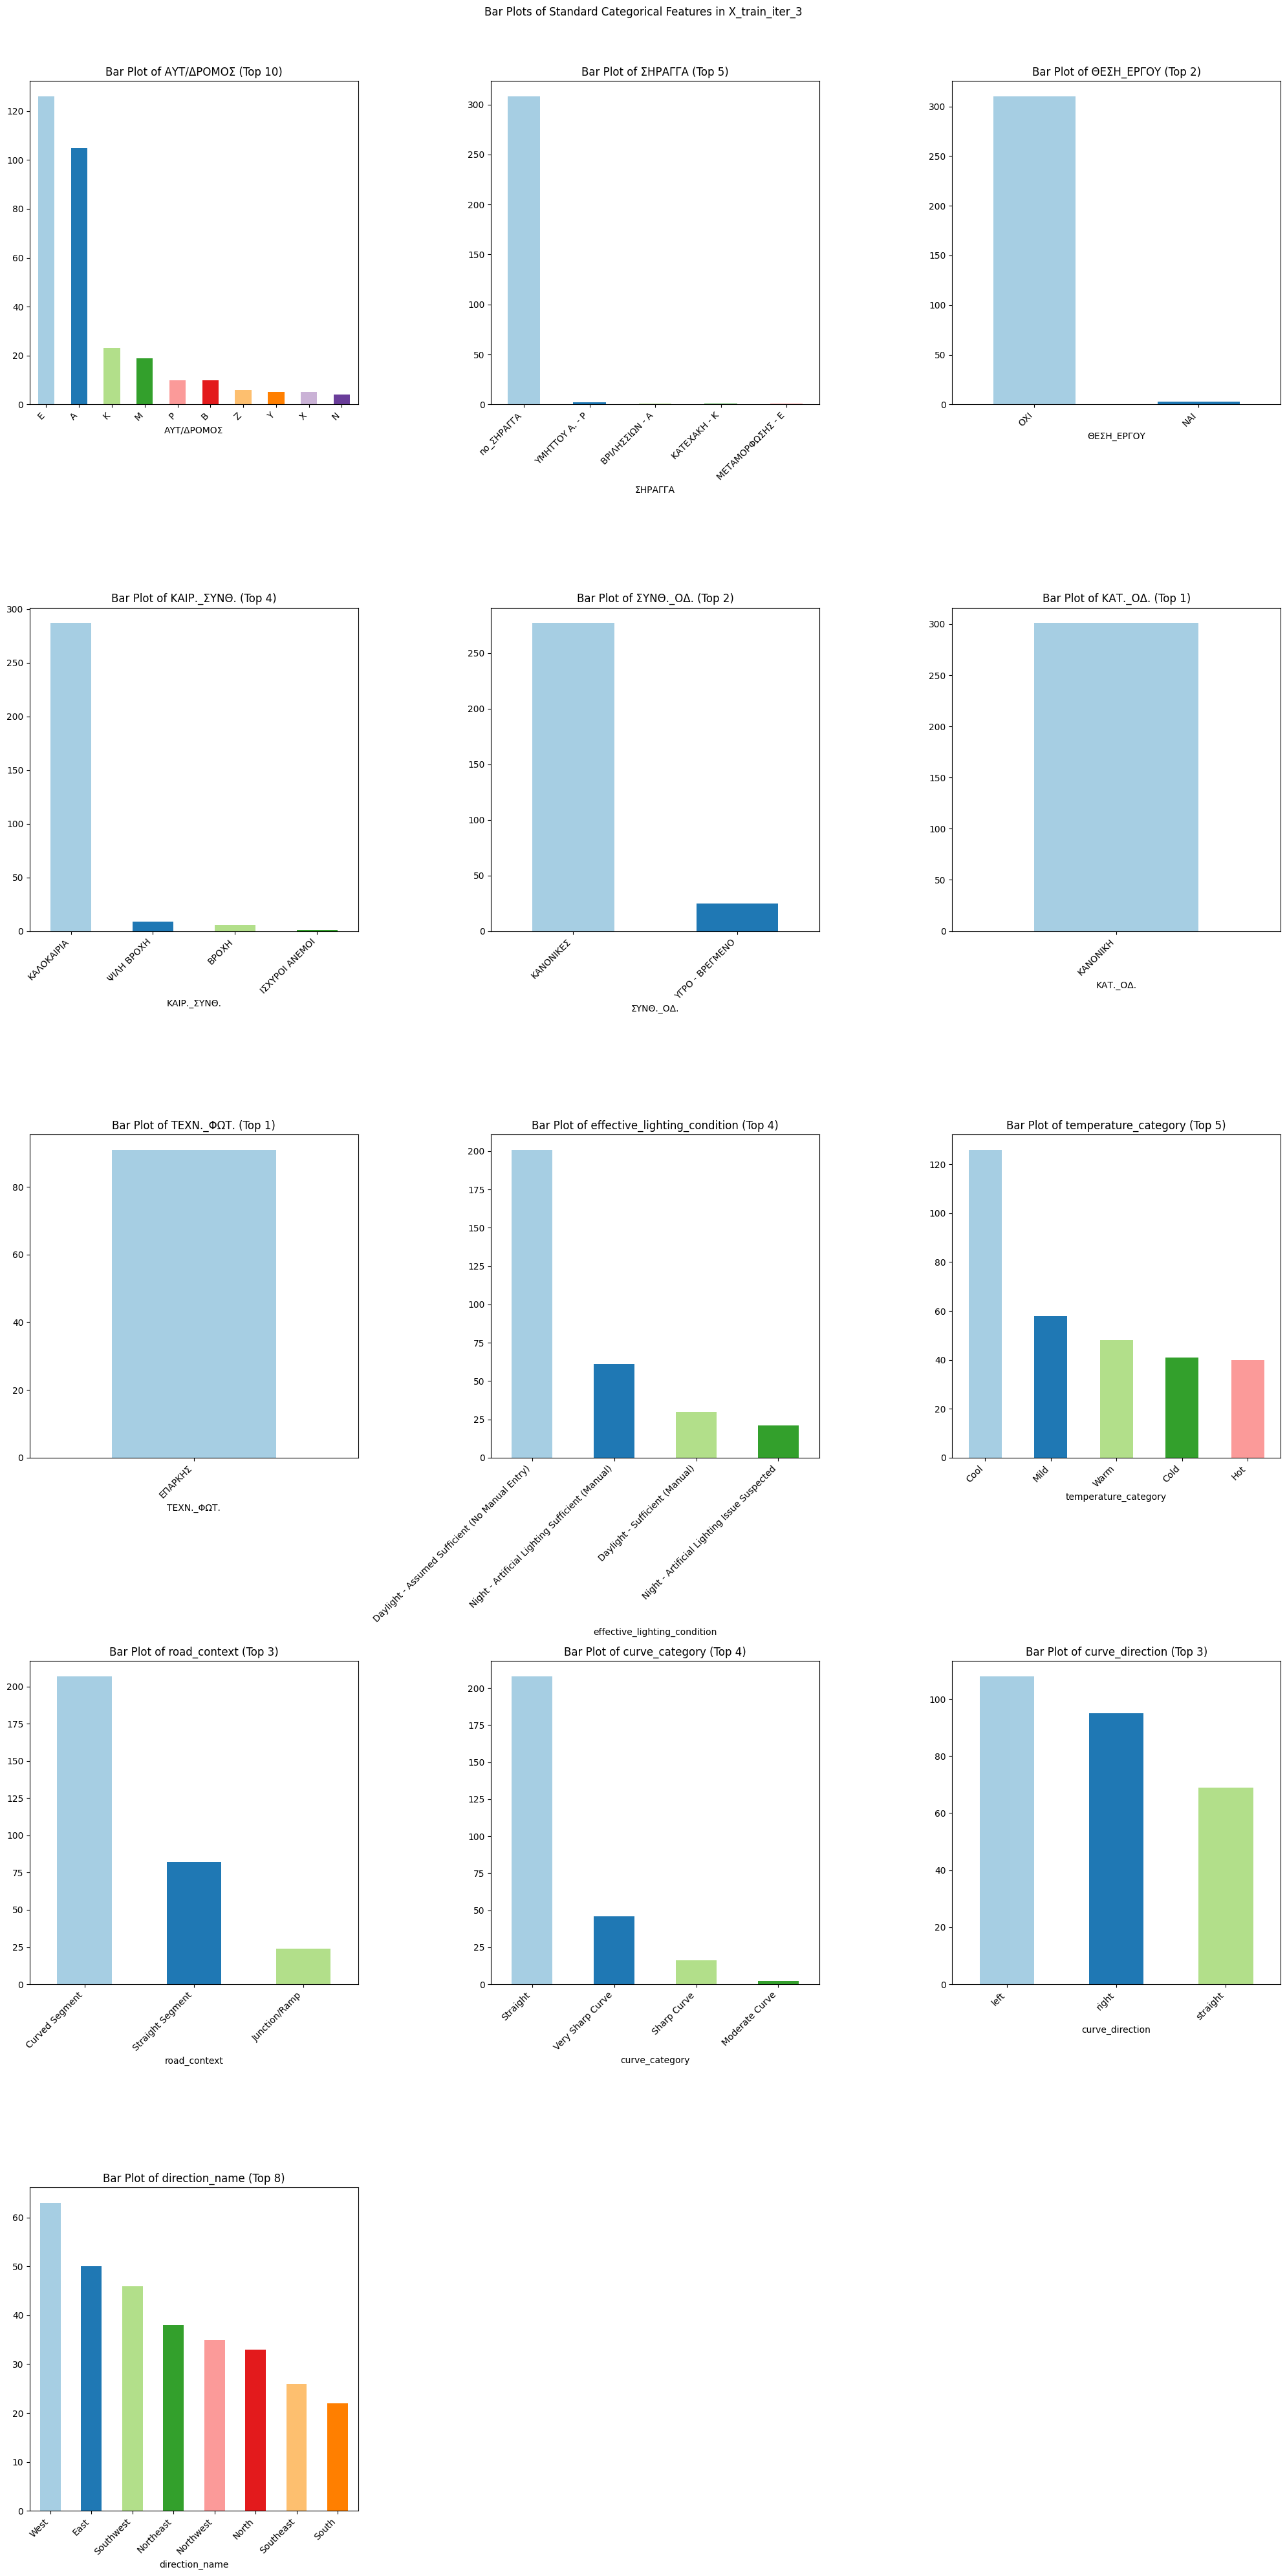


Plotting distribution for feature with long names: 'ΥΠΟΚΑΤΗΓΟΡΙΑ'


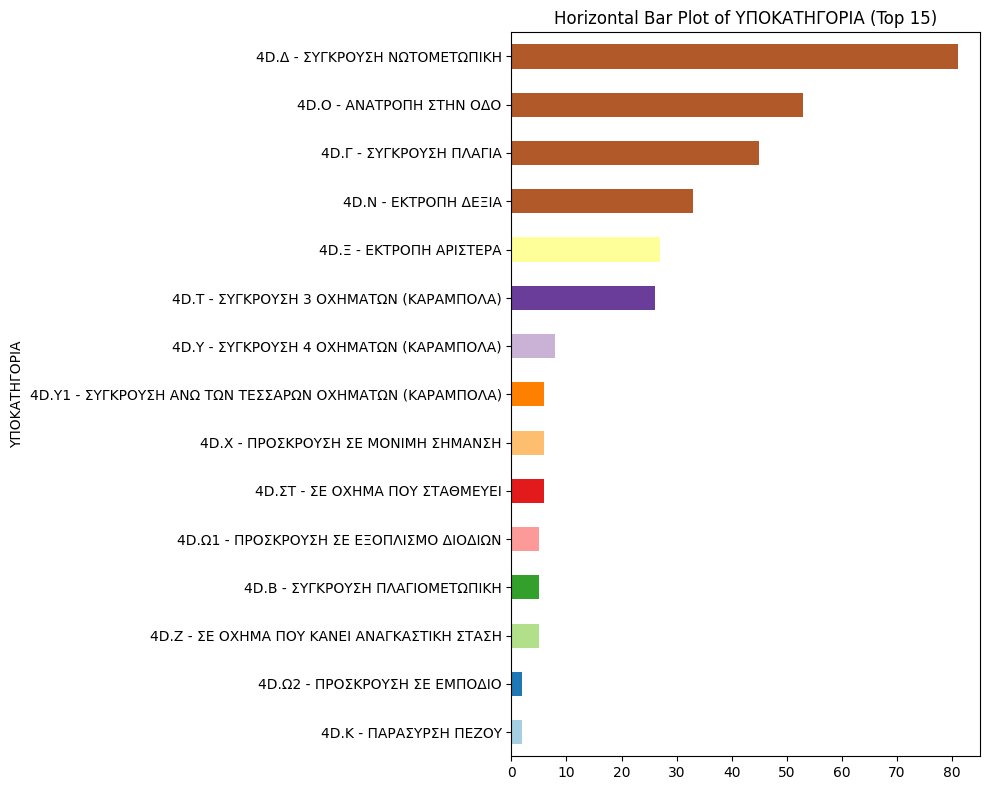


Top 10 values and counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ':
ΥΠΟΚΑΤΗΓΟΡΙΑ
4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ                              81
4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ                                   53
4D.Γ - ΣΥΓΚΡΟΥΣΗ ΠΛΑΓΙΑ                                    45
4D.Ν - ΕΚΤΡΟΠΗ ΔΕΞΙΑ                                       33
4D.Ξ - ΕΚΤΡΟΠΗ ΑΡΙΣΤΕΡΑ                                    27
4D.Τ - ΣΥΓΚΡΟΥΣΗ 3 ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)                    26
4D.Υ - ΣΥΓΚΡΟΥΣΗ 4 ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)                     8
4D.ΣΤ - ΣΕ ΟΧΗΜΑ ΠΟΥ ΣΤΑΘΜΕΥΕΙ                              6
4D.Υ1 - ΣΥΓΚΡΟΥΣΗ ΑΝΩ ΤΩΝ ΤΕΣΣΑΡΩΝ ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)     6
4D.Χ - ΠΡΟΣΚΡΟΥΣΗ ΣΕ ΜΟΝΙΜΗ ΣΗΜΑΝΣΗ                         6
Name: count, dtype: int64


In [ ]:
# Analyze distribution of categorical features
if len(categorical_features) > 0:

    # Identify features that are high cardinality or have very long names
    # Add any other categorical features that cause plotting issues here
    high_cardinality_features = ['segment_id', 'geohash_p7']
    problematic_name_features = ['ΥΠΟΚΑΤΗΓΟΡΙΑ'] # Features known to have long names

    # Features to plot in the standard bar plots
    features_to_plot = [
        col for col in categorical_features
        if col not in high_cardinality_features and col not in problematic_name_features
    ]

    if len(features_to_plot) > 0:
        print("\nPlotting distribution for standard categorical features...")
        plt.figure(figsize=(20, max(15, len(features_to_plot) * 3))) # Adjust figure height dynamically
        num_cols = 3
        num_rows = (len(features_to_plot) + num_cols - 1) // num_cols # Ceiling division

        for i, col in enumerate(features_to_plot):
            plt.subplot(num_rows, num_cols, i + 1)
            # Consider showing only top N categories if still crowded
            top_n = X_train_iter_3[col].value_counts().nlargest(10) # Show top 10 categories
            top_n.plot(kind='bar', color=plt.cm.Paired(np.arange(len(top_n))))
            plt.title(f'Bar Plot of {col} (Top {len(top_n)})')
            plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.suptitle('Bar Plots of Standard Categorical Features in X_train_iter_3', y=1.02)
        plt.show()
    else:
        print("No standard categorical features suitable for bar plots.")


    # --- Optional: Handle problematic features separately ---

    # For high cardinality features, maybe just print top values
    for col in high_cardinality_features:
        if col in categorical_features:
            print(f"\nTop 10 values and counts for high cardinality feature '{col}':")
            # Ensure value_counts handles potential NaNs appropriately
            print(X_train_iter_3[col].value_counts(dropna=False).head(10))


    # For features with long names, you might try horizontal bars or printing
    for col in problematic_name_features:
         if col in categorical_features:
            print(f"\nPlotting distribution for feature with long names: '{col}'")
            plt.figure(figsize=(10, 8))
            # Use horizontal bar plot (barh)
            # Show top N categories if still too many
            top_n = X_train_iter_3[col].value_counts().nlargest(15) # Show top 15 categories
            top_n.sort_values().plot(kind='barh', color=plt.cm.Paired(np.arange(len(top_n))))
            plt.title(f'Horizontal Bar Plot of {col} (Top {len(top_n)})')
            plt.tight_layout()
            plt.show()
            # Also print top values
            print(f"\nTop 10 values and counts for '{col}':")
            print(X_train_iter_3[col].value_counts(dropna=False).head(10))


else:
    print("No categorical features to plot or analyze.")

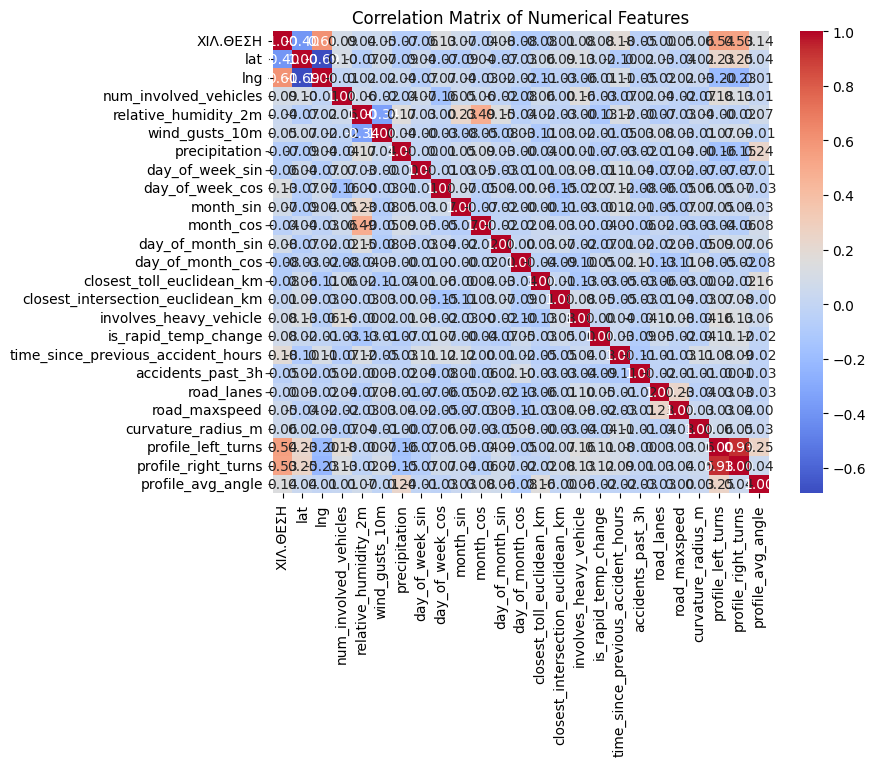

In [ ]:
# Analyze correlation between numerical features
if len(numerical_features) > 1:
    correlation_matrix = X_train_iter_3[numerical_features].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()
else:
    print("Not enough numerical features to compute correlation matrix.")

## spatial feature engineering

In [ ]:
if 'X_train_iter_3' in locals() and 'lat' in X_train_iter_3.columns and 'lng' in X_train_iter_3.columns: # Check if data and columns exist
    N_BINS = 8 # Example number of bins for gridding
    GEOHASH_PRECISION = 7 # Example geohash precision
    KDE_BANDWIDTH = 0.05 # Example KDE bandwidth - VERY SENSITIVE, needs tuning/domain knowledge

    # --- Create Road Segment ID using the adjusted function ---
    if 'ΑΥΤ/ΔΡΟΜΟΣ' in X_train_iter_3.columns and 'ΧΙΛ.ΘΕΣΗ' in X_train_iter_3.columns:
        # Call the adjusted function
        X_train_iter_3 = create_road_segment_feature_adjusted(X_train_iter_3)
        X_val_iter_3 = create_road_segment_feature_adjusted(X_val_iter_3)
        X_test_iter_3 = create_road_segment_feature_adjusted(X_test_iter_3)
        print("Adjusted road segment ID feature created.")
        # You can check the counts of the new categories:
        # print("Value counts for adjusted segment_id in X_train_iter_3:")
        # print(X_train_iter_3['segment_id'].value_counts().head(10))
    else:
        print("Skipping road segment ID creation: Required columns not found.")


    # --- Apply Coordinate Binning ---
    # (No changes needed here, ensure 'lat'/'lng' are present if you run this)
    if 'lat' in X_train_iter_3.columns and 'lng' in X_train_iter_3.columns:
        X_train_iter_3 = create_coordinate_bins(X_train_iter_3, n_bins=N_BINS, fit_df=X_train_iter_3.copy())
        X_val_iter_3 = create_coordinate_bins(X_val_iter_3, n_bins=N_BINS, fit_df=X_train_iter_3.copy())
        X_test_iter_3 = create_coordinate_bins(X_test_iter_3, n_bins=N_BINS, fit_df=X_train_iter_3.copy())
        print(f"Coordinate bins ({N_BINS}x{N_BINS}) created.")
    else:
        print("Skipping coordinate binning: lat/lng columns not found.")


    # --- Apply Geohashing ---
    # (No changes needed here, ensure 'lat'/'lng' are present)
    if 'lat' in X_train_iter_3.columns and 'lng' in X_train_iter_3.columns:
        X_train_iter_3 = apply_geohash(X_train_iter_3, precision=GEOHASH_PRECISION)
        X_val_iter_3 = apply_geohash(X_val_iter_3, precision=GEOHASH_PRECISION)
        X_test_iter_3 = apply_geohash(X_test_iter_3, precision=GEOHASH_PRECISION)
        print(f"Geohash (precision {GEOHASH_PRECISION}) features created.")
    else:
        print("Skipping geohashing: lat/lng columns not found.")


    # --- Apply KDE Score ---
    # (No changes needed here, ensure 'lat'/'lng' are present)
    if 'lat' in X_train_iter_3.columns and 'lng' in X_train_iter_3.columns:
        X_train_iter_3_coords_for_kde = X_train_iter_3[['lat', 'lng']].dropna()
        if not X_train_iter_3_coords_for_kde.empty:
            X_train_iter_3 = apply_kde_score(X_train_iter_3.dropna(subset=['lat', 'lng']), X_train_iter_3_coords_for_kde, bandwidth=KDE_BANDWIDTH)
            X_val_iter_3 = apply_kde_score(X_val_iter_3.dropna(subset=['lat', 'lng']), X_train_iter_3_coords_for_kde, bandwidth=KDE_BANDWIDTH)
            X_test_iter_3 = apply_kde_score(X_test_iter_3.dropna(subset=['lat', 'lng']), X_train_iter_3_coords_for_kde, bandwidth=KDE_BANDWIDTH)

            # X_train_iter_3['kde_score'].fillna(0.0, inplace=True)
            X_train_iter_3.fillna({'kde_score':0.0},inplace=True)
            # X_val_iter_3['kde_score'].fillna(0.0, inplace=True)
            X_val_iter_3.fillna({'kde_score':0.0},inplace=True)
            # X_test_iter_3['kde_score'].fillna(0.0, inplace=True)
            X_test_iter_3.fillna({'kde_score':0.0},inplace=True)

            print("KDE scores created.")
        else:
            print("Skipping KDE: No valid coordinates in X_train_iter_3 to fit KDE.")
            X_train_iter_3['kde_score'] = 0.0
            X_val_iter_3['kde_score'] = 0.0
            X_test_iter_3['kde_score'] = 0.0
    else:
        print("Skipping KDE score: lat/lng columns not found.")


    # Display some of the new features
    # (Ensure the column name for segment_id matches what's created, e.g. 'segment_id')
    new_spatial_cols = []
    if f'grid_cell_{N_BINS}x{N_BINS}' in X_train_iter_3.columns: new_spatial_cols.append(f'grid_cell_{N_BINS}x{N_BINS}')
    if f'geohash_p{GEOHASH_PRECISION}' in X_train_iter_3.columns: new_spatial_cols.append(f'geohash_p{GEOHASH_PRECISION}')
    if 'kde_score' in X_train_iter_3.columns: new_spatial_cols.append('kde_score')
    # Check for the actual segment_id column name, assuming it's 'segment_id' from prefix='segment'
    if 'segment_id' in X_train_iter_3.columns: new_spatial_cols.append('segment_id')

    new_spatial_cols = [col for col in new_spatial_cols if col in X_train_iter_3.columns]
    if new_spatial_cols:
        print("\nSample of new spatial features in X_train_iter_3:")
        # In Colab, display() is better for DataFrames
        try:
            display(X_train_iter_3[new_spatial_cols].head())
        except NameError: # If display() is not available (e.g. standard Python script)
            print(X_train_iter_3[new_spatial_cols].head())

    else:
        print("\nNo new spatial features were added or found to display.")

else:
    print("Skipping spatial feature engineering: X_train_iter_3 or key columns not available.")

Adjusted road segment ID feature created.
Coordinate bins (8x8) created.
Geohash (precision 7) features created.
KDE scores created.

Sample of new spatial features in X_train_iter_3:


grid_cell_8x8 geohash_p7  kde_score                segment_id
262           6_4    swbbef4  14.062409                    A_20.6
177           5_6    swbbmuw  27.942050                    A_29.6
419           6_0    swb8x1r   8.395720                     E_1.0
256           6_0    swb8x04   8.286283  A_EntryZone_Or_UnknownKM
483           0_7    sw8zxwp   9.308883                    A_46.7

In [ ]:
# X_train_iter_3, X_val_iter_3, X_test_iter_3 are your dataframes after spatial features are engineered
columns_to_drop_after_spatial_eng = ['lat', 'lng'] # Add any other raw source columns if needed

X_train_iter_3 = X_train_iter_3.drop(columns=columns_to_drop_after_spatial_eng, errors='ignore')
X_val_iter_3 = X_val_iter_3.drop(columns=columns_to_drop_after_spatial_eng, errors='ignore')
X_test_iter_3 = X_test_iter_3.drop(columns=columns_to_drop_after_spatial_eng, errors='ignore')

print(f"Dropped raw spatial columns: {columns_to_drop_after_spatial_eng}")

Dropped raw spatial columns: ['lat', 'lng']


## pre-processing

In [ ]:
if 'X_train_iter_3' in locals():
    # Identify feature types AFTER new spatial features are created
    # New categorical features from spatial engineering:
    new_cat_spatial_features = []
    if f'grid_cell_{N_BINS}x{N_BINS}' in X_train_iter_3.columns: new_cat_spatial_features.append(f'grid_cell_{N_BINS}x{N_BINS}')
    if f'geohash_p{GEOHASH_PRECISION}' in X_train_iter_3.columns: new_cat_spatial_features.append(f'geohash_p{GEOHASH_PRECISION}')
    if 'segment_id' in X_train_iter_3.columns: new_cat_spatial_features.append('segment_id')
    # Add more if you create other categorical spatial features e.g. lat_bin_N, lng_bin_N as separate features

    # New numerical features from spatial engineering:
    new_num_spatial_features = []
    if 'kde_score' in X_train_iter_3.columns: new_num_spatial_features.append('kde_score')


    all_categorical_features = X_train_iter_3.select_dtypes(include=['object', 'category']).columns.tolist()
    # Ensure our new spatial categoricals are included if not automatically detected as object/category
    for f in new_cat_spatial_features:
        if f not in all_categorical_features and f in X_train_iter_3.columns:
            all_categorical_features.append(f)
            X_train_iter_3[f] = X_train_iter_3[f].astype('category') # Ensure correct dtype
            X_val_iter_3[f] = X_val_iter_3[f].astype('category')
            X_test_iter_3[f] = X_test_iter_3[f].astype('category')


    # Features for 'unknown' imputation (original list)
    categorical_features_unknown_impute = [
        'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'ΚΑΤ._ΟΔ.', 'ΤΕΧΝ._ΦΩΤ.', "weather_description", 'effective_lighting_condition'
    ]
    categorical_features_unknown_impute = [col for col in categorical_features_unknown_impute if col in X_train_iter_3.columns and col in all_categorical_features]


    # Other categorical features (if any) for 'most_frequent' imputation
    # This will now include new_cat_spatial_features if they are not in the unknown_impute list
    categorical_features_mode_impute = [
        col for col in all_categorical_features if col not in categorical_features_unknown_impute
    ]

    boolean_features = X_train_iter_3.select_dtypes(include=['bool']).columns.tolist()
    for bf in boolean_features:
        X_train_iter_3[bf] = X_train_iter_3[bf].astype(int)
        X_val_iter_3[bf] = X_val_iter_3[bf].astype(int)
        X_test_iter_3[bf] = X_test_iter_3[bf].astype(int)

    numerical_features = X_train_iter_3.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
    # Ensure our new numerical spatial features are included
    for f in new_num_spatial_features:
        if f not in numerical_features and f in X_train_iter_3.columns:
            numerical_features.append(f)


    print(f"Final Numerical features for preprocessor: {numerical_features}")
    print(f"Final Categorical features for 'unknown' imputation: {categorical_features_unknown_impute}")
    print(f"Final Categorical features for 'most_frequent' imputation: {categorical_features_mode_impute}")


    # --- The rest of your ColumnTransformer and preprocessing code follows ---
    # Create preprocessing pipelines (as you had before)
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline_unknown = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    categorical_pipeline_mode = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')), # New spatial categoricals (grid_cell, geohash) usually don't have NaNs if created properly
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    transformers_list = []
    if numerical_features: # Add only if list is not empty
         transformers_list.append(('num', numerical_pipeline, numerical_features))
    if categorical_features_unknown_impute:
        transformers_list.append(('cat_unknown', categorical_pipeline_unknown, categorical_features_unknown_impute))
    if categorical_features_mode_impute:
        transformers_list.append(('cat_mode', categorical_pipeline_mode, categorical_features_mode_impute))

    preprocessor = ColumnTransformer(
        transformers=transformers_list,
        remainder='passthrough'
    )

    # Fit and transform (as you had before)
    # ... your existing code for fitting preprocessor and creating X_train_iter_3_processed_df ...
    # (No changes needed to that part if the feature lists fed into ColumnTransformer are correct)
    # Fit preprocessor on X_train_iter_3 and transform all sets
    X_train_iter_3_processed = preprocessor.fit_transform(X_train_iter_3)
    X_val_iter_3_processed = preprocessor.transform(X_val_iter_3)
    X_test_iter_3_processed = preprocessor.transform(X_test_iter_3)

    # Get feature names after one-hot encoding for RFE and interpretation
    try:
        feature_names_out = preprocessor.get_feature_names_out()
        X_train_iter_3_processed_df = pd.DataFrame(X_train_iter_3_processed, columns=feature_names_out, index=X_train_iter_3.index)
        X_val_iter_3_processed_df = pd.DataFrame(X_val_iter_3_processed, columns=feature_names_out, index=X_val_iter_3.index)
        X_test_iter_3_processed_df = pd.DataFrame(X_test_iter_3_processed, columns=feature_names_out, index=X_test_iter_3.index)
        print(f"Processed training data shape: {X_train_iter_3_processed_df.shape}")
    except Exception as e:
        print(f"Could not get feature names from preprocessor automatically: {e}")
        X_train_iter_3_processed_df = pd.DataFrame(X_train_iter_3_processed, index=X_train_iter_3.index)
        X_val_iter_3_processed_df = pd.DataFrame(X_val_iter_3_processed, index=X_val_iter_3.index)
        X_test_iter_3_processed_df = pd.DataFrame(X_test_iter_3_processed, index=X_test_iter_3.index)
        feature_names_out = X_train_iter_3_processed_df.columns.astype(str)
        print(f"Processed training data shape (generic column names): {X_train_iter_3_processed_df.shape}")

Final Numerical features for preprocessor: ['num_involved_vehicles', 'has_ΙΧΕ', 'has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ', 'has_ΔΙΚΥΚΛΟ', 'has_ΦΟΡΤΗΓΟ', 'has_ΤΑΞΙ', 'has_ΛΕΩΦΟΡΕΙΟ', 'has_Μ.Ε.', 'relative_humidity_2m', 'wind_gusts_10m', 'precipitation', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_month_sin', 'day_of_month_cos', 'closest_toll_euclidean_km', 'closest_intersection_euclidean_km', 'involves_heavy_vehicle', 'is_rapid_temp_change', 'time_since_previous_accident_hours', 'accidents_past_3h', 'road_lanes', 'road_maxspeed', 'curvature_radius_m', 'profile_left_turns', 'profile_right_turns', 'profile_avg_angle', 'lat_bin_8', 'lng_bin_8', 'kde_score']
Final Categorical features for 'unknown' imputation: ['ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'ΚΑΤ._ΟΔ.', 'ΤΕΧΝ._ΦΩΤ.', 'effective_lighting_condition']
Final Categorical features for 'most_frequent' imputation: ['ΑΥΤ/ΔΡΟΜΟΣ', 'ΧΙΛ.ΘΕΣΗ', 'ΣΗΡΑΓΓΑ', 'ΥΠΟΚΑΤΗΓΟΡΙΑ', 'ΘΕΣΗ_ΕΡΓΟΥ', 'temperature_category', 'road_context', 'curve_category', 'curve_

## colinearity


Mutual Information Scores (Top 15):
cat_mode__grid_cell_8x8_5_6               0.050853
cat_mode__segment_id_M_3.7                0.046032
cat_mode__segment_id_K_2.1                0.044843
cat_unknown__ΣΥΝΘ._ΟΔ._ΚΑΝΟΝΙΚΕΣ          0.043706
cat_mode__segment_id_E_20.3               0.043008
cat_mode__ΧΙΛ.ΘΕΣΗ_7.3                    0.042152
cat_mode__geohash_p7_sw8zzw1              0.040771
cat_mode__segment_id_Z_16.0               0.040511
cat_mode__grid_cell_8x8_3_7               0.039662
cat_mode__segment_id_X_5.5                0.039103
cat_mode__geohash_p7_swbbnqh              0.037940
cat_mode__segment_id_E_42.7               0.037605
num__closest_intersection_euclidean_km    0.037526
cat_mode__geohash_p7_swbbq3n              0.036000
cat_mode__grid_cell_8x8_6_4               0.034749
dtype: float64


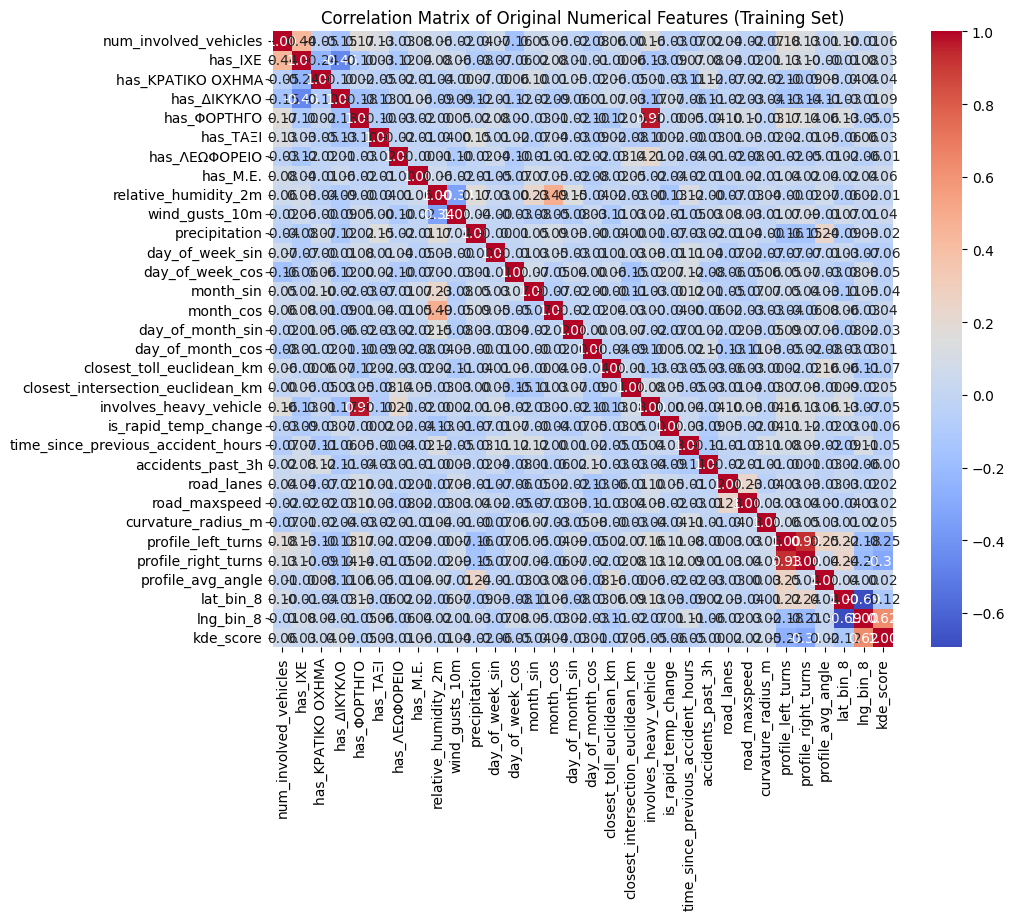

In [ ]:
if 'X_train_iter_3_processed_df' in locals():
    # Note: For filter methods, it's often better to use them on data *before* extensive transformations
    # if the transformations obscure original relationships (e.g. scaling for chi2).
    # However, for simplicity here, we use the processed data.
    # Ensure all data is non-negative for chi2 if applicable
    # For mutual_info_classif and f_classif, current processed data is fine.

    # Mutual Information (works for both num and cat (post-OHE))
    mi_scores = mutual_info_classif(X_train_iter_3_processed_df, y_train_iter_3, random_state=42)
    mi_series = pd.Series(mi_scores, index=feature_names_out).sort_values(ascending=False)
    print("\nMutual Information Scores (Top 15):")
    print(mi_series.head(15))

    # Correlation (for numerical features in X_train_iter_3_processed_df - identify them again)
    # This is more complex with OHE. For now, let's skip detailed VIF on OHE.
    # A simple correlation heatmap on the original numerical features can be insightful:
    if len(numerical_features) > 1:
        plt.figure(figsize=(10, 8))
        sns.heatmap(X_train_iter_3[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Matrix of Original Numerical Features (Training Set)")
        plt.show()


## recursive feature elimination with cross validation


--- Iteration 2: Recursive Feature Elimination with Cross-Validation (RFECV) ---
RFECV will use the estimator: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')
Cross-validation strategy: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
Scoring metric for feature selection: 'roc_auc'
Fitting RFECV... (This might take some time)
Optimal number of features found by RFECV: 246

Selected features from RFECV (246):
Shape of X_train after RFECV: (313, 246)


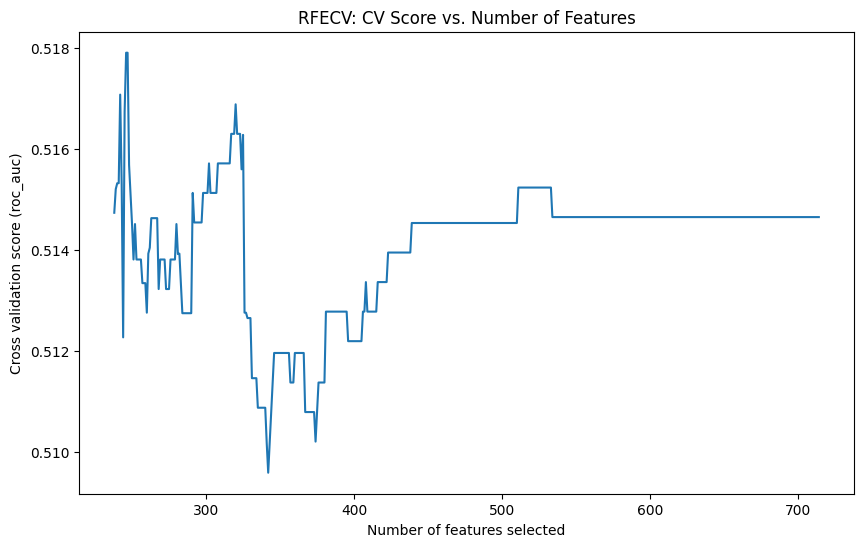

In [ ]:
# Ensure necessary imports
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression # Your chosen estimator
from sklearn.metrics import make_scorer, f1_score # For scoring if needed


if 'X_train_iter_3_processed_df' in locals() and X_train_iter_3_processed_df is not None and \
   'y_train_iter_3' in locals() and y_train_iter_3 is not None:

    print("\n--- Iteration 2: Recursive Feature Elimination with Cross-Validation (RFECV) ---")

    estimator_rfecv = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42, max_iter=1000)

    # Define the cross-validation strategy
    # StratifiedKFold is good for classification, especially with imbalanced classes
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Using 5 splits as an example

    # Define the scoring metric for RFECV to optimize
    # For imbalanced classes, 'f1', 'roc_auc', or 'average_precision' (PR AUC) are often better than 'accuracy'.
    # Let's use 'f1' for the positive class (assuming positive_label=1)
    # If your positive class is not 1, adjust pos_label
    # You can also use 'roc_auc', 'average_precision', etc.
    scorer_for_rfecv = make_scorer(f1_score, pos_label=1, average='binary', zero_division=0)
    # Alternatively, just use a string like 'f1_macro', 'roc_auc'.
    # For binary classification and focusing on the positive class, 'f1' (which defaults to f1 of positive class if pos_label=1) or 'roc_auc' are good.
    # Let's use 'roc_auc' as it's a common general-purpose metric for RFECV selection
    # and less prone to issues if a fold has no positive predictions for some feature subsets.

    print(f"RFECV will use the estimator: {estimator_rfecv}")
    print(f"Cross-validation strategy: {cv_strategy}")
    print(f"Scoring metric for feature selection: 'roc_auc'") # Or your chosen scorer

    rfecv = RFECV(
        estimator=estimator_rfecv,
        step=1,  # Remove 1 feature at each step
        cv=cv_strategy,
        scoring='roc_auc',  # Metric to optimize for feature selection
        min_features_to_select=max(5, X_train_iter_3_processed_df.shape[1] // 3), # Example: select at least 5 features, or 10%
        n_jobs=-1 # Use all available cores
    )

    print("Fitting RFECV... (This might take some time)")
    try:
        rfecv.fit(X_train_iter_3_processed_df, y_train_iter_3)

        print(f"Optimal number of features found by RFECV: {rfecv.n_features_}")

        # Get the mask of selected features
        selected_features_rfecv_mask = rfecv.support_

        # Get the names of the selected features
        # Ensure that X_train_iter_3_processed_df has columns attribute (it should if it's a DataFrame)
        selected_features_rfecv = X_train_iter_3_processed_df.columns[selected_features_rfecv_mask]

        print(f"\nSelected features from RFECV ({len(selected_features_rfecv)}):")
        # Printing all feature names can be very long, consider printing only a few or just the count
        # print(selected_features_rfecv.tolist())

        # Update DataFrames to keep only RFECV selected features
        X_train_iter_3_iter_final = X_train_iter_3_processed_df[selected_features_rfecv]
        X_val_iter_3_iter_final = X_val_iter_3_processed_df[selected_features_rfecv]
        X_test_iter_3_iter_final = X_test_iter_3_processed_df[selected_features_rfecv]

        print(f"Shape of X_train after RFECV: {X_train_iter_3_iter_final.shape}")

        # You can also plot the number of features vs. cross-validation scores
        if hasattr(rfecv, "cv_results_"):
            try:
                import matplotlib.pyplot as plt
                n_scores = len(rfecv.cv_results_["mean_test_score"]) # Number of features evaluated
                plt.figure(figsize=(10,6))
                plt.xlabel("Number of features selected")
                plt.ylabel(f"Cross validation score ({rfecv.scoring})")
                plt.plot(
                    range(rfecv.min_features_to_select, n_scores + rfecv.min_features_to_select), # X-axis: number of features
                    rfecv.cv_results_["mean_test_score"],
                )
                plt.title("RFECV: CV Score vs. Number of Features")
                plt.show()
            except Exception as plot_e:
                print(f"Could not plot RFECV scores: {plot_e}")

    except ValueError as ve:
        print(f"ValueError during RFECV fitting: {ve}")
        print("This might occur if input data is problematic or no features could be selected.")
        # Fallback: use all features from preprocessing if RFECV fails
        X_train_iter_3_iter_final = X_train_iter_3_processed_df.copy()
        X_val_iter_3_iter_final = X_val_iter_3_processed_df.copy()
        X_test_iter_3_iter_final = X_test_iter_3_processed_df.copy()
        print("Using all preprocessed features as RFECV failed.")
    except Exception as e:
        print(f"An unexpected error occurred during RFECV: {e}")
        X_train_iter_3_iter_final = X_train_iter_3_processed_df.copy() # Fallback
        X_val_iter_3_iter_final = X_val_iter_3_processed_df.copy()
        X_test_iter_3_iter_final = X_test_iter_3_processed_df.copy()
        print("Using all preprocessed features as RFECV encountered an error.")


else:
    print("Skipping RFECV as processed data (X_train_iter_3_processed_df or y_train_iter_3) is not available.")
    # Define fallback if previous steps failed
    if 'X_train_iter_3_processed_df' in locals() and X_train_iter_3_processed_df is not None:
        X_train_iter_3_iter_final = X_train_iter_3_processed_df.copy()
        X_val_iter_3_iter_final = X_val_iter_3_processed_df.copy() if 'X_val_iter_3_processed_df' in locals() and X_val_iter_3_processed_df is not None else None
        X_test_iter_3_iter_final = X_test_iter_3_processed_df.copy() if 'X_test_iter_3_processed_df' in locals() and X_test_iter_3_processed_df is not None else None
    else:
        X_train_iter_3_iter_final, X_val_iter_3_iter_final, X_test_iter_3_iter_final = None, None, None

In [ ]:
X_train_iter_3.shape

(313, 50)

## balancing techniques

In [ ]:
# Previous code: X_train_iter_3_iter_final, y_train_iter_3, X_val_iter_final, y_val are defined

resampled_datasets_iter_3 = {} # To store (X_resampled, y_resampled) for each technique

if 'X_train_iter_3_iter_final' in locals() and X_train_iter_3_iter_final is not None and y_train_iter_3 is not None:
    print(f"\nOriginal training set shape: {X_train_iter_3_iter_final.shape}, Original class distribution: {Counter(y_train_iter_3)}")
    minority_class_count = Counter(y_train_iter_3).get(1, 0) # Assuming 1 is the minority class

    # Store the original (non-resampled) training data as a baseline
    resampled_datasets_iter_3['Original'] = (X_train_iter_3_iter_final.copy(), y_train_iter_3.copy())

    # Define samplers
    samplers = {
        "RandomOverSampler": RandomOverSampler(random_state=42),
        "SMOTE": None, # Will initialize carefully due to k_neighbors
        "ADASYN": None, # Will initialize carefully due to n_neighbors
        "TomekLinks": TomekLinks(sampling_strategy='auto', n_jobs=-1), # Undersampling, removes Tomek links
        "SMOTETomek": None, # Will initialize carefully
        "SMOTEENN": None # Will initialize carefully
    }

    # SMOTE and ADASYN require k_neighbors (or n_neighbors for ADASYN) < minority_class_count
    if minority_class_count > 1:
        k_val = min(4, minority_class_count - 1) # A common heuristic for k, ensuring it's less than minority samples

        if k_val > 0 : # Ensure k_val is positive
            samplers["SMOTE"] = SMOTE(random_state=42, k_neighbors=k_val)
            samplers["ADASYN"] = ADASYN(random_state=42, n_neighbors=k_val) # ADASYN uses n_neighbors
            samplers["SMOTETomek"] = SMOTETomek(random_state=42, smote=SMOTE(random_state=42, k_neighbors=k_val), tomek=TomekLinks(sampling_strategy='auto'), n_jobs=-1)
            samplers["SMOTEENN"] = SMOTEENN(random_state=42, smote=SMOTE(random_state=42, k_neighbors=k_val), enn=None, n_jobs=-1) # enn default is good
        else:
            print(f"Skipping SMOTE-based samplers as k_val ({k_val}) would be too small or zero based on minority count ({minority_class_count}).")
            # Remove them if they can't be initialized
            for key in ["SMOTE", "ADASYN", "SMOTETomek", "SMOTEENN"]:
                if key in samplers: samplers.pop(key)

    else:
        print(f"Skipping SMOTE-based samplers as minority count ({minority_class_count}) is <= 1.")
        for key in ["SMOTE", "ADASYN", "SMOTETomek", "SMOTEENN"]:
            if key in samplers: samplers.pop(key)


    # Apply each sampler
    for name, sampler in samplers.items():
        if sampler is None: # Sampler was not initialized
            continue
        print(f"\nApplying {name}...")
        try:
            X_res, y_res = sampler.fit_resample(X_train_iter_3_iter_final, y_train_iter_3)
            resampled_datasets_iter_3[name] = (X_res, y_res)
            print(f"Resampled with {name}: X_shape={X_res.shape}, y_dist={Counter(y_res)}")
        except Exception as e:
            print(f"Could not apply {name}. Error: {e}")
            # Optionally store original if sampler fails, or skip
            # resampled_datasets_iter_3[name] = (X_train_iter_3_iter_final.copy(), y_train_iter_3.copy())


    if not resampled_datasets_iter_3: # If all samplers failed or were skipped
        print("No resampling techniques were successfully applied or initialized. Using original data only.")
        if 'Original' not in resampled_datasets_iter_3: # Should already be there
             resampled_datasets_iter_3['Original'] = (X_train_iter_3_iter_final.copy(), y_train_iter_3.copy())


else:
    print("Skipping balancing as X_train_iter_3_iter_final or y_train_iter_3 is not available.")
    # Ensure there's at least 'Original' if X_train_iter_3_iter_final was available
    if 'X_train_iter_3_iter_final' in locals() and X_train_iter_3_iter_final is not None and y_train_iter_3 is not None:
        resampled_datasets_iter_3['Original'] = (X_train_iter_3_iter_final.copy(), y_train_iter_3.copy())


Original training set shape: (313, 246), Original class distribution: Counter({0: 284, 1: 29})

Applying RandomOverSampler...
Resampled with RandomOverSampler: X_shape=(568, 246), y_dist=Counter({0: 284, 1: 284})

Applying SMOTE...
Resampled with SMOTE: X_shape=(568, 246), y_dist=Counter({0: 284, 1: 284})

Applying ADASYN...
Resampled with ADASYN: X_shape=(566, 246), y_dist=Counter({0: 284, 1: 282})

Applying TomekLinks...
Resampled with TomekLinks: X_shape=(302, 246), y_dist=Counter({0: 273, 1: 29})

Applying SMOTETomek...
Resampled with SMOTETomek: X_shape=(568, 246), y_dist=Counter({0: 284, 1: 284})

Applying SMOTEENN...
Resampled with SMOTEENN: X_shape=(429, 246), y_dist=Counter({1: 284, 0: 145})


## model training

In [ ]:
trained_models_iter_3 = {} # To store trained models: key will be "ModelName_SamplerName"

if 'resampled_datasets_iter_3' in locals() and resampled_datasets_iter_3:
    minority_class_label = 1 # Assuming 'death' is 1
    f1_minority_scorer = make_scorer(f1_score, pos_label=minority_class_label, average='binary') # For CV if you add it later

    for sampler_name, (X_train_curr_resampled, y_train_curr_resampled) in resampled_datasets_iter_3.items():
        print(f"\n--- Training models on data from: {sampler_name} ---")
        print(f"Training data shape: {X_train_curr_resampled.shape}, Distribution: {Counter(y_train_curr_resampled)}")

        # Define your models here or ensure they are defined from a previous cell
        # Re-initialize models for each dataset to ensure they are fresh

        # Calculate scale_pos_weight for XGBoost based on the current resampled data
        counts_curr = Counter(y_train_curr_resampled)
        scale_pos_weight_curr = counts_curr[0] / counts_curr[1] if counts_curr[1] > 0 else 1

        current_models_definitions = {
            'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000),
            'LogisticRegression_L1': LogisticRegression(solver='liblinear', penalty='l1', random_state=42, class_weight='balanced', max_iter=1000),
            'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced_subsample', n_estimators=100),
            'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',
                                         scale_pos_weight=scale_pos_weight_curr)
        }
        # Note on class_weight='balanced':
        # For 'Original' data (imbalanced), it's useful.
        # For data resampled to be perfectly balanced (e.g., SMOTE to 50/50), class_weight='balanced' might have less effect
        # or could be omitted, but it generally doesn't hurt and can help if balance isn't perfect.

        for model_name, model_instance in current_models_definitions.items():
            full_model_name = f"{model_name}_{sampler_name}"
            print(f"Training {full_model_name}...")
            try:
                model_instance.fit(X_train_curr_resampled, y_train_curr_resampled)
                trained_models_iter_3[full_model_name] = model_instance
                print(f"{full_model_name} trained.")
            except Exception as e:
                print(f"Could not train {full_model_name}. Error: {e}")
                trained_models_iter_3[full_model_name] = None # Store None if training failed

else:
    print("Skipping model training as no resampled datasets are available.")


--- Training models on data from: Original ---
Training data shape: (313, 246), Distribution: Counter({0: 284, 1: 29})
Training LogisticRegression_Original...
LogisticRegression_Original trained.
Training LogisticRegression_L1_Original...
LogisticRegression_L1_Original trained.
Training RandomForest_Original...
RandomForest_Original trained.
Training XGBoost_Original...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_Original trained.

--- Training models on data from: RandomOverSampler ---
Training data shape: (568, 246), Distribution: Counter({0: 284, 1: 284})
Training LogisticRegression_RandomOverSampler...
LogisticRegression_RandomOverSampler trained.
Training LogisticRegression_L1_RandomOverSampler...
LogisticRegression_L1_RandomOverSampler trained.
Training RandomForest_RandomOverSampler...
RandomForest_RandomOverSampler trained.
Training XGBoost_RandomOverSampler...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_RandomOverSampler trained.

--- Training models on data from: SMOTE ---
Training data shape: (568, 246), Distribution: Counter({0: 284, 1: 284})
Training LogisticRegression_SMOTE...
LogisticRegression_SMOTE trained.
Training LogisticRegression_L1_SMOTE...
LogisticRegression_L1_SMOTE trained.
Training RandomForest_SMOTE...
RandomForest_SMOTE trained.
Training XGBoost_SMOTE...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_SMOTE trained.

--- Training models on data from: ADASYN ---
Training data shape: (566, 246), Distribution: Counter({0: 284, 1: 282})
Training LogisticRegression_ADASYN...
LogisticRegression_ADASYN trained.
Training LogisticRegression_L1_ADASYN...
LogisticRegression_L1_ADASYN trained.
Training RandomForest_ADASYN...
RandomForest_ADASYN trained.
Training XGBoost_ADASYN...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_ADASYN trained.

--- Training models on data from: TomekLinks ---
Training data shape: (302, 246), Distribution: Counter({0: 273, 1: 29})
Training LogisticRegression_TomekLinks...
LogisticRegression_TomekLinks trained.
Training LogisticRegression_L1_TomekLinks...
LogisticRegression_L1_TomekLinks trained.
Training RandomForest_TomekLinks...
RandomForest_TomekLinks trained.
Training XGBoost_TomekLinks...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_TomekLinks trained.

--- Training models on data from: SMOTETomek ---
Training data shape: (568, 246), Distribution: Counter({0: 284, 1: 284})
Training LogisticRegression_SMOTETomek...
LogisticRegression_SMOTETomek trained.
Training LogisticRegression_L1_SMOTETomek...
LogisticRegression_L1_SMOTETomek trained.
Training RandomForest_SMOTETomek...
RandomForest_SMOTETomek trained.
Training XGBoost_SMOTETomek...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_SMOTETomek trained.

--- Training models on data from: SMOTEENN ---
Training data shape: (429, 246), Distribution: Counter({1: 284, 0: 145})
Training LogisticRegression_SMOTEENN...
LogisticRegression_SMOTEENN trained.
Training LogisticRegression_L1_SMOTEENN...
LogisticRegression_L1_SMOTEENN trained.
Training RandomForest_SMOTEENN...
RandomForest_SMOTEENN trained.
Training XGBoost_SMOTEENN...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_SMOTEENN trained.


## model evaluation

In [ ]:
if 'trained_models_iter_3' in locals() and trained_models_iter_3 and \
   'X_val_iter_3_iter_final' in locals() and X_val_iter_3_iter_final is not None and y_val_iter_3 is not None:

    print("\n--- Model Assessment on Validation Set ---")

    # Store results for later comparison if needed
    validation_results_iter_3 = {}

    for full_model_name, model in trained_models_iter_3.items():
        if model is not None: # Check if model was trained
            print(f"\n--- Assessing: {full_model_name} ---")
            try:
                y_pred_val_iter_3 = model.predict(X_val_iter_3_iter_final)
                y_proba_val_iter_3 = model.predict_proba(X_val_iter_3_iter_final)[:, 1] # Probability of positive class

                report = classification_report(y_val_iter_3, y_pred_val_iter_3, target_names=['Injury (0)', 'Death (1)'], output_dict=True)
                roc_auc = roc_auc_score(y_val_iter_3, y_proba_val_iter_3)
                precision_pr, recall_pr, _ = precision_recall_curve(y_val_iter_3, y_proba_val_iter_3)
                pr_auc = auc(recall_pr, precision_pr)
                conf_matrix = confusion_matrix(y_val_iter_3, y_pred_val_iter_3)

                print(classification_report(y_val_iter_3, y_pred_val_iter_3, target_names=['Injury (0)', 'Death (1)']))
                print(f"Confusion Matrix:\n{conf_matrix}")
                print(f"ROC AUC: {roc_auc:.4f}")
                print(f"PR AUC: {pr_auc:.4f}")

                # Store results
                validation_results_iter_3[full_model_name] = {
                    'classification_report': report,
                    'confusion_matrix': conf_matrix.tolist(), # convert numpy array to list for easier storage/JSON
                    'roc_auc': roc_auc,
                    'pr_auc': pr_auc,
                    'f1_death': report.get('Death (1)', {}).get('f1-score', 0), # F1 for minority class
                    'recall_death': report.get('Death (1)', {}).get('recall', 0) # Recall for minority class
                }
            except Exception as e:
                print(f"Could not assess {full_model_name}. Error: {e}")
                validation_results_iter_3[full_model_name] = {'error': str(e)}
        else:
            print(f"Model {full_model_name} was not trained, skipping assessment.")
            validation_results_iter_3[full_model_name] = {'error': 'Model not trained'}

    # Optional: Print a summary table of key metrics from validation_results_iter_3
    if validation_results_iter_3:
        print("\n--- Validation Results Summary (F1 and Recall for Death class, PR AUC) ---")
        summary_df = pd.DataFrame([
            {'Model_Sampler': name,
             'F1_Death': data.get('f1_death', 'N/A'),
             'Recall_Death': data.get('recall_death', 'N/A'),
             'PR_AUC': data.get('pr_auc', 'N/A'),
             'ROC_AUC': data.get('roc_auc', 'N/A')}
            for name, data in validation_results_iter_3.items() if 'error' not in data
        ])
        if not summary_df.empty:
            summary_df = summary_df.sort_values(by='F1_Death', ascending=False) # Sort by F1 for death class
            try:
                display(summary_df) # Works well in Colab
            except NameError:
                print(summary_df)
        else:
            print("No valid results to summarize.")


else:
    print("Skipping model assessment: Trained models or validation data are not available.")


--- Model Assessment on Validation Set ---

--- Assessing: LogisticRegression_Original ---
              precision    recall  f1-score   support

  Injury (0)       0.88      0.79      0.83        95
   Death (1)       0.00      0.00      0.00        10

    accuracy                           0.71       105
   macro avg       0.44      0.39      0.42       105
weighted avg       0.80      0.71      0.75       105

Confusion Matrix:
[[75 20]
 [10  0]]
ROC AUC: 0.4842
PR AUC: 0.0835

--- Assessing: LogisticRegression_L1_Original ---
              precision    recall  f1-score   support

  Injury (0)       0.90      0.80      0.85        95
   Death (1)       0.10      0.20      0.13        10

    accuracy                           0.74       105
   macro avg       0.50      0.50      0.49       105
weighted avg       0.83      0.74      0.78       105

Confusion Matrix:
[[76 19]
 [ 8  2]]
ROC AUC: 0.4716
PR AUC: 0.0873

--- Assessing: RandomForest_Original ---
              precision  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

              precision    recall  f1-score   support

  Injury (0)       0.91      0.95      0.93        95
   Death (1)       0.17      0.10      0.12        10

    accuracy                           0.87       105
   macro avg       0.54      0.52      0.53       105
weighted avg       0.84      0.87      0.85       105

Confusion Matrix:
[[90  5]
 [ 9  1]]
ROC AUC: 0.5368
PR AUC: 0.1059

--- Assessing: LogisticRegression_RandomOverSampler ---
              precision    recall  f1-score   support

  Injury (0)       0.88      0.80      0.84        95
   Death (1)       0.00      0.00      0.00        10

    accuracy                           0.72       105
   macro avg       0.44      0.40      0.42       105
weighted avg       0.80      0.72      0.76       105

Confusion Matrix:
[[76 19]
 [10  0]]
ROC AUC: 0.4789
PR AUC: 0.0827

--- Assessing: LogisticRegression_L1_RandomOverSampler ---
              precision    recall  f1-score   support

  Injury (0)       0.89      0.85     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

              precision    recall  f1-score   support

  Injury (0)       0.91      0.93      0.92        95
   Death (1)       0.12      0.10      0.11        10

    accuracy                           0.85       105
   macro avg       0.52      0.51      0.51       105
weighted avg       0.83      0.85      0.84       105

Confusion Matrix:
[[88  7]
 [ 9  1]]
ROC AUC: 0.5621
PR AUC: 0.1148

--- Assessing: LogisticRegression_SMOTE ---
              precision    recall  f1-score   support

  Injury (0)       0.88      0.78      0.83        95
   Death (1)       0.00      0.00      0.00        10

    accuracy                           0.70       105
   macro avg       0.44      0.39      0.41       105
weighted avg       0.80      0.70      0.75       105

Confusion Matrix:
[[74 21]
 [10  0]]
ROC AUC: 0.4705
PR AUC: 0.0820

--- Assessing: LogisticRegression_L1_SMOTE ---
              precision    recall  f1-score   support

  Injury (0)       0.89      0.84      0.86        95
   Death

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

  Injury (0)       0.88      0.78      0.83        95
   Death (1)       0.00      0.00      0.00        10

    accuracy                           0.70       105
   macro avg       0.44      0.39      0.41       105
weighted avg       0.80      0.70      0.75       105

Confusion Matrix:
[[74 21]
 [10  0]]
ROC AUC: 0.4821
PR AUC: 0.0836

--- Assessing: LogisticRegression_L1_ADASYN ---
              precision    recall  f1-score   support

  Injury (0)       0.90      0.86      0.88        95
   Death (1)       0.07      0.10      0.08        10

    accuracy                           0.79       105
   macro avg       0.49      0.48      0.48       105
weighted avg       0.82      0.79      0.81       105

Confusion Matrix:
[[82 13]
 [ 9  1]]
ROC AUC: 0.4853
PR AUC: 0.0938

--- Assessing: RandomForest_ADASYN ---
              precision    recall  f1-score   support

  Injury (0)       0.90      0.99      0.94        95
   Death (1)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

              precision    recall  f1-score   support

  Injury (0)       0.90      1.00      0.95        95
   Death (1)       0.00      0.00      0.00        10

    accuracy                           0.90       105
   macro avg       0.45      0.50      0.47       105
weighted avg       0.82      0.90      0.86       105

Confusion Matrix:
[[95  0]
 [10  0]]
ROC AUC: 0.5484
PR AUC: 0.0988

--- Assessing: XGBoost_SMOTETomek ---
              precision    recall  f1-score   support

  Injury (0)       0.91      0.98      0.94        95
   Death (1)       0.33      0.10      0.15        10

    accuracy                           0.90       105
   macro avg       0.62      0.54      0.55       105
weighted avg       0.86      0.90      0.87       105

Confusion Matrix:
[[93  2]
 [ 9  1]]
ROC AUC: 0.5495
PR AUC: 0.1174

--- Assessing: LogisticRegression_SMOTEENN ---
              precision    recall  f1-score   support

  Injury (0)       0.94      0.62      0.75        95
   Death (1)  

Model_Sampler  F1_Death  Recall_Death    PR_AUC  \
24              LogisticRegression_SMOTEENN  0.230769           0.6  0.110587   
27                         XGBoost_SMOTEENN  0.206897           0.3  0.153249   
25           LogisticRegression_L1_SMOTEENN  0.192308           0.5  0.103693   
11                            XGBoost_SMOTE  0.153846           0.1  0.117386   
23                       XGBoost_SMOTETomek  0.153846           0.1  0.117386   
15                           XGBoost_ADASYN  0.142857           0.1  0.095354   
1            LogisticRegression_L1_Original  0.129032           0.2  0.087283   
3                          XGBoost_Original  0.125000           0.1  0.105878   
17         LogisticRegression_L1_TomekLinks  0.121212           0.2  0.083510   
19                       XGBoost_TomekLinks  0.117647           0.1  0.099936   
7                 XGBoost_RandomOverSampler  0.111111           0.1  0.114814   
26                    RandomForest_SMOTEENN  0.105263           0.1  0.102113   
13             LogisticRegression_L1_ADASYN  0.083333           0.1  0.093760   
16            LogisticRegression_TomekLinks  0.057143           0.1  0.080016   
8                  LogisticRegression_SMOTE  0.000000           0.0  0.082048   
6            RandomForest_RandomOverSampler  0.000000           0.0  0.079014   
4      LogisticRegression_RandomOverSampler  0.000000           0.0  0.082709   
5   LogisticRegression_L1_RandomOverSampler  0.000000           0.0  0.088817   
0               LogisticRegression_Original  0.000000           0.0  0.083520   
2                     RandomForest_Original  0.000000           0.0  0.084719   
10                       RandomForest_SMOTE  0.000000           0.0  0.098774   
9               LogisticRegression_L1_SMOTE  0.000000           0.0  0.081411   
12                LogisticRegression_ADASYN  0.000000           0.0  0.083613   
14                      RandomForest_ADASYN  0.000000           0.0  0.104510   
18                  RandomForest_TomekLinks  0.000000           0.0  0.084531   
22                  RandomForest_SMOTETomek  0.000000           0.0  0.098774   
20            LogisticRegression_SMOTETomek  0.000000           0.0  0.082048   
21         LogisticRegression_L1_SMOTETomek  0.000000           0.0  0.081411   

     ROC_AUC  
24  0.606316  
27  0.516842  
25  0.581053  
11  0.549474  
23  0.549474  
15  0.478947  
1   0.471579  
3   0.536842  
17  0.454737  
19  0.520000  
7   0.562105  
26  0.533684  
13  0.485263  
16  0.461053  
8   0.470526  
6   0.424737  
4   0.478947  
5   0.476842  
0   0.484211  
2   0.475789  
10  0.548421  
9   0.458947  
12  0.482105  
14  0.443158  
18  0.458421  
22  0.548421  
20  0.470526  
21  0.458947

## error analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # To ensure display works if in Colab/Jupyter

# --- Enhanced Helper Function for Error Analysis ---
def perform_more_comprehensive_error_analysis(
    model_name, model,
    X_val_processed_features, y_true_labels,
    X_val_original_features, # DataFrame with original, interpretable features
    key_categorical_features, # List of key categorical feature names to analyze
    key_numerical_features, # List of key numerical feature names to analyze
    target_class_name='Death', positive_label=1, negative_label=0
):
    print(f"\n--- Comprehensive Error Analysis for: {model_name} ---")

    if model is None:
        print("Model is None, skipping analysis.")
        return None

    # Make predictions and get probabilities
    y_pred = model.predict(X_val_processed_features)
    try:
        y_pred_proba = model.predict_proba(X_val_processed_features)[:, positive_label] # Probability of positive class
    except AttributeError:
        y_pred_proba = None # Model might not have predict_proba (e.g., some SVMs)
        print("Warning: Model does not have predict_proba method.")


    # Ensure indices match for proper alignment
    if not X_val_original_features.index.equals(y_true_labels.index):
        print("Error: Indices of X_val_original_features and y_true_labels do not match!")
        # Attempt to reindex
        if len(X_val_original_features) == len(y_true_labels):
            print("Attempting to reindex X_val_original_features...")
            X_val_original_features = X_val_original_features.reindex(y_true_labels.index)
            if not X_val_original_features.index.equals(y_true_labels.index):
                 print("Reindexing failed. Critical error.")
                 return None
        else:
            print("Cannot reindex due to different lengths. Critical error.")
            return None

    analysis_df = X_val_original_features.copy()
    analysis_df['actual_severity'] = y_true_labels
    analysis_df['predicted_severity'] = y_pred
    if y_pred_proba is not None:
        analysis_df[f'predicted_proba_{target_class_name}'] = y_pred_proba

    # Define groups
    tp_data = analysis_df[(analysis_df['actual_severity'] == positive_label) & (analysis_df['predicted_severity'] == positive_label)]
    fp_data = analysis_df[(analysis_df['actual_severity'] == negative_label) & (analysis_df['predicted_severity'] == positive_label)]
    fn_data = analysis_df[(analysis_df['actual_severity'] == positive_label) & (analysis_df['predicted_severity'] == negative_label)]
    tn_data = analysis_df[(analysis_df['actual_severity'] == negative_label) & (analysis_df['predicted_severity'] == negative_label)]

    print(f"\nOverall Validation Set Performance ({model_name}):")
    print(f"Total cases: {len(analysis_df)}")
    print(f"Actual {target_class_name}s: {len(tp_data) + len(fn_data)}")
    print(f"Predicted {target_class_name}s: {len(tp_data) + len(fp_data)}")
    print(f"TP ({target_class_name}): {len(tp_data)}, FP ({target_class_name}): {len(fp_data)}, FN ({target_class_name}): {len(fn_data)}, TN (Not {target_class_name}): {len(tn_data)}")

    groups = {'TP': tp_data, 'FN': fn_data, 'FP': fp_data, 'TN': tn_data}

    for group_name, group_df in groups.items():
        if group_df.empty:
            print(f"\nNo data for {group_name} group.")
            continue
        print(f"\n--- Characteristics of {group_name} for {target_class_name} (Count: {len(group_df)}) ---")

        # Display full describe for the group
        try:
            print(f"Overall descriptive stats for {group_name}:")
            display(group_df.describe(include='all').transpose().fillna('')) # Fill NaN for cleaner display
        except Exception as e:
            print(f"Could not display describe for {group_name}: {e}")

        # Numerical features comparison
        if key_numerical_features:
            print(f"\nNumerical Feature Summaries for {group_name}:")
            try:
                display(group_df[[col for col in key_numerical_features if col in group_df.columns]].describe().transpose().fillna(''))
            except Exception as e:
                print(f"Could not display numerical summaries for {group_name}: {e}")


        # Categorical features comparison
        if key_categorical_features:
            print(f"\nCategorical Feature Value Counts (Top 5) for {group_name}:")
            for col in key_categorical_features:
                if col in group_df.columns:
                    print(f"\nValue counts for '{col}' in {group_name}:")
                    try:
                        display(group_df[col].value_counts(normalize=True, dropna=False).head().to_frame())
                    except Exception as e:
                        print(f"Could not display value_counts for {col} in {group_name}: {e}")

        # Misclassification probabilities if available
        if y_pred_proba is not None and group_name in ['FP', 'FN']:
             print(f"\nPredicted Probabilities for {group_name}:")
             try:
                display(group_df[[f'predicted_proba_{target_class_name}']].describe().transpose().fillna(''))
             except Exception as e:
                print(f"Could not display probability summaries for {group_name}: {e}")


    # Optional: Side-by-side comparison for a few very critical features
    # This part can be expanded significantly
    if key_numerical_features:
        for feature in key_numerical_features:
            if feature in analysis_df.columns:
                plt.figure(figsize=(10, 4))
                sns.histplot(data=analysis_df, x=feature, hue='actual_severity', kde=True, multiple="stack")
                plt.title(f'Distribution of {feature} by Actual Severity')
                plt.show()

                plt.figure(figsize=(10,4))
                sns.boxplot(data=analysis_df, x='actual_severity', y=feature)
                plt.title(f'Boxplot of {feature} by Actual Severity')
                plt.show()


    print(f"\n--- End of Error Analysis for: {model_name} ---")
    return analysis_df # Return the dataframe with predictions for further manual inspection

In [ ]:
# Example:
key_cats = ['ΥΠΟΚΑΤΗΓΟΡΙΑ', 'segment_id', 'effective_lighting_condition', 'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.']
key_nums = ['num_involved_vehicles', 'kde_score', 'wind_gusts_10m', 'relative_humidity_2m'] # Add your numerical features

# Filter them to ensure they exist in the df_for_error_analysis passed to the function
# This should be done where you define df_for_error_analysis
# key_cats = [col for col in key_cats if col in df_for_error_analysis.columns]
# key_nums = [col for col in key_nums if col in df_for_error_analysis.columns]


--- Comprehensive Error Analysis for: RandomForest_SMOTEENN ---

Overall Validation Set Performance (RandomForest_SMOTEENN):
Total cases: 105
Actual Deaths: 10
Predicted Deaths: 9
TP (Death): 1, FP (Death): 8, FN (Death): 9, TN (Not Death): 87

--- Characteristics of TP for Death (Count: 1) ---
Overall descriptive stats for TP:


<ipython-input-72-5996070e4ce6>:73: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  display(group_df.describe(include='all').transpose().fillna('')) # Fill NaN for cleaner display


count unique  \
ΑΥΤ/ΔΡΟΜΟΣ                      1.0      1   
ΧΙΛ.ΘΕΣΗ                        1.0      1   
ΣΗΡΑΓΓΑ                         1.0      1   
ΥΠΟΚΑΤΗΓΟΡΙΑ                    1.0      1   
ΘΕΣΗ_ΕΡΓΟΥ                      1.0      1   
ΚΑΙΡ._ΣΥΝΘ.                     1.0      1   
ΣΥΝΘ._ΟΔ.                       1.0      1   
ΚΑΤ._ΟΔ.                        1.0      1   
ΤΕΧΝ._ΦΩΤ.                      1.0      1   
num_involved_vehicles           1.0          
has_ΙΧΕ                         1.0          
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ               1.0          
has_ΔΙΚΥΚΛΟ                     1.0          
has_ΦΟΡΤΗΓΟ                     1.0          
has_ΤΑΞΙ                        1.0          
has_ΛΕΩΦΟΡΕΙΟ                   1.0          
has_Μ.Ε.                        1.0          
effective_lighting_condition    1.0      1   
segment_id                      1.0      1   
lat_bin_8                       1.0          
lng_bin_8                       1.0          
grid_cell_8x8                   1.0      1   
geohash_p7                      1.0      1   
kde_score                       1.0          
actual_severity                 1.0          
predicted_severity              1.0          
predicted_proba_Death           1.0          

                                                             top freq  \
ΑΥΤ/ΔΡΟΜΟΣ                                                     A    1   
ΧΙΛ.ΘΕΣΗ                                                     0.0    1   
ΣΗΡΑΓΓΑ                                               no_ΣΗΡΑΓΓΑ    1   
ΥΠΟΚΑΤΗΓΟΡΙΑ                  4D.Ι - ΣΕ ΚΤΙΣΜΑ/ΣΤΑΘ. ΑΝΤΙΚΕΙΜΕΝΟ    1   
ΘΕΣΗ_ΕΡΓΟΥ                                                   ΟΧΙ    1   
ΚΑΙΡ._ΣΥΝΘ.                                           ΚΑΛΟΚΑΙΡΙΑ    1   
ΣΥΝΘ._ΟΔ.                                              ΚΑΝΟΝΙΚΕΣ    1   
ΚΑΤ._ΟΔ.                                                ΚΑΝΟΝΙΚΗ    1   
ΤΕΧΝ._ΦΩΤ.                                               ΕΠΑΡΚΗΣ    1   
num_involved_vehicles                                                   
has_ΙΧΕ                                                                 
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                                                       
has_ΔΙΚΥΚΛΟ                                                             
has_ΦΟΡΤΗΓΟ                                                             
has_ΤΑΞΙ                                                                
has_ΛΕΩΦΟΡΕΙΟ                                                           
has_Μ.Ε.                                                                
effective_lighting_condition      Daylight - Sufficient (Manual)    1   
segment_id                              A_EntryZone_Or_UnknownKM    1   
lat_bin_8                                                               
lng_bin_8                                                               
grid_cell_8x8                                            6.0_0.0    1   
geohash_p7                                               swb8x04    1   
kde_score                                                               
actual_severity                                                         
predicted_severity                                                      
predicted_proba_Death                                                   

                                  mean std       min       25%       50%  \
ΑΥΤ/ΔΡΟΜΟΣ                                                                 
ΧΙΛ.ΘΕΣΗ                                                                   
ΣΗΡΑΓΓΑ                                                                    
ΥΠΟΚΑΤΗΓΟΡΙΑ                                                               
ΘΕΣΗ_ΕΡΓΟΥ                                                                 
ΚΑΙΡ._ΣΥΝΘ.                                                                
ΣΥΝΘ._ΟΔ.                                                                  
ΚΑΤ._ΟΔ.                                                                   
ΤΕΧΝ._ΦΩΤ.  


Numerical Feature Summaries for TP:


count      mean std       min       25%       50%  \
num_involved_vehicles    1.0  1.000000      1.000000  1.000000  1.000000   
kde_score                1.0  3.269787      3.269787  3.269787  3.269787   

                            75%       max  
num_involved_vehicles  1.000000  1.000000  
kde_score              3.269787  3.269787


Categorical Feature Value Counts (Top 5) for TP:

Value counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ' in TP:


proportion
ΥΠΟΚΑΤΗΓΟΡΙΑ                                  
4D.Ι - ΣΕ ΚΤΙΣΜΑ/ΣΤΑΘ. ΑΝΤΙΚΕΙΜΕΝΟ         1.0


Value counts for 'segment_id' in TP:


proportion
segment_id                          
A_EntryZone_Or_UnknownKM         1.0


Value counts for 'effective_lighting_condition' in TP:


proportion
effective_lighting_condition              
Daylight - Sufficient (Manual)         1.0


Value counts for 'ΚΑΙΡ._ΣΥΝΘ.' in TP:


proportion
ΚΑΙΡ._ΣΥΝΘ.            
ΚΑΛΟΚΑΙΡΙΑ          1.0


Value counts for 'ΣΥΝΘ._ΟΔ.' in TP:


proportion
ΣΥΝΘ._ΟΔ.            
ΚΑΝΟΝΙΚΕΣ         1.0


--- Characteristics of FN for Death (Count: 9) ---
Overall descriptive stats for FN:


<ipython-input-72-5996070e4ce6>:73: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  display(group_df.describe(include='all').transpose().fillna('')) # Fill NaN for cleaner display


count unique  \
ΑΥΤ/ΔΡΟΜΟΣ                      9.0      3   
ΧΙΛ.ΘΕΣΗ                        9.0      9   
ΣΗΡΑΓΓΑ                         9.0      1   
ΥΠΟΚΑΤΗΓΟΡΙΑ                    9.0      8   
ΘΕΣΗ_ΕΡΓΟΥ                      9.0      1   
ΚΑΙΡ._ΣΥΝΘ.                     9.0      1   
ΣΥΝΘ._ΟΔ.                       9.0      2   
ΚΑΤ._ΟΔ.                        9.0      1   
ΤΕΧΝ._ΦΩΤ.                      2.0      1   
num_involved_vehicles           9.0          
has_ΙΧΕ                         9.0          
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ               9.0          
has_ΔΙΚΥΚΛΟ                     9.0          
has_ΦΟΡΤΗΓΟ                     9.0          
has_ΤΑΞΙ                        9.0          
has_ΛΕΩΦΟΡΕΙΟ                   9.0          
has_Μ.Ε.                        9.0          
effective_lighting_condition    9.0      3   
segment_id                      9.0      9   
lat_bin_8                       9.0          
lng_bin_8                       9.0          
grid_cell_8x8                   9.0      6   
geohash_p7                      9.0      9   
kde_score                       9.0          
actual_severity                 9.0          
predicted_severity              9.0          
predicted_proba_Death           9.0          

                                                                          top  \
ΑΥΤ/ΔΡΟΜΟΣ                                                                  E   
ΧΙΛ.ΘΕΣΗ                                                                 27.8   
ΣΗΡΑΓΓΑ                                                            no_ΣΗΡΑΓΓΑ   
ΥΠΟΚΑΤΗΓΟΡΙΑ                          4D.Τ - ΣΥΓΚΡΟΥΣΗ 3 ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)   
ΘΕΣΗ_ΕΡΓΟΥ                                                                ΟΧΙ   
ΚΑΙΡ._ΣΥΝΘ.                                                        ΚΑΛΟΚΑΙΡΙΑ   
ΣΥΝΘ._ΟΔ.                                                           ΚΑΝΟΝΙΚΕΣ   
ΚΑΤ._ΟΔ.                                                             ΚΑΝΟΝΙΚΗ   
ΤΕΧΝ._ΦΩΤ.                                                            ΕΠΑΡΚΗΣ   
num_involved_vehicles                                                           
has_ΙΧΕ                                                                         
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                                                               
has_ΔΙΚΥΚΛΟ                                                                     
has_ΦΟΡΤΗΓΟ                                                                     
has_ΤΑΞΙ                                                                        
has_ΛΕΩΦΟΡΕΙΟ                                                                   
has_Μ.Ε.                                                                        
effective_lighting_condition  Daylight - Assumed Sufficient (No Manual Entry)   
segment_id                                                             A_27.8   
lat_bin_8                                                                       
lng_bin_8                                                                       
grid_cell_8x8                                                         6.0_4.0   
geohash_p7                                                            swbbmt8   
kde_score                                                                       
actual_severity                                                                 
predicted_severity                                                              
predicted_proba_Death                                                           

                             freq       mean       std       min        25%  \
ΑΥΤ/ΔΡΟΜΟΣ                      5                                             
ΧΙΛ.ΘΕΣΗ                        1                                             
ΣΗΡΑΓΓΑ                         9                                             
ΥΠΟΚΑΤΗΓΟΡΙΑ                    2                                             
ΘΕΣΗ_ΕΡΓΟΥ                      9                                            


Numerical Feature Summaries for FN:


count       mean       std       min        25%  \
num_involved_vehicles    9.0   1.777778  0.833333  1.000000   1.000000   
kde_score                9.0  20.306293  9.155964  3.710695  13.897301   

                             50%        75%       max  
num_involved_vehicles   2.000000   2.000000   3.00000  
kde_score              22.268032  27.872762  30.42232


Categorical Feature Value Counts (Top 5) for FN:

Value counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ' in FN:


proportion
ΥΠΟΚΑΤΗΓΟΡΙΑ                                           
4D.Τ - ΣΥΓΚΡΟΥΣΗ 3 ΟΧΗΜΑΤΩΝ (ΚΑΡΑΜΠΟΛΑ)        0.222222
4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ                       0.111111
4D.Ξ - ΕΚΤΡΟΠΗ ΑΡΙΣΤΕΡΑ                        0.111111
4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ                  0.111111
4D.Ζ - ΣΕ ΟΧΗΜΑ ΠΟΥ ΚΑΝΕΙ ΑΝΑΓΚΑΣΤΙΚΗ ΣΤΑΣΗ    0.111111


Value counts for 'segment_id' in FN:


proportion
segment_id            
A_27.8        0.111111
E_46.3        0.111111
E_26.9        0.111111
A_3.9         0.111111
A_19.8        0.111111


Value counts for 'effective_lighting_condition' in FN:


proportion
effective_lighting_condition                               
Daylight - Assumed Sufficient (No Manual Entry)    0.555556
Night - Artificial Lighting Issue Suspected        0.222222
Night - Artificial Lighting Sufficient (Manual)    0.222222


Value counts for 'ΚΑΙΡ._ΣΥΝΘ.' in FN:


proportion
ΚΑΙΡ._ΣΥΝΘ.            
ΚΑΛΟΚΑΙΡΙΑ          1.0


Value counts for 'ΣΥΝΘ._ΟΔ.' in FN:


proportion
ΣΥΝΘ._ΟΔ.                  
ΚΑΝΟΝΙΚΕΣ          0.888889
ΥΓΡΟ - ΒΡΕΓΜΕΝΟ    0.111111


Predicted Probabilities for FN:


count      mean      std   min   25%   50%   75%   max
predicted_proba_Death    9.0  0.254444  0.11791  0.09  0.19  0.21  0.33  0.43


--- Characteristics of FP for Death (Count: 8) ---
Overall descriptive stats for FP:


<ipython-input-72-5996070e4ce6>:73: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  display(group_df.describe(include='all').transpose().fillna('')) # Fill NaN for cleaner display


count unique  \
ΑΥΤ/ΔΡΟΜΟΣ                      8.0      3   
ΧΙΛ.ΘΕΣΗ                        8.0      4   
ΣΗΡΑΓΓΑ                         8.0      1   
ΥΠΟΚΑΤΗΓΟΡΙΑ                    8.0      4   
ΘΕΣΗ_ΕΡΓΟΥ                      8.0      1   
ΚΑΙΡ._ΣΥΝΘ.                     8.0      1   
ΣΥΝΘ._ΟΔ.                       8.0      1   
ΚΑΤ._ΟΔ.                        8.0      1   
ΤΕΧΝ._ΦΩΤ.                      4.0      1   
num_involved_vehicles           8.0          
has_ΙΧΕ                         8.0          
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ               8.0          
has_ΔΙΚΥΚΛΟ                     8.0          
has_ΦΟΡΤΗΓΟ                     8.0          
has_ΤΑΞΙ                        8.0          
has_ΛΕΩΦΟΡΕΙΟ                   8.0          
has_Μ.Ε.                        8.0          
effective_lighting_condition    8.0      3   
segment_id                      8.0      5   
lat_bin_8                       8.0          
lng_bin_8                       8.0          
grid_cell_8x8                   8.0      4   
geohash_p7                      8.0      5   
kde_score                       8.0          
actual_severity                 8.0          
predicted_severity              8.0          
predicted_proba_Death           8.0          

                                                                          top  \
ΑΥΤ/ΔΡΟΜΟΣ                                                                  E   
ΧΙΛ.ΘΕΣΗ                                                                  0.0   
ΣΗΡΑΓΓΑ                                                            no_ΣΗΡΑΓΓΑ   
ΥΠΟΚΑΤΗΓΟΡΙΑ                                         4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ   
ΘΕΣΗ_ΕΡΓΟΥ                                                                ΟΧΙ   
ΚΑΙΡ._ΣΥΝΘ.                                                        ΚΑΛΟΚΑΙΡΙΑ   
ΣΥΝΘ._ΟΔ.                                                           ΚΑΝΟΝΙΚΕΣ   
ΚΑΤ._ΟΔ.                                                             ΚΑΝΟΝΙΚΗ   
ΤΕΧΝ._ΦΩΤ.                                                            ΕΠΑΡΚΗΣ   
num_involved_vehicles                                                           
has_ΙΧΕ                                                                         
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                                                               
has_ΔΙΚΥΚΛΟ                                                                     
has_ΦΟΡΤΗΓΟ                                                                     
has_ΤΑΞΙ                                                                        
has_ΛΕΩΦΟΡΕΙΟ                                                                   
has_Μ.Ε.                                                                        
effective_lighting_condition  Night - Artificial Lighting Sufficient (Manual)   
segment_id                                           E_EntryZone_Or_UnknownKM   
lat_bin_8                                                                       
lng_bin_8                                                                       
grid_cell_8x8                                                         6.0_0.0   
geohash_p7                                                            swb8x01   
kde_score                                                                       
actual_severity                                                                 
predicted_severity                                                              
predicted_proba_Death                                                           

                             freq      mean       std       min       25%  \
ΑΥΤ/ΔΡΟΜΟΣ                      5                                           
ΧΙΛ.ΘΕΣΗ                        5                                           
ΣΗΡΑΓΓΑ                         8                                           
ΥΠΟΚΑΤΗΓΟΡΙΑ                    5                                           
ΘΕΣΗ_ΕΡΓΟΥ                      8                                           
ΚΑΙΡ._ΣΥΝΘ


Numerical Feature Summaries for FP:


count      mean       std       min       25%  \
num_involved_vehicles    8.0  1.000000   0.00000  1.000000  1.000000   
kde_score                8.0  9.514429  10.73616  3.267412  3.267412   

                            50%        75%      max  
num_involved_vehicles  1.000000   1.000000   1.0000  
kde_score              3.269787  10.798135  29.7921


Categorical Feature Value Counts (Top 5) for FP:

Value counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ' in FP:


proportion
ΥΠΟΚΑΤΗΓΟΡΙΑ                                   
4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ                  0.625
4D.Ξ - ΕΚΤΡΟΠΗ ΑΡΙΣΤΕΡΑ                   0.125
4D.Χ - ΠΡΟΣΚΡΟΥΣΗ ΣΕ ΜΟΝΙΜΗ ΣΗΜΑΝΣΗ       0.125
4D.Ν - ΕΚΤΡΟΠΗ ΔΕΞΙΑ                      0.125


Value counts for 'segment_id' in FP:


proportion
segment_id                          
E_EntryZone_Or_UnknownKM       0.375
A_EntryZone_Or_UnknownKM       0.250
E_36.8                         0.125
E_13.6                         0.125
P_6.1                          0.125


Value counts for 'effective_lighting_condition' in FP:


proportion
effective_lighting_condition                               
Night - Artificial Lighting Sufficient (Manual)       0.500
Daylight - Assumed Sufficient (No Manual Entry)       0.375
Night - Artificial Lighting Issue Suspected           0.125


Value counts for 'ΚΑΙΡ._ΣΥΝΘ.' in FP:


proportion
ΚΑΙΡ._ΣΥΝΘ.            
ΚΑΛΟΚΑΙΡΙΑ          1.0


Value counts for 'ΣΥΝΘ._ΟΔ.' in FP:


proportion
ΣΥΝΘ._ΟΔ.            
ΚΑΝΟΝΙΚΕΣ         1.0


Predicted Probabilities for FP:


count     mean       std   min     25%    50%   75%  \
predicted_proba_Death    8.0  0.56375  0.037773  0.52  0.5375  0.555  0.59   

                        max  
predicted_proba_Death  0.63


--- Characteristics of TN for Death (Count: 87) ---
Overall descriptive stats for TN:


<ipython-input-72-5996070e4ce6>:73: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  display(group_df.describe(include='all').transpose().fillna('')) # Fill NaN for cleaner display


count unique  \
ΑΥΤ/ΔΡΟΜΟΣ                     87.0     10   
ΧΙΛ.ΘΕΣΗ                       87.0     67   
ΣΗΡΑΓΓΑ                        87.0      4   
ΥΠΟΚΑΤΗΓΟΡΙΑ                   87.0     14   
ΘΕΣΗ_ΕΡΓΟΥ                     87.0      2   
ΚΑΙΡ._ΣΥΝΘ.                    85.0      2   
ΣΥΝΘ._ΟΔ.                      86.0      2   
ΚΑΤ._ΟΔ.                       86.0      1   
ΤΕΧΝ._ΦΩΤ.                     34.0      1   
num_involved_vehicles          87.0          
has_ΙΧΕ                        87.0          
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ              87.0          
has_ΔΙΚΥΚΛΟ                    87.0          
has_ΦΟΡΤΗΓΟ                    87.0          
has_ΤΑΞΙ                       87.0          
has_ΛΕΩΦΟΡΕΙΟ                  87.0          
has_Μ.Ε.                       87.0          
effective_lighting_condition   87.0      4   
segment_id                     87.0     74   
lat_bin_8                      87.0          
lng_bin_8                      87.0          
grid_cell_8x8                  87.0     19   
geohash_p7                     87.0     68   
kde_score                      87.0          
actual_severity                87.0          
predicted_severity             87.0          
predicted_proba_Death          87.0          

                                                                          top  \
ΑΥΤ/ΔΡΟΜΟΣ                                                                  A   
ΧΙΛ.ΘΕΣΗ                                                                  0.0   
ΣΗΡΑΓΓΑ                                                            no_ΣΗΡΑΓΓΑ   
ΥΠΟΚΑΤΗΓΟΡΙΑ                                    4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ   
ΘΕΣΗ_ΕΡΓΟΥ                                                                ΟΧΙ   
ΚΑΙΡ._ΣΥΝΘ.                                                        ΚΑΛΟΚΑΙΡΙΑ   
ΣΥΝΘ._ΟΔ.                                                           ΚΑΝΟΝΙΚΕΣ   
ΚΑΤ._ΟΔ.                                                             ΚΑΝΟΝΙΚΗ   
ΤΕΧΝ._ΦΩΤ.                                                            ΕΠΑΡΚΗΣ   
num_involved_vehicles                                                           
has_ΙΧΕ                                                                         
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ                                                               
has_ΔΙΚΥΚΛΟ                                                                     
has_ΦΟΡΤΗΓΟ                                                                     
has_ΤΑΞΙ                                                                        
has_ΛΕΩΦΟΡΕΙΟ                                                                   
has_Μ.Ε.                                                                        
effective_lighting_condition  Daylight - Assumed Sufficient (No Manual Entry)   
segment_id                                           E_EntryZone_Or_UnknownKM   
lat_bin_8                                                                       
lng_bin_8                                                                       
grid_cell_8x8                                                         4.0_6.0   
geohash_p7                                                            swbbnqv   
kde_score                                                                       
actual_severity                                                                 
predicted_severity                                                              
predicted_proba_Death                                                           

                             freq       mean       std       min        25%  \
ΑΥΤ/ΔΡΟΜΟΣ                     30                                             
ΧΙΛ.ΘΕΣΗ                        9                                             
ΣΗΡΑΓΓΑ                        84                                             
ΥΠΟΚΑΤΗΓΟΡΙΑ                   27                                             
ΘΕΣΗ_ΕΡΓΟΥ                     86                                            


Numerical Feature Summaries for TN:


count       mean       std       min        25%  \
num_involved_vehicles   87.0   1.770115  0.911186  1.000000   1.000000   
kde_score               87.0  21.144234  9.638536  3.267412  15.362939   

                             50%        75%        max  
num_involved_vehicles   2.000000   2.000000   7.000000  
kde_score              24.126924  29.810819  30.958128


Categorical Feature Value Counts (Top 5) for TN:

Value counts for 'ΥΠΟΚΑΤΗΓΟΡΙΑ' in TN:


proportion
ΥΠΟΚΑΤΗΓΟΡΙΑ                             
4D.Δ - ΣΥΓΚΡΟΥΣΗ ΝΩΤΟΜΕΤΩΠΙΚΗ    0.310345
4D.Ο - ΑΝΑΤΡΟΠΗ ΣΤΗΝ ΟΔΟ         0.183908
4D.Γ - ΣΥΓΚΡΟΥΣΗ ΠΛΑΓΙΑ          0.114943
4D.Ξ - ΕΚΤΡΟΠΗ ΑΡΙΣΤΕΡΑ          0.103448
4D.Ν - ΕΚΤΡΟΠΗ ΔΕΞΙΑ             0.103448


Value counts for 'segment_id' in TN:


proportion
segment_id                          
E_EntryZone_Or_UnknownKM    0.045977
B_5.6                       0.034483
M_5.3                       0.034483
A_EntryZone_Or_UnknownKM    0.034483
K_0.0                       0.022989


Value counts for 'effective_lighting_condition' in TN:


proportion
effective_lighting_condition                               
Daylight - Assumed Sufficient (No Manual Entry)    0.563218
Night - Artificial Lighting Sufficient (Manual)    0.310345
Daylight - Sufficient (Manual)                     0.080460
Night - Artificial Lighting Issue Suspected        0.045977


Value counts for 'ΚΑΙΡ._ΣΥΝΘ.' in TN:


proportion
ΚΑΙΡ._ΣΥΝΘ.            
ΚΑΛΟΚΑΙΡΙΑ     0.954023
ΨΙΛΗ ΒΡΟΧΗ     0.022989
NaN            0.022989


Value counts for 'ΣΥΝΘ._ΟΔ.' in TN:


proportion
ΣΥΝΘ._ΟΔ.                  
ΚΑΝΟΝΙΚΕΣ          0.919540
ΥΓΡΟ - ΒΡΕΓΜΕΝΟ    0.068966
NaN                0.011494

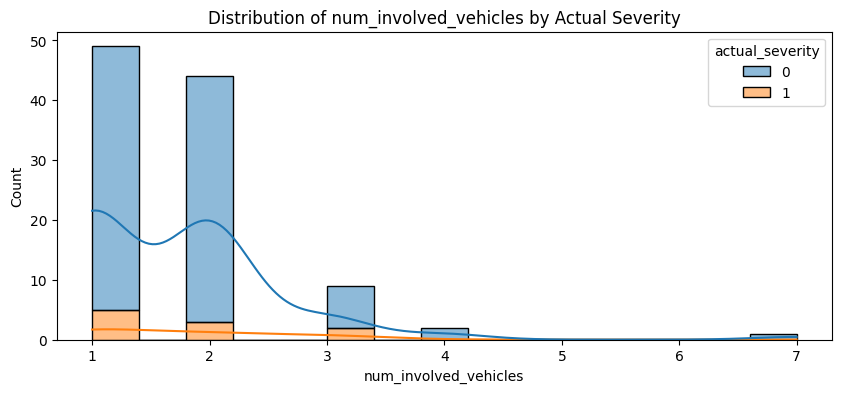

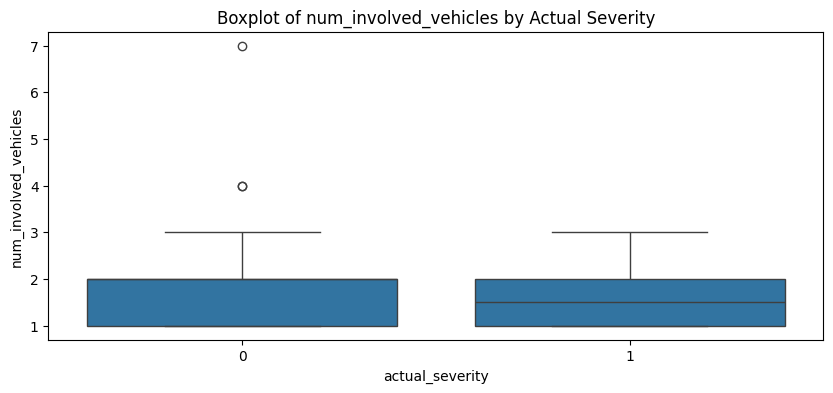

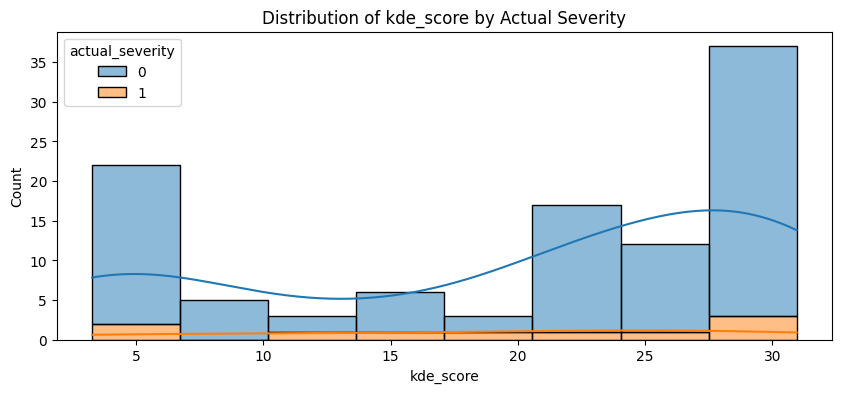

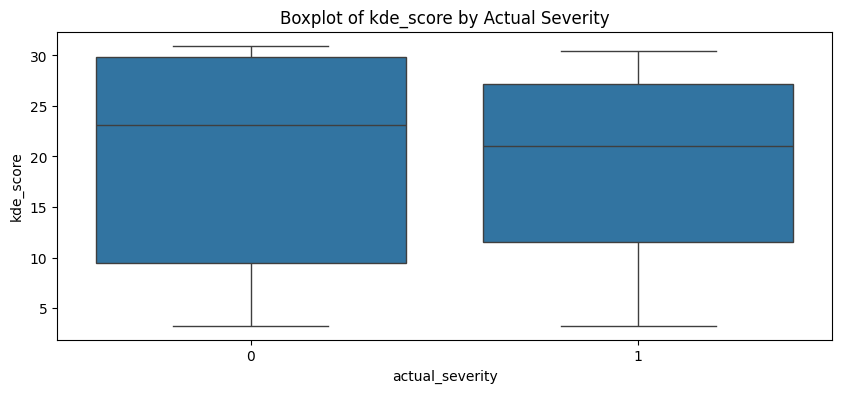


--- End of Error Analysis for: RandomForest_SMOTEENN ---


In [ ]:
# Assuming df_for_error_analysis is correctly set up (e.g., X_val_iter_2.copy())
# And relevant key_cats and key_nums lists are defined based on columns in df_for_error_analysis

# Example for one model:
model_key_to_analyze = 'RandomForest_SMOTEENN' # Use the full key from your trained_models_iter2
model_object_to_analyze = trained_models_iter_3.get(model_key_to_analyze)

analysis_output_df = perform_more_comprehensive_error_analysis(
    model_key_to_analyze,
    model_object_to_analyze,
    X_val_iter_3_iter_final, # Processed features for prediction
    y_val_iter_3,            # True labels
    df_for_error_analysis,   # Original interpretable features
    key_cats,
    key_nums
)